## Install and run optuna

In [1]:
#!pip install cupy-cuda110
!pip install -U py-boost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.2 MB/s eta 0:00:00


## Imports

In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cupy as cp
import py_boost

import optuna
import numpy as np
import pandas as pd

from copy import deepcopy

from sklearn.model_selection import KFold, train_test_split

# simple case - just one class is used
from py_boost import GradientBoosting 
from py_boost.gpu.losses import Loss, Metric

from utils import *

import gc

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style("whitegrid")


In [6]:
N_TRIALS = 20
LR_TUNE = 0.05
LR_REFIT = 0.05

NUM_TREES = 2000
NUM_TREES_REFIT = 2000
ES = 100

N_STEPS_PLOT = 300
SEED = 42


## ALLSTATE dataset

In [ ]:
%%time

data = pd.read_csv('./data/train_allstate.csv')
data.drop('id', axis=1, inplace=True)

for col in [x for x in data.columns if x.startswith('cat')]:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['loss'].values
X = data.drop('loss', axis=1).values

del data
gc.collect()

CPU times: user 8.11 s, sys: 7.82 s, total: 15.9 s
Wall time: 16 s


3639

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(30131, 130) (37664, 130)


## HOUSE PRICES dataset

In [4]:
%%time

data = pd.read_csv('./data/train_house_prices.csv')
data.drop('Id', axis=1, inplace=True)
data.dropna(axis=1, inplace=True)

for col in [x for x in data.columns if data[x].dtype == 'O']:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['SalePrice'].values
X = data.drop('SalePrice', axis=1).values

del data
gc.collect()

CPU times: user 168 ms, sys: 6.73 ms, total: 175 ms
Wall time: 190 ms


0

In [7]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(234, 60) (292, 60)


## LIFE EXPECTANCY dataset

In [ ]:
%%time

data = pd.read_csv('./data/Life_Expectancy_Data.csv')
data.dropna(axis=0, inplace=True)

for col in [x for x in data.columns if data[x].dtype == 'O']:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['Life expectancy '].values
X = data.drop('Life expectancy ', axis=1).values

del data
gc.collect()

CPU times: user 146 ms, sys: 990 µs, total: 147 ms
Wall time: 149 ms


0

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(264, 21) (330, 21)


## CAR PRICE dataset

In [ ]:
%%time

data = pd.read_csv('./data/car_price_prediction.csv')
data.drop('ID', axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

for col in [x for x in data.columns if data[x].dtype == 'O']:
    data[col], _ = pd.factorize(data[col])
    
data = data.astype({x: np.float32 for x in data.columns})
y = data['Price'].values
X = data.drop('Price', axis=1).values

del data
gc.collect()

CPU times: user 230 ms, sys: 990 µs, total: 231 ms
Wall time: 235 ms


3547

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

del X, y
gc.collect()

print(X_val.shape, X_test.shape)

(3078, 16) (3848, 16)


## The custom losses

In [10]:
def get_objective(loss, **params):

    def objective(trial, params=params):
        
        params = {x: trial.suggest_float(x, *params[x]) for x in params}
        
        model = GradientBoosting(
            loss=loss(**params), 
            metric=CustomMAEMetric(),
            ntrees=NUM_TREES, 
            lr=LR_TUNE,
            es=ES, 
            lambda_l2 = trial.suggest_float("lambda_l2", 1., 20.),
            max_depth=trial.suggest_int("max_depth", 4, 8),
            subsample=trial.suggest_float("subsample", 0.5, 1),
            colsample=trial.suggest_float("colsample", 0.5, 1),
            verbose=100, 

        )
        model.fit(X_train, y_train, eval_sets=[{'X': X_val, 'y': y_val},])
        y_pred = model.predict(X_val)[:, 0]

        return (np.abs(y_val - y_pred)).mean()
    
    return objective


def model_refit(X, y, X_val, y_val, X_test, y_test, loss, params):
    
    params = deepcopy(params)
    fit_params = {}
    
    for k in ['lambda_l2', 'max_depth', 'subsample', 'colsample']:
        fit_params[k] = params.pop(k)
    
    model = GradientBoosting(
        loss(**params), 
        metric=CustomMAEMetric(),
        ntrees=NUM_TREES,
        es=ES,
        lr = LR_REFIT,
        verbose=100,
        **fit_params
    )

        
    model.fit(X, y, eval_sets=[{'X': X_val, 'y': y_val},])
    
    y_pred = model.predict(X_test)[:, 0]
    test_score = np.abs(y_test - y_pred).mean()
    
    return model, test_score

## EVAL

In [15]:
LOSSES = {
    
    'PSEUDO_HUBER': (PseudoHuberLoss, {'delta': [1, 20]}, ),
    'HUBER': (CustomHuberLoss, {'delta': [1, 20]}, ),
    'MSLE': CustomMSLELoss,
    'MAE': CustomMAELoss,
    'LogCosh': CustomLogCoshLoss,
    
}

In [16]:
%%time

test_scores = {}
val_scores  = {}
eval_hist   = {}

for key in LOSSES:
    
    print(f"PARAM TUNING FOR {key} LOSS")
    
    loss = LOSSES[key]
    
    if type(loss) is tuple:
        loss, params = loss
    else:
        params = {}
    
    # find best params
    study = optuna.create_study(
    direction='minimize'
    )

    study.optimize(
        get_objective(loss, **params), 
        n_trials=N_TRIALS, 
        gc_after_trial=True,
    )
    
    # evaluate on test set
    print(f"REFIT FOR {key} LOSS")
    
    model, score = model_refit(X_train, y_train, X_val, y_val, X_test, y_test, loss, study.best_params)
    eval_hist[key] = [x[0] for x in model.history]
    val_scores[key] = min(eval_hist[key])
    test_scores[key] = score
    
    print(f"RESULTS FOR {key}: Val score {val_scores[key]}, Test score {test_scores[key]}")
    
    study.trials_dataframe().to_csv(f'{key}_trials.csv')

[I 2023-03-26 12:29:28,053] A new study created in memory with name: no-name-54ede2d3-36ed-4f25-8472-1054628d22a2


PARAM TUNING FOR PSEUDO_HUBER LOSS
[12:29:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:29:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:29:28] Iter 0; Sample 0, score = 59566.81441323498; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59566.81441323498; 


[12:29:29] Iter 100; Sample 0, score = 58829.18359927013; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58829.18359927013; 


[12:29:30] Iter 200; Sample 0, score = 58040.89432742513; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58040.89432742513; 


[12:29:31] Iter 300; Sample 0, score = 57238.902091884636; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57238.902091884636; 


[12:29:32] Iter 400; Sample 0, score = 56496.48306788375; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56496.48306788375; 


[12:29:33] Iter 500; Sample 0, score = 55887.95831017049; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 55887.95831017049; 


[12:29:34] Iter 600; Sample 0, score = 55408.73155732531; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 55408.73155732531; 


[12:29:35] Iter 700; Sample 0, score = 54695.124167645066; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 54695.124167645066; 


[12:29:36] Iter 800; Sample 0, score = 54039.21858439093; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 54039.21858439093; 


[12:29:37] Iter 900; Sample 0, score = 53337.622936408436; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 53337.622936408436; 


[12:29:38] Iter 1000; Sample 0, score = 52656.86723070819; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 52656.86723070819; 


[12:29:39] Iter 1100; Sample 0, score = 51972.48892368454; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 51972.48892368454; 


[12:29:40] Iter 1200; Sample 0, score = 51340.03661949781; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 51340.03661949781; 


[12:29:41] Iter 1300; Sample 0, score = 50742.286973523034; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 50742.286973523034; 


[12:29:42] Iter 1400; Sample 0, score = 50201.55734695654; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 50201.55734695654; 


[12:29:43] Iter 1500; Sample 0, score = 49586.946196200835; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 49586.946196200835; 


[12:29:44] Iter 1600; Sample 0, score = 49053.88418422764; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 49053.88418422764; 


[12:29:45] Iter 1700; Sample 0, score = 48473.50322085913; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 48473.50322085913; 


[12:29:46] Iter 1800; Sample 0, score = 47899.00454538471; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 47899.00454538471; 


[12:29:47] Iter 1900; Sample 0, score = 47391.804562218524; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 47391.804562218524; 


[12:29:48] Iter 1999; Sample 0, score = 46815.99055279383; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 46815.99055279383; 
[I 2023-03-26 12:29:49,199] Trial 0 finished with value: 46816.0703125 and parameters: {'delta': 7.697268115050623, 'lambda_l2': 8.037165135889325, 'max_depth': 4, 'subsample': 0.8503058952091653, 'colsample': 0.5779952313009692}. Best is trial 0 with value: 46816.0703125.


[12:29:49] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:29:49] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:29:49] Iter 0; Sample 0, score = 59574.85945842162; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.85945842162; 


[12:29:50] Iter 100; Sample 0, score = 59412.74472588532; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59412.74472588532; 


[12:29:52] Iter 200; Sample 0, score = 59257.48610544046; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59257.48610544046; 


[12:29:54] Iter 300; Sample 0, score = 59104.98229711217; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59104.98229711217; 


[12:29:56] Iter 400; Sample 0, score = 58952.08506332591; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58952.08506332591; 


[12:29:58] Iter 500; Sample 0, score = 58800.88138772604; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58800.88138772604; 


[12:29:59] Iter 600; Sample 0, score = 58654.82898261209; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58654.82898261209; 


[12:30:01] Iter 700; Sample 0, score = 58514.437654492984; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58514.437654492984; 


[12:30:03] Iter 800; Sample 0, score = 58363.06233177316; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58363.06233177316; 


[12:30:05] Iter 900; Sample 0, score = 58209.76699863619; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58209.76699863619; 


[12:30:07] Iter 1000; Sample 0, score = 58051.03257013935; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58051.03257013935; 


[12:30:09] Iter 1100; Sample 0, score = 57899.398211319356; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 57899.398211319356; 


[12:30:11] Iter 1200; Sample 0, score = 57753.68094044312; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 57753.68094044312; 


[12:30:12] Iter 1300; Sample 0, score = 57602.64524911351; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 57602.64524911351; 


[12:30:13] Iter 1400; Sample 0, score = 57439.60530479325; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 57439.60530479325; 


[12:30:14] Iter 1500; Sample 0, score = 57279.45190292817; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 57279.45190292817; 


[12:30:16] Iter 1600; Sample 0, score = 57101.39984853423; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 57101.39984853423; 


[12:30:17] Iter 1700; Sample 0, score = 56942.94580969827; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 56942.94580969827; 


[12:30:19] Iter 1800; Sample 0, score = 56777.90983444552; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 56777.90983444552; 


[12:30:21] Iter 1900; Sample 0, score = 56606.09761942361; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 56606.09761942361; 


[12:30:23] Iter 1999; Sample 0, score = 56447.39180988771; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 56447.39180988771; 
[I 2023-03-26 12:30:23,864] Trial 1 finished with value: 56447.19921875 and parameters: {'delta': 3.114865137543923, 'lambda_l2': 18.950207929970198, 'max_depth': 7, 'subsample': 0.972490144086898, 'colsample': 0.7754353054834682}. Best is trial 0 with value: 46816.0703125.


[12:30:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:30:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:30:24] Iter 0; Sample 0, score = 59552.6246825905; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59552.6246825905; 


[12:30:24] Iter 100; Sample 0, score = 58112.55218157218; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58112.55218157218; 


[12:30:26] Iter 200; Sample 0, score = 56535.98626896633; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56535.98626896633; 


[12:30:27] Iter 300; Sample 0, score = 54971.848714805514; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 54971.848714805514; 


[12:30:28] Iter 400; Sample 0, score = 53678.008604668416; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 53678.008604668416; 


[12:30:29] Iter 500; Sample 0, score = 52241.278998471855; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 52241.278998471855; 


[12:30:30] Iter 600; Sample 0, score = 50901.54615937286; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 50901.54615937286; 


[12:30:31] Iter 700; Sample 0, score = 49690.1899537798; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 49690.1899537798; 


[12:30:32] Iter 800; Sample 0, score = 48305.28078059714; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 48305.28078059714; 


[12:30:33] Iter 900; Sample 0, score = 47034.39546020268; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 47034.39546020268; 


[12:30:35] Iter 1000; Sample 0, score = 45893.65828982766; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 45893.65828982766; 


[12:30:36] Iter 1100; Sample 0, score = 44835.54453431295; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 44835.54453431295; 


[12:30:37] Iter 1200; Sample 0, score = 43897.068908569454; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 43897.068908569454; 


[12:30:38] Iter 1300; Sample 0, score = 43082.48696468289; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 43082.48696468289; 


[12:30:39] Iter 1400; Sample 0, score = 42310.10869806183; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 42310.10869806183; 


[12:30:40] Iter 1500; Sample 0, score = 41527.698696718246; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 41527.698696718246; 


[12:30:41] Iter 1600; Sample 0, score = 40740.812427532444; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 40740.812427532444; 


[12:30:42] Iter 1700; Sample 0, score = 39963.73432515148; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 39963.73432515148; 


[12:30:43] Iter 1800; Sample 0, score = 39218.39770536683; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 39218.39770536683; 


[12:30:44] Iter 1900; Sample 0, score = 38480.00697988045; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 38480.00697988045; 


[12:30:46] Iter 1999; Sample 0, score = 37761.827237156605; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 37761.827237156605; 
[I 2023-03-26 12:30:47,165] Trial 2 finished with value: 37761.7734375 and parameters: {'delta': 5.326371582465179, 'lambda_l2': 2.2520645204095935, 'max_depth': 5, 'subsample': 0.8283545322180143, 'colsample': 0.5451888415004013}. Best is trial 2 with value: 37761.7734375.


[12:30:47] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:30:47] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:30:47] Iter 0; Sample 0, score = 59573.32139861635; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59573.32139861635; 


[12:30:48] Iter 100; Sample 0, score = 59266.49107971069; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59266.49107971069; 


[12:30:50] Iter 200; Sample 0, score = 58984.6397168883; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58984.6397168883; 


[12:30:52] Iter 300; Sample 0, score = 58717.70669548068; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58717.70669548068; 


[12:30:56] Iter 400; Sample 0, score = 58449.874167739814; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58449.874167739814; 


[12:30:59] Iter 500; Sample 0, score = 58151.16427701078; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58151.16427701078; 


[12:31:01] Iter 600; Sample 0, score = 57896.27593653666; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57896.27593653666; 


[12:31:02] Iter 700; Sample 0, score = 57653.639114274985; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 57653.639114274985; 


[12:31:04] Iter 800; Sample 0, score = 57384.12097519499; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 57384.12097519499; 


[12:31:06] Iter 900; Sample 0, score = 57124.51407978191; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 57124.51407978191; 


[12:31:08] Iter 1000; Sample 0, score = 56823.1432686122; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 56823.1432686122; 


[12:31:10] Iter 1100; Sample 0, score = 56546.419745344945; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 56546.419745344945; 


[12:31:13] Iter 1200; Sample 0, score = 56273.54477457446; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 56273.54477457446; 


[12:31:14] Iter 1300; Sample 0, score = 55988.93427724109; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 55988.93427724109; 


[12:31:16] Iter 1400; Sample 0, score = 55732.98480328365; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 55732.98480328365; 


[12:31:18] Iter 1500; Sample 0, score = 55470.63613935756; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 55470.63613935756; 


[12:31:20] Iter 1600; Sample 0, score = 55212.19065369285; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 55212.19065369285; 


[12:31:21] Iter 1700; Sample 0, score = 55021.39649060104; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 55021.39649060104; 


[12:31:22] Iter 1800; Sample 0, score = 54777.78756492486; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 54777.78756492486; 


[12:31:25] Iter 1900; Sample 0, score = 54520.05110692358; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 54520.05110692358; 


[12:31:27] Iter 1999; Sample 0, score = 54259.527534447116; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 54259.527534447116; 
[I 2023-03-26 12:31:27,639] Trial 3 finished with value: 54259.58203125 and parameters: {'delta': 7.6952725750322974, 'lambda_l2': 18.359064987915815, 'max_depth': 8, 'subsample': 0.7117661919889421, 'colsample': 0.6430502555440851}. Best is trial 2 with value: 37761.7734375.


[12:31:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:31:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:31:27] Iter 0; Sample 0, score = 59569.45948953092; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59569.45948953092; 


[12:31:29] Iter 100; Sample 0, score = 58951.39763516265; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58951.39763516265; 


[12:31:30] Iter 200; Sample 0, score = 58406.82558025999; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58406.82558025999; 


[12:31:31] Iter 300; Sample 0, score = 57822.72482552505; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57822.72482552505; 


[12:31:33] Iter 400; Sample 0, score = 57137.84841911481; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57137.84841911481; 


[12:31:34] Iter 500; Sample 0, score = 56452.27044745007; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 56452.27044745007; 


[12:31:36] Iter 600; Sample 0, score = 55796.065991572694; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 55796.065991572694; 


[12:31:38] Iter 700; Sample 0, score = 55149.838702406494; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 55149.838702406494; 


[12:31:39] Iter 800; Sample 0, score = 54533.1669113285; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 54533.1669113285; 


[12:31:41] Iter 900; Sample 0, score = 53937.30074507178; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 53937.30074507178; 


[12:31:42] Iter 1000; Sample 0, score = 53329.97316953222; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 53329.97316953222; 


[12:31:44] Iter 1100; Sample 0, score = 52772.43677010964; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 52772.43677010964; 


[12:31:46] Iter 1200; Sample 0, score = 52256.78521734687; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 52256.78521734687; 


[12:31:48] Iter 1300; Sample 0, score = 51696.09792778924; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 51696.09792778924; 


[12:31:51] Iter 1400; Sample 0, score = 51149.61549434179; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 51149.61549434179; 


[12:31:53] Iter 1500; Sample 0, score = 50619.15358791253; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 50619.15358791253; 


[12:31:54] Iter 1600; Sample 0, score = 50092.99007299219; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 50092.99007299219; 


[12:31:56] Iter 1700; Sample 0, score = 49578.95337401778; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 49578.95337401778; 


[12:31:57] Iter 1800; Sample 0, score = 49083.12103038571; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 49083.12103038571; 


[12:31:59] Iter 1900; Sample 0, score = 48594.160388223216; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 48594.160388223216; 


[12:32:01] Iter 1999; Sample 0, score = 48113.6509037358; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 48113.6509037358; 
[I 2023-03-26 12:32:02,878] Trial 4 finished with value: 48113.6328125 and parameters: {'delta': 13.29130327929252, 'lambda_l2': 19.17209222674736, 'max_depth': 6, 'subsample': 0.8880960085731444, 'colsample': 0.8595966753307485}. Best is trial 2 with value: 37761.7734375.


[12:32:03] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:32:03] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:32:03] Iter 0; Sample 0, score = 59575.64295518507; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.64295518507; 


[12:32:04] Iter 100; Sample 0, score = 59478.901618079864; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59478.901618079864; 


[12:32:05] Iter 200; Sample 0, score = 59381.34156548919; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59381.34156548919; 


[12:32:07] Iter 300; Sample 0, score = 59283.741860938426; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59283.741860938426; 


[12:32:09] Iter 400; Sample 0, score = 59185.61772382906; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59185.61772382906; 


[12:32:10] Iter 500; Sample 0, score = 59087.137743407744; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59087.137743407744; 


[12:32:12] Iter 600; Sample 0, score = 58988.2971653035; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58988.2971653035; 


[12:32:14] Iter 700; Sample 0, score = 58891.78193848202; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58891.78193848202; 


[12:32:15] Iter 800; Sample 0, score = 58806.508172198504; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58806.508172198504; 


[12:32:17] Iter 900; Sample 0, score = 58716.09041363168; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58716.09041363168; 


[12:32:18] Iter 1000; Sample 0, score = 58634.05007626931; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58634.05007626931; 


[12:32:20] Iter 1100; Sample 0, score = 58538.34761921347; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58538.34761921347; 


[12:32:21] Iter 1200; Sample 0, score = 58453.42732269673; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58453.42732269673; 


[12:32:22] Iter 1300; Sample 0, score = 58378.43738509437; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58378.43738509437; 


[12:32:23] Iter 1400; Sample 0, score = 58283.838900105; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58283.838900105; 


[12:32:25] Iter 1500; Sample 0, score = 58176.20191478933; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58176.20191478933; 


[12:32:27] Iter 1600; Sample 0, score = 58066.133578293724; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58066.133578293724; 


[12:32:29] Iter 1700; Sample 0, score = 57953.60740337574; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 57953.60740337574; 


[12:32:31] Iter 1800; Sample 0, score = 57840.18906071655; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 57840.18906071655; 


[12:32:32] Iter 1900; Sample 0, score = 57736.062487772404; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 57736.062487772404; 


[12:32:33] Iter 1999; Sample 0, score = 57648.69534460723; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 57648.69534460723; 
[I 2023-03-26 12:32:34,316] Trial 5 finished with value: 57649.44140625 and parameters: {'delta': 1.0267596188649262, 'lambda_l2': 9.873274251465702, 'max_depth': 6, 'subsample': 0.9393341165029397, 'colsample': 0.8440083614385705}. Best is trial 2 with value: 37761.7734375.


[12:32:34] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:32:34] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:32:34] Iter 0; Sample 0, score = 59570.08965618998; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59570.08965618998; 


[12:32:35] Iter 100; Sample 0, score = 58975.346139433575; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58975.346139433575; 


[12:32:37] Iter 200; Sample 0, score = 58410.389246803265; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58410.389246803265; 


[12:32:40] Iter 300; Sample 0, score = 57823.55251373116; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57823.55251373116; 


[12:32:42] Iter 400; Sample 0, score = 57291.54895378214; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57291.54895378214; 


[12:32:43] Iter 500; Sample 0, score = 56727.17145566409; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 56727.17145566409; 


[12:32:45] Iter 600; Sample 0, score = 56141.610222644136; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 56141.610222644136; 


[12:32:47] Iter 700; Sample 0, score = 55555.75563092997; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 55555.75563092997; 


[12:32:49] Iter 800; Sample 0, score = 55016.41046452666; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 55016.41046452666; 


[12:32:51] Iter 900; Sample 0, score = 54487.32774746073; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 54487.32774746073; 


[12:32:53] Iter 1000; Sample 0, score = 53923.88399778216; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 53923.88399778216; 


[12:32:54] Iter 1100; Sample 0, score = 53381.95401508299; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 53381.95401508299; 


[12:32:56] Iter 1200; Sample 0, score = 52873.030939366254; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 52873.030939366254; 


[12:32:57] Iter 1300; Sample 0, score = 52509.22548402365; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 52509.22548402365; 


[12:32:59] Iter 1400; Sample 0, score = 52027.675884622004; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 52027.675884622004; 


[12:33:01] Iter 1500; Sample 0, score = 51616.5519862731; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 51616.5519862731; 


[12:33:02] Iter 1600; Sample 0, score = 51161.96609864984; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 51161.96609864984; 


[12:33:04] Iter 1700; Sample 0, score = 50754.08750241181; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 50754.08750241181; 


[12:33:05] Iter 1800; Sample 0, score = 50449.05270918835; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 50449.05270918835; 


[12:33:07] Iter 1900; Sample 0, score = 50010.488713237675; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 50010.488713237675; 


[12:33:09] Iter 1999; Sample 0, score = 49564.70386132156; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 49564.70386132156; 
[I 2023-03-26 12:33:09,843] Trial 6 finished with value: 49564.87109375 and parameters: {'delta': 13.801048819447255, 'lambda_l2': 17.794131286149057, 'max_depth': 8, 'subsample': 0.742133352610854, 'colsample': 0.9630931750438196}. Best is trial 2 with value: 37761.7734375.


[12:33:10] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:33:10] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:33:10] Iter 0; Sample 0, score = 59566.61837935244; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59566.61837935244; 


[12:33:11] Iter 100; Sample 0, score = 58801.296096208054; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58801.296096208054; 


[12:33:12] Iter 200; Sample 0, score = 58022.315852825246; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58022.315852825246; 


[12:33:13] Iter 300; Sample 0, score = 57222.76113457266; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57222.76113457266; 


[12:33:14] Iter 400; Sample 0, score = 56525.45191136755; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56525.45191136755; 


[12:33:15] Iter 500; Sample 0, score = 55754.4500594481; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 55754.4500594481; 


[12:33:17] Iter 600; Sample 0, score = 55148.56650118851; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 55148.56650118851; 


[12:33:18] Iter 700; Sample 0, score = 54480.72044901861; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 54480.72044901861; 


[12:33:19] Iter 800; Sample 0, score = 53747.982373405735; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 53747.982373405735; 


[12:33:20] Iter 900; Sample 0, score = 53045.963975447914; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 53045.963975447914; 


[12:33:21] Iter 1000; Sample 0, score = 52464.44283028369; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 52464.44283028369; 


[12:33:22] Iter 1100; Sample 0, score = 51860.491937539344; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 51860.491937539344; 


[12:33:24] Iter 1200; Sample 0, score = 51193.707127626396; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 51193.707127626396; 


[12:33:25] Iter 1300; Sample 0, score = 50510.852348993256; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 50510.852348993256; 


[12:33:26] Iter 1400; Sample 0, score = 49891.00421357174; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 49891.00421357174; 


[12:33:27] Iter 1500; Sample 0, score = 49350.81387313759; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 49350.81387313759; 


[12:33:29] Iter 1600; Sample 0, score = 48891.1835987812; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 48891.1835987812; 


[12:33:30] Iter 1700; Sample 0, score = 48380.29344960727; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 48380.29344960727; 


[12:33:31] Iter 1800; Sample 0, score = 47856.44241650558; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 47856.44241650558; 


[12:33:32] Iter 1900; Sample 0, score = 47323.632332070476; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 47323.632332070476; 


[12:33:33] Iter 1999; Sample 0, score = 46882.8946081465; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 46882.8946081465; 
[I 2023-03-26 12:33:34,157] Trial 7 finished with value: 46882.84375 and parameters: {'delta': 4.592309013158853, 'lambda_l2': 4.322806305469282, 'max_depth': 5, 'subsample': 0.7633327089983357, 'colsample': 0.8342174924810524}. Best is trial 2 with value: 37761.7734375.


[12:33:34] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:33:34] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:33:34] Iter 0; Sample 0, score = 59566.76876555141; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59566.76876555141; 


[12:33:36] Iter 100; Sample 0, score = 58745.88809888064; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58745.88809888064; 


[12:33:38] Iter 200; Sample 0, score = 57851.719314858; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57851.719314858; 


[12:33:39] Iter 300; Sample 0, score = 57064.146221228075; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57064.146221228075; 


[12:33:41] Iter 400; Sample 0, score = 56262.0244166742; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56262.0244166742; 


[12:33:43] Iter 500; Sample 0, score = 55413.5280079109; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 55413.5280079109; 


[12:33:44] Iter 600; Sample 0, score = 54577.600624927465; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 54577.600624927465; 


[12:33:46] Iter 700; Sample 0, score = 53813.83463031929; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 53813.83463031929; 


[12:33:47] Iter 800; Sample 0, score = 53134.60690663724; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 53134.60690663724; 


[12:33:48] Iter 900; Sample 0, score = 52554.78991037317; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 52554.78991037317; 


[12:33:50] Iter 1000; Sample 0, score = 51914.715171573655; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 51914.715171573655; 


[12:33:51] Iter 1100; Sample 0, score = 51269.39986871386; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 51269.39986871386; 


[12:33:54] Iter 1200; Sample 0, score = 50546.29696938784; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 50546.29696938784; 


[12:33:55] Iter 1300; Sample 0, score = 49867.31369640063; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 49867.31369640063; 


[12:33:57] Iter 1400; Sample 0, score = 49233.533535646355; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 49233.533535646355; 


[12:33:58] Iter 1500; Sample 0, score = 48647.9096377668; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 48647.9096377668; 


[12:33:59] Iter 1600; Sample 0, score = 48009.853385017705; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 48009.853385017705; 


[12:34:01] Iter 1700; Sample 0, score = 47397.635477904085; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 47397.635477904085; 


[12:34:02] Iter 1800; Sample 0, score = 46773.86209959488; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 46773.86209959488; 


[12:34:04] Iter 1900; Sample 0, score = 46172.42742240468; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 46172.42742240468; 


[12:34:06] Iter 1999; Sample 0, score = 45579.738725655676; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 45579.738725655676; 
[I 2023-03-26 12:34:07,142] Trial 8 finished with value: 45579.5390625 and parameters: {'delta': 13.211049481291035, 'lambda_l2': 11.024299862859008, 'max_depth': 7, 'subsample': 0.7161244389765042, 'colsample': 0.9168086304390445}. Best is trial 2 with value: 37761.7734375.


[12:34:07] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:34:07] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:34:07] Iter 0; Sample 0, score = 59548.88629596458; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59548.88629596458; 


[12:34:08] Iter 100; Sample 0, score = 57332.432044608664; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57332.432044608664; 


[12:34:09] Iter 200; Sample 0, score = 55170.31752302395; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55170.31752302395; 


[12:34:10] Iter 300; Sample 0, score = 53325.4919423013; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 53325.4919423013; 


[12:34:10] Iter 400; Sample 0, score = 51563.998538891916; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 51563.998538891916; 


[12:34:11] Iter 500; Sample 0, score = 49789.033177377765; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 49789.033177377765; 


[12:34:12] Iter 600; Sample 0, score = 48074.60839909513; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 48074.60839909513; 


[12:34:13] Iter 700; Sample 0, score = 46505.818969624655; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 46505.818969624655; 


[12:34:14] Iter 800; Sample 0, score = 45011.5354961648; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 45011.5354961648; 


[12:34:15] Iter 900; Sample 0, score = 43674.193946560445; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 43674.193946560445; 


[12:34:16] Iter 1000; Sample 0, score = 42381.39443522769; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 42381.39443522769; 


[12:34:18] Iter 1100; Sample 0, score = 41124.47673334537; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 41124.47673334537; 


[12:34:19] Iter 1200; Sample 0, score = 39917.0704738634; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 39917.0704738634; 


[12:34:20] Iter 1300; Sample 0, score = 38841.2958903237; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 38841.2958903237; 


[12:34:21] Iter 1400; Sample 0, score = 37910.72194534206; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 37910.72194534206; 


[12:34:22] Iter 1500; Sample 0, score = 36973.73090543026; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 36973.73090543026; 


[12:34:23] Iter 1600; Sample 0, score = 36115.83177183856; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 36115.83177183856; 


[12:34:25] Iter 1700; Sample 0, score = 35310.33755543298; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 35310.33755543298; 


[12:34:26] Iter 1800; Sample 0, score = 34574.84911310425; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 34574.84911310425; 


[12:34:27] Iter 1900; Sample 0, score = 33915.45530355383; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 33915.45530355383; 


[12:34:28] Iter 1999; Sample 0, score = 33294.38351973169; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 33294.38351973169; 
[I 2023-03-26 12:34:28,711] Trial 9 finished with value: 33294.34765625 and parameters: {'delta': 17.90889930178903, 'lambda_l2': 4.533413099709675, 'max_depth': 4, 'subsample': 0.6183418516375961, 'colsample': 0.5648318162097961}. Best is trial 9 with value: 33294.34765625.


[12:34:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:34:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:34:28] Iter 0; Sample 0, score = 59555.614499947966; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59555.614499947966; 


[12:34:30] Iter 100; Sample 0, score = 57949.16318584497; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57949.16318584497; 


[12:34:31] Iter 200; Sample 0, score = 56509.556590163294; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56509.556590163294; 


[12:34:32] Iter 300; Sample 0, score = 55158.39755784395; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55158.39755784395; 


[12:34:33] Iter 400; Sample 0, score = 53871.42740954112; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 53871.42740954112; 


[12:34:34] Iter 500; Sample 0, score = 52495.52958042366; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 52495.52958042366; 


[12:34:34] Iter 600; Sample 0, score = 51346.1857134617; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 51346.1857134617; 


[12:34:35] Iter 700; Sample 0, score = 50198.203690784074; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 50198.203690784074; 


[12:34:36] Iter 800; Sample 0, score = 48900.81174592007; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 48900.81174592007; 


[12:34:37] Iter 900; Sample 0, score = 47836.85729789641; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 47836.85729789641; 


[12:34:38] Iter 1000; Sample 0, score = 46771.748391504305; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 46771.748391504305; 


[12:34:39] Iter 1100; Sample 0, score = 45822.081712784784; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 45822.081712784784; 


[12:34:40] Iter 1200; Sample 0, score = 44811.96990730244; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 44811.96990730244; 


[12:34:41] Iter 1300; Sample 0, score = 43869.55210540061; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 43869.55210540061; 


[12:34:42] Iter 1400; Sample 0, score = 43028.78871418027; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 43028.78871418027; 


[12:34:43] Iter 1500; Sample 0, score = 42212.658621780654; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 42212.658621780654; 


[12:34:44] Iter 1600; Sample 0, score = 41374.23702218855; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 41374.23702218855; 


[12:34:45] Iter 1700; Sample 0, score = 40626.69930022863; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 40626.69930022863; 


[12:34:46] Iter 1800; Sample 0, score = 39845.44111481052; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 39845.44111481052; 


[12:34:47] Iter 1900; Sample 0, score = 39121.3597082652; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 39121.3597082652; 


[12:34:48] Iter 1999; Sample 0, score = 38445.94243854385; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 38445.94243854385; 
[I 2023-03-26 12:34:48,814] Trial 10 finished with value: 38446.015625 and parameters: {'delta': 18.518911496292866, 'lambda_l2': 5.404196250241293, 'max_depth': 4, 'subsample': 0.5073857922450061, 'colsample': 0.5053944883466094}. Best is trial 9 with value: 33294.34765625.


[12:34:48] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:34:48] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:34:49] Iter 0; Sample 0, score = 59496.72956441407; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59496.72956441407; 


[12:34:50] Iter 100; Sample 0, score = 53311.205345251765; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53311.205345251765; 


[12:34:51] Iter 200; Sample 0, score = 47827.67890198944; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 47827.67890198944; 


[12:34:52] Iter 300; Sample 0, score = 43003.863598211814; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 43003.863598211814; 


[12:34:53] Iter 400; Sample 0, score = 39257.66491885314; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 39257.66491885314; 


[12:34:55] Iter 500; Sample 0, score = 36431.26787308919; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 36431.26787308919; 


[12:34:56] Iter 600; Sample 0, score = 34123.17734725459; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 34123.17734725459; 


[12:34:58] Iter 700; Sample 0, score = 32362.04265494711; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 32362.04265494711; 


[12:34:59] Iter 800; Sample 0, score = 30880.449514434324; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 30880.449514434324; 


[12:35:00] Iter 900; Sample 0, score = 29750.667992142953; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 29750.667992142953; 


[12:35:02] Iter 1000; Sample 0, score = 28900.350442497078; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 28900.350442497078; 


[12:35:03] Iter 1100; Sample 0, score = 28198.166019885062; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 28198.166019885062; 


[12:35:04] Iter 1200; Sample 0, score = 27486.27750932434; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 27486.27750932434; 


[12:35:06] Iter 1300; Sample 0, score = 26935.979815815193; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 26935.979815815193; 


[12:35:08] Iter 1400; Sample 0, score = 26390.673592846062; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 26390.673592846062; 


[12:35:09] Iter 1500; Sample 0, score = 25922.581355948423; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 25922.581355948423; 


[12:35:11] Iter 1600; Sample 0, score = 25531.434008182245; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 25531.434008182245; 


[12:35:12] Iter 1700; Sample 0, score = 25194.308413671908; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 25194.308413671908; 


[12:35:13] Iter 1800; Sample 0, score = 24851.390079807064; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 24851.390079807064; 


[12:35:15] Iter 1900; Sample 0, score = 24563.821748030903; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 24563.821748030903; 


[12:35:16] Iter 1999; Sample 0, score = 24266.827448023178; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 24266.827448023178; 
[I 2023-03-26 12:35:16,921] Trial 11 finished with value: 24266.84375 and parameters: {'delta': 19.888364914016222, 'lambda_l2': 1.6071532162028515, 'max_depth': 5, 'subsample': 0.601521550898078, 'colsample': 0.6496736884891545}. Best is trial 11 with value: 24266.84375.


[12:35:17] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:35:17] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:35:17] Iter 0; Sample 0, score = 59508.993322682174; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59508.993322682174; 


[12:35:18] Iter 100; Sample 0, score = 53895.24704206389; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53895.24704206389; 


[12:35:19] Iter 200; Sample 0, score = 49323.53329263949; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 49323.53329263949; 


[12:35:21] Iter 300; Sample 0, score = 45194.3305018873; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 45194.3305018873; 


[12:35:22] Iter 400; Sample 0, score = 41896.571860147524; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 41896.571860147524; 


[12:35:23] Iter 500; Sample 0, score = 39024.91772749715; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 39024.91772749715; 


[12:35:25] Iter 600; Sample 0, score = 36644.017218772504; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 36644.017218772504; 


[12:35:26] Iter 700; Sample 0, score = 34644.61971339976; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 34644.61971339976; 


[12:35:27] Iter 800; Sample 0, score = 33074.06443446634; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 33074.06443446634; 


[12:35:28] Iter 900; Sample 0, score = 31696.416090910625; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 31696.416090910625; 


[12:35:30] Iter 1000; Sample 0, score = 30569.490088560295; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 30569.490088560295; 


[12:35:31] Iter 1100; Sample 0, score = 29694.51692715003; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 29694.51692715003; 


[12:35:33] Iter 1200; Sample 0, score = 28931.22455973681; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 28931.22455973681; 


[12:35:34] Iter 1300; Sample 0, score = 28282.88748857664; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 28282.88748857664; 


[12:35:36] Iter 1400; Sample 0, score = 27750.212937109605; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 27750.212937109605; 


[12:35:37] Iter 1500; Sample 0, score = 27259.718751539716; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 27259.718751539716; 


[12:35:38] Iter 1600; Sample 0, score = 26848.350676000824; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 26848.350676000824; 


[12:35:40] Iter 1700; Sample 0, score = 26438.907657603177; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 26438.907657603177; 


[12:35:41] Iter 1800; Sample 0, score = 26055.13941175719; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 26055.13941175719; 


[12:35:42] Iter 1900; Sample 0, score = 25707.7681953086; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 25707.7681953086; 


[12:35:44] Iter 1999; Sample 0, score = 25370.773921672197; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 25370.773921672197; 
[I 2023-03-26 12:35:45,039] Trial 12 finished with value: 25370.744140625 and parameters: {'delta': 19.391150766195523, 'lambda_l2': 1.8520070984282389, 'max_depth': 5, 'subsample': 0.591179285883823, 'colsample': 0.6661446111167507}. Best is trial 11 with value: 24266.84375.


[12:35:45] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:35:45] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:35:45] Iter 0; Sample 0, score = 59463.36463532081; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59463.36463532081; 


[12:35:46] Iter 100; Sample 0, score = 50608.4298268108; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50608.4298268108; 


[12:35:47] Iter 200; Sample 0, score = 43270.84017506363; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 43270.84017506363; 


[12:35:49] Iter 300; Sample 0, score = 38316.875999113785; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 38316.875999113785; 


[12:35:50] Iter 400; Sample 0, score = 34708.0452367896; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 34708.0452367896; 


[12:35:51] Iter 500; Sample 0, score = 32138.465114705938; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 32138.465114705938; 


[12:35:53] Iter 600; Sample 0, score = 30276.034661646427; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 30276.034661646427; 


[12:35:54] Iter 700; Sample 0, score = 28928.074557020806; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 28928.074557020806; 


[12:35:55] Iter 800; Sample 0, score = 27908.39518268031; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 27908.39518268031; 


[12:35:57] Iter 900; Sample 0, score = 26978.868503403246; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 26978.868503403246; 


[12:35:59] Iter 1000; Sample 0, score = 26291.448779724225; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 26291.448779724225; 


[12:36:00] Iter 1100; Sample 0, score = 25702.856544411145; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25702.856544411145; 


[12:36:01] Iter 1200; Sample 0, score = 25210.738281890226; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 25210.738281890226; 


[12:36:03] Iter 1300; Sample 0, score = 24750.972225791214; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 24750.972225791214; 


[12:36:04] Iter 1400; Sample 0, score = 24344.153003341475; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 24344.153003341475; 


[12:36:06] Iter 1500; Sample 0, score = 23966.881854979147; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 23966.881854979147; 


[12:36:07] Iter 1600; Sample 0, score = 23648.99061440047; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23648.99061440047; 


[12:36:08] Iter 1700; Sample 0, score = 23371.28590440854; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 23371.28590440854; 


[12:36:10] Iter 1800; Sample 0, score = 23085.674956623523; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23085.674956623523; 


[12:36:12] Iter 1900; Sample 0, score = 22780.016613785847; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22780.016613785847; 


[12:36:13] Iter 1999; Sample 0, score = 22496.95865028356; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 22496.95865028356; 
[I 2023-03-26 12:36:13,912] Trial 13 finished with value: 22496.95703125 and parameters: {'delta': 19.776466383197906, 'lambda_l2': 1.0847833573963552, 'max_depth': 5, 'subsample': 0.5975334105526131, 'colsample': 0.6703665255023743}. Best is trial 13 with value: 22496.95703125.


[12:36:14] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:36:14] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:36:14] Iter 0; Sample 0, score = 59469.408341269205; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59469.408341269205; 


[12:36:15] Iter 100; Sample 0, score = 51195.63178175865; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51195.63178175865; 


[12:36:16] Iter 200; Sample 0, score = 44279.69564623614; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 44279.69564623614; 


[12:36:17] Iter 300; Sample 0, score = 39017.24718763289; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 39017.24718763289; 


[12:36:19] Iter 400; Sample 0, score = 35349.10594105098; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 35349.10594105098; 


[12:36:20] Iter 500; Sample 0, score = 32681.98101337905; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 32681.98101337905; 


[12:36:22] Iter 600; Sample 0, score = 30752.0907518342; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 30752.0907518342; 


[12:36:23] Iter 700; Sample 0, score = 29352.281523295358; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 29352.281523295358; 


[12:36:25] Iter 800; Sample 0, score = 28269.989607370724; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 28269.989607370724; 


[12:36:26] Iter 900; Sample 0, score = 27307.42351662813; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 27307.42351662813; 


[12:36:27] Iter 1000; Sample 0, score = 26494.054001190605; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 26494.054001190605; 


[12:36:29] Iter 1100; Sample 0, score = 25845.66636230053; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25845.66636230053; 


[12:36:30] Iter 1200; Sample 0, score = 25349.772941456726; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 25349.772941456726; 


[12:36:32] Iter 1300; Sample 0, score = 24914.924838414587; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 24914.924838414587; 


[12:36:33] Iter 1400; Sample 0, score = 24518.665069135008; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 24518.665069135008; 


[12:36:35] Iter 1500; Sample 0, score = 24179.417883148068; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24179.417883148068; 


[12:36:36] Iter 1600; Sample 0, score = 23842.799511897785; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23842.799511897785; 


[12:36:38] Iter 1700; Sample 0, score = 23539.721807970956; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 23539.721807970956; 


[12:36:39] Iter 1800; Sample 0, score = 23266.78873760161; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23266.78873760161; 


[12:36:41] Iter 1900; Sample 0, score = 22991.257857147924; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22991.257857147924; 


[12:36:42] Iter 1999; Sample 0, score = 22721.49744853871; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 22721.49744853871; 
[I 2023-03-26 12:36:42,787] Trial 14 finished with value: 22721.4765625 and parameters: {'delta': 19.815566237132618, 'lambda_l2': 1.265036776455789, 'max_depth': 5, 'subsample': 0.639803772125531, 'colsample': 0.70960443225881}. Best is trial 13 with value: 22496.95703125.


[12:36:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:36:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:36:42] Iter 0; Sample 0, score = 59483.56070764656; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59483.56070764656; 


[12:36:44] Iter 100; Sample 0, score = 51690.19481536204; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51690.19481536204; 


[12:36:45] Iter 200; Sample 0, score = 45757.47669537808; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 45757.47669537808; 


[12:36:47] Iter 300; Sample 0, score = 41124.64041995466; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 41124.64041995466; 


[12:36:49] Iter 400; Sample 0, score = 37490.38624091496; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 37490.38624091496; 


[12:36:50] Iter 500; Sample 0, score = 34777.19296360287; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 34777.19296360287; 


[12:36:52] Iter 600; Sample 0, score = 32651.15542013002; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 32651.15542013002; 


[12:36:53] Iter 700; Sample 0, score = 30972.362101653707; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 30972.362101653707; 


[12:36:55] Iter 800; Sample 0, score = 29762.362718030163; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 29762.362718030163; 


[12:36:56] Iter 900; Sample 0, score = 28758.170193505382; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 28758.170193505382; 


[12:36:58] Iter 1000; Sample 0, score = 27906.51101411216; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 27906.51101411216; 


[12:37:00] Iter 1100; Sample 0, score = 27225.09954878974; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 27225.09954878974; 


[12:37:02] Iter 1200; Sample 0, score = 26608.53556907842; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 26608.53556907842; 


[12:37:03] Iter 1300; Sample 0, score = 26098.263534423044; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 26098.263534423044; 


[12:37:05] Iter 1400; Sample 0, score = 25665.47704763324; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 25665.47704763324; 


[12:37:07] Iter 1500; Sample 0, score = 25306.559134882213; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 25306.559134882213; 


[12:37:08] Iter 1600; Sample 0, score = 24985.383854708303; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 24985.383854708303; 


[12:37:10] Iter 1700; Sample 0, score = 24685.286079507885; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 24685.286079507885; 


[12:37:12] Iter 1800; Sample 0, score = 24392.200422771613; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 24392.200422771613; 


[12:37:14] Iter 1900; Sample 0, score = 24112.437727361696; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 24112.437727361696; 


[12:37:15] Iter 1999; Sample 0, score = 23832.924596217435; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 23832.924596217435; 
[I 2023-03-26 12:37:16,344] Trial 15 finished with value: 23832.953125 and parameters: {'delta': 16.3060605954528, 'lambda_l2': 1.262525992225092, 'max_depth': 6, 'subsample': 0.6528173232470519, 'colsample': 0.7055429744447866}. Best is trial 13 with value: 22496.95703125.


[12:37:16] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:37:16] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:37:16] Iter 0; Sample 0, score = 59560.569369809244; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59560.569369809244; 


[12:37:17] Iter 100; Sample 0, score = 58445.48409513932; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58445.48409513932; 


[12:37:18] Iter 200; Sample 0, score = 57261.08281729069; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57261.08281729069; 


[12:37:19] Iter 300; Sample 0, score = 56103.84725045099; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56103.84725045099; 


[12:37:20] Iter 400; Sample 0, score = 55072.781314787884; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 55072.781314787884; 


[12:37:21] Iter 500; Sample 0, score = 54142.47491799877; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 54142.47491799877; 


[12:37:22] Iter 600; Sample 0, score = 53118.065730537; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 53118.065730537; 


[12:37:23] Iter 700; Sample 0, score = 52189.445919805265; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 52189.445919805265; 


[12:37:25] Iter 800; Sample 0, score = 51218.50002766466; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 51218.50002766466; 


[12:37:26] Iter 900; Sample 0, score = 50283.70429970056; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 50283.70429970056; 


[12:37:27] Iter 1000; Sample 0, score = 49545.803650122616; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 49545.803650122616; 


[12:37:28] Iter 1100; Sample 0, score = 48700.68086794644; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 48700.68086794644; 


[12:37:29] Iter 1200; Sample 0, score = 47797.76932099429; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 47797.76932099429; 


[12:37:30] Iter 1300; Sample 0, score = 46874.28551842696; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 46874.28551842696; 


[12:37:31] Iter 1400; Sample 0, score = 46019.332342813446; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 46019.332342813446; 


[12:37:32] Iter 1500; Sample 0, score = 45228.29781917862; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 45228.29781917862; 


[12:37:33] Iter 1600; Sample 0, score = 44397.437450603684; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 44397.437450603684; 


[12:37:34] Iter 1700; Sample 0, score = 43615.2712474223; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 43615.2712474223; 


[12:37:35] Iter 1800; Sample 0, score = 42863.78251534262; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 42863.78251534262; 


[12:37:37] Iter 1900; Sample 0, score = 42230.19105040732; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 42230.19105040732; 


[12:37:38] Iter 1999; Sample 0, score = 41582.59828680353; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 41582.59828680353; 
[I 2023-03-26 12:37:38,560] Trial 16 finished with value: 41582.52734375 and parameters: {'delta': 16.056920519031383, 'lambda_l2': 6.333779157452244, 'max_depth': 5, 'subsample': 0.5242514209073084, 'colsample': 0.7446838643845592}. Best is trial 13 with value: 22496.95703125.


[12:37:38] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:37:38] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:37:38] Iter 0; Sample 0, score = 59532.33519227688; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59532.33519227688; 


[12:37:40] Iter 100; Sample 0, score = 56001.74571757716; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56001.74571757716; 


[12:37:41] Iter 200; Sample 0, score = 52772.87909993506; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52772.87909993506; 


[12:37:43] Iter 300; Sample 0, score = 49684.1170428561; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 49684.1170428561; 


[12:37:44] Iter 400; Sample 0, score = 47138.4642713738; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 47138.4642713738; 


[12:37:46] Iter 500; Sample 0, score = 44603.17951329761; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 44603.17951329761; 


[12:37:47] Iter 600; Sample 0, score = 42288.62322207241; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 42288.62322207241; 


[12:37:50] Iter 700; Sample 0, score = 40354.064093642; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 40354.064093642; 


[12:37:51] Iter 800; Sample 0, score = 38579.68215347741; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 38579.68215347741; 


[12:37:53] Iter 900; Sample 0, score = 36978.65076065336; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 36978.65076065336; 


[12:37:55] Iter 1000; Sample 0, score = 35637.85073813341; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 35637.85073813341; 


[12:37:57] Iter 1100; Sample 0, score = 34437.43739771419; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 34437.43739771419; 


[12:37:59] Iter 1200; Sample 0, score = 33399.29377929052; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 33399.29377929052; 


[12:38:01] Iter 1300; Sample 0, score = 32476.20576298733; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 32476.20576298733; 


[12:38:03] Iter 1400; Sample 0, score = 31691.72005350577; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 31691.72005350577; 


[12:38:04] Iter 1500; Sample 0, score = 30954.066265116217; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 30954.066265116217; 


[12:38:06] Iter 1600; Sample 0, score = 30328.809596647654; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 30328.809596647654; 


[12:38:08] Iter 1700; Sample 0, score = 29784.21107505599; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 29784.21107505599; 


[12:38:10] Iter 1800; Sample 0, score = 29332.773631340227; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 29332.773631340227; 


[12:38:12] Iter 1900; Sample 0, score = 28862.30757309146; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 28862.30757309146; 


[12:38:14] Iter 1999; Sample 0, score = 28458.945021882857; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 28458.945021882857; 
[I 2023-03-26 12:38:14,883] Trial 17 finished with value: 28458.923828125 and parameters: {'delta': 19.942028724110116, 'lambda_l2': 3.3731655817908086, 'max_depth': 7, 'subsample': 0.6611250866278611, 'colsample': 0.7436401046126662}. Best is trial 13 with value: 22496.95703125.


[12:38:15] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:38:15] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:38:15] Iter 0; Sample 0, score = 59547.08525828826; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59547.08525828826; 


[12:38:16] Iter 100; Sample 0, score = 57249.19316064877; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57249.19316064877; 


[12:38:17] Iter 200; Sample 0, score = 55422.17222075841; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55422.17222075841; 


[12:38:18] Iter 300; Sample 0, score = 53691.96815468913; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 53691.96815468913; 


[12:38:19] Iter 400; Sample 0, score = 51954.73174440767; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 51954.73174440767; 


[12:38:21] Iter 500; Sample 0, score = 50157.552191261544; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 50157.552191261544; 


[12:38:22] Iter 600; Sample 0, score = 48406.726000968294; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 48406.726000968294; 


[12:38:23] Iter 700; Sample 0, score = 46849.27183201754; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 46849.27183201754; 


[12:38:24] Iter 800; Sample 0, score = 45381.2700696922; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 45381.2700696922; 


[12:38:26] Iter 900; Sample 0, score = 43927.04269910946; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 43927.04269910946; 


[12:38:28] Iter 1000; Sample 0, score = 42537.156861326905; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 42537.156861326905; 


[12:38:29] Iter 1100; Sample 0, score = 41412.613886582636; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 41412.613886582636; 


[12:38:30] Iter 1200; Sample 0, score = 40311.44939188506; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 40311.44939188506; 


[12:38:31] Iter 1300; Sample 0, score = 39189.00111925985; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 39189.00111925985; 


[12:38:33] Iter 1400; Sample 0, score = 38248.97823825173; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 38248.97823825173; 


[12:38:34] Iter 1500; Sample 0, score = 37405.13766961494; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 37405.13766961494; 


[12:38:35] Iter 1600; Sample 0, score = 36576.98434980699; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 36576.98434980699; 


[12:38:36] Iter 1700; Sample 0, score = 35858.16086832276; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 35858.16086832276; 


[12:38:38] Iter 1800; Sample 0, score = 35151.653876629214; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 35151.653876629214; 


[12:38:40] Iter 1900; Sample 0, score = 34426.67090468804; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 34426.67090468804; 


[12:38:41] Iter 1999; Sample 0, score = 33845.12600875079; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 33845.12600875079; 
[I 2023-03-26 12:38:41,822] Trial 18 finished with value: 33845.2265625 and parameters: {'delta': 16.557439924673883, 'lambda_l2': 3.6123695770138866, 'max_depth': 6, 'subsample': 0.5326766863330581, 'colsample': 0.6068523462359052}. Best is trial 13 with value: 22496.95703125.


[12:38:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:38:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:38:42] Iter 0; Sample 0, score = 59512.260885568765; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59512.260885568765; 


[12:38:42] Iter 100; Sample 0, score = 54958.44418183974; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54958.44418183974; 


[12:38:43] Iter 200; Sample 0, score = 50970.618562365526; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 50970.618562365526; 


[12:38:44] Iter 300; Sample 0, score = 47300.86797403778; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 47300.86797403778; 


[12:38:45] Iter 400; Sample 0, score = 44071.0937627996; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 44071.0937627996; 


[12:38:46] Iter 500; Sample 0, score = 41092.792017576045; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 41092.792017576045; 


[12:38:47] Iter 600; Sample 0, score = 38559.62428126274; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 38559.62428126274; 


[12:38:48] Iter 700; Sample 0, score = 36569.59403008584; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 36569.59403008584; 


[12:38:49] Iter 800; Sample 0, score = 34918.15012703909; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 34918.15012703909; 


[12:38:51] Iter 900; Sample 0, score = 33364.695781629285; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 33364.695781629285; 


[12:38:52] Iter 1000; Sample 0, score = 32147.42968735553; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 32147.42968735553; 


[12:38:53] Iter 1100; Sample 0, score = 31072.069614598884; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 31072.069614598884; 


[12:38:54] Iter 1200; Sample 0, score = 30145.47428630767; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 30145.47428630767; 


[12:38:55] Iter 1300; Sample 0, score = 29415.555941408613; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 29415.555941408613; 


[12:38:56] Iter 1400; Sample 0, score = 28794.3970476865; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 28794.3970476865; 


[12:38:57] Iter 1500; Sample 0, score = 28246.64306577046; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 28246.64306577046; 


[12:38:58] Iter 1600; Sample 0, score = 27739.22486760997; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 27739.22486760997; 


[12:38:59] Iter 1700; Sample 0, score = 27300.027832305102; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 27300.027832305102; 


[12:39:00] Iter 1800; Sample 0, score = 26905.40285983669; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 26905.40285983669; 


[12:39:01] Iter 1900; Sample 0, score = 26528.882671917883; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 26528.882671917883; 


[12:39:03] Iter 1999; Sample 0, score = 26205.628295003495; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 26205.628295003495; 
[I 2023-03-26 12:39:03,867] Trial 19 finished with value: 26205.609375 and parameters: {'delta': 11.726906658664651, 'lambda_l2': 1.183092738926305, 'max_depth': 4, 'subsample': 0.5718191015780929, 'colsample': 0.6995866411364033}. Best is trial 13 with value: 22496.95703125.


REFIT FOR PSEUDO_HUBER LOSS
[12:39:04] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:39:04] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:39:04] Iter 0; Sample 0, score = 59463.364635337115; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59463.364635337115; 


[12:39:05] Iter 100; Sample 0, score = 50347.597563688; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50347.597563688; 


[12:39:06] Iter 200; Sample 0, score = 43463.507411084975; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 43463.507411084975; 


[12:39:07] Iter 300; Sample 0, score = 38350.81820424336; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 38350.81820424336; 


[12:39:08] Iter 400; Sample 0, score = 34765.59534688009; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 34765.59534688009; 


[12:39:10] Iter 500; Sample 0, score = 32145.871346610853; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 32145.871346610853; 


[12:39:11] Iter 600; Sample 0, score = 30277.011008134476; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 30277.011008134476; 


[12:39:12] Iter 700; Sample 0, score = 28887.92292100721; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 28887.92292100721; 


[12:39:14] Iter 800; Sample 0, score = 27889.77279807107; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 27889.77279807107; 


[12:39:16] Iter 900; Sample 0, score = 27023.172298811452; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 27023.172298811452; 


[12:39:17] Iter 1000; Sample 0, score = 26345.778697036305; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 26345.778697036305; 


[12:39:18] Iter 1100; Sample 0, score = 25715.902161157916; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25715.902161157916; 


[12:39:20] Iter 1200; Sample 0, score = 25178.232262575468; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 25178.232262575468; 


[12:39:21] Iter 1300; Sample 0, score = 24765.203892400445; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 24765.203892400445; 


[12:39:23] Iter 1400; Sample 0, score = 24384.100357200496; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 24384.100357200496; 


[12:39:24] Iter 1500; Sample 0, score = 24045.868784616312; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24045.868784616312; 


[12:39:25] Iter 1600; Sample 0, score = 23679.348985262543; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23679.348985262543; 


[12:39:27] Iter 1700; Sample 0, score = 23359.972846631004; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 23359.972846631004; 


[12:39:29] Iter 1800; Sample 0, score = 23058.620568609043; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23058.620568609043; 


[12:39:30] Iter 1900; Sample 0, score = 22781.72465937695; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22781.72465937695; 


[12:39:31] Iter 1999; Sample 0, score = 22482.299536879786; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 22482.299536879786; 
[I 2023-03-26 12:39:32,340] A new study created in memory with name: no-name-381e5a1b-123c-4ab7-93e8-7b73591781df


RESULTS FOR PSEUDO_HUBER: Val score 22482.299536879786, Test score 22817.650390625
PARAM TUNING FOR HUBER LOSS
[12:39:32] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:39:32] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:39:33] Iter 0; Sample 0, score = 59573.75793784704; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59573.75793784704; 


[12:39:33] Iter 100; Sample 0, score = 59203.51330422527; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59203.51330422527; 


[12:39:34] Iter 200; Sample 0, score = 58962.10839664821; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58962.10839664821; 


[12:39:34] Iter 300; Sample 0, score = 58741.46612742811; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58741.46612742811; 


[12:39:34] Iter 400; Sample 0, score = 58568.9737147387; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58568.9737147387; 


[12:39:35] Iter 500; Sample 0, score = 58387.46738836615; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58387.46738836615; 


[12:39:35] Iter 600; Sample 0, score = 58286.14016448318; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58286.14016448318; 


[12:39:36] Iter 700; Sample 0, score = 58156.12336147532; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58156.12336147532; 


[12:39:36] Iter 800; Sample 0, score = 58102.51378672538; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58102.51378672538; 


[12:39:36] Iter 900; Sample 0, score = 58033.6639387912; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58033.6639387912; 


[12:39:37] Iter 1000; Sample 0, score = 58004.79064610256; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58004.79064610256; 


[12:39:37] Iter 1100; Sample 0, score = 57980.63688395357; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 57980.63688395357; 


[12:39:37] Iter 1200; Sample 0, score = 57937.19416087216; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 57937.19416087216; 


[12:39:38] Iter 1300; Sample 0, score = 57886.85842670449; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 57886.85842670449; 


[12:39:38] Iter 1400; Sample 0, score = 57871.83321960474; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 57871.83321960474; 


[12:39:39] Iter 1500; Sample 0, score = 57847.55896204876; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 57847.55896204876; 


[12:39:39] Iter 1600; Sample 0, score = 57792.18024616784; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 57792.18024616784; 


[12:39:40] Iter 1700; Sample 0, score = 57786.09746902022; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 57786.09746902022; 


[12:39:40] Iter 1800; Sample 0, score = 57781.71981864416; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 57781.71981864416; 


[12:39:41] Iter 1900; Sample 0, score = 57767.26275048768; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 57767.26275048768; 


[12:39:41] Iter 1999; Sample 0, score = 57765.49914598784; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 57765.49914598784; 
[I 2023-03-26 12:39:41,939] Trial 0 finished with value: 57765.48828125 and parameters: {'delta': 19.009610134491936, 'lambda_l2': 11.255888845206309, 'max_depth': 8, 'subsample': 0.8392969442592352, 'colsample': 0.7733566708693093}. Best is trial 0 with value: 57765.48828125.


[12:39:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:39:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:39:42] Iter 0; Sample 0, score = 59572.720793797416; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59572.720793797416; 


[12:39:42] Iter 100; Sample 0, score = 59071.789959338996; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59071.789959338996; 


[12:39:42] Iter 200; Sample 0, score = 58732.379763955745; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58732.379763955745; 


[12:39:43] Iter 300; Sample 0, score = 58520.965535294294; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58520.965535294294; 


[12:39:43] Iter 400; Sample 0, score = 58318.25459435455; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58318.25459435455; 


[12:39:43] Iter 500; Sample 0, score = 58217.03100807646; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58217.03100807646; 


[12:39:44] Iter 600; Sample 0, score = 58128.367854224314; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58128.367854224314; 


[12:39:44] Iter 700; Sample 0, score = 58064.050191577684; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58064.050191577684; 


[12:39:44] Iter 800; Sample 0, score = 58030.37695956841; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58030.37695956841; 


[12:39:45] Iter 900; Sample 0, score = 58002.351001633535; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58002.351001633535; 


[12:39:45] Iter 1000; Sample 0, score = 57933.81796275602; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 57933.81796275602; 


[12:39:45] Iter 1100; Sample 0, score = 57917.98060235152; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 57917.98060235152; 


[12:39:46] Iter 1200; Sample 0, score = 57906.219121086804; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 57906.219121086804; 


[12:39:46] Iter 1300; Sample 0, score = 57897.83624472221; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 57897.83624472221; 


[12:39:46] Iter 1400; Sample 0, score = 57893.40207743675; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 57893.40207743675; 


[12:39:47] Iter 1500; Sample 0, score = 57891.963688142794; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 57891.963688142794; 


[12:39:47] Early stopping at iter 1554, best iter 1454, best_score 57891.963688142794


INFO:py_boost.callbacks.callback:Early stopping at iter 1554, best iter 1454, best_score 57891.963688142794
[I 2023-03-26 12:39:47,749] Trial 1 finished with value: 57891.96484375 and parameters: {'delta': 18.243783822258028, 'lambda_l2': 7.186488155177408, 'max_depth': 4, 'subsample': 0.7628243596533046, 'colsample': 0.9294011585452628}. Best is trial 0 with value: 57765.48828125.


[12:39:47] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:39:47] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:39:47] Iter 0; Sample 0, score = 59572.537356580426; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59572.537356580426; 


[12:39:48] Iter 100; Sample 0, score = 59186.47742356908; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59186.47742356908; 


[12:39:48] Iter 200; Sample 0, score = 58892.089714705435; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58892.089714705435; 


[12:39:49] Iter 300; Sample 0, score = 58650.459871417435; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58650.459871417435; 


[12:39:49] Iter 400; Sample 0, score = 58497.932501012445; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58497.932501012445; 


[12:39:49] Iter 500; Sample 0, score = 58372.15012270161; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58372.15012270161; 


[12:39:50] Iter 600; Sample 0, score = 58298.62966889805; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58298.62966889805; 


[12:39:50] Iter 700; Sample 0, score = 58251.288011766905; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58251.288011766905; 


[12:39:50] Iter 800; Sample 0, score = 58204.82684183121; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58204.82684183121; 


[12:39:51] Iter 900; Sample 0, score = 58162.85024301007; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58162.85024301007; 


[12:39:51] Iter 1000; Sample 0, score = 58125.393396495754; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58125.393396495754; 


[12:39:52] Iter 1100; Sample 0, score = 58110.09932665922; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58110.09932665922; 


[12:39:52] Iter 1200; Sample 0, score = 58098.397991833524; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58098.397991833524; 


[12:39:53] Iter 1300; Sample 0, score = 58089.631272304265; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58089.631272304265; 


[12:39:53] Iter 1400; Sample 0, score = 58085.28308665956; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58085.28308665956; 


[12:39:54] Iter 1500; Sample 0, score = 58083.96382598796; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58083.96382598796; 


[12:39:54] Early stopping at iter 1547, best iter 1447, best_score 58083.96382598796


INFO:py_boost.callbacks.callback:Early stopping at iter 1547, best iter 1447, best_score 58083.96382598796
[I 2023-03-26 12:39:54,577] Trial 2 finished with value: 58083.953125 and parameters: {'delta': 14.031223100933572, 'lambda_l2': 4.421307257265282, 'max_depth': 8, 'subsample': 0.6014375836433095, 'colsample': 0.6138920478755197}. Best is trial 0 with value: 57765.48828125.


[12:39:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:39:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:39:54] Iter 0; Sample 0, score = 59575.76958462316; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.76958462316; 


[12:39:55] Iter 100; Sample 0, score = 59432.49533615204; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59432.49533615204; 


[12:39:55] Iter 200; Sample 0, score = 59329.04022741241; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59329.04022741241; 


[12:39:55] Iter 300; Sample 0, score = 59220.72281177508; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59220.72281177508; 


[12:39:56] Iter 400; Sample 0, score = 59139.999782852385; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59139.999782852385; 


[12:39:56] Iter 500; Sample 0, score = 59065.04362352766; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59065.04362352766; 


[12:39:56] Iter 600; Sample 0, score = 58995.213929994236; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58995.213929994236; 


[12:39:57] Iter 700; Sample 0, score = 58894.81793128597; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58894.81793128597; 


[12:39:57] Iter 800; Sample 0, score = 58832.25995686593; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58832.25995686593; 


[12:39:57] Iter 900; Sample 0, score = 58770.84281947744; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58770.84281947744; 


[12:39:58] Iter 1000; Sample 0, score = 58715.08206001376; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58715.08206001376; 


[12:39:58] Iter 1100; Sample 0, score = 58655.69187438456; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58655.69187438456; 


[12:39:59] Iter 1200; Sample 0, score = 58603.10244796438; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58603.10244796438; 


[12:39:59] Iter 1300; Sample 0, score = 58561.99829721368; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58561.99829721368; 


[12:39:59] Iter 1400; Sample 0, score = 58519.05839946452; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58519.05839946452; 


[12:40:00] Iter 1500; Sample 0, score = 58483.755750045755; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58483.755750045755; 


[12:40:00] Iter 1600; Sample 0, score = 58455.90052950376; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58455.90052950376; 


[12:40:00] Iter 1700; Sample 0, score = 58428.88365007969; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58428.88365007969; 


[12:40:01] Iter 1800; Sample 0, score = 58402.04687890735; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58402.04687890735; 


[12:40:01] Iter 1900; Sample 0, score = 58358.42321291585; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58358.42321291585; 


[12:40:01] Iter 1999; Sample 0, score = 58337.76909103117; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58337.76909103117; 
[I 2023-03-26 12:40:02,173] Trial 3 finished with value: 58337.73828125 and parameters: {'delta': 11.766970675407979, 'lambda_l2': 17.796034215620868, 'max_depth': 7, 'subsample': 0.7633542131436482, 'colsample': 0.5419053253600749}. Best is trial 0 with value: 57765.48828125.


[12:40:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:02] Iter 0; Sample 0, score = 59575.87030852554; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.87030852554; 


[12:40:02] Iter 100; Sample 0, score = 59450.789148264084; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59450.789148264084; 


[12:40:03] Iter 200; Sample 0, score = 59359.4976602907; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59359.4976602907; 


[12:40:03] Iter 300; Sample 0, score = 59254.34173642834; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59254.34173642834; 


[12:40:03] Iter 400; Sample 0, score = 59182.757392285814; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59182.757392285814; 


[12:40:04] Iter 500; Sample 0, score = 59114.08620064237; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59114.08620064237; 


[12:40:04] Iter 600; Sample 0, score = 59050.84653395601; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59050.84653395601; 


[12:40:05] Iter 700; Sample 0, score = 58988.698851855734; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58988.698851855734; 


[12:40:05] Iter 800; Sample 0, score = 58916.62739250378; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58916.62739250378; 


[12:40:06] Iter 900; Sample 0, score = 58861.723922044635; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58861.723922044635; 


[12:40:06] Iter 1000; Sample 0, score = 58806.02557430495; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58806.02557430495; 


[12:40:06] Iter 1100; Sample 0, score = 58756.82190881385; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58756.82190881385; 


[12:40:07] Iter 1200; Sample 0, score = 58711.379508142374; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58711.379508142374; 


[12:40:07] Iter 1300; Sample 0, score = 58636.861350428815; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58636.861350428815; 


[12:40:07] Iter 1400; Sample 0, score = 58596.82979132575; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58596.82979132575; 


[12:40:08] Iter 1500; Sample 0, score = 58563.1490764964; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58563.1490764964; 


[12:40:08] Iter 1600; Sample 0, score = 58521.313595345855; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58521.313595345855; 


[12:40:08] Iter 1700; Sample 0, score = 58488.93072881654; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58488.93072881654; 


[12:40:09] Iter 1800; Sample 0, score = 58464.69707163841; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58464.69707163841; 


[12:40:09] Iter 1900; Sample 0, score = 58440.101545131656; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58440.101545131656; 


[12:40:09] Iter 1999; Sample 0, score = 58417.01183246093; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58417.01183246093; 
[I 2023-03-26 12:40:10,331] Trial 4 finished with value: 58417.078125 and parameters: {'delta': 13.480164100919833, 'lambda_l2': 19.833253944754947, 'max_depth': 6, 'subsample': 0.6471673542951714, 'colsample': 0.6122782669800177}. Best is trial 0 with value: 57765.48828125.


[12:40:10] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:10] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:10] Iter 0; Sample 0, score = 59575.68881615207; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.68881615207; 


[12:40:10] Iter 100; Sample 0, score = 59441.22064669674; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59441.22064669674; 


[12:40:11] Iter 200; Sample 0, score = 59324.36341429064; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59324.36341429064; 


[12:40:11] Iter 300; Sample 0, score = 59236.38922551709; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59236.38922551709; 


[12:40:11] Iter 400; Sample 0, score = 59148.362867163305; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59148.362867163305; 


[12:40:12] Iter 500; Sample 0, score = 59071.575765531816; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59071.575765531816; 


[12:40:12] Iter 600; Sample 0, score = 58997.475002325; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58997.475002325; 


[12:40:12] Iter 700; Sample 0, score = 58923.19674104301; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58923.19674104301; 


[12:40:13] Iter 800; Sample 0, score = 58857.22147264034; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58857.22147264034; 


[12:40:13] Iter 900; Sample 0, score = 58791.64851856233; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58791.64851856233; 


[12:40:14] Iter 1000; Sample 0, score = 58734.114505370475; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58734.114505370475; 


[12:40:14] Iter 1100; Sample 0, score = 58680.46517351959; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58680.46517351959; 


[12:40:14] Iter 1200; Sample 0, score = 58631.036820572685; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58631.036820572685; 


[12:40:15] Iter 1300; Sample 0, score = 58589.55523385351; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58589.55523385351; 


[12:40:15] Iter 1400; Sample 0, score = 58550.55384340247; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58550.55384340247; 


[12:40:15] Iter 1500; Sample 0, score = 58511.08032105365; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58511.08032105365; 


[12:40:16] Iter 1600; Sample 0, score = 58482.31088253829; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58482.31088253829; 


[12:40:16] Iter 1700; Sample 0, score = 58454.214049266426; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58454.214049266426; 


[12:40:16] Iter 1800; Sample 0, score = 58415.202375844616; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58415.202375844616; 


[12:40:17] Iter 1900; Sample 0, score = 58392.6095787456; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58392.6095787456; 


[12:40:17] Iter 1999; Sample 0, score = 58372.572544463284; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58372.572544463284; 
[I 2023-03-26 12:40:18,544] Trial 5 finished with value: 58372.58984375 and parameters: {'delta': 8.223695289974732, 'lambda_l2': 10.577908932225801, 'max_depth': 7, 'subsample': 0.6803705425086537, 'colsample': 0.5019149963860614}. Best is trial 0 with value: 57765.48828125.


[12:40:18] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:18] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:18] Iter 0; Sample 0, score = 59574.86388338529; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.86388338529; 


[12:40:19] Iter 100; Sample 0, score = 59350.01303589853; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59350.01303589853; 


[12:40:19] Iter 200; Sample 0, score = 59135.72759328235; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59135.72759328235; 


[12:40:19] Iter 300; Sample 0, score = 58994.200468531024; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58994.200468531024; 


[12:40:20] Iter 400; Sample 0, score = 58856.81442642314; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58856.81442642314; 


[12:40:20] Iter 500; Sample 0, score = 58743.16193307261; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58743.16193307261; 


[12:40:20] Iter 600; Sample 0, score = 58640.45190785379; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58640.45190785379; 


[12:40:21] Iter 700; Sample 0, score = 58543.02843356438; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58543.02843356438; 


[12:40:21] Iter 800; Sample 0, score = 58474.336123416564; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58474.336123416564; 


[12:40:21] Iter 900; Sample 0, score = 58423.94427687592; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58423.94427687592; 


[12:40:22] Iter 1000; Sample 0, score = 58366.7026307053; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58366.7026307053; 


[12:40:22] Iter 1100; Sample 0, score = 58320.379730869565; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58320.379730869565; 


[12:40:22] Iter 1200; Sample 0, score = 58285.46495186366; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58285.46495186366; 


[12:40:23] Iter 1300; Sample 0, score = 58256.17204655847; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58256.17204655847; 


[12:40:23] Iter 1400; Sample 0, score = 58237.173806061604; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58237.173806061604; 


[12:40:23] Iter 1500; Sample 0, score = 58220.08663759221; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58220.08663759221; 


[12:40:24] Iter 1600; Sample 0, score = 58194.51399871121; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58194.51399871121; 


[12:40:24] Iter 1700; Sample 0, score = 58171.96430380018; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58171.96430380018; 


[12:40:24] Iter 1800; Sample 0, score = 58160.343316965635; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58160.343316965635; 


[12:40:25] Iter 1900; Sample 0, score = 58147.62456916234; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58147.62456916234; 


[12:40:25] Iter 1999; Sample 0, score = 58083.630006906315; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58083.630006906315; 
[I 2023-03-26 12:40:26,066] Trial 6 finished with value: 58083.6328125 and parameters: {'delta': 16.16915687896219, 'lambda_l2': 8.814241127092096, 'max_depth': 5, 'subsample': 0.5193149014698374, 'colsample': 0.7658735260381151}. Best is trial 0 with value: 57765.48828125.


[12:40:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:26] Iter 0; Sample 0, score = 59576.39727319; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.39727319; 


[12:40:26] Iter 100; Sample 0, score = 59518.41029804799; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59518.41029804799; 


[12:40:26] Iter 200; Sample 0, score = 59471.29282691343; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59471.29282691343; 


[12:40:27] Iter 300; Sample 0, score = 59427.72949285831; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59427.72949285831; 


[12:40:27] Iter 400; Sample 0, score = 59385.57303717439; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59385.57303717439; 


[12:40:27] Iter 500; Sample 0, score = 59337.30598773839; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59337.30598773839; 


[12:40:28] Iter 600; Sample 0, score = 59302.217023903744; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59302.217023903744; 


[12:40:28] Iter 700; Sample 0, score = 59267.26285982667; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59267.26285982667; 


[12:40:29] Iter 800; Sample 0, score = 59231.431436753934; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59231.431436753934; 


[12:40:29] Iter 900; Sample 0, score = 59198.22440889987; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59198.22440889987; 


[12:40:29] Iter 1000; Sample 0, score = 59165.165963962805; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59165.165963962805; 


[12:40:30] Iter 1100; Sample 0, score = 59134.02707609891; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59134.02707609891; 


[12:40:30] Iter 1200; Sample 0, score = 59104.09600568149; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59104.09600568149; 


[12:40:31] Iter 1300; Sample 0, score = 59074.18849868168; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59074.18849868168; 


[12:40:31] Iter 1400; Sample 0, score = 59044.97210992223; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59044.97210992223; 


[12:40:32] Iter 1500; Sample 0, score = 59015.96750677676; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59015.96750677676; 


[12:40:32] Iter 1600; Sample 0, score = 58982.644112535774; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58982.644112535774; 


[12:40:32] Iter 1700; Sample 0, score = 58953.04739098391; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58953.04739098391; 


[12:40:33] Iter 1800; Sample 0, score = 58927.03698344337; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58927.03698344337; 


[12:40:33] Iter 1900; Sample 0, score = 58900.97960379414; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58900.97960379414; 


[12:40:33] Iter 1999; Sample 0, score = 58875.65530754282; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58875.65530754282; 
[I 2023-03-26 12:40:34,082] Trial 7 finished with value: 58875.5625 and parameters: {'delta': 4.914961147061561, 'lambda_l2': 19.540855977712205, 'max_depth': 5, 'subsample': 0.8233240103538111, 'colsample': 0.514025270593498}. Best is trial 0 with value: 57765.48828125.


[12:40:34] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:34] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:34] Iter 0; Sample 0, score = 59575.04075553275; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.04075553275; 


[12:40:34] Iter 100; Sample 0, score = 59367.96618314279; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59367.96618314279; 


[12:40:34] Iter 200; Sample 0, score = 59175.805454969406; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59175.805454969406; 


[12:40:35] Iter 300; Sample 0, score = 59046.4979376854; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59046.4979376854; 


[12:40:35] Iter 400; Sample 0, score = 58930.060577932585; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58930.060577932585; 


[12:40:36] Iter 500; Sample 0, score = 58817.98982307035; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58817.98982307035; 


[12:40:36] Iter 600; Sample 0, score = 58719.15902849344; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58719.15902849344; 


[12:40:36] Iter 700; Sample 0, score = 58635.8512003055; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58635.8512003055; 


[12:40:37] Iter 800; Sample 0, score = 58558.48094646136; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58558.48094646136; 


[12:40:37] Iter 900; Sample 0, score = 58498.30309354546; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58498.30309354546; 


[12:40:37] Iter 1000; Sample 0, score = 58431.33820757499; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58431.33820757499; 


[12:40:38] Iter 1100; Sample 0, score = 58387.05141906249; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58387.05141906249; 


[12:40:38] Iter 1200; Sample 0, score = 58314.340643334595; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58314.340643334595; 


[12:40:38] Iter 1300; Sample 0, score = 58280.500572509234; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58280.500572509234; 


[12:40:39] Iter 1400; Sample 0, score = 58249.73824235211; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58249.73824235211; 


[12:40:39] Iter 1500; Sample 0, score = 58219.01283380211; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58219.01283380211; 


[12:40:39] Iter 1600; Sample 0, score = 58200.54471820593; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58200.54471820593; 


[12:40:40] Iter 1700; Sample 0, score = 58185.57440363444; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58185.57440363444; 


[12:40:40] Iter 1800; Sample 0, score = 58171.595875473104; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58171.595875473104; 


[12:40:40] Iter 1900; Sample 0, score = 58157.07202928189; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58157.07202928189; 


[12:40:41] Iter 1999; Sample 0, score = 58142.286113208174; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58142.286113208174; 
[I 2023-03-26 12:40:41,643] Trial 8 finished with value: 58142.2734375 and parameters: {'delta': 16.987452116015284, 'lambda_l2': 12.383950870077252, 'max_depth': 6, 'subsample': 0.5944787363860549, 'colsample': 0.6507894665673846}. Best is trial 0 with value: 57765.48828125.


[12:40:41] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:41] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:41] Iter 0; Sample 0, score = 59575.00593745403; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.00593745403; 


[12:40:42] Iter 100; Sample 0, score = 59365.442498696284; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59365.442498696284; 


[12:40:42] Iter 200; Sample 0, score = 59192.80682756363; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59192.80682756363; 


[12:40:43] Iter 300; Sample 0, score = 59068.25743254853; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59068.25743254853; 


[12:40:43] Iter 400; Sample 0, score = 58943.6693780994; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58943.6693780994; 


[12:40:44] Iter 500; Sample 0, score = 58832.730518970864; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58832.730518970864; 


[12:40:44] Iter 600; Sample 0, score = 58739.08682215329; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58739.08682215329; 


[12:40:45] Iter 700; Sample 0, score = 58653.761969421794; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58653.761969421794; 


[12:40:45] Iter 800; Sample 0, score = 58583.313600266716; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58583.313600266716; 


[12:40:45] Iter 900; Sample 0, score = 58521.42280408625; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58521.42280408625; 


[12:40:46] Iter 1000; Sample 0, score = 58463.36608709395; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58463.36608709395; 


[12:40:46] Iter 1100; Sample 0, score = 58418.42800518144; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58418.42800518144; 


[12:40:46] Iter 1200; Sample 0, score = 58369.32764422753; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58369.32764422753; 


[12:40:47] Iter 1300; Sample 0, score = 58336.705585120704; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58336.705585120704; 


[12:40:47] Iter 1400; Sample 0, score = 58307.699294144906; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58307.699294144906; 


[12:40:47] Iter 1500; Sample 0, score = 58286.14432053039; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58286.14432053039; 


[12:40:48] Iter 1600; Sample 0, score = 58269.65772627931; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58269.65772627931; 


[12:40:48] Iter 1700; Sample 0, score = 58254.33225235534; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58254.33225235534; 


[12:40:48] Iter 1800; Sample 0, score = 58240.0579989024; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58240.0579989024; 


[12:40:49] Iter 1900; Sample 0, score = 58225.82511628451; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58225.82511628451; 


[12:40:49] Iter 1999; Sample 0, score = 58215.1573817046; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58215.1573817046; 
[I 2023-03-26 12:40:49,994] Trial 9 finished with value: 58215.15234375 and parameters: {'delta': 8.020141442825118, 'lambda_l2': 7.927725442848033, 'max_depth': 8, 'subsample': 0.8338395222895221, 'colsample': 0.8285460758267718}. Best is trial 0 with value: 57765.48828125.


[12:40:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:50] Iter 0; Sample 0, score = 59549.215430496086; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59549.215430496086; 


[12:40:50] Iter 100; Sample 0, score = 58245.823269982626; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58245.823269982626; 


[12:40:50] Iter 200; Sample 0, score = 57576.338889146464; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57576.338889146464; 


[12:40:51] Iter 300; Sample 0, score = 57429.35476275387; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57429.35476275387; 


[12:40:51] Iter 400; Sample 0, score = 57299.616720590835; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57299.616720590835; 


[12:40:51] Iter 500; Sample 0, score = 57241.27258673743; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57241.27258673743; 


[12:40:52] Early stopping at iter 514, best iter 414, best_score 57233.34788389287


INFO:py_boost.callbacks.callback:Early stopping at iter 514, best iter 414, best_score 57233.34788389287
[I 2023-03-26 12:40:52,112] Trial 10 finished with value: 57233.3515625 and parameters: {'delta': 19.482478434553137, 'lambda_l2': 1.6574558075220303, 'max_depth': 7, 'subsample': 0.9967226473735366, 'colsample': 0.9821843290160716}. Best is trial 10 with value: 57233.3515625.


[12:40:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:52] Iter 0; Sample 0, score = 59543.85994766105; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59543.85994766105; 


[12:40:52] Iter 100; Sample 0, score = 57883.92971986812; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57883.92971986812; 


[12:40:53] Iter 200; Sample 0, score = 57598.80597252341; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57598.80597252341; 


[12:40:53] Iter 300; Sample 0, score = 57373.89685628378; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57373.89685628378; 


[12:40:53] Iter 400; Sample 0, score = 57238.68493640143; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57238.68493640143; 


[12:40:54] Early stopping at iter 477, best iter 377, best_score 57235.40564679514


INFO:py_boost.callbacks.callback:Early stopping at iter 477, best iter 377, best_score 57235.40564679514
[I 2023-03-26 12:40:54,272] Trial 11 finished with value: 57235.40234375 and parameters: {'delta': 19.76661315275822, 'lambda_l2': 1.4149889197348404, 'max_depth': 7, 'subsample': 0.9925832862486609, 'colsample': 0.998244346503168}. Best is trial 10 with value: 57233.3515625.


[12:40:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:54] Iter 0; Sample 0, score = 59533.1010570037; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59533.1010570037; 


[12:40:55] Iter 100; Sample 0, score = 57902.29518752424; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57902.29518752424; 


[12:40:55] Iter 200; Sample 0, score = 57329.19634333329; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57329.19634333329; 


[12:40:56] Iter 300; Sample 0, score = 57260.20682857077; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57260.20682857077; 


[12:40:56] Early stopping at iter 306, best iter 206, best_score 57250.49283674945


INFO:py_boost.callbacks.callback:Early stopping at iter 306, best iter 206, best_score 57250.49283674945
[I 2023-03-26 12:40:56,126] Trial 12 finished with value: 57250.484375 and parameters: {'delta': 19.585323263695212, 'lambda_l2': 1.061953000763677, 'max_depth': 7, 'subsample': 0.9985004522611571, 'colsample': 0.9934301884424156}. Best is trial 10 with value: 57233.3515625.


[12:40:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:56] Iter 0; Sample 0, score = 59541.80229995597; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59541.80229995597; 


[12:40:56] Iter 100; Sample 0, score = 58040.23522307425; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58040.23522307425; 


[12:40:57] Iter 200; Sample 0, score = 57776.95779789513; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57776.95779789513; 


[12:40:57] Iter 300; Sample 0, score = 57652.43029343878; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57652.43029343878; 


[12:40:57] Iter 400; Sample 0, score = 57520.85816472107; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57520.85816472107; 


[12:40:58] Early stopping at iter 445, best iter 345, best_score 57514.03531520082


INFO:py_boost.callbacks.callback:Early stopping at iter 445, best iter 345, best_score 57514.03531520082
[I 2023-03-26 12:40:58,114] Trial 13 finished with value: 57514.03125 and parameters: {'delta': 15.87875962281314, 'lambda_l2': 1.0747705766094093, 'max_depth': 7, 'subsample': 0.9988678163335255, 'colsample': 0.999810331490321}. Best is trial 10 with value: 57233.3515625.


[12:40:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:40:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:40:58] Iter 0; Sample 0, score = 59566.71116048047; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59566.71116048047; 


[12:40:58] Iter 100; Sample 0, score = 58583.49176503654; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58583.49176503654; 


[12:40:59] Iter 200; Sample 0, score = 58121.76118400158; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58121.76118400158; 


[12:40:59] Iter 300; Sample 0, score = 57915.88187316544; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57915.88187316544; 


[12:40:59] Iter 400; Sample 0, score = 57750.298126638445; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57750.298126638445; 


[12:41:00] Iter 500; Sample 0, score = 57710.43189667637; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57710.43189667637; 


[12:41:00] Iter 600; Sample 0, score = 57637.86780391391; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57637.86780391391; 


[12:41:00] Iter 700; Sample 0, score = 57610.43672600159; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 57610.43672600159; 


[12:41:01] Iter 800; Sample 0, score = 57578.059379271974; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 57578.059379271974; 


[12:41:01] Early stopping at iter 809, best iter 709, best_score 57575.754706987966


INFO:py_boost.callbacks.callback:Early stopping at iter 809, best iter 709, best_score 57575.754706987966
[I 2023-03-26 12:41:01,261] Trial 14 finished with value: 57575.76171875 and parameters: {'delta': 19.987435277743007, 'lambda_l2': 4.067582031781261, 'max_depth': 6, 'subsample': 0.9392966230938208, 'colsample': 0.8893415590659299}. Best is trial 10 with value: 57233.3515625.


[12:41:01] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:01] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:01] Iter 0; Sample 0, score = 59568.07971246834; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59568.07971246834; 


[12:41:01] Iter 100; Sample 0, score = 58747.20293757606; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58747.20293757606; 


[12:41:02] Iter 200; Sample 0, score = 58355.52220339506; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58355.52220339506; 


[12:41:02] Iter 300; Sample 0, score = 58160.3226513364; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58160.3226513364; 


[12:41:02] Iter 400; Sample 0, score = 58076.84661879301; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58076.84661879301; 


[12:41:03] Iter 500; Sample 0, score = 57969.027623342205; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57969.027623342205; 


[12:41:03] Iter 600; Sample 0, score = 57912.58301466659; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57912.58301466659; 


[12:41:03] Iter 700; Sample 0, score = 57872.22506505003; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 57872.22506505003; 


[12:41:04] Iter 800; Sample 0, score = 57870.76963434165; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 57870.76963434165; 


[12:41:04] Iter 900; Sample 0, score = 57847.31984742795; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 57847.31984742795; 


[12:41:04] Early stopping at iter 923, best iter 823, best_score 57844.07319030503


INFO:py_boost.callbacks.callback:Early stopping at iter 923, best iter 823, best_score 57844.07319030503
[I 2023-03-26 12:41:04,917] Trial 15 finished with value: 57844.0625 and parameters: {'delta': 16.430349050305345, 'lambda_l2': 3.765690806104672, 'max_depth': 7, 'subsample': 0.9129099995308912, 'colsample': 0.9190337799585204}. Best is trial 10 with value: 57233.3515625.


[12:41:05] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:05] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:05] Iter 0; Sample 0, score = 59574.060316183626; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.060316183626; 


[12:41:05] Iter 100; Sample 0, score = 59316.13886663649; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59316.13886663649; 


[12:41:05] Iter 200; Sample 0, score = 59117.43955345439; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59117.43955345439; 


[12:41:06] Iter 300; Sample 0, score = 58942.18444449779; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58942.18444449779; 


[12:41:06] Iter 400; Sample 0, score = 58796.745108483185; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58796.745108483185; 


[12:41:06] Iter 500; Sample 0, score = 58674.622988248484; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58674.622988248484; 


[12:41:07] Iter 600; Sample 0, score = 58575.17465041234; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58575.17465041234; 


[12:41:07] Iter 700; Sample 0, score = 58504.49427037158; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58504.49427037158; 


[12:41:08] Iter 800; Sample 0, score = 58434.16406806765; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58434.16406806765; 


[12:41:08] Iter 900; Sample 0, score = 58385.95961294874; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58385.95961294874; 


[12:41:09] Iter 1000; Sample 0, score = 58349.29353972833; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58349.29353972833; 


[12:41:09] Iter 1100; Sample 0, score = 58325.80855721487; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58325.80855721487; 


[12:41:09] Iter 1200; Sample 0, score = 58303.63859995203; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58303.63859995203; 


[12:41:10] Iter 1300; Sample 0, score = 58277.220969018745; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58277.220969018745; 


[12:41:10] Iter 1400; Sample 0, score = 58261.36010647428; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58261.36010647428; 


[12:41:11] Iter 1500; Sample 0, score = 58240.35874895965; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58240.35874895965; 


[12:41:11] Iter 1600; Sample 0, score = 58224.52714590279; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58224.52714590279; 


[12:41:11] Iter 1700; Sample 0, score = 58215.6324958317; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58215.6324958317; 


[12:41:12] Iter 1800; Sample 0, score = 58207.42392504467; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58207.42392504467; 


[12:41:12] Iter 1900; Sample 0, score = 58201.917527874786; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58201.917527874786; 


[12:41:12] Iter 1999; Sample 0, score = 58197.4507905759; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58197.4507905759; 
[I 2023-03-26 12:41:13,100] Trial 16 finished with value: 58197.453125 and parameters: {'delta': 1.5386994929426496, 'lambda_l2': 1.145936729669402, 'max_depth': 5, 'subsample': 0.929789062891893, 'colsample': 0.8562558142709427}. Best is trial 10 with value: 57233.3515625.


[12:41:13] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:13] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:13] Iter 0; Sample 0, score = 59571.09833661919; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59571.09833661919; 


[12:41:13] Iter 100; Sample 0, score = 59001.72289606496; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59001.72289606496; 


[12:41:14] Iter 200; Sample 0, score = 58614.322583994806; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58614.322583994806; 


[12:41:14] Iter 300; Sample 0, score = 58390.73839505565; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58390.73839505565; 


[12:41:14] Iter 400; Sample 0, score = 58239.873885483314; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58239.873885483314; 


[12:41:15] Iter 500; Sample 0, score = 58140.69316129246; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58140.69316129246; 


[12:41:15] Iter 600; Sample 0, score = 58075.178183205615; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58075.178183205615; 


[12:41:15] Iter 700; Sample 0, score = 57980.62119300192; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 57980.62119300192; 


[12:41:16] Iter 800; Sample 0, score = 57957.43363622366; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 57957.43363622366; 


[12:41:16] Iter 900; Sample 0, score = 57942.305143640086; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 57942.305143640086; 


[12:41:16] Iter 1000; Sample 0, score = 57932.39835419869; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 57932.39835419869; 


[12:41:17] Iter 1100; Sample 0, score = 57928.73063830076; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 57928.73063830076; 


[12:41:17] Iter 1200; Sample 0, score = 57907.48315682829; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 57907.48315682829; 


[12:41:17] Early stopping at iter 1263, best iter 1163, best_score 57907.48181800404


INFO:py_boost.callbacks.callback:Early stopping at iter 1263, best iter 1163, best_score 57907.48181800404
[I 2023-03-26 12:41:18,101] Trial 17 finished with value: 57907.48046875 and parameters: {'delta': 17.485150201463473, 'lambda_l2': 5.88546034849332, 'max_depth': 8, 'subsample': 0.8985268253689787, 'colsample': 0.9562237232498692}. Best is trial 10 with value: 57233.3515625.


[12:41:18] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:18] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:18] Iter 0; Sample 0, score = 59562.08352432903; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59562.08352432903; 


[12:41:18] Iter 100; Sample 0, score = 58516.85590800057; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58516.85590800057; 


[12:41:19] Iter 200; Sample 0, score = 58029.45117617468; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58029.45117617468; 


[12:41:19] Iter 300; Sample 0, score = 57721.46631786558; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57721.46631786558; 


[12:41:19] Iter 400; Sample 0, score = 57672.83871649881; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57672.83871649881; 


[12:41:20] Iter 500; Sample 0, score = 57612.46372663058; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57612.46372663058; 


[12:41:20] Iter 600; Sample 0, score = 57572.72121429443; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57572.72121429443; 


[12:41:21] Iter 700; Sample 0, score = 57532.70405887539; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 57532.70405887539; 


[12:41:21] Early stopping at iter 704, best iter 604, best_score 57527.84135492439


INFO:py_boost.callbacks.callback:Early stopping at iter 704, best iter 604, best_score 57527.84135492439
[I 2023-03-26 12:41:21,602] Trial 18 finished with value: 57527.8359375 and parameters: {'delta': 19.91475268192561, 'lambda_l2': 3.17132574260219, 'max_depth': 6, 'subsample': 0.996780349501348, 'colsample': 0.9608781742482038}. Best is trial 10 with value: 57233.3515625.


[12:41:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:21] Iter 0; Sample 0, score = 59572.308790190604; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59572.308790190604; 


[12:41:22] Iter 100; Sample 0, score = 59057.113281708494; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59057.113281708494; 


[12:41:22] Iter 200; Sample 0, score = 58757.53659839915; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58757.53659839915; 


[12:41:22] Iter 300; Sample 0, score = 58540.55909767518; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58540.55909767518; 


[12:41:23] Iter 400; Sample 0, score = 58353.49378480463; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58353.49378480463; 


[12:41:23] Iter 500; Sample 0, score = 58253.09746278249; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58253.09746278249; 


[12:41:23] Iter 600; Sample 0, score = 58148.79917217523; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58148.79917217523; 


[12:41:24] Iter 700; Sample 0, score = 58107.50678688644; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58107.50678688644; 


[12:41:24] Iter 800; Sample 0, score = 58075.52771213931; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58075.52771213931; 


[12:41:25] Iter 900; Sample 0, score = 57990.54733085021; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 57990.54733085021; 


[12:41:25] Iter 1000; Sample 0, score = 57956.00918889453; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 57956.00918889453; 


[12:41:25] Iter 1100; Sample 0, score = 57944.91739282241; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 57944.91739282241; 


[12:41:26] Iter 1200; Sample 0, score = 57935.811164018436; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 57935.811164018436; 


[12:41:26] Iter 1300; Sample 0, score = 57916.651093975095; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 57916.651093975095; 


[12:41:26] Iter 1400; Sample 0, score = 57915.81452981223; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 57915.81452981223; 


[12:41:26] Early stopping at iter 1427, best iter 1327, best_score 57915.81452981223


INFO:py_boost.callbacks.callback:Early stopping at iter 1427, best iter 1327, best_score 57915.81452981223
[I 2023-03-26 12:41:27,156] Trial 19 finished with value: 57915.8203125 and parameters: {'delta': 14.048520482558924, 'lambda_l2': 5.825483069199582, 'max_depth': 7, 'subsample': 0.8789656850149747, 'colsample': 0.8765444519762575}. Best is trial 10 with value: 57233.3515625.


REFIT FOR HUBER LOSS
[12:41:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:27] Iter 0; Sample 0, score = 59549.215430496086; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59549.215430496086; 


[12:41:27] Iter 100; Sample 0, score = 58245.82326972179; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58245.82326972179; 


[12:41:28] Iter 200; Sample 0, score = 57576.338889146464; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57576.338889146464; 


[12:41:28] Iter 300; Sample 0, score = 57429.35476275387; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57429.35476275387; 


[12:41:28] Iter 400; Sample 0, score = 57299.61672065604; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57299.61672065604; 


[12:41:29] Iter 500; Sample 0, score = 57241.27258684747; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57241.27258684747; 


[12:41:29] Early stopping at iter 514, best iter 414, best_score 57233.34788399069


INFO:py_boost.callbacks.callback:Early stopping at iter 514, best iter 414, best_score 57233.34788399069
[I 2023-03-26 12:41:29,257] A new study created in memory with name: no-name-4ec11ac6-799a-4d57-91eb-f7bb79df1e0d


RESULTS FOR HUBER: Val score 57233.34788399069, Test score 58577.34375
PARAM TUNING FOR MSLE LOSS
[12:41:32] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:32] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:32] Iter 0; Sample 0, score = 56587.58132562155; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56587.58132562155; 


[12:41:35] Iter 100; Sample 0, score = 18565.00200921866; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18565.00200921866; 


[12:41:36] Iter 200; Sample 0, score = 17267.925868855105; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 17267.925868855105; 


[12:41:38] Iter 300; Sample 0, score = 16953.94835874482; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 16953.94835874482; 


[12:41:40] Early stopping at iter 388, best iter 288, best_score 16914.90437843602


INFO:py_boost.callbacks.callback:Early stopping at iter 388, best iter 288, best_score 16914.90437843602
[I 2023-03-26 12:41:40,874] Trial 0 finished with value: 16914.80078125 and parameters: {'lambda_l2': 10.710187254740903, 'max_depth': 7, 'subsample': 0.9794942958197091, 'colsample': 0.9240196026881893}. Best is trial 0 with value: 16914.80078125.


[12:41:41] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:41] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:41] Iter 0; Sample 0, score = 56678.46738250159; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56678.46738250159; 


[12:41:42] Iter 100; Sample 0, score = 18477.77525340335; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18477.77525340335; 


[12:41:45] Iter 200; Sample 0, score = 16078.799089860095; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16078.799089860095; 


[12:41:47] Iter 300; Sample 0, score = 15528.674391893643; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15528.674391893643; 


[12:41:49] Iter 400; Sample 0, score = 15299.24687416516; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15299.24687416516; 


[12:41:51] Iter 500; Sample 0, score = 15230.216134881575; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15230.216134881575; 


[12:41:53] Iter 600; Sample 0, score = 15234.5647620727; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15234.5647620727; 


[12:41:53] Early stopping at iter 634, best iter 534, best_score 15204.48191356656


INFO:py_boost.callbacks.callback:Early stopping at iter 634, best iter 534, best_score 15204.48191356656
[I 2023-03-26 12:41:54,066] Trial 1 finished with value: 15204.482421875 and parameters: {'lambda_l2': 17.5224399393825, 'max_depth': 7, 'subsample': 0.8030765606584802, 'colsample': 0.588876761759652}. Best is trial 1 with value: 15204.482421875.


[12:41:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:41:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:41:54] Iter 0; Sample 0, score = 56550.14690895725; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56550.14690895725; 


[12:41:56] Iter 100; Sample 0, score = 18852.17982997429; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18852.17982997429; 


[12:41:58] Iter 200; Sample 0, score = 16486.307881709155; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16486.307881709155; 


[12:42:00] Iter 300; Sample 0, score = 15956.128106846143; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15956.128106846143; 


[12:42:02] Iter 400; Sample 0, score = 15774.648082574802; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15774.648082574802; 


[12:42:04] Iter 500; Sample 0, score = 15718.76546990761; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15718.76546990761; 


[12:42:06] Iter 600; Sample 0, score = 15696.712032054254; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15696.712032054254; 


[12:42:08] Iter 700; Sample 0, score = 15680.213089704268; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 15680.213089704268; 


[12:42:11] Iter 800; Sample 0, score = 15667.280915456442; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 15667.280915456442; 


[12:42:12] Early stopping at iter 872, best iter 772, best_score 15660.554115986894


INFO:py_boost.callbacks.callback:Early stopping at iter 872, best iter 772, best_score 15660.554115986894
[I 2023-03-26 12:42:12,617] Trial 2 finished with value: 15660.61328125 and parameters: {'lambda_l2': 19.095481752492454, 'max_depth': 7, 'subsample': 0.9216977265759011, 'colsample': 0.6553172863653043}. Best is trial 1 with value: 15204.482421875.


[12:42:12] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:42:12] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:42:12] Iter 0; Sample 0, score = 56718.69362459989; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56718.69362459989; 


[12:42:14] Iter 100; Sample 0, score = 17372.997293412856; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17372.997293412856; 


[12:42:16] Iter 200; Sample 0, score = 15793.20943788323; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15793.20943788323; 


[12:42:18] Iter 300; Sample 0, score = 15661.593268093908; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15661.593268093908; 


[12:42:20] Iter 400; Sample 0, score = 15601.045056167955; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15601.045056167955; 


[12:42:22] Iter 500; Sample 0, score = 15574.530572200134; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15574.530572200134; 


[12:42:24] Early stopping at iter 581, best iter 481, best_score 15559.657483630797


INFO:py_boost.callbacks.callback:Early stopping at iter 581, best iter 481, best_score 15559.657483630797
[I 2023-03-26 12:42:24,841] Trial 3 finished with value: 15559.8359375 and parameters: {'lambda_l2': 8.80440726936551, 'max_depth': 7, 'subsample': 0.8706326295365412, 'colsample': 0.5298409541672885}. Best is trial 1 with value: 15204.482421875.


[12:42:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:42:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:42:25] Iter 0; Sample 0, score = 56586.89020559678; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56586.89020559678; 


[12:42:26] Iter 100; Sample 0, score = 18304.821199778668; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18304.821199778668; 


[12:42:27] Iter 200; Sample 0, score = 15883.769614374116; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15883.769614374116; 


[12:42:29] Iter 300; Sample 0, score = 15098.150800551311; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15098.150800551311; 


[12:42:30] Iter 400; Sample 0, score = 14920.244115148342; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 14920.244115148342; 


[12:42:32] Iter 500; Sample 0, score = 14947.339888556908; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 14947.339888556908; 


[12:42:32] Early stopping at iter 544, best iter 444, best_score 14891.714759320454


INFO:py_boost.callbacks.callback:Early stopping at iter 544, best iter 444, best_score 14891.714759320454
[I 2023-03-26 12:42:32,781] Trial 4 finished with value: 14891.666015625 and parameters: {'lambda_l2': 19.424248289177278, 'max_depth': 5, 'subsample': 0.7702735539268291, 'colsample': 0.9192906316996318}. Best is trial 4 with value: 14891.666015625.


[12:42:32] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:42:32] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:42:32] Iter 0; Sample 0, score = 56712.97002774641; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56712.97002774641; 


[12:42:35] Iter 100; Sample 0, score = 17046.627156628198; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17046.627156628198; 


[12:42:37] Iter 200; Sample 0, score = 16028.689015739319; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16028.689015739319; 


[12:42:39] Iter 300; Sample 0, score = 15770.356831467498; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15770.356831467498; 


[12:42:41] Iter 400; Sample 0, score = 15708.19140081086; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15708.19140081086; 


[12:42:43] Iter 500; Sample 0, score = 15712.959982022036; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15712.959982022036; 


[12:42:43] Early stopping at iter 511, best iter 411, best_score 15672.182121502336


INFO:py_boost.callbacks.callback:Early stopping at iter 511, best iter 411, best_score 15672.182121502336
[I 2023-03-26 12:42:43,619] Trial 5 finished with value: 15672.162109375 and parameters: {'lambda_l2': 8.311406982827556, 'max_depth': 7, 'subsample': 0.8819647890090322, 'colsample': 0.7423492298816365}. Best is trial 4 with value: 14891.666015625.


[12:42:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:42:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:42:43] Iter 0; Sample 0, score = 56276.326162690915; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56276.326162690915; 


[12:42:45] Iter 100; Sample 0, score = 16826.607062747917; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 16826.607062747917; 


[12:42:46] Iter 200; Sample 0, score = 15911.700687997894; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15911.700687997894; 


[12:42:48] Iter 300; Sample 0, score = 15997.31709967257; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15997.31709967257; 


[12:42:49] Early stopping at iter 361, best iter 261, best_score 15820.989039968821


INFO:py_boost.callbacks.callback:Early stopping at iter 361, best iter 261, best_score 15820.989039968821
[I 2023-03-26 12:42:49,566] Trial 6 finished with value: 15820.9951171875 and parameters: {'lambda_l2': 2.933560406845223, 'max_depth': 5, 'subsample': 0.6104068949693413, 'colsample': 0.649202233348785}. Best is trial 4 with value: 14891.666015625.


[12:42:49] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:42:49] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:42:49] Iter 0; Sample 0, score = 56325.947132035886; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56325.947132035886; 


[12:42:51] Iter 100; Sample 0, score = 15955.388833231842; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 15955.388833231842; 


[12:42:54] Iter 200; Sample 0, score = 15204.17947025548; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15204.17947025548; 


[12:42:55] Early stopping at iter 254, best iter 154, best_score 15089.384003128243


INFO:py_boost.callbacks.callback:Early stopping at iter 254, best iter 154, best_score 15089.384003128243
[I 2023-03-26 12:42:55,280] Trial 7 finished with value: 15089.3798828125 and parameters: {'lambda_l2': 2.5320122068075657, 'max_depth': 8, 'subsample': 0.5425654950474332, 'colsample': 0.8676218611130768}. Best is trial 4 with value: 14891.666015625.


[12:42:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:42:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:42:55] Iter 0; Sample 0, score = 56428.737764742844; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56428.737764742844; 


[12:42:56] Iter 100; Sample 0, score = 17776.4541878714; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17776.4541878714; 


[12:42:58] Iter 200; Sample 0, score = 15869.037551799885; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15869.037551799885; 


[12:43:00] Iter 300; Sample 0, score = 15603.37279795955; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15603.37279795955; 


[12:43:01] Iter 400; Sample 0, score = 15647.230016871985; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15647.230016871985; 


[12:43:02] Early stopping at iter 466, best iter 366, best_score 15556.124529540544


INFO:py_boost.callbacks.callback:Early stopping at iter 466, best iter 366, best_score 15556.124529540544
[I 2023-03-26 12:43:02,747] Trial 8 finished with value: 15556.1552734375 and parameters: {'lambda_l2': 14.240925134592027, 'max_depth': 5, 'subsample': 0.8500457901811154, 'colsample': 0.6047770688399493}. Best is trial 4 with value: 14891.666015625.


[12:43:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:02] Iter 0; Sample 0, score = 56603.503043144716; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56603.503043144716; 


[12:43:04] Iter 100; Sample 0, score = 17830.072037148708; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17830.072037148708; 


[12:43:06] Iter 200; Sample 0, score = 16036.065178350158; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16036.065178350158; 


[12:43:07] Iter 300; Sample 0, score = 15713.220286419653; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15713.220286419653; 


[12:43:09] Iter 400; Sample 0, score = 15463.859420507266; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15463.859420507266; 


[12:43:11] Iter 500; Sample 0, score = 15417.990138205632; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15417.990138205632; 


[12:43:13] Iter 600; Sample 0, score = 15412.175643425997; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15412.175643425997; 


[12:43:13] Early stopping at iter 605, best iter 505, best_score 15399.171402957962


INFO:py_boost.callbacks.callback:Early stopping at iter 605, best iter 505, best_score 15399.171402957962
[I 2023-03-26 12:43:13,842] Trial 9 finished with value: 15399.0 and parameters: {'lambda_l2': 11.995056767361016, 'max_depth': 6, 'subsample': 0.8981318970235552, 'colsample': 0.5925737482006794}. Best is trial 4 with value: 14891.666015625.


[12:43:14] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:14] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:14] Iter 0; Sample 0, score = 56409.10210473325; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56409.10210473325; 


[12:43:15] Iter 100; Sample 0, score = 18339.696080076777; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18339.696080076777; 


[12:43:16] Iter 200; Sample 0, score = 16281.833907502663; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16281.833907502663; 


[12:43:17] Iter 300; Sample 0, score = 15484.428580251764; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15484.428580251764; 


[12:43:18] Iter 400; Sample 0, score = 15171.25614569835; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15171.25614569835; 


[12:43:19] Iter 500; Sample 0, score = 15077.252227068013; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15077.252227068013; 


[12:43:20] Iter 600; Sample 0, score = 15006.371201111559; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15006.371201111559; 


[12:43:21] Iter 700; Sample 0, score = 15047.038119998317; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 15047.038119998317; 


[12:43:21] Early stopping at iter 703, best iter 603, best_score 14993.998748319163


INFO:py_boost.callbacks.callback:Early stopping at iter 703, best iter 603, best_score 14993.998748319163
[I 2023-03-26 12:43:21,957] Trial 10 finished with value: 14994.24609375 and parameters: {'lambda_l2': 19.65830024185268, 'max_depth': 4, 'subsample': 0.7142087259349087, 'colsample': 0.9963145345538045}. Best is trial 4 with value: 14891.666015625.


[12:43:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:22] Iter 0; Sample 0, score = 56415.26701453935; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56415.26701453935; 


[12:43:23] Iter 100; Sample 0, score = 18329.1482630481; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18329.1482630481; 


[12:43:24] Iter 200; Sample 0, score = 16337.457079218675; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16337.457079218675; 


[12:43:26] Iter 300; Sample 0, score = 15527.622928147044; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15527.622928147044; 


[12:43:27] Iter 400; Sample 0, score = 15208.876809428342; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15208.876809428342; 


[12:43:28] Iter 500; Sample 0, score = 14999.34952658842; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 14999.34952658842; 


[12:43:29] Iter 600; Sample 0, score = 15076.385694202496; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15076.385694202496; 


[12:43:29] Early stopping at iter 601, best iter 501, best_score 14999.34952658842


INFO:py_boost.callbacks.callback:Early stopping at iter 601, best iter 501, best_score 14999.34952658842
[I 2023-03-26 12:43:29,701] Trial 11 finished with value: 14999.4169921875 and parameters: {'lambda_l2': 19.99941110428302, 'max_depth': 4, 'subsample': 0.7140712580021802, 'colsample': 0.9969449522899169}. Best is trial 4 with value: 14891.666015625.


[12:43:29] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:29] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:29] Iter 0; Sample 0, score = 56383.47833909215; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56383.47833909215; 


[12:43:31] Iter 100; Sample 0, score = 17823.45616584611; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17823.45616584611; 


[12:43:32] Iter 200; Sample 0, score = 15772.347003461045; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15772.347003461045; 


[12:43:33] Iter 300; Sample 0, score = 15236.007786604678; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15236.007786604678; 


[12:43:34] Iter 400; Sample 0, score = 14979.15993987241; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 14979.15993987241; 


[12:43:35] Iter 500; Sample 0, score = 14920.04907137647; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 14920.04907137647; 


[12:43:37] Iter 600; Sample 0, score = 15032.388312536625; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15032.388312536625; 


[12:43:37] Early stopping at iter 614, best iter 514, best_score 14883.127936527857


INFO:py_boost.callbacks.callback:Early stopping at iter 614, best iter 514, best_score 14883.127936527857
[I 2023-03-26 12:43:37,499] Trial 12 finished with value: 14883.1640625 and parameters: {'lambda_l2': 17.137395178693403, 'max_depth': 4, 'subsample': 0.7455257171198161, 'colsample': 0.9997250882204609}. Best is trial 12 with value: 14883.1640625.


[12:43:37] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:37] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:37] Iter 0; Sample 0, score = 56535.72248563318; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56535.72248563318; 


[12:43:39] Iter 100; Sample 0, score = 17674.182761225708; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17674.182761225708; 


[12:43:40] Iter 200; Sample 0, score = 15281.396052280945; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15281.396052280945; 


[12:43:42] Iter 300; Sample 0, score = 14683.518920890512; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 14683.518920890512; 


[12:43:43] Iter 400; Sample 0, score = 14625.76600807283; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 14625.76600807283; 


[12:43:44] Early stopping at iter 447, best iter 347, best_score 14580.841275050623


INFO:py_boost.callbacks.callback:Early stopping at iter 447, best iter 347, best_score 14580.841275050623
[I 2023-03-26 12:43:44,150] Trial 13 finished with value: 14580.8994140625 and parameters: {'lambda_l2': 16.653574294370266, 'max_depth': 5, 'subsample': 0.7658008632606211, 'colsample': 0.8738928099937594}. Best is trial 13 with value: 14580.8994140625.


[12:43:44] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:44] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:44] Iter 0; Sample 0, score = 56535.411391628004; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56535.411391628004; 


[12:43:45] Iter 100; Sample 0, score = 18207.389032828294; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18207.389032828294; 


[12:43:46] Iter 200; Sample 0, score = 16024.317770720612; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16024.317770720612; 


[12:43:47] Iter 300; Sample 0, score = 15363.433351299123; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15363.433351299123; 


[12:43:49] Iter 400; Sample 0, score = 15254.91463860605; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15254.91463860605; 


[12:43:50] Iter 500; Sample 0, score = 15249.616488737462; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15249.616488737462; 


[12:43:51] Early stopping at iter 540, best iter 440, best_score 15193.5128102223


INFO:py_boost.callbacks.callback:Early stopping at iter 540, best iter 440, best_score 15193.5128102223
[I 2023-03-26 12:43:51,239] Trial 14 finished with value: 15193.5 and parameters: {'lambda_l2': 15.59404352117832, 'max_depth': 4, 'subsample': 0.6828917310920697, 'colsample': 0.81817172946513}. Best is trial 13 with value: 14580.8994140625.


[12:43:51] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:51] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:51] Iter 0; Sample 0, score = 56450.17931010793; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56450.17931010793; 


[12:43:52] Iter 100; Sample 0, score = 17974.34640852945; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17974.34640852945; 


[12:43:54] Iter 200; Sample 0, score = 15840.4287572205; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15840.4287572205; 


[12:43:55] Iter 300; Sample 0, score = 15205.278278115391; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15205.278278115391; 


[12:43:57] Iter 400; Sample 0, score = 15093.90492833698; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15093.90492833698; 


[12:43:58] Iter 500; Sample 0, score = 15080.892213720505; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15080.892213720505; 


[12:43:58] Early stopping at iter 528, best iter 428, best_score 15046.851891053942


INFO:py_boost.callbacks.callback:Early stopping at iter 528, best iter 428, best_score 15046.851891053942
[I 2023-03-26 12:43:58,915] Trial 15 finished with value: 15046.767578125 and parameters: {'lambda_l2': 16.246304205197564, 'max_depth': 5, 'subsample': 0.7997896193944344, 'colsample': 0.8050709869649928}. Best is trial 13 with value: 14580.8994140625.


[12:43:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:43:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:43:59] Iter 0; Sample 0, score = 56706.42037067427; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56706.42037067427; 


[12:44:00] Iter 100; Sample 0, score = 18700.92635405512; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18700.92635405512; 


[12:44:03] Iter 200; Sample 0, score = 16280.36936427039; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16280.36936427039; 


[12:44:04] Iter 300; Sample 0, score = 15711.795010510092; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15711.795010510092; 


[12:44:06] Iter 400; Sample 0, score = 15576.579713880075; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15576.579713880075; 


[12:44:07] Iter 500; Sample 0, score = 15505.540658371972; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15505.540658371972; 


[12:44:08] Early stopping at iter 534, best iter 434, best_score 15501.141806596195


INFO:py_boost.callbacks.callback:Early stopping at iter 534, best iter 434, best_score 15501.141806596195
[I 2023-03-26 12:44:08,673] Trial 16 finished with value: 15501.224609375 and parameters: {'lambda_l2': 14.28081682625878, 'max_depth': 6, 'subsample': 0.6489149356299481, 'colsample': 0.931797192792671}. Best is trial 13 with value: 14580.8994140625.


[12:44:08] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:44:08] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:44:08] Iter 0; Sample 0, score = 56391.52256252923; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56391.52256252923; 


[12:44:09] Iter 100; Sample 0, score = 17526.800773710474; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17526.800773710474; 


[12:44:11] Iter 200; Sample 0, score = 15626.908389935432; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15626.908389935432; 


[12:44:12] Iter 300; Sample 0, score = 14943.675480804739; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 14943.675480804739; 


[12:44:13] Iter 400; Sample 0, score = 14831.330379188654; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 14831.330379188654; 


[12:44:15] Iter 500; Sample 0, score = 14751.195847775643; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 14751.195847775643; 


[12:44:15] Early stopping at iter 541, best iter 441, best_score 14702.308266114183


INFO:py_boost.callbacks.callback:Early stopping at iter 541, best iter 441, best_score 14702.308266114183
[I 2023-03-26 12:44:15,734] Trial 17 finished with value: 14702.271484375 and parameters: {'lambda_l2': 17.26754946496703, 'max_depth': 4, 'subsample': 0.7417941086195076, 'colsample': 0.880261348403427}. Best is trial 13 with value: 14580.8994140625.


[12:44:15] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:44:15] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:44:15] Iter 0; Sample 0, score = 56512.444143101005; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56512.444143101005; 


[12:44:17] Iter 100; Sample 0, score = 17689.346336967188; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17689.346336967188; 


[12:44:19] Iter 200; Sample 0, score = 15739.99363537468; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15739.99363537468; 


[12:44:20] Iter 300; Sample 0, score = 15407.467580924156; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15407.467580924156; 


[12:44:22] Iter 400; Sample 0, score = 15379.57957666949; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15379.57957666949; 


[12:44:24] Iter 500; Sample 0, score = 15356.42609142721; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15356.42609142721; 


[12:44:24] Early stopping at iter 544, best iter 444, best_score 15339.38687310359


INFO:py_boost.callbacks.callback:Early stopping at iter 544, best iter 444, best_score 15339.38687310359
[I 2023-03-26 12:44:25,014] Trial 18 finished with value: 15339.3955078125 and parameters: {'lambda_l2': 13.84157531401101, 'max_depth': 6, 'subsample': 0.8079610598048594, 'colsample': 0.749676597017625}. Best is trial 13 with value: 14580.8994140625.


[12:44:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:44:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:44:25] Iter 0; Sample 0, score = 56609.85018515415; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56609.85018515415; 


[12:44:27] Iter 100; Sample 0, score = 18294.812783236244; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 18294.812783236244; 


[12:44:28] Iter 200; Sample 0, score = 16044.996750497803; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 16044.996750497803; 


[12:44:30] Iter 300; Sample 0, score = 15325.8324786622; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 15325.8324786622; 


[12:44:31] Iter 400; Sample 0, score = 15208.97077574608; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 15208.97077574608; 


[12:44:32] Iter 500; Sample 0, score = 15094.494012404573; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 15094.494012404573; 


[12:44:34] Iter 600; Sample 0, score = 15082.833367658579; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 15082.833367658579; 


[12:44:34] Early stopping at iter 638, best iter 538, best_score 15062.03100299025


INFO:py_boost.callbacks.callback:Early stopping at iter 638, best iter 538, best_score 15062.03100299025
[I 2023-03-26 12:44:34,961] Trial 19 finished with value: 15061.8857421875 and parameters: {'lambda_l2': 17.038667499416547, 'max_depth': 5, 'subsample': 0.6293524481066236, 'colsample': 0.8585897858467811}. Best is trial 13 with value: 14580.8994140625.


REFIT FOR MSLE LOSS
[12:44:35] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:44:35] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:44:35] Iter 0; Sample 0, score = 56535.72270837085; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 56535.72270837085; 


[12:44:36] Iter 100; Sample 0, score = 17638.267251856643; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 17638.267251856643; 


[12:44:38] Iter 200; Sample 0, score = 15403.519727390758; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 15403.519727390758; 


[12:44:40] Iter 300; Sample 0, score = 14779.056032956449; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 14779.056032956449; 


[12:44:41] Iter 400; Sample 0, score = 14751.786629041415; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 14751.786629041415; 


[12:44:42] Early stopping at iter 448, best iter 348, best_score 14725.615025844761


INFO:py_boost.callbacks.callback:Early stopping at iter 448, best iter 348, best_score 14725.615025844761
[I 2023-03-26 12:44:42,194] A new study created in memory with name: no-name-3f9ee17d-34f0-43ac-a2b3-724a5724fe02


RESULTS FOR MSLE: Val score 14725.615025844761, Test score 16914.0234375
PARAM TUNING FOR MAE LOSS
[12:44:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:44:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:44:42] Iter 0; Sample 0, score = 59576.80996444187; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.80996444187; 


[12:44:43] Iter 100; Sample 0, score = 59573.671478495744; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.671478495744; 


[12:44:44] Iter 200; Sample 0, score = 59570.54238124957; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.54238124957; 


[12:44:46] Iter 300; Sample 0, score = 59567.40428880137; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59567.40428880137; 


[12:44:47] Iter 400; Sample 0, score = 59564.27834293279; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59564.27834293279; 


[12:44:49] Iter 500; Sample 0, score = 59561.160199530204; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59561.160199530204; 


[12:44:50] Iter 600; Sample 0, score = 59558.0373587274; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59558.0373587274; 


[12:44:52] Iter 700; Sample 0, score = 59554.89398176267; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59554.89398176267; 


[12:44:53] Iter 800; Sample 0, score = 59551.76729319982; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59551.76729319982; 


[12:44:55] Iter 900; Sample 0, score = 59548.62929514654; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59548.62929514654; 


[12:44:56] Iter 1000; Sample 0, score = 59545.50015123905; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59545.50015123905; 


[12:44:57] Iter 1100; Sample 0, score = 59542.38522009434; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59542.38522009434; 


[12:44:59] Iter 1200; Sample 0, score = 59539.24331534683; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59539.24331534683; 


[12:45:00] Iter 1300; Sample 0, score = 59536.13211911001; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59536.13211911001; 


[12:45:01] Iter 1400; Sample 0, score = 59533.00017796046; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59533.00017796046; 


[12:45:03] Iter 1500; Sample 0, score = 59529.85560290628; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59529.85560290628; 


[12:45:05] Iter 1600; Sample 0, score = 59526.7563531995; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59526.7563531995; 


[12:45:06] Iter 1700; Sample 0, score = 59523.61542465456; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59523.61542465456; 


[12:45:07] Iter 1800; Sample 0, score = 59520.500412980386; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59520.500412980386; 


[12:45:09] Iter 1900; Sample 0, score = 59517.36821284568; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59517.36821284568; 


[12:45:10] Iter 1999; Sample 0, score = 59514.253673335865; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59514.253673335865; 
[I 2023-03-26 12:45:11,031] Trial 0 finished with value: 59513.5703125 and parameters: {'lambda_l2': 7.752601923554909, 'max_depth': 5, 'subsample': 0.587810134598485, 'colsample': 0.6133365932938264}. Best is trial 0 with value: 59513.5703125.


[12:45:11] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:45:11] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:45:11] Iter 0; Sample 0, score = 59576.81031743003; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.81031743003; 


[12:45:13] Iter 100; Sample 0, score = 59573.519991294466; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.519991294466; 


[12:45:15] Iter 200; Sample 0, score = 59570.21562228616; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.21562228616; 


[12:45:17] Iter 300; Sample 0, score = 59566.900987821056; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.900987821056; 


[12:45:19] Iter 400; Sample 0, score = 59563.59444917877; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.59444917877; 


[12:45:21] Iter 500; Sample 0, score = 59560.30266504279; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.30266504279; 


[12:45:23] Iter 600; Sample 0, score = 59556.99516170716; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59556.99516170716; 


[12:45:25] Iter 700; Sample 0, score = 59553.68360359828; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59553.68360359828; 


[12:45:27] Iter 800; Sample 0, score = 59550.38384565359; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59550.38384565359; 


[12:45:29] Iter 900; Sample 0, score = 59547.069550048225; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59547.069550048225; 


[12:45:31] Iter 1000; Sample 0, score = 59543.765632510665; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59543.765632510665; 


[12:45:33] Iter 1100; Sample 0, score = 59540.46412095956; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59540.46412095956; 


[12:45:35] Iter 1200; Sample 0, score = 59537.16212484041; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59537.16212484041; 


[12:45:37] Iter 1300; Sample 0, score = 59533.88445725941; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59533.88445725941; 


[12:45:39] Iter 1400; Sample 0, score = 59530.58060306573; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59530.58060306573; 


[12:45:42] Iter 1500; Sample 0, score = 59527.28317905688; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59527.28317905688; 


[12:45:43] Iter 1600; Sample 0, score = 59523.97984870419; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59523.97984870419; 


[12:45:45] Iter 1700; Sample 0, score = 59520.66428269287; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59520.66428269287; 


[12:45:47] Iter 1800; Sample 0, score = 59517.36513624826; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59517.36513624826; 


[12:45:49] Iter 1900; Sample 0, score = 59514.08367674569; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59514.08367674569; 


[12:45:51] Iter 1999; Sample 0, score = 59510.812679594485; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59510.812679594485; 
[I 2023-03-26 12:45:51,892] Trial 1 finished with value: 59511.73046875 and parameters: {'lambda_l2': 7.308704775149909, 'max_depth': 7, 'subsample': 0.9901484214628482, 'colsample': 0.8130890164835888}. Best is trial 1 with value: 59511.73046875.


[12:45:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:45:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:45:52] Iter 0; Sample 0, score = 59576.813541498734; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.813541498734; 


[12:45:54] Iter 100; Sample 0, score = 59573.850462059934; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.850462059934; 


[12:45:55] Iter 200; Sample 0, score = 59570.89989723404; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.89989723404; 


[12:45:57] Iter 300; Sample 0, score = 59567.90969775815; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59567.90969775815; 


[12:45:59] Iter 400; Sample 0, score = 59564.9625423935; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59564.9625423935; 


[12:46:00] Iter 500; Sample 0, score = 59562.00917110143; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59562.00917110143; 


[12:46:02] Iter 600; Sample 0, score = 59559.06424742665; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59559.06424742665; 


[12:46:04] Iter 700; Sample 0, score = 59556.10141150545; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59556.10141150545; 


[12:46:06] Iter 800; Sample 0, score = 59553.150818787515; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59553.150818787515; 


[12:46:07] Iter 900; Sample 0, score = 59550.204189999924; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59550.204189999924; 


[12:46:09] Iter 1000; Sample 0, score = 59547.26945665543; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59547.26945665543; 


[12:46:11] Iter 1100; Sample 0, score = 59544.2992275393; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59544.2992275393; 


[12:46:12] Iter 1200; Sample 0, score = 59541.324391881855; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59541.324391881855; 


[12:46:14] Iter 1300; Sample 0, score = 59538.397993609135; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59538.397993609135; 


[12:46:15] Iter 1400; Sample 0, score = 59535.45301990417; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59535.45301990417; 


[12:46:17] Iter 1500; Sample 0, score = 59532.50847280466; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59532.50847280466; 


[12:46:19] Iter 1600; Sample 0, score = 59529.59720404928; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59529.59720404928; 


[12:46:21] Iter 1700; Sample 0, score = 59526.648545027; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59526.648545027; 


[12:46:22] Iter 1800; Sample 0, score = 59523.71633953383; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59523.71633953383; 


[12:46:24] Iter 1900; Sample 0, score = 59520.777078124054; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59520.777078124054; 


[12:46:25] Iter 1999; Sample 0, score = 59517.830404293614; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59517.830404293614; 
[I 2023-03-26 12:46:26,392] Trial 2 finished with value: 59516.6484375 and parameters: {'lambda_l2': 12.982880389533232, 'max_depth': 6, 'subsample': 0.6026153076245413, 'colsample': 0.6880025962281737}. Best is trial 1 with value: 59511.73046875.


[12:46:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:46:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:46:26] Iter 0; Sample 0, score = 59576.81080779287; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.81080779287; 


[12:46:27] Iter 100; Sample 0, score = 59573.57845829611; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.57845829611; 


[12:46:28] Iter 200; Sample 0, score = 59570.32089509132; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.32089509132; 


[12:46:30] Iter 300; Sample 0, score = 59567.07014370632; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59567.07014370632; 


[12:46:31] Iter 400; Sample 0, score = 59563.84360998647; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.84360998647; 


[12:46:32] Iter 500; Sample 0, score = 59560.5945875011; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.5945875011; 


[12:46:33] Iter 600; Sample 0, score = 59557.34882138464; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59557.34882138464; 


[12:46:34] Iter 700; Sample 0, score = 59554.10939458638; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59554.10939458638; 


[12:46:36] Iter 800; Sample 0, score = 59550.85779869849; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59550.85779869849; 


[12:46:37] Iter 900; Sample 0, score = 59547.609831386275; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59547.609831386275; 


[12:46:38] Iter 1000; Sample 0, score = 59544.36706555705; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59544.36706555705; 


[12:46:39] Iter 1100; Sample 0, score = 59541.12613557301; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59541.12613557301; 


[12:46:40] Iter 1200; Sample 0, score = 59537.88818180561; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59537.88818180561; 


[12:46:41] Iter 1300; Sample 0, score = 59534.65192426635; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59534.65192426635; 


[12:46:43] Iter 1400; Sample 0, score = 59531.41488227144; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59531.41488227144; 


[12:46:44] Iter 1500; Sample 0, score = 59528.18723364816; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59528.18723364816; 


[12:46:45] Iter 1600; Sample 0, score = 59524.95367061325; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59524.95367061325; 


[12:46:46] Iter 1700; Sample 0, score = 59521.72071078447; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59521.72071078447; 


[12:46:47] Iter 1800; Sample 0, score = 59518.494736566616; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59518.494736566616; 


[12:46:48] Iter 1900; Sample 0, score = 59515.270011243476; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59515.270011243476; 


[12:46:49] Iter 1999; Sample 0, score = 59512.06276229963; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59512.06276229963; 
[I 2023-03-26 12:46:50,204] Trial 3 finished with value: 59509.04296875 and parameters: {'lambda_l2': 13.659993249981932, 'max_depth': 4, 'subsample': 0.9533971165995054, 'colsample': 0.8168076273163911}. Best is trial 3 with value: 59509.04296875.


[12:46:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:46:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:46:50] Iter 0; Sample 0, score = 59576.80993961227; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.80993961227; 


[12:46:51] Iter 100; Sample 0, score = 59573.49327280192; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.49327280192; 


[12:46:52] Iter 200; Sample 0, score = 59570.173392887074; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.173392887074; 


[12:46:53] Iter 300; Sample 0, score = 59566.85600584105; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.85600584105; 


[12:46:55] Iter 400; Sample 0, score = 59563.54209388821; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.54209388821; 


[12:46:56] Iter 500; Sample 0, score = 59560.22445995644; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.22445995644; 


[12:46:57] Iter 600; Sample 0, score = 59556.90512692363; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59556.90512692363; 


[12:46:58] Iter 700; Sample 0, score = 59553.57690307424; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59553.57690307424; 


[12:46:59] Iter 800; Sample 0, score = 59550.25755899832; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59550.25755899832; 


[12:47:00] Iter 900; Sample 0, score = 59546.9452658314; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59546.9452658314; 


[12:47:02] Iter 1000; Sample 0, score = 59543.63108371878; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59543.63108371878; 


[12:47:03] Iter 1100; Sample 0, score = 59540.32658777738; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59540.32658777738; 


[12:47:04] Iter 1200; Sample 0, score = 59537.01613144097; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59537.01613144097; 


[12:47:05] Iter 1300; Sample 0, score = 59533.70385266391; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59533.70385266391; 


[12:47:06] Iter 1400; Sample 0, score = 59530.403820714244; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59530.403820714244; 


[12:47:08] Iter 1500; Sample 0, score = 59527.10878787423; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59527.10878787423; 


[12:47:09] Iter 1600; Sample 0, score = 59523.80778062936; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59523.80778062936; 


[12:47:10] Iter 1700; Sample 0, score = 59520.500191111394; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59520.500191111394; 


[12:47:11] Iter 1800; Sample 0, score = 59517.19679004972; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59517.19679004972; 


[12:47:12] Iter 1900; Sample 0, score = 59513.89848278041; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59513.89848278041; 


[12:47:13] Iter 1999; Sample 0, score = 59510.62619576501; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59510.62619576501; 
[I 2023-03-26 12:47:14,014] Trial 4 finished with value: 59508.80859375 and parameters: {'lambda_l2': 9.402465465624068, 'max_depth': 4, 'subsample': 0.8545178606052204, 'colsample': 0.9508952165198767}. Best is trial 4 with value: 59508.80859375.


[12:47:14] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:47:14] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:47:14] Iter 0; Sample 0, score = 59576.81038922216; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.81038922216; 


[12:47:15] Iter 100; Sample 0, score = 59573.45684830725; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.45684830725; 


[12:47:16] Iter 200; Sample 0, score = 59570.117057886986; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.117057886986; 


[12:47:18] Iter 300; Sample 0, score = 59566.76758165987; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.76758165987; 


[12:47:20] Iter 400; Sample 0, score = 59563.42239823159; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.42239823159; 


[12:47:21] Iter 500; Sample 0, score = 59560.081637788106; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.081637788106; 


[12:47:23] Iter 600; Sample 0, score = 59556.73303486436; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59556.73303486436; 


[12:47:24] Iter 700; Sample 0, score = 59553.36589008231; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59553.36589008231; 


[12:47:25] Iter 800; Sample 0, score = 59550.02266145664; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59550.02266145664; 


[12:47:27] Iter 900; Sample 0, score = 59546.67802834936; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59546.67802834936; 


[12:47:28] Iter 1000; Sample 0, score = 59543.34626939885; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59543.34626939885; 


[12:47:29] Iter 1100; Sample 0, score = 59540.02248214362; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59540.02248214362; 


[12:47:31] Iter 1200; Sample 0, score = 59536.676280479536; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59536.676280479536; 


[12:47:33] Iter 1300; Sample 0, score = 59533.33687242004; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59533.33687242004; 


[12:47:34] Iter 1400; Sample 0, score = 59530.00598538856; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59530.00598538856; 


[12:47:35] Iter 1500; Sample 0, score = 59526.67771576023; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59526.67771576023; 


[12:47:37] Iter 1600; Sample 0, score = 59523.3538329674; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59523.3538329674; 


[12:47:38] Iter 1700; Sample 0, score = 59520.02557930425; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59520.02557930425; 


[12:47:39] Iter 1800; Sample 0, score = 59516.68390778845; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59516.68390778845; 


[12:47:41] Iter 1900; Sample 0, score = 59513.34561522438; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59513.34561522438; 


[12:47:42] Iter 1999; Sample 0, score = 59510.046192035596; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59510.046192035596; 
[I 2023-03-26 12:47:43,088] Trial 5 finished with value: 59510.109375 and parameters: {'lambda_l2': 7.036154407891734, 'max_depth': 5, 'subsample': 0.6585415878645424, 'colsample': 0.9978073028006487}. Best is trial 4 with value: 59508.80859375.


[12:47:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:47:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:47:43] Iter 0; Sample 0, score = 59576.8125988961; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.8125988961; 


[12:47:45] Iter 100; Sample 0, score = 59573.95022869506; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.95022869506; 


[12:47:47] Iter 200; Sample 0, score = 59571.09287685475; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59571.09287685475; 


[12:47:49] Iter 300; Sample 0, score = 59568.22287527497; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59568.22287527497; 


[12:47:51] Iter 400; Sample 0, score = 59565.37880471806; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59565.37880471806; 


[12:47:53] Iter 500; Sample 0, score = 59562.528540869316; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59562.528540869316; 


[12:47:55] Iter 600; Sample 0, score = 59559.69787758646; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59559.69787758646; 


[12:47:57] Iter 700; Sample 0, score = 59556.83081051369; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59556.83081051369; 


[12:47:59] Iter 800; Sample 0, score = 59553.967125430456; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59553.967125430456; 


[12:48:01] Iter 900; Sample 0, score = 59551.123760322545; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59551.123760322545; 


[12:48:03] Iter 1000; Sample 0, score = 59548.27059724823; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59548.27059724823; 


[12:48:04] Iter 1100; Sample 0, score = 59545.42346417727; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59545.42346417727; 


[12:48:06] Iter 1200; Sample 0, score = 59542.552831242; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59542.552831242; 


[12:48:08] Iter 1300; Sample 0, score = 59539.72250930374; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59539.72250930374; 


[12:48:11] Iter 1400; Sample 0, score = 59536.86571828649; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59536.86571828649; 


[12:48:12] Iter 1500; Sample 0, score = 59534.002831217265; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59534.002831217265; 


[12:48:14] Iter 1600; Sample 0, score = 59531.17450797766; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59531.17450797766; 


[12:48:16] Iter 1700; Sample 0, score = 59528.31443703612; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59528.31443703612; 


[12:48:18] Iter 1800; Sample 0, score = 59525.4902326829; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59525.4902326829; 


[12:48:20] Iter 1900; Sample 0, score = 59522.647414342995; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59522.647414342995; 


[12:48:22] Iter 1999; Sample 0, score = 59519.810922249155; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59519.810922249155; 
[I 2023-03-26 12:48:23,092] Trial 6 finished with value: 59518.8125 and parameters: {'lambda_l2': 10.540328459361055, 'max_depth': 7, 'subsample': 0.5709108644135835, 'colsample': 0.6073222063619237}. Best is trial 4 with value: 59508.80859375.


[12:48:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:48:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:48:23] Iter 0; Sample 0, score = 59576.80906297829; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.80906297829; 


[12:48:24] Iter 100; Sample 0, score = 59573.4559269198; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.4559269198; 


[12:48:25] Iter 200; Sample 0, score = 59570.090299199146; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.090299199146; 


[12:48:26] Iter 300; Sample 0, score = 59566.73849364212; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.73849364212; 


[12:48:27] Iter 400; Sample 0, score = 59563.3772693134; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.3772693134; 


[12:48:28] Iter 500; Sample 0, score = 59560.03254058925; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.03254058925; 


[12:48:29] Iter 600; Sample 0, score = 59556.68265991398; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59556.68265991398; 


[12:48:30] Iter 700; Sample 0, score = 59553.32337555379; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59553.32337555379; 


[12:48:32] Iter 800; Sample 0, score = 59549.97040462648; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59549.97040462648; 


[12:48:33] Iter 900; Sample 0, score = 59546.598967537364; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59546.598967537364; 


[12:48:34] Iter 1000; Sample 0, score = 59543.26325105364; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59543.26325105364; 


[12:48:36] Iter 1100; Sample 0, score = 59539.89200617491; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59539.89200617491; 


[12:48:37] Iter 1200; Sample 0, score = 59536.52499020292; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59536.52499020292; 


[12:48:38] Iter 1300; Sample 0, score = 59533.19669562077; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59533.19669562077; 


[12:48:39] Iter 1400; Sample 0, score = 59529.86639744205; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59529.86639744205; 


[12:48:40] Iter 1500; Sample 0, score = 59526.53898760674; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59526.53898760674; 


[12:48:41] Iter 1600; Sample 0, score = 59523.22427060001; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59523.22427060001; 


[12:48:42] Iter 1700; Sample 0, score = 59519.90248520739; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59519.90248520739; 


[12:48:43] Iter 1800; Sample 0, score = 59516.56368417808; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59516.56368417808; 


[12:48:44] Iter 1900; Sample 0, score = 59513.2042292652; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59513.2042292652; 


[12:48:46] Iter 1999; Sample 0, score = 59509.89099097348; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59509.89099097348; 
[I 2023-03-26 12:48:46,833] Trial 7 finished with value: 59509.375 and parameters: {'lambda_l2': 4.540613751220473, 'max_depth': 4, 'subsample': 0.9748978019402836, 'colsample': 0.6816953378206935}. Best is trial 4 with value: 59508.80859375.


[12:48:47] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:48:47] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:48:47] Iter 0; Sample 0, score = 59576.81218540159; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.81218540159; 


[12:48:48] Iter 100; Sample 0, score = 59573.693722661585; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.693722661585; 


[12:48:49] Iter 200; Sample 0, score = 59570.587192513834; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.587192513834; 


[12:48:50] Iter 300; Sample 0, score = 59567.459568036626; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59567.459568036626; 


[12:48:51] Iter 400; Sample 0, score = 59564.358643276544; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59564.358643276544; 


[12:48:52] Iter 500; Sample 0, score = 59561.25161163265; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59561.25161163265; 


[12:48:53] Iter 600; Sample 0, score = 59558.15153595937; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59558.15153595937; 


[12:48:54] Iter 700; Sample 0, score = 59555.03118667395; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59555.03118667395; 


[12:48:55] Iter 800; Sample 0, score = 59551.923351389996; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59551.923351389996; 


[12:48:57] Iter 900; Sample 0, score = 59548.806000930395; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59548.806000930395; 


[12:48:58] Iter 1000; Sample 0, score = 59545.70684053672; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59545.70684053672; 


[12:48:59] Iter 1100; Sample 0, score = 59542.587514658575; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59542.587514658575; 


[12:49:01] Iter 1200; Sample 0, score = 59539.47098800836; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59539.47098800836; 


[12:49:02] Iter 1300; Sample 0, score = 59536.385989282724; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59536.385989282724; 


[12:49:03] Iter 1400; Sample 0, score = 59533.284208207304; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59533.284208207304; 


[12:49:04] Iter 1500; Sample 0, score = 59530.19716691215; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59530.19716691215; 


[12:49:05] Iter 1600; Sample 0, score = 59527.11089564499; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59527.11089564499; 


[12:49:06] Iter 1700; Sample 0, score = 59524.00215920388; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59524.00215920388; 


[12:49:07] Iter 1800; Sample 0, score = 59520.92201003792; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59520.92201003792; 


[12:49:08] Iter 1900; Sample 0, score = 59517.81685222928; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59517.81685222928; 


[12:49:09] Iter 1999; Sample 0, score = 59514.715051883824; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59514.715051883824; 
[I 2023-03-26 12:49:10,115] Trial 8 finished with value: 59511.69921875 and parameters: {'lambda_l2': 13.585944609084146, 'max_depth': 4, 'subsample': 0.6422925634606691, 'colsample': 0.7466683253767805}. Best is trial 4 with value: 59508.80859375.


[12:49:10] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:49:10] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:49:10] Iter 0; Sample 0, score = 59576.810166161136; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.810166161136; 


[12:49:12] Iter 100; Sample 0, score = 59573.59080903351; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.59080903351; 


[12:49:14] Iter 200; Sample 0, score = 59570.387655570936; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.387655570936; 


[12:49:16] Iter 300; Sample 0, score = 59567.180696354815; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59567.180696354815; 


[12:49:17] Iter 400; Sample 0, score = 59563.970735303075; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.970735303075; 


[12:49:19] Iter 500; Sample 0, score = 59560.777777103576; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.777777103576; 


[12:49:20] Iter 600; Sample 0, score = 59557.56722863635; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59557.56722863635; 


[12:49:22] Iter 700; Sample 0, score = 59554.33800585092; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59554.33800585092; 


[12:49:24] Iter 800; Sample 0, score = 59551.13320473967; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59551.13320473967; 


[12:49:26] Iter 900; Sample 0, score = 59547.948809729736; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59547.948809729736; 


[12:49:28] Iter 1000; Sample 0, score = 59544.75084217179; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59544.75084217179; 


[12:49:29] Iter 1100; Sample 0, score = 59541.543220113395; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59541.543220113395; 


[12:49:31] Iter 1200; Sample 0, score = 59538.31568056597; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59538.31568056597; 


[12:49:33] Iter 1300; Sample 0, score = 59535.091576369705; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59535.091576369705; 


[12:49:34] Iter 1400; Sample 0, score = 59531.88053027306; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59531.88053027306; 


[12:49:36] Iter 1500; Sample 0, score = 59528.66191319248; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59528.66191319248; 


[12:49:38] Iter 1600; Sample 0, score = 59525.46644345655; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59525.46644345655; 


[12:49:40] Iter 1700; Sample 0, score = 59522.26205196367; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59522.26205196367; 


[12:49:41] Iter 1800; Sample 0, score = 59519.078634824415; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59519.078634824415; 


[12:49:43] Iter 1900; Sample 0, score = 59515.85380731321; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59515.85380731321; 


[12:49:45] Iter 1999; Sample 0, score = 59512.66198375051; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59512.66198375051; 
[I 2023-03-26 12:49:45,493] Trial 9 finished with value: 59512.8203125 and parameters: {'lambda_l2': 7.113173434301304, 'max_depth': 6, 'subsample': 0.9477191121361321, 'colsample': 0.5067150815298778}. Best is trial 4 with value: 59508.80859375.


[12:49:45] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:49:45] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:49:45] Iter 0; Sample 0, score = 59576.814281860876; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.814281860876; 


[12:49:48] Iter 100; Sample 0, score = 59573.88250715817; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.88250715817; 


[12:49:50] Iter 200; Sample 0, score = 59570.95783574859; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.95783574859; 


[12:49:52] Iter 300; Sample 0, score = 59568.01545848526; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59568.01545848526; 


[12:49:55] Iter 400; Sample 0, score = 59565.08640689409; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59565.08640689409; 


[12:49:57] Iter 500; Sample 0, score = 59562.15148676001; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59562.15148676001; 


[12:49:59] Iter 600; Sample 0, score = 59559.210398509174; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59559.210398509174; 


[12:50:02] Iter 700; Sample 0, score = 59556.2668080534; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59556.2668080534; 


[12:50:04] Iter 800; Sample 0, score = 59553.33123669714; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59553.33123669714; 


[12:50:06] Iter 900; Sample 0, score = 59550.39672657574; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59550.39672657574; 


[12:50:08] Iter 1000; Sample 0, score = 59547.46306277829; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59547.46306277829; 


[12:50:10] Iter 1100; Sample 0, score = 59544.53274169171; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59544.53274169171; 


[12:50:13] Iter 1200; Sample 0, score = 59541.60026054236; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59541.60026054236; 


[12:50:15] Iter 1300; Sample 0, score = 59538.68431015013; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59538.68431015013; 


[12:50:18] Iter 1400; Sample 0, score = 59535.75518414492; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59535.75518414492; 


[12:50:20] Iter 1500; Sample 0, score = 59532.81761012173; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59532.81761012173; 


[12:50:22] Iter 1600; Sample 0, score = 59529.8850706885; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59529.8850706885; 


[12:50:24] Iter 1700; Sample 0, score = 59526.96200310171; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59526.96200310171; 


[12:50:27] Iter 1800; Sample 0, score = 59524.02855672541; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59524.02855672541; 


[12:50:29] Iter 1900; Sample 0, score = 59521.10746970034; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59521.10746970034; 


[12:50:31] Iter 1999; Sample 0, score = 59518.202688471996; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59518.202688471996; 
[I 2023-03-26 12:50:32,019] Trial 10 finished with value: 59516.49609375 and parameters: {'lambda_l2': 19.073860235063517, 'max_depth': 8, 'subsample': 0.8074726248579971, 'colsample': 0.9974329054391232}. Best is trial 4 with value: 59508.80859375.


[12:50:32] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:50:32] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:50:32] Iter 0; Sample 0, score = 59576.81066558224; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.81066558224; 


[12:50:33] Iter 100; Sample 0, score = 59573.60514687787; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.60514687787; 


[12:50:34] Iter 200; Sample 0, score = 59570.38047729124; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.38047729124; 


[12:50:35] Iter 300; Sample 0, score = 59567.1673010974; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59567.1673010974; 


[12:50:36] Iter 400; Sample 0, score = 59563.98229517572; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.98229517572; 


[12:50:38] Iter 500; Sample 0, score = 59560.77806295779; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59560.77806295779; 


[12:50:39] Iter 600; Sample 0, score = 59557.56745334845; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59557.56745334845; 


[12:50:40] Iter 700; Sample 0, score = 59554.36050185229; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59554.36050185229; 


[12:50:41] Iter 800; Sample 0, score = 59551.14871972645; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59551.14871972645; 


[12:50:42] Iter 900; Sample 0, score = 59547.93012603942; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59547.93012603942; 


[12:50:44] Iter 1000; Sample 0, score = 59544.7335446171; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59544.7335446171; 


[12:50:45] Iter 1100; Sample 0, score = 59541.53078443711; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59541.53078443711; 


[12:50:46] Iter 1200; Sample 0, score = 59538.333360459226; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59538.333360459226; 


[12:50:47] Iter 1300; Sample 0, score = 59535.13859875322; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59535.13859875322; 


[12:50:48] Iter 1400; Sample 0, score = 59531.93772227528; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59531.93772227528; 


[12:50:49] Iter 1500; Sample 0, score = 59528.74353503677; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59528.74353503677; 


[12:50:51] Iter 1600; Sample 0, score = 59525.54373026537; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59525.54373026537; 


[12:50:52] Iter 1700; Sample 0, score = 59522.33853208677; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59522.33853208677; 


[12:50:53] Iter 1800; Sample 0, score = 59519.14937147779; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59519.14937147779; 


[12:50:54] Iter 1900; Sample 0, score = 59515.96321525975; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59515.96321525975; 


[12:50:55] Iter 1999; Sample 0, score = 59512.79213896135; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59512.79213896135; 
[I 2023-03-26 12:50:55,935] Trial 11 finished with value: 59509.42578125 and parameters: {'lambda_l2': 14.846667479867227, 'max_depth': 4, 'subsample': 0.8601807910597813, 'colsample': 0.8485620168769279}. Best is trial 4 with value: 59508.80859375.


[12:50:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:50:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:50:56] Iter 0; Sample 0, score = 59576.80859285981; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.80859285981; 


[12:50:57] Iter 100; Sample 0, score = 59573.314551898715; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.314551898715; 


[12:50:58] Iter 200; Sample 0, score = 59569.80099701096; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.80099701096; 


[12:51:00] Iter 300; Sample 0, score = 59566.30375570147; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.30375570147; 


[12:51:01] Iter 400; Sample 0, score = 59562.81080045652; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.81080045652; 


[12:51:03] Iter 500; Sample 0, score = 59559.318484686846; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.318484686846; 


[12:51:05] Iter 600; Sample 0, score = 59555.81358306935; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.81358306935; 


[12:51:06] Iter 700; Sample 0, score = 59552.29680761591; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59552.29680761591; 


[12:51:07] Iter 800; Sample 0, score = 59548.79841725773; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.79841725773; 


[12:51:09] Iter 900; Sample 0, score = 59545.28206949824; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59545.28206949824; 


[12:51:10] Iter 1000; Sample 0, score = 59541.78475162336; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.78475162336; 


[12:51:11] Iter 1100; Sample 0, score = 59538.292461151796; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59538.292461151796; 


[12:51:13] Iter 1200; Sample 0, score = 59534.79610791249; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59534.79610791249; 


[12:51:14] Iter 1300; Sample 0, score = 59531.30817120051; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59531.30817120051; 


[12:51:16] Iter 1400; Sample 0, score = 59527.81304352831; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59527.81304352831; 


[12:51:17] Iter 1500; Sample 0, score = 59524.3164096329; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59524.3164096329; 


[12:51:19] Iter 1600; Sample 0, score = 59520.82327423181; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59520.82327423181; 


[12:51:20] Iter 1700; Sample 0, score = 59517.341420854114; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59517.341420854114; 


[12:51:21] Iter 1800; Sample 0, score = 59513.856636082164; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59513.856636082164; 


[12:51:23] Iter 1900; Sample 0, score = 59510.37239088515; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59510.37239088515; 


[12:51:24] Iter 1999; Sample 0, score = 59506.91441274; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59506.91441274; 
[I 2023-03-26 12:51:25,061] Trial 12 finished with value: 59507.6484375 and parameters: {'lambda_l2': 3.522989906616015, 'max_depth': 5, 'subsample': 0.8851162989335519, 'colsample': 0.889783839997574}. Best is trial 12 with value: 59507.6484375.


[12:51:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:51:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:51:25] Iter 0; Sample 0, score = 59576.807921384236; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.807921384236; 


[12:51:26] Iter 100; Sample 0, score = 59573.260163227824; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.260163227824; 


[12:51:28] Iter 200; Sample 0, score = 59569.718213453365; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.718213453365; 


[12:51:30] Iter 300; Sample 0, score = 59566.17397307788; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.17397307788; 


[12:51:31] Iter 400; Sample 0, score = 59562.64190523401; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.64190523401; 


[12:51:32] Iter 500; Sample 0, score = 59559.10495387957; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.10495387957; 


[12:51:34] Iter 600; Sample 0, score = 59555.55359511116; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.55359511116; 


[12:51:35] Iter 700; Sample 0, score = 59551.99084066793; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59551.99084066793; 


[12:51:37] Iter 800; Sample 0, score = 59548.44274758316; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.44274758316; 


[12:51:38] Iter 900; Sample 0, score = 59544.8879353493; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59544.8879353493; 


[12:51:40] Iter 1000; Sample 0, score = 59541.34048061735; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.34048061735; 


[12:51:41] Iter 1100; Sample 0, score = 59537.807016400926; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59537.807016400926; 


[12:51:43] Iter 1200; Sample 0, score = 59534.26401475888; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59534.26401475888; 


[12:51:44] Iter 1300; Sample 0, score = 59530.720554110056; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59530.720554110056; 


[12:51:45] Iter 1400; Sample 0, score = 59527.19089431657; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59527.19089431657; 


[12:51:47] Iter 1500; Sample 0, score = 59523.65925773579; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59523.65925773579; 


[12:51:48] Iter 1600; Sample 0, score = 59520.1166078439; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59520.1166078439; 


[12:51:49] Iter 1700; Sample 0, score = 59516.58142809117; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59516.58142809117; 


[12:51:51] Iter 1800; Sample 0, score = 59513.060334441536; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59513.060334441536; 


[12:51:53] Iter 1900; Sample 0, score = 59509.53324127004; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59509.53324127004; 


[12:51:54] Iter 1999; Sample 0, score = 59506.04789485994; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59506.04789485994; 
[I 2023-03-26 12:51:55,091] Trial 13 finished with value: 59507.2734375 and parameters: {'lambda_l2': 2.352376555330111, 'max_depth': 5, 'subsample': 0.8553157168564655, 'colsample': 0.9236889714228038}. Best is trial 13 with value: 59507.2734375.


[12:51:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:51:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:51:55] Iter 0; Sample 0, score = 59576.8075036306; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.8075036306; 


[12:51:56] Iter 100; Sample 0, score = 59573.246921232516; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.246921232516; 


[12:51:58] Iter 200; Sample 0, score = 59569.69639995921; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.69639995921; 


[12:51:59] Iter 300; Sample 0, score = 59566.13199046012; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.13199046012; 


[12:52:00] Iter 400; Sample 0, score = 59562.59058842642; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.59058842642; 


[12:52:02] Iter 500; Sample 0, score = 59559.04485840025; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.04485840025; 


[12:52:03] Iter 600; Sample 0, score = 59555.47670078623; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.47670078623; 


[12:52:05] Iter 700; Sample 0, score = 59551.900445512634; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59551.900445512634; 


[12:52:07] Iter 800; Sample 0, score = 59548.34773968086; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.34773968086; 


[12:52:08] Iter 900; Sample 0, score = 59544.79072510762; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59544.79072510762; 


[12:52:09] Iter 1000; Sample 0, score = 59541.23598910672; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.23598910672; 


[12:52:11] Iter 1100; Sample 0, score = 59537.70398310302; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59537.70398310302; 


[12:52:12] Iter 1200; Sample 0, score = 59534.15379933344; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59534.15379933344; 


[12:52:13] Iter 1300; Sample 0, score = 59530.61147616771; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59530.61147616771; 


[12:52:15] Iter 1400; Sample 0, score = 59527.068128405204; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59527.068128405204; 


[12:52:16] Iter 1500; Sample 0, score = 59523.518369280624; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59523.518369280624; 


[12:52:18] Iter 1600; Sample 0, score = 59519.96801367945; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59519.96801367945; 


[12:52:19] Iter 1700; Sample 0, score = 59516.42879101566; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59516.42879101566; 


[12:52:21] Iter 1800; Sample 0, score = 59512.88083398325; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59512.88083398325; 


[12:52:22] Iter 1900; Sample 0, score = 59509.34155836011; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59509.34155836011; 


[12:52:23] Iter 1999; Sample 0, score = 59505.82940118577; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59505.82940118577; 
[I 2023-03-26 12:52:24,365] Trial 14 finished with value: 59507.67578125 and parameters: {'lambda_l2': 1.565273047470848, 'max_depth': 5, 'subsample': 0.7461082683475775, 'colsample': 0.9074456263691346}. Best is trial 13 with value: 59507.2734375.


[12:52:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:52:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:52:24] Iter 0; Sample 0, score = 59576.808262577775; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.808262577775; 


[12:52:25] Iter 100; Sample 0, score = 59573.32221951121; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.32221951121; 


[12:52:27] Iter 200; Sample 0, score = 59569.8214228535; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.8214228535; 


[12:52:28] Iter 300; Sample 0, score = 59566.31036224711; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.31036224711; 


[12:52:30] Iter 400; Sample 0, score = 59562.83443511712; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.83443511712; 


[12:52:31] Iter 500; Sample 0, score = 59559.3570538757; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.3570538757; 


[12:52:33] Iter 600; Sample 0, score = 59555.8576586482; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.8576586482; 


[12:52:34] Iter 700; Sample 0, score = 59552.365048494525; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59552.365048494525; 


[12:52:35] Iter 800; Sample 0, score = 59548.87242956305; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.87242956305; 


[12:52:37] Iter 900; Sample 0, score = 59545.3861351705; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59545.3861351705; 


[12:52:38] Iter 1000; Sample 0, score = 59541.902632073055; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.902632073055; 


[12:52:39] Iter 1100; Sample 0, score = 59538.42125847341; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59538.42125847341; 


[12:52:41] Iter 1200; Sample 0, score = 59534.944954503946; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59534.944954503946; 


[12:52:43] Iter 1300; Sample 0, score = 59531.48419627527; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59531.48419627527; 


[12:52:44] Iter 1400; Sample 0, score = 59527.98125680116; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59527.98125680116; 


[12:52:45] Iter 1500; Sample 0, score = 59524.50647692136; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59524.50647692136; 


[12:52:47] Iter 1600; Sample 0, score = 59521.042583423485; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59521.042583423485; 


[12:52:48] Iter 1700; Sample 0, score = 59517.56381812451; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59517.56381812451; 


[12:52:49] Iter 1800; Sample 0, score = 59514.095494191846; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59514.095494191846; 


[12:52:50] Iter 1900; Sample 0, score = 59510.609709893884; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59510.609709893884; 


[12:52:52] Iter 1999; Sample 0, score = 59507.15643964781; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59507.15643964781; 
[I 2023-03-26 12:52:52,681] Trial 15 finished with value: 59509.55859375 and parameters: {'lambda_l2': 1.4044069107465447, 'max_depth': 5, 'subsample': 0.5004994636222546, 'colsample': 0.9062814237416854}. Best is trial 13 with value: 59507.2734375.


[12:52:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:52:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:52:52] Iter 0; Sample 0, score = 59576.809388012676; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.809388012676; 


[12:52:55] Iter 100; Sample 0, score = 59573.3629562174; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.3629562174; 


[12:52:56] Iter 200; Sample 0, score = 59569.90204991318; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.90204991318; 


[12:52:58] Iter 300; Sample 0, score = 59566.45588756734; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.45588756734; 


[12:53:00] Iter 400; Sample 0, score = 59563.01166925036; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.01166925036; 


[12:53:01] Iter 500; Sample 0, score = 59559.57387253126; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.57387253126; 


[12:53:03] Iter 600; Sample 0, score = 59556.12101949291; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59556.12101949291; 


[12:53:05] Iter 700; Sample 0, score = 59552.65575839181; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59552.65575839181; 


[12:53:07] Iter 800; Sample 0, score = 59549.21086860188; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59549.21086860188; 


[12:53:09] Iter 900; Sample 0, score = 59545.75563425195; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59545.75563425195; 


[12:53:10] Iter 1000; Sample 0, score = 59542.305522299306; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59542.305522299306; 


[12:53:12] Iter 1100; Sample 0, score = 59538.86605709297; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59538.86605709297; 


[12:53:14] Iter 1200; Sample 0, score = 59535.42236659465; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59535.42236659465; 


[12:53:15] Iter 1300; Sample 0, score = 59531.991981122716; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59531.991981122716; 


[12:53:17] Iter 1400; Sample 0, score = 59528.563002603456; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59528.563002603456; 


[12:53:19] Iter 1500; Sample 0, score = 59525.123411409695; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59525.123411409695; 


[12:53:21] Iter 1600; Sample 0, score = 59521.67195410759; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59521.67195410759; 


[12:53:23] Iter 1700; Sample 0, score = 59518.23594568308; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59518.23594568308; 


[12:53:24] Iter 1800; Sample 0, score = 59514.8020306623; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59514.8020306623; 


[12:53:26] Iter 1900; Sample 0, score = 59511.37260094266; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59511.37260094266; 


[12:53:27] Iter 1999; Sample 0, score = 59507.97256793523; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59507.97256793523; 
[I 2023-03-26 12:53:28,245] Trial 16 finished with value: 59509.65625 and parameters: {'lambda_l2': 4.265778779818468, 'max_depth': 6, 'subsample': 0.8905569495022359, 'colsample': 0.8814636055252607}. Best is trial 13 with value: 59507.2734375.


[12:53:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:53:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:53:28] Iter 0; Sample 0, score = 59576.808501594176; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.808501594176; 


[12:53:29] Iter 100; Sample 0, score = 59573.32047621222; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.32047621222; 


[12:53:31] Iter 200; Sample 0, score = 59569.83332724892; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.83332724892; 


[12:53:33] Iter 300; Sample 0, score = 59566.34740872725; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.34740872725; 


[12:53:34] Iter 400; Sample 0, score = 59562.866937384075; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.866937384075; 


[12:53:35] Iter 500; Sample 0, score = 59559.38672805597; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.38672805597; 


[12:53:37] Iter 600; Sample 0, score = 59555.89692647648; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.89692647648; 


[12:53:38] Iter 700; Sample 0, score = 59552.40226358466; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59552.40226358466; 


[12:53:40] Iter 800; Sample 0, score = 59548.93100171624; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.93100171624; 


[12:53:41] Iter 900; Sample 0, score = 59545.44407385698; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59545.44407385698; 


[12:53:42] Iter 1000; Sample 0, score = 59541.95827432145; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.95827432145; 


[12:53:44] Iter 1100; Sample 0, score = 59538.48906655492; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59538.48906655492; 


[12:53:46] Iter 1200; Sample 0, score = 59535.00005425144; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59535.00005425144; 


[12:53:47] Iter 1300; Sample 0, score = 59531.523863161456; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59531.523863161456; 


[12:53:48] Iter 1400; Sample 0, score = 59528.06238751629; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59528.06238751629; 


[12:53:50] Iter 1500; Sample 0, score = 59524.57972621952; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59524.57972621952; 


[12:53:51] Iter 1600; Sample 0, score = 59521.099651966244; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59521.099651966244; 


[12:53:53] Iter 1700; Sample 0, score = 59517.62723143282; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59517.62723143282; 


[12:53:54] Iter 1800; Sample 0, score = 59514.15822001231; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59514.15822001231; 


[12:53:55] Iter 1900; Sample 0, score = 59510.68755839087; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59510.68755839087; 


[12:53:57] Iter 1999; Sample 0, score = 59507.25074633151; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59507.25074633151; 
[I 2023-03-26 12:53:58,126] Trial 17 finished with value: 59508.1640625 and parameters: {'lambda_l2': 3.6201295451016904, 'max_depth': 5, 'subsample': 0.7770064703218825, 'colsample': 0.9444078232386433}. Best is trial 13 with value: 59507.2734375.


[12:53:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:53:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:53:58] Iter 0; Sample 0, score = 59576.80849537026; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.80849537026; 


[12:54:00] Iter 100; Sample 0, score = 59573.329360906486; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.329360906486; 


[12:54:02] Iter 200; Sample 0, score = 59569.83904828265; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.83904828265; 


[12:54:04] Iter 300; Sample 0, score = 59566.35409445064; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.35409445064; 


[12:54:06] Iter 400; Sample 0, score = 59562.88837512197; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.88837512197; 


[12:54:08] Iter 500; Sample 0, score = 59559.42091574904; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.42091574904; 


[12:54:10] Iter 600; Sample 0, score = 59555.92994215003; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.92994215003; 


[12:54:12] Iter 700; Sample 0, score = 59552.431552187314; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59552.431552187314; 


[12:54:14] Iter 800; Sample 0, score = 59548.948250300265; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.948250300265; 


[12:54:16] Iter 900; Sample 0, score = 59545.46457265436; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59545.46457265436; 


[12:54:18] Iter 1000; Sample 0, score = 59541.98616872835; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.98616872835; 


[12:54:20] Iter 1100; Sample 0, score = 59538.52583605889; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59538.52583605889; 


[12:54:22] Iter 1200; Sample 0, score = 59535.05912536159; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59535.05912536159; 


[12:54:24] Iter 1300; Sample 0, score = 59531.595311226505; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59531.595311226505; 


[12:54:26] Iter 1400; Sample 0, score = 59528.1225933155; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59528.1225933155; 


[12:54:28] Iter 1500; Sample 0, score = 59524.657408725885; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59524.657408725885; 


[12:54:30] Iter 1600; Sample 0, score = 59521.18409731068; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59521.18409731068; 


[12:54:32] Iter 1700; Sample 0, score = 59517.710185100346; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59517.710185100346; 


[12:54:34] Iter 1800; Sample 0, score = 59514.25366834061; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59514.25366834061; 


[12:54:36] Iter 1900; Sample 0, score = 59510.78853999869; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59510.78853999869; 


[12:54:38] Iter 1999; Sample 0, score = 59507.34900363394; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59507.34900363394; 
[I 2023-03-26 12:54:38,885] Trial 18 finished with value: 59508.76953125 and parameters: {'lambda_l2': 2.7878873398134743, 'max_depth': 7, 'subsample': 0.9133031142969653, 'colsample': 0.8517891119369471}. Best is trial 13 with value: 59507.2734375.


[12:54:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:54:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:54:39] Iter 0; Sample 0, score = 59576.80963282444; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.80963282444; 


[12:54:40] Iter 100; Sample 0, score = 59573.43338974413; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.43338974413; 


[12:54:42] Iter 200; Sample 0, score = 59570.03985478989; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59570.03985478989; 


[12:54:44] Iter 300; Sample 0, score = 59566.65119325788; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.65119325788; 


[12:54:46] Iter 400; Sample 0, score = 59563.2808014325; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59563.2808014325; 


[12:54:48] Iter 500; Sample 0, score = 59559.90679794822; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.90679794822; 


[12:54:49] Iter 600; Sample 0, score = 59556.51882716255; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59556.51882716255; 


[12:54:51] Iter 700; Sample 0, score = 59553.14222600572; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59553.14222600572; 


[12:54:52] Iter 800; Sample 0, score = 59549.76262805253; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59549.76262805253; 


[12:54:54] Iter 900; Sample 0, score = 59546.37354535081; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59546.37354535081; 


[12:54:56] Iter 1000; Sample 0, score = 59542.997766156186; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59542.997766156186; 


[12:54:58] Iter 1100; Sample 0, score = 59539.61607349603; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59539.61607349603; 


[12:55:00] Iter 1200; Sample 0, score = 59536.242214249774; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59536.242214249774; 


[12:55:01] Iter 1300; Sample 0, score = 59532.9041066402; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59532.9041066402; 


[12:55:03] Iter 1400; Sample 0, score = 59529.53112970613; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59529.53112970613; 


[12:55:04] Iter 1500; Sample 0, score = 59526.180270467696; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59526.180270467696; 


[12:55:06] Iter 1600; Sample 0, score = 59522.814948194115; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59522.814948194115; 


[12:55:08] Iter 1700; Sample 0, score = 59519.444733251315; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59519.444733251315; 


[12:55:10] Iter 1800; Sample 0, score = 59516.090730739066; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59516.090730739066; 


[12:55:12] Iter 1900; Sample 0, score = 59512.719284230734; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59512.719284230734; 


[12:55:13] Iter 1999; Sample 0, score = 59509.38262288721; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59509.38262288721; 
[I 2023-03-26 12:55:14,113] Trial 19 finished with value: 59510.76953125 and parameters: {'lambda_l2': 5.208960968696573, 'max_depth': 6, 'subsample': 0.8349724147014616, 'colsample': 0.7945890334834462}. Best is trial 13 with value: 59507.2734375.


REFIT FOR MAE LOSS
[12:55:14] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:55:14] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:55:14] Iter 0; Sample 0, score = 59576.807921384236; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.807921384236; 


[12:55:15] Iter 100; Sample 0, score = 59573.260163227824; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59573.260163227824; 


[12:55:17] Iter 200; Sample 0, score = 59569.718213453365; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59569.718213453365; 


[12:55:18] Iter 300; Sample 0, score = 59566.17397307788; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59566.17397307788; 


[12:55:19] Iter 400; Sample 0, score = 59562.64190523401; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59562.64190523401; 


[12:55:21] Iter 500; Sample 0, score = 59559.10495387957; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59559.10495387957; 


[12:55:22] Iter 600; Sample 0, score = 59555.55359511116; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59555.55359511116; 


[12:55:24] Iter 700; Sample 0, score = 59551.99084066793; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59551.99084066793; 


[12:55:25] Iter 800; Sample 0, score = 59548.44274758316; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59548.44274758316; 


[12:55:27] Iter 900; Sample 0, score = 59544.8879353493; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59544.8879353493; 


[12:55:28] Iter 1000; Sample 0, score = 59541.34048061735; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59541.34048061735; 


[12:55:29] Iter 1100; Sample 0, score = 59537.807016400926; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59537.807016400926; 


[12:55:31] Iter 1200; Sample 0, score = 59534.26401475888; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59534.26401475888; 


[12:55:32] Iter 1300; Sample 0, score = 59530.720554110056; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59530.720554110056; 


[12:55:33] Iter 1400; Sample 0, score = 59527.19089431657; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59527.19089431657; 


[12:55:35] Iter 1500; Sample 0, score = 59523.65925773579; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59523.65925773579; 


[12:55:37] Iter 1600; Sample 0, score = 59520.1166078439; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59520.1166078439; 


[12:55:38] Iter 1700; Sample 0, score = 59516.58142809117; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59516.58142809117; 


[12:55:40] Iter 1800; Sample 0, score = 59513.060334441536; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59513.060334441536; 


[12:55:41] Iter 1900; Sample 0, score = 59509.53324127004; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59509.53324127004; 


[12:55:42] Iter 1999; Sample 0, score = 59506.04789485994; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59506.04789485994; 
[I 2023-03-26 12:55:43,180] A new study created in memory with name: no-name-38025d58-feb0-4489-987c-76d35babeb73


RESULTS FOR MAE: Val score 59506.04789485994, Test score 62387.42578125
PARAM TUNING FOR LogCosh LOSS
[12:55:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:55:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:55:43] Iter 0; Sample 0, score = 59576.230474709955; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.230474709955; 


[12:55:44] Iter 100; Sample 0, score = 59556.11770149034; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59556.11770149034; 


[12:55:44] Iter 200; Sample 0, score = 59545.06670817797; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59545.06670817797; 


[12:55:45] Iter 300; Sample 0, score = 59533.71893328415; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59533.71893328415; 


[12:55:45] Iter 400; Sample 0, score = 59522.29696301887; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59522.29696301887; 


[12:55:45] Iter 500; Sample 0, score = 59510.94918810595; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59510.94918810595; 


[12:55:46] Iter 600; Sample 0, score = 59499.80545062222; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59499.80545062222; 


[12:55:46] Iter 700; Sample 0, score = 59488.76064031743; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59488.76064031743; 


[12:55:46] Iter 800; Sample 0, score = 59477.66636646775; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59477.66636646775; 


[12:55:47] Iter 900; Sample 0, score = 59466.658653858256; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59466.658653858256; 


[12:55:47] Iter 1000; Sample 0, score = 59455.216904689485; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59455.216904689485; 


[12:55:48] Iter 1100; Sample 0, score = 59444.962847671064; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59444.962847671064; 


[12:55:48] Iter 1200; Sample 0, score = 59434.99881706139; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59434.99881706139; 


[12:55:49] Iter 1300; Sample 0, score = 59424.625227936696; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59424.625227936696; 


[12:55:49] Iter 1400; Sample 0, score = 59414.526573942385; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59414.526573942385; 


[12:55:49] Iter 1500; Sample 0, score = 59404.52462132555; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59404.52462132555; 


[12:55:50] Iter 1600; Sample 0, score = 59394.340642635005; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59394.340642635005; 


[12:55:50] Iter 1700; Sample 0, score = 59384.20027430101; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59384.20027430101; 


[12:55:50] Iter 1800; Sample 0, score = 59374.24572427953; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59374.24572427953; 


[12:55:51] Iter 1900; Sample 0, score = 59363.35577632627; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59363.35577632627; 


[12:55:51] Iter 1999; Sample 0, score = 59351.990183799695; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59351.990183799695; 
[I 2023-03-26 12:55:51,882] Trial 0 finished with value: 59352.09765625 and parameters: {'lambda_l2': 10.367633789218209, 'max_depth': 8, 'subsample': 0.5129007735092679, 'colsample': 0.6132102077335488}. Best is trial 0 with value: 59352.09765625.


[12:55:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:55:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:55:52] Iter 0; Sample 0, score = 59576.42325692955; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.42325692955; 


[12:55:52] Iter 100; Sample 0, score = 59560.93648828853; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59560.93648828853; 


[12:55:52] Iter 200; Sample 0, score = 59550.92869878879; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59550.92869878879; 


[12:55:53] Iter 300; Sample 0, score = 59542.78004304128; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59542.78004304128; 


[12:55:53] Iter 400; Sample 0, score = 59534.60118278651; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59534.60118278651; 


[12:55:53] Iter 500; Sample 0, score = 59526.39605762402; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59526.39605762402; 


[12:55:54] Iter 600; Sample 0, score = 59518.32750951295; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59518.32750951295; 


[12:55:54] Iter 700; Sample 0, score = 59510.234009815016; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59510.234009815016; 


[12:55:54] Iter 800; Sample 0, score = 59502.101112936994; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59502.101112936994; 


[12:55:55] Iter 900; Sample 0, score = 59494.036504533746; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59494.036504533746; 


[12:55:55] Iter 1000; Sample 0, score = 59485.75652476349; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59485.75652476349; 


[12:55:55] Iter 1100; Sample 0, score = 59477.630194120364; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59477.630194120364; 


[12:55:56] Iter 1200; Sample 0, score = 59469.557706307845; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59469.557706307845; 


[12:55:56] Iter 1300; Sample 0, score = 59461.30924428293; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59461.30924428293; 


[12:55:56] Iter 1400; Sample 0, score = 59453.27205089106; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59453.27205089106; 


[12:55:57] Iter 1500; Sample 0, score = 59445.95784415192; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59445.95784415192; 


[12:55:57] Iter 1600; Sample 0, score = 59438.58069077441; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59438.58069077441; 


[12:55:57] Iter 1700; Sample 0, score = 59431.25065646061; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59431.25065646061; 


[12:55:58] Iter 1800; Sample 0, score = 59423.96894934851; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59423.96894934851; 


[12:55:58] Iter 1900; Sample 0, score = 59416.582130538874; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59416.582130538874; 


[12:55:58] Iter 1999; Sample 0, score = 59409.33848115956; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59409.33848115956; 
[I 2023-03-26 12:55:59,258] Trial 1 finished with value: 59409.3515625 and parameters: {'lambda_l2': 16.270839219042067, 'max_depth': 6, 'subsample': 0.5837376326337351, 'colsample': 0.6286053668698278}. Best is trial 0 with value: 59352.09765625.


[12:55:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:55:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:55:59] Iter 0; Sample 0, score = 59574.26837469784; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.26837469784; 


[12:55:59] Iter 100; Sample 0, score = 59510.425592605985; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59510.425592605985; 


[12:56:00] Iter 200; Sample 0, score = 59462.62398618521; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59462.62398618521; 


[12:56:00] Iter 300; Sample 0, score = 59418.715958103385; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59418.715958103385; 


[12:56:01] Iter 400; Sample 0, score = 59376.00876023854; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59376.00876023854; 


[12:56:01] Iter 500; Sample 0, score = 59318.31889220557; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59318.31889220557; 


[12:56:02] Iter 600; Sample 0, score = 59276.673787442225; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59276.673787442225; 


[12:56:02] Iter 700; Sample 0, score = 59237.48956261404; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59237.48956261404; 


[12:56:02] Iter 800; Sample 0, score = 59201.270894236746; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59201.270894236746; 


[12:56:03] Iter 900; Sample 0, score = 59167.78164797837; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59167.78164797837; 


[12:56:03] Iter 1000; Sample 0, score = 59132.442418064515; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59132.442418064515; 


[12:56:03] Iter 1100; Sample 0, score = 59100.28468170807; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59100.28468170807; 


[12:56:04] Iter 1200; Sample 0, score = 59069.992841778345; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59069.992841778345; 


[12:56:04] Iter 1300; Sample 0, score = 59040.01522899764; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59040.01522899764; 


[12:56:04] Iter 1400; Sample 0, score = 59010.38237522881; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59010.38237522881; 


[12:56:05] Iter 1500; Sample 0, score = 58981.114856749206; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58981.114856749206; 


[12:56:05] Iter 1600; Sample 0, score = 58937.92118128225; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58937.92118128225; 


[12:56:05] Iter 1700; Sample 0, score = 58906.261475885854; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58906.261475885854; 


[12:56:06] Iter 1800; Sample 0, score = 58879.786787944795; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58879.786787944795; 


[12:56:06] Iter 1900; Sample 0, score = 58853.69513482601; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58853.69513482601; 


[12:56:06] Iter 1999; Sample 0, score = 58828.12384501667; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58828.12384501667; 
[I 2023-03-26 12:56:07,081] Trial 2 finished with value: 58828.27734375 and parameters: {'lambda_l2': 4.116462171544772, 'max_depth': 6, 'subsample': 0.8615955479341699, 'colsample': 0.5546605444883275}. Best is trial 2 with value: 58828.27734375.


[12:56:07] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:07] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:07] Iter 0; Sample 0, score = 59576.119654272676; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.119654272676; 


[12:56:07] Iter 100; Sample 0, score = 59553.470776347174; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59553.470776347174; 


[12:56:08] Iter 200; Sample 0, score = 59539.52336468876; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59539.52336468876; 


[12:56:08] Iter 300; Sample 0, score = 59525.65666937284; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59525.65666937284; 


[12:56:08] Iter 400; Sample 0, score = 59511.82299439332; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59511.82299439332; 


[12:56:09] Iter 500; Sample 0, score = 59497.89025848101; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59497.89025848101; 


[12:56:09] Iter 600; Sample 0, score = 59484.14647203089; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59484.14647203089; 


[12:56:09] Iter 700; Sample 0, score = 59470.28161121984; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59470.28161121984; 


[12:56:10] Iter 800; Sample 0, score = 59456.425929033765; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59456.425929033765; 


[12:56:10] Iter 900; Sample 0, score = 59442.796806220395; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59442.796806220395; 


[12:56:10] Iter 1000; Sample 0, score = 59429.95843673346; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59429.95843673346; 


[12:56:11] Iter 1100; Sample 0, score = 59417.37659839211; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59417.37659839211; 


[12:56:11] Iter 1200; Sample 0, score = 59404.90952399279; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59404.90952399279; 


[12:56:11] Iter 1300; Sample 0, score = 59392.2635528255; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59392.2635528255; 


[12:56:12] Iter 1400; Sample 0, score = 59379.761036459786; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59379.761036459786; 


[12:56:12] Iter 1500; Sample 0, score = 59367.42897840324; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59367.42897840324; 


[12:56:13] Iter 1600; Sample 0, score = 59353.27542365255; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59353.27542365255; 


[12:56:13] Iter 1700; Sample 0, score = 59335.7339350247; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59335.7339350247; 


[12:56:13] Iter 1800; Sample 0, score = 59321.16459481757; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59321.16459481757; 


[12:56:14] Iter 1900; Sample 0, score = 59310.64159138763; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59310.64159138763; 


[12:56:14] Iter 1999; Sample 0, score = 59300.28411113523; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59300.28411113523; 
[I 2023-03-26 12:56:15,089] Trial 3 finished with value: 59300.3046875 and parameters: {'lambda_l2': 11.647843714061203, 'max_depth': 7, 'subsample': 0.7142778769575381, 'colsample': 0.9335977897774879}. Best is trial 2 with value: 58828.27734375.


[12:56:15] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:15] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:15] Iter 0; Sample 0, score = 59575.85870801167; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.85870801167; 


[12:56:15] Iter 100; Sample 0, score = 59546.60598425298; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59546.60598425298; 


[12:56:16] Iter 200; Sample 0, score = 59527.62987466983; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59527.62987466983; 


[12:56:16] Iter 300; Sample 0, score = 59508.85351372604; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59508.85351372604; 


[12:56:16] Iter 400; Sample 0, score = 59490.02721553963; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59490.02721553963; 


[12:56:17] Iter 500; Sample 0, score = 59471.177137749044; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59471.177137749044; 


[12:56:17] Iter 600; Sample 0, score = 59452.70015152625; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59452.70015152625; 


[12:56:17] Iter 700; Sample 0, score = 59434.59076849701; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59434.59076849701; 


[12:56:18] Iter 800; Sample 0, score = 59417.64467456789; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59417.64467456789; 


[12:56:18] Iter 900; Sample 0, score = 59400.55200338598; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59400.55200338598; 


[12:56:18] Iter 1000; Sample 0, score = 59383.18149162999; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59383.18149162999; 


[12:56:18] Iter 1100; Sample 0, score = 59366.12601175603; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59366.12601175603; 


[12:56:19] Iter 1200; Sample 0, score = 59343.69117449646; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59343.69117449646; 


[12:56:19] Iter 1300; Sample 0, score = 59321.099353796286; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59321.099353796286; 


[12:56:20] Iter 1400; Sample 0, score = 59306.03904159521; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59306.03904159521; 


[12:56:20] Iter 1500; Sample 0, score = 59292.07662002667; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59292.07662002667; 


[12:56:20] Iter 1600; Sample 0, score = 59277.88448767442; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59277.88448767442; 


[12:56:21] Iter 1700; Sample 0, score = 59263.194314228305; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59263.194314228305; 


[12:56:21] Iter 1800; Sample 0, score = 59248.94665796394; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59248.94665796394; 


[12:56:21] Iter 1900; Sample 0, score = 59233.82383255713; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59233.82383255713; 


[12:56:21] Iter 1999; Sample 0, score = 59220.31895247422; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59220.31895247422; 
[I 2023-03-26 12:56:22,358] Trial 4 finished with value: 59220.3671875 and parameters: {'lambda_l2': 8.985657241858007, 'max_depth': 5, 'subsample': 0.748619640196662, 'colsample': 0.6762940970573683}. Best is trial 2 with value: 58828.27734375.


[12:56:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:22] Iter 0; Sample 0, score = 59570.53494231518; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59570.53494231518; 


[12:56:22] Iter 100; Sample 0, score = 59440.78880062674; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59440.78880062674; 


[12:56:23] Iter 200; Sample 0, score = 59323.58120249683; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59323.58120249683; 


[12:56:23] Iter 300; Sample 0, score = 59232.33620701284; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59232.33620701284; 


[12:56:23] Iter 400; Sample 0, score = 59141.88198386094; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59141.88198386094; 


[12:56:24] Iter 500; Sample 0, score = 59063.23684894122; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59063.23684894122; 


[12:56:24] Iter 600; Sample 0, score = 58987.667165638035; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58987.667165638035; 


[12:56:25] Iter 700; Sample 0, score = 58911.428827308184; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58911.428827308184; 


[12:56:25] Iter 800; Sample 0, score = 58844.54907445623; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58844.54907445623; 


[12:56:25] Iter 900; Sample 0, score = 58783.54060585886; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58783.54060585886; 


[12:56:26] Iter 1000; Sample 0, score = 58719.97511086301; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58719.97511086301; 


[12:56:26] Iter 1100; Sample 0, score = 58665.12993098426; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58665.12993098426; 


[12:56:27] Iter 1200; Sample 0, score = 58621.882083150056; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58621.882083150056; 


[12:56:27] Iter 1300; Sample 0, score = 58575.461255543254; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58575.461255543254; 


[12:56:27] Iter 1400; Sample 0, score = 58532.78180391157; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58532.78180391157; 


[12:56:28] Iter 1500; Sample 0, score = 58499.34319355549; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58499.34319355549; 


[12:56:28] Iter 1600; Sample 0, score = 58469.7967053285; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58469.7967053285; 


[12:56:28] Iter 1700; Sample 0, score = 58440.96662729113; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58440.96662729113; 


[12:56:29] Iter 1800; Sample 0, score = 58398.35597231042; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58398.35597231042; 


[12:56:29] Iter 1900; Sample 0, score = 58376.681278260854; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58376.681278260854; 


[12:56:29] Iter 1999; Sample 0, score = 58356.38106970604; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58356.38106970604; 
[I 2023-03-26 12:56:30,194] Trial 5 finished with value: 58356.37890625 and parameters: {'lambda_l2': 1.0960479078475567, 'max_depth': 5, 'subsample': 0.5929604165332656, 'colsample': 0.9364303673470905}. Best is trial 5 with value: 58356.37890625.


[12:56:30] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:30] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:30] Iter 0; Sample 0, score = 59576.41303161493; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.41303161493; 


[12:56:30] Iter 100; Sample 0, score = 59561.374096981526; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59561.374096981526; 


[12:56:31] Iter 200; Sample 0, score = 59550.505439399174; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59550.505439399174; 


[12:56:31] Iter 300; Sample 0, score = 59542.17258549479; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59542.17258549479; 


[12:56:31] Iter 400; Sample 0, score = 59533.81636718734; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59533.81636718734; 


[12:56:32] Iter 500; Sample 0, score = 59525.45465135119; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59525.45465135119; 


[12:56:32] Iter 600; Sample 0, score = 59517.26885593042; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59517.26885593042; 


[12:56:32] Iter 700; Sample 0, score = 59509.022587802196; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59509.022587802196; 


[12:56:33] Iter 800; Sample 0, score = 59500.75020656069; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59500.75020656069; 


[12:56:33] Iter 900; Sample 0, score = 59492.535549220906; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59492.535549220906; 


[12:56:33] Iter 1000; Sample 0, score = 59484.08862196689; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59484.08862196689; 


[12:56:34] Iter 1100; Sample 0, score = 59475.8588464184; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59475.8588464184; 


[12:56:34] Iter 1200; Sample 0, score = 59467.652435298434; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59467.652435298434; 


[12:56:34] Iter 1300; Sample 0, score = 59459.21237993779; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59459.21237993779; 


[12:56:35] Iter 1400; Sample 0, score = 59450.76174024223; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59450.76174024223; 


[12:56:35] Iter 1500; Sample 0, score = 59443.43943904689; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59443.43943904689; 


[12:56:35] Iter 1600; Sample 0, score = 59435.957819926734; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59435.957819926734; 


[12:56:35] Iter 1700; Sample 0, score = 59428.47493637644; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59428.47493637644; 


[12:56:36] Iter 1800; Sample 0, score = 59421.07171179002; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59421.07171179002; 


[12:56:36] Iter 1900; Sample 0, score = 59413.53319340159; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59413.53319340159; 


[12:56:37] Iter 1999; Sample 0, score = 59406.124911088766; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59406.124911088766; 
[I 2023-03-26 12:56:37,634] Trial 6 finished with value: 59406.12890625 and parameters: {'lambda_l2': 15.54704856969988, 'max_depth': 4, 'subsample': 0.5676440034327408, 'colsample': 0.5067045544174815}. Best is trial 5 with value: 58356.37890625.


[12:56:37] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:37] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:37] Iter 0; Sample 0, score = 59575.76426126438; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.76426126438; 


[12:56:38] Iter 100; Sample 0, score = 59544.76203290922; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59544.76203290922; 


[12:56:38] Iter 200; Sample 0, score = 59523.86034206544; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59523.86034206544; 


[12:56:39] Iter 300; Sample 0, score = 59502.76548699787; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59502.76548699787; 


[12:56:39] Iter 400; Sample 0, score = 59481.70393622935; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59481.70393622935; 


[12:56:39] Iter 500; Sample 0, score = 59460.505838351826; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59460.505838351826; 


[12:56:40] Iter 600; Sample 0, score = 59440.286910001974; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59440.286910001974; 


[12:56:40] Iter 700; Sample 0, score = 59421.48631196952; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59421.48631196952; 


[12:56:41] Iter 800; Sample 0, score = 59402.5110669334; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59402.5110669334; 


[12:56:41] Iter 900; Sample 0, score = 59383.67063716785; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59383.67063716785; 


[12:56:41] Iter 1000; Sample 0, score = 59364.28788240183; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59364.28788240183; 


[12:56:42] Iter 1100; Sample 0, score = 59339.44552490076; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59339.44552490076; 


[12:56:42] Iter 1200; Sample 0, score = 59318.15175793682; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59318.15175793682; 


[12:56:42] Iter 1300; Sample 0, score = 59302.07147508515; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59302.07147508515; 


[12:56:43] Iter 1400; Sample 0, score = 59286.228952502206; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59286.228952502206; 


[12:56:43] Iter 1500; Sample 0, score = 59270.57824289607; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59270.57824289607; 


[12:56:43] Iter 1600; Sample 0, score = 59254.12282074325; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59254.12282074325; 


[12:56:43] Iter 1700; Sample 0, score = 59237.800147636444; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59237.800147636444; 


[12:56:44] Iter 1800; Sample 0, score = 59222.88721454665; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59222.88721454665; 


[12:56:44] Iter 1900; Sample 0, score = 59207.81961387765; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59207.81961387765; 


[12:56:44] Iter 1999; Sample 0, score = 59193.122814665105; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59193.122814665105; 
[I 2023-03-26 12:56:45,355] Trial 7 finished with value: 59195.015625 and parameters: {'lambda_l2': 6.415871409706604, 'max_depth': 6, 'subsample': 0.5949193989147379, 'colsample': 0.6006772431625154}. Best is trial 5 with value: 58356.37890625.


[12:56:45] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:45] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:45] Iter 0; Sample 0, score = 59574.975722445364; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.975722445364; 


[12:56:45] Iter 100; Sample 0, score = 59522.22277875456; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59522.22277875456; 


[12:56:46] Iter 200; Sample 0, score = 59486.733567937015; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59486.733567937015; 


[12:56:46] Iter 300; Sample 0, score = 59451.72452194895; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59451.72452194895; 


[12:56:47] Iter 400; Sample 0, score = 59418.19187426358; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59418.19187426358; 


[12:56:47] Iter 500; Sample 0, score = 59386.27695434822; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59386.27695434822; 


[12:56:47] Iter 600; Sample 0, score = 59354.63236015266; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59354.63236015266; 


[12:56:48] Iter 700; Sample 0, score = 59302.253220152794; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59302.253220152794; 


[12:56:48] Iter 800; Sample 0, score = 59271.53192022228; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59271.53192022228; 


[12:56:48] Iter 900; Sample 0, score = 59244.8724420714; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59244.8724420714; 


[12:56:49] Iter 1000; Sample 0, score = 59205.46708158921; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59205.46708158921; 


[12:56:49] Iter 1100; Sample 0, score = 59180.20974764115; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59180.20974764115; 


[12:56:50] Iter 1200; Sample 0, score = 59152.165759940064; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59152.165759940064; 


[12:56:50] Iter 1300; Sample 0, score = 59125.238382408905; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59125.238382408905; 


[12:56:50] Iter 1400; Sample 0, score = 59096.668333108246; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59096.668333108246; 


[12:56:51] Iter 1500; Sample 0, score = 59073.99184875472; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59073.99184875472; 


[12:56:51] Iter 1600; Sample 0, score = 59051.26532669214; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59051.26532669214; 


[12:56:52] Iter 1700; Sample 0, score = 59028.85093722042; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59028.85093722042; 


[12:56:52] Iter 1800; Sample 0, score = 59006.55677749014; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59006.55677749014; 


[12:56:52] Iter 1900; Sample 0, score = 58984.45198719791; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58984.45198719791; 


[12:56:53] Iter 1999; Sample 0, score = 58962.68402888697; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58962.68402888697; 
[I 2023-03-26 12:56:53,638] Trial 8 finished with value: 58962.75390625 and parameters: {'lambda_l2': 5.963049848726041, 'max_depth': 8, 'subsample': 0.9287448786468493, 'colsample': 0.8425094058188212}. Best is trial 5 with value: 58356.37890625.


[12:56:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:56:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:56:53] Iter 0; Sample 0, score = 59575.300270548236; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.300270548236; 


[12:56:54] Iter 100; Sample 0, score = 59534.01058671079; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59534.01058671079; 


[12:56:54] Iter 200; Sample 0, score = 59506.47196683896; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59506.47196683896; 


[12:56:54] Iter 300; Sample 0, score = 59479.232185399145; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59479.232185399145; 


[12:56:55] Iter 400; Sample 0, score = 59451.804008196275; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59451.804008196275; 


[12:56:55] Iter 500; Sample 0, score = 59425.76909733962; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59425.76909733962; 


[12:56:55] Iter 600; Sample 0, score = 59401.45260648872; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59401.45260648872; 


[12:56:56] Iter 700; Sample 0, score = 59376.72969531016; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59376.72969531016; 


[12:56:56] Iter 800; Sample 0, score = 59350.42248164025; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59350.42248164025; 


[12:56:56] Iter 900; Sample 0, score = 59312.44247856214; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59312.44247856214; 


[12:56:57] Iter 1000; Sample 0, score = 59288.81843238776; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59288.81843238776; 


[12:56:57] Iter 1100; Sample 0, score = 59268.09800844786; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59268.09800844786; 


[12:56:57] Iter 1200; Sample 0, score = 59247.107336086214; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59247.107336086214; 


[12:56:58] Iter 1300; Sample 0, score = 59224.85061517906; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59224.85061517906; 


[12:56:58] Iter 1400; Sample 0, score = 59205.14871539379; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59205.14871539379; 


[12:56:58] Iter 1500; Sample 0, score = 59185.91881875821; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59185.91881875821; 


[12:56:59] Iter 1600; Sample 0, score = 59166.53775296316; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59166.53775296316; 


[12:56:59] Iter 1700; Sample 0, score = 59147.394417032345; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59147.394417032345; 


[12:56:59] Iter 1800; Sample 0, score = 59123.47426516327; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59123.47426516327; 


[12:57:00] Iter 1900; Sample 0, score = 59105.668879470766; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59105.668879470766; 


[12:57:00] Iter 1999; Sample 0, score = 59088.10237151792; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59088.10237151792; 
[I 2023-03-26 12:57:00,851] Trial 9 finished with value: 59087.765625 and parameters: {'lambda_l2': 6.578174641731622, 'max_depth': 5, 'subsample': 0.7969556141019905, 'colsample': 0.7253533546757998}. Best is trial 5 with value: 58356.37890625.


[12:57:01] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:01] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:01] Iter 0; Sample 0, score = 59570.42876026671; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59570.42876026671; 


[12:57:01] Iter 100; Sample 0, score = 59440.639364921386; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59440.639364921386; 


[12:57:01] Iter 200; Sample 0, score = 59313.580737820295; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59313.580737820295; 


[12:57:02] Iter 300; Sample 0, score = 59210.84692261896; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59210.84692261896; 


[12:57:02] Iter 400; Sample 0, score = 59114.55595064902; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59114.55595064902; 


[12:57:03] Iter 500; Sample 0, score = 59035.848453730854; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59035.848453730854; 


[12:57:03] Iter 600; Sample 0, score = 58959.66047634758; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58959.66047634758; 


[12:57:03] Iter 700; Sample 0, score = 58875.54106846757; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58875.54106846757; 


[12:57:04] Iter 800; Sample 0, score = 58807.90607302337; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58807.90607302337; 


[12:57:04] Iter 900; Sample 0, score = 58746.69519105044; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58746.69519105044; 


[12:57:05] Iter 1000; Sample 0, score = 58682.37282199355; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58682.37282199355; 


[12:57:05] Iter 1100; Sample 0, score = 58628.564333353796; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58628.564333353796; 


[12:57:05] Iter 1200; Sample 0, score = 58585.33493875897; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58585.33493875897; 


[12:57:06] Iter 1300; Sample 0, score = 58543.402430604154; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58543.402430604154; 


[12:57:06] Iter 1400; Sample 0, score = 58501.78472003748; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58501.78472003748; 


[12:57:06] Iter 1500; Sample 0, score = 58473.024894543945; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58473.024894543945; 


[12:57:06] Iter 1600; Sample 0, score = 58443.002561125744; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58443.002561125744; 


[12:57:07] Iter 1700; Sample 0, score = 58414.12548220743; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58414.12548220743; 


[12:57:07] Iter 1800; Sample 0, score = 58379.75857017183; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58379.75857017183; 


[12:57:07] Iter 1900; Sample 0, score = 58358.24704606309; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58358.24704606309; 


[12:57:08] Iter 1999; Sample 0, score = 58337.91150086252; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58337.91150086252; 
[I 2023-03-26 12:57:08,640] Trial 10 finished with value: 58337.87890625 and parameters: {'lambda_l2': 1.2153785744076213, 'max_depth': 4, 'subsample': 0.6597859407875908, 'colsample': 0.9999444576216644}. Best is trial 10 with value: 58337.87890625.


[12:57:08] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:08] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:08] Iter 0; Sample 0, score = 59571.1827152295; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59571.1827152295; 


[12:57:09] Iter 100; Sample 0, score = 59455.403614487404; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59455.403614487404; 


[12:57:09] Iter 200; Sample 0, score = 59357.42781773413; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59357.42781773413; 


[12:57:09] Iter 300; Sample 0, score = 59265.116546447716; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59265.116546447716; 


[12:57:10] Iter 400; Sample 0, score = 59178.37994334051; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59178.37994334051; 


[12:57:10] Iter 500; Sample 0, score = 59105.81778621088; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59105.81778621088; 


[12:57:10] Iter 600; Sample 0, score = 59038.58152288682; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59038.58152288682; 


[12:57:11] Iter 700; Sample 0, score = 58963.949511216495; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58963.949511216495; 


[12:57:11] Iter 800; Sample 0, score = 58903.06355305844; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58903.06355305844; 


[12:57:11] Iter 900; Sample 0, score = 58840.85873667526; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58840.85873667526; 


[12:57:12] Iter 1000; Sample 0, score = 58784.62028813082; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58784.62028813082; 


[12:57:12] Iter 1100; Sample 0, score = 58733.656437489975; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58733.656437489975; 


[12:57:12] Iter 1200; Sample 0, score = 58673.85178402372; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58673.85178402372; 


[12:57:13] Iter 1300; Sample 0, score = 58621.476394495905; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58621.476394495905; 


[12:57:13] Iter 1400; Sample 0, score = 58584.862078109865; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58584.862078109865; 


[12:57:13] Iter 1500; Sample 0, score = 58549.93406914799; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58549.93406914799; 


[12:57:14] Iter 1600; Sample 0, score = 58509.64096673508; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58509.64096673508; 


[12:57:14] Iter 1700; Sample 0, score = 58480.02226234374; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58480.02226234374; 


[12:57:14] Iter 1800; Sample 0, score = 58454.36002185992; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58454.36002185992; 


[12:57:15] Iter 1900; Sample 0, score = 58428.05088702506; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58428.05088702506; 


[12:57:15] Iter 1999; Sample 0, score = 58388.57593345031; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58388.57593345031; 
[I 2023-03-26 12:57:16,453] Trial 11 finished with value: 58388.6328125 and parameters: {'lambda_l2': 1.3958299354348598, 'max_depth': 4, 'subsample': 0.6661157813520103, 'colsample': 0.9832102541354433}. Best is trial 10 with value: 58337.87890625.


[12:57:16] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:16] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:16] Iter 0; Sample 0, score = 59569.23404391097; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59569.23404391097; 


[12:57:17] Iter 100; Sample 0, score = 59416.65867669689; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59416.65867669689; 


[12:57:17] Iter 200; Sample 0, score = 59277.436417741905; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59277.436417741905; 


[12:57:17] Iter 300; Sample 0, score = 59172.68970620658; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59172.68970620658; 


[12:57:18] Iter 400; Sample 0, score = 59065.983999489974; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59065.983999489974; 


[12:57:18] Iter 500; Sample 0, score = 58974.01908043231; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58974.01908043231; 


[12:57:18] Iter 600; Sample 0, score = 58883.25234328325; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58883.25234328325; 


[12:57:19] Iter 700; Sample 0, score = 58803.85139704922; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58803.85139704922; 


[12:57:19] Iter 800; Sample 0, score = 58734.13202299216; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58734.13202299216; 


[12:57:19] Iter 900; Sample 0, score = 58664.309774349895; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58664.309774349895; 


[12:57:20] Iter 1000; Sample 0, score = 58607.438049090466; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58607.438049090466; 


[12:57:20] Iter 1100; Sample 0, score = 58558.9364790165; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58558.9364790165; 


[12:57:20] Iter 1200; Sample 0, score = 58511.85897202726; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58511.85897202726; 


[12:57:21] Iter 1300; Sample 0, score = 58475.97402280365; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58475.97402280365; 


[12:57:21] Iter 1400; Sample 0, score = 58441.582878230474; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58441.582878230474; 


[12:57:21] Iter 1500; Sample 0, score = 58381.37834407402; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58381.37834407402; 


[12:57:22] Iter 1600; Sample 0, score = 58355.58757115098; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58355.58757115098; 


[12:57:22] Iter 1700; Sample 0, score = 58330.99360566644; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58330.99360566644; 


[12:57:22] Iter 1800; Sample 0, score = 58302.10841849803; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58302.10841849803; 


[12:57:23] Iter 1900; Sample 0, score = 58283.154068190575; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58283.154068190575; 


[12:57:23] Iter 1999; Sample 0, score = 58269.72666439363; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58269.72666439363; 
[I 2023-03-26 12:57:23,879] Trial 12 finished with value: 58269.71875 and parameters: {'lambda_l2': 1.019950083221511, 'max_depth': 5, 'subsample': 0.6583386980909474, 'colsample': 0.8742694344042196}. Best is trial 12 with value: 58269.71875.


[12:57:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:24] Iter 0; Sample 0, score = 59573.99626733503; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59573.99626733503; 


[12:57:24] Iter 100; Sample 0, score = 59503.25225549376; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59503.25225549376; 


[12:57:24] Iter 200; Sample 0, score = 59449.04845087956; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59449.04845087956; 


[12:57:25] Iter 300; Sample 0, score = 59399.89758187354; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59399.89758187354; 


[12:57:25] Iter 400; Sample 0, score = 59351.36612072027; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59351.36612072027; 


[12:57:25] Iter 500; Sample 0, score = 59295.56368883324; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59295.56368883324; 


[12:57:26] Iter 600; Sample 0, score = 59255.4746047154; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59255.4746047154; 


[12:57:26] Iter 700; Sample 0, score = 59213.99970066522; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59213.99970066522; 


[12:57:26] Iter 800; Sample 0, score = 59175.61411467857; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59175.61411467857; 


[12:57:27] Iter 900; Sample 0, score = 59135.97016764222; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59135.97016764222; 


[12:57:27] Iter 1000; Sample 0, score = 59100.12412829914; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59100.12412829914; 


[12:57:27] Iter 1100; Sample 0, score = 59065.4451382122; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59065.4451382122; 


[12:57:28] Iter 1200; Sample 0, score = 59031.54437318444; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59031.54437318444; 


[12:57:28] Iter 1300; Sample 0, score = 58996.92116733927; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58996.92116733927; 


[12:57:29] Iter 1400; Sample 0, score = 58949.40114464541; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58949.40114464541; 


[12:57:29] Iter 1500; Sample 0, score = 58917.15569568317; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58917.15569568317; 


[12:57:30] Iter 1600; Sample 0, score = 58886.94162622196; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58886.94162622196; 


[12:57:30] Iter 1700; Sample 0, score = 58857.56932236522; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58857.56932236522; 


[12:57:30] Iter 1800; Sample 0, score = 58828.15640517611; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58828.15640517611; 


[12:57:30] Iter 1900; Sample 0, score = 58798.52492702746; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58798.52492702746; 


[12:57:31] Iter 1999; Sample 0, score = 58772.89358604489; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58772.89358604489; 
[I 2023-03-26 12:57:31,719] Trial 13 finished with value: 58772.91015625 and parameters: {'lambda_l2': 2.8986045119676556, 'max_depth': 4, 'subsample': 0.6922070504326985, 'colsample': 0.843445838712141}. Best is trial 12 with value: 58269.71875.


[12:57:31] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:31] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:31] Iter 0; Sample 0, score = 59574.559741308294; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.559741308294; 


[12:57:32] Iter 100; Sample 0, score = 59511.050947198884; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59511.050947198884; 


[12:57:32] Iter 200; Sample 0, score = 59467.188849456674; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59467.188849456674; 


[12:57:32] Iter 300; Sample 0, score = 59425.24344482897; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59425.24344482897; 


[12:57:33] Iter 400; Sample 0, score = 59385.86344231608; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59385.86344231608; 


[12:57:33] Iter 500; Sample 0, score = 59346.24703999673; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59346.24703999673; 


[12:57:33] Iter 600; Sample 0, score = 59306.33727517552; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59306.33727517552; 


[12:57:34] Iter 700; Sample 0, score = 59273.49928472955; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59273.49928472955; 


[12:57:34] Iter 800; Sample 0, score = 59241.190130439136; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59241.190130439136; 


[12:57:34] Iter 900; Sample 0, score = 59209.91372788927; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59209.91372788927; 


[12:57:35] Iter 1000; Sample 0, score = 59178.4596824988; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59178.4596824988; 


[12:57:35] Iter 1100; Sample 0, score = 59142.99950058293; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59142.99950058293; 


[12:57:35] Iter 1200; Sample 0, score = 59114.910111503275; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59114.910111503275; 


[12:57:36] Iter 1300; Sample 0, score = 59086.54489534998; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59086.54489534998; 


[12:57:36] Iter 1400; Sample 0, score = 59058.84568016199; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59058.84568016199; 


[12:57:36] Iter 1500; Sample 0, score = 59031.89249132898; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59031.89249132898; 


[12:57:37] Iter 1600; Sample 0, score = 59004.12818416017; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59004.12818416017; 


[12:57:37] Iter 1700; Sample 0, score = 58977.11764467533; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58977.11764467533; 


[12:57:37] Iter 1800; Sample 0, score = 58946.960874980396; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58946.960874980396; 


[12:57:38] Iter 1900; Sample 0, score = 58922.25915359438; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58922.25915359438; 


[12:57:38] Iter 1999; Sample 0, score = 58898.0616459837; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58898.0616459837; 
[I 2023-03-26 12:57:38,924] Trial 14 finished with value: 58898.2734375 and parameters: {'lambda_l2': 3.413963361529502, 'max_depth': 5, 'subsample': 0.6597021839367564, 'colsample': 0.848701646585445}. Best is trial 12 with value: 58269.71875.


[12:57:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:39] Iter 0; Sample 0, score = 59567.65537180249; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59567.65537180249; 


[12:57:39] Iter 100; Sample 0, score = 59387.40497830383; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59387.40497830383; 


[12:57:39] Iter 200; Sample 0, score = 59245.31933718258; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59245.31933718258; 


[12:57:40] Iter 300; Sample 0, score = 59109.92155901591; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59109.92155901591; 


[12:57:40] Iter 400; Sample 0, score = 59006.57405383566; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59006.57405383566; 


[12:57:41] Iter 500; Sample 0, score = 58892.12320389096; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58892.12320389096; 


[12:57:41] Iter 600; Sample 0, score = 58804.68956495554; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58804.68956495554; 


[12:57:42] Iter 700; Sample 0, score = 58712.109194727025; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58712.109194727025; 


[12:57:42] Iter 800; Sample 0, score = 58638.769378839395; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58638.769378839395; 


[12:57:42] Iter 900; Sample 0, score = 58576.225997088426; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58576.225997088426; 


[12:57:43] Iter 1000; Sample 0, score = 58520.50163868872; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58520.50163868872; 


[12:57:43] Iter 1100; Sample 0, score = 58465.65275981194; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58465.65275981194; 


[12:57:43] Iter 1200; Sample 0, score = 58426.784771052306; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58426.784771052306; 


[12:57:44] Iter 1300; Sample 0, score = 58383.14883435397; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58383.14883435397; 


[12:57:44] Iter 1400; Sample 0, score = 58348.501392754864; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58348.501392754864; 


[12:57:44] Iter 1500; Sample 0, score = 58321.349546951235; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58321.349546951235; 


[12:57:45] Iter 1600; Sample 0, score = 58290.6225337688; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58290.6225337688; 


[12:57:45] Iter 1700; Sample 0, score = 58269.59682816433; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58269.59682816433; 


[12:57:45] Iter 1800; Sample 0, score = 58253.804444596426; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58253.804444596426; 


[12:57:46] Iter 1900; Sample 0, score = 58240.13360785839; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58240.13360785839; 


[12:57:46] Iter 1999; Sample 0, score = 58227.452817627636; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58227.452817627636; 
[I 2023-03-26 12:57:46,840] Trial 15 finished with value: 58227.4453125 and parameters: {'lambda_l2': 1.0904486697360447, 'max_depth': 4, 'subsample': 0.7860821267781674, 'colsample': 0.9830371213749545}. Best is trial 15 with value: 58227.4453125.


[12:57:47] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:47] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:47] Iter 0; Sample 0, score = 59576.32881797825; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59576.32881797825; 


[12:57:47] Iter 100; Sample 0, score = 59559.64120994034; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59559.64120994034; 


[12:57:47] Iter 200; Sample 0, score = 59546.02287594818; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59546.02287594818; 


[12:57:48] Iter 300; Sample 0, score = 59536.945703431935; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59536.945703431935; 


[12:57:48] Iter 400; Sample 0, score = 59527.79406593508; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59527.79406593508; 


[12:57:48] Iter 500; Sample 0, score = 59518.62084441826; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59518.62084441826; 


[12:57:49] Iter 600; Sample 0, score = 59509.646196163965; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59509.646196163965; 


[12:57:49] Iter 700; Sample 0, score = 59500.52045952163; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59500.52045952163; 


[12:57:49] Iter 800; Sample 0, score = 59491.41738620181; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59491.41738620181; 


[12:57:50] Iter 900; Sample 0, score = 59482.25927351998; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59482.25927351998; 


[12:57:50] Iter 1000; Sample 0, score = 59473.022379042086; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59473.022379042086; 


[12:57:50] Iter 1100; Sample 0, score = 59463.849157499804; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59463.849157499804; 


[12:57:51] Iter 1200; Sample 0, score = 59454.74824254314; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59454.74824254314; 


[12:57:51] Iter 1300; Sample 0, score = 59444.99837004468; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59444.99837004468; 


[12:57:51] Iter 1400; Sample 0, score = 59436.78240118824; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59436.78240118824; 


[12:57:52] Iter 1500; Sample 0, score = 59428.63990443122; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59428.63990443122; 


[12:57:52] Iter 1600; Sample 0, score = 59420.364363585955; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59420.364363585955; 


[12:57:52] Iter 1700; Sample 0, score = 59412.098751427955; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59412.098751427955; 


[12:57:53] Iter 1800; Sample 0, score = 59403.87285387253; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59403.87285387253; 


[12:57:53] Iter 1900; Sample 0, score = 59395.6241204073; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59395.6241204073; 


[12:57:54] Iter 1999; Sample 0, score = 59387.41212303279; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59387.41212303279; 
[I 2023-03-26 12:57:54,851] Trial 16 finished with value: 59387.39453125 and parameters: {'lambda_l2': 19.799361656830875, 'max_depth': 5, 'subsample': 0.7993262256265959, 'colsample': 0.7917986675850744}. Best is trial 15 with value: 58227.4453125.


[12:57:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:57:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:57:55] Iter 0; Sample 0, score = 59574.2672862202; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.2672862202; 


[12:57:55] Iter 100; Sample 0, score = 59511.81572420835; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59511.81572420835; 


[12:57:55] Iter 200; Sample 0, score = 59464.58533900266; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59464.58533900266; 


[12:57:56] Iter 300; Sample 0, score = 59418.92856833775; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59418.92856833775; 


[12:57:56] Iter 400; Sample 0, score = 59376.407224030605; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59376.407224030605; 


[12:57:56] Iter 500; Sample 0, score = 59315.359115079715; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59315.359115079715; 


[12:57:57] Iter 600; Sample 0, score = 59269.132663518474; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59269.132663518474; 


[12:57:57] Iter 700; Sample 0, score = 59229.29400887757; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59229.29400887757; 


[12:57:57] Iter 800; Sample 0, score = 59187.917819740964; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59187.917819740964; 


[12:57:58] Iter 900; Sample 0, score = 59149.972460320394; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59149.972460320394; 


[12:57:58] Iter 1000; Sample 0, score = 59114.9677232275; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59114.9677232275; 


[12:57:58] Iter 1100; Sample 0, score = 59077.7289834731; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59077.7289834731; 


[12:57:59] Iter 1200; Sample 0, score = 59047.63996732901; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59047.63996732901; 


[12:57:59] Iter 1300; Sample 0, score = 59017.65890153405; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59017.65890153405; 


[12:57:59] Iter 1400; Sample 0, score = 58988.00573766082; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58988.00573766082; 


[12:58:00] Iter 1500; Sample 0, score = 58958.65687883158; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58958.65687883158; 


[12:58:00] Iter 1600; Sample 0, score = 58924.706445696545; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58924.706445696545; 


[12:58:00] Iter 1700; Sample 0, score = 58890.01158901619; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58890.01158901619; 


[12:58:01] Iter 1800; Sample 0, score = 58863.58876576539; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58863.58876576539; 


[12:58:01] Iter 1900; Sample 0, score = 58834.29482248454; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58834.29482248454; 


[12:58:01] Iter 1999; Sample 0, score = 58808.92218542051; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58808.92218542051; 
[I 2023-03-26 12:58:02,259] Trial 17 finished with value: 58809.01171875 and parameters: {'lambda_l2': 4.731761551216733, 'max_depth': 7, 'subsample': 0.9860754946689247, 'colsample': 0.8833560901727807}. Best is trial 15 with value: 58227.4453125.


[12:58:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:58:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:58:02] Iter 0; Sample 0, score = 59573.77181464892; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59573.77181464892; 


[12:58:02] Iter 100; Sample 0, score = 59504.96725373282; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59504.96725373282; 


[12:58:03] Iter 200; Sample 0, score = 59449.07547316687; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59449.07547316687; 


[12:58:03] Iter 300; Sample 0, score = 59399.67205909372; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59399.67205909372; 


[12:58:03] Iter 400; Sample 0, score = 59350.35134564703; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59350.35134564703; 


[12:58:04] Iter 500; Sample 0, score = 59292.23477132841; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59292.23477132841; 


[12:58:04] Iter 600; Sample 0, score = 59252.126342984666; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59252.126342984666; 


[12:58:04] Iter 700; Sample 0, score = 59203.83189203629; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59203.83189203629; 


[12:58:05] Iter 800; Sample 0, score = 59165.259669366365; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59165.259669366365; 


[12:58:05] Iter 900; Sample 0, score = 59121.51150622461; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59121.51150622461; 


[12:58:06] Iter 1000; Sample 0, score = 59085.42519435853; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59085.42519435853; 


[12:58:06] Iter 1100; Sample 0, score = 59050.53878728071; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59050.53878728071; 


[12:58:07] Iter 1200; Sample 0, score = 59016.31215167791; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59016.31215167791; 


[12:58:07] Iter 1300; Sample 0, score = 58981.80888413294; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58981.80888413294; 


[12:58:07] Iter 1400; Sample 0, score = 58931.642723150806; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58931.642723150806; 


[12:58:08] Iter 1500; Sample 0, score = 58901.46573931138; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58901.46573931138; 


[12:58:08] Iter 1600; Sample 0, score = 58870.69485857758; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58870.69485857758; 


[12:58:08] Iter 1700; Sample 0, score = 58838.960325114815; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58838.960325114815; 


[12:58:09] Iter 1800; Sample 0, score = 58809.46052226558; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58809.46052226558; 


[12:58:09] Iter 1900; Sample 0, score = 58778.36726842394; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58778.36726842394; 


[12:58:09] Iter 1999; Sample 0, score = 58750.799255793354; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58750.799255793354; 
[I 2023-03-26 12:58:10,154] Trial 18 finished with value: 58750.8671875 and parameters: {'lambda_l2': 3.3089893056083346, 'max_depth': 4, 'subsample': 0.7983831907836876, 'colsample': 0.7712365426742376}. Best is trial 15 with value: 58227.4453125.


[12:58:10] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:58:10] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:58:10] Iter 0; Sample 0, score = 59575.73015855597; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.73015855597; 


[12:58:10] Iter 100; Sample 0, score = 59541.15319200075; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59541.15319200075; 


[12:58:11] Iter 200; Sample 0, score = 59519.715453177676; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59519.715453177676; 


[12:58:11] Iter 300; Sample 0, score = 59498.418334817005; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59498.418334817005; 


[12:58:11] Iter 400; Sample 0, score = 59477.11018750834; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59477.11018750834; 


[12:58:12] Iter 500; Sample 0, score = 59455.600759759145; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59455.600759759145; 


[12:58:12] Iter 600; Sample 0, score = 59434.655625227664; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 59434.655625227664; 


[12:58:12] Iter 700; Sample 0, score = 59415.425022266856; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 59415.425022266856; 


[12:58:13] Iter 800; Sample 0, score = 59396.15383239076; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 59396.15383239076; 


[12:58:13] Iter 900; Sample 0, score = 59376.79893185031; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 59376.79893185031; 


[12:58:13] Iter 1000; Sample 0, score = 59357.01025822732; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 59357.01025822732; 


[12:58:14] Iter 1100; Sample 0, score = 59325.185348655774; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 59325.185348655774; 


[12:58:14] Iter 1200; Sample 0, score = 59300.4368472128; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 59300.4368472128; 


[12:58:14] Iter 1300; Sample 0, score = 59284.16311206707; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 59284.16311206707; 


[12:58:15] Iter 1400; Sample 0, score = 59268.05693193564; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 59268.05693193564; 


[12:58:15] Iter 1500; Sample 0, score = 59252.255204646826; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 59252.255204646826; 


[12:58:15] Iter 1600; Sample 0, score = 59233.09598121308; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 59233.09598121308; 


[12:58:16] Iter 1700; Sample 0, score = 59214.71472177069; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 59214.71472177069; 


[12:58:16] Iter 1800; Sample 0, score = 59199.33811410198; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 59199.33811410198; 


[12:58:16] Iter 1900; Sample 0, score = 59184.042196398426; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 59184.042196398426; 


[12:58:17] Iter 1999; Sample 0, score = 59168.303277798; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 59168.303277798; 
[I 2023-03-26 12:58:17,591] Trial 19 finished with value: 59168.28125 and parameters: {'lambda_l2': 7.749533810622066, 'max_depth': 5, 'subsample': 0.732588983934958, 'colsample': 0.9069696387963965}. Best is trial 15 with value: 58227.4453125.


REFIT FOR LogCosh LOSS
[12:58:17] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[12:58:17] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[12:58:17] Iter 0; Sample 0, score = 59567.65537180249; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59567.65537180249; 


[12:58:18] Iter 100; Sample 0, score = 59387.40497830383; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59387.40497830383; 


[12:58:18] Iter 200; Sample 0, score = 59245.31933718258; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59245.31933718258; 


[12:58:19] Iter 300; Sample 0, score = 59109.92155901591; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59109.92155901591; 


[12:58:19] Iter 400; Sample 0, score = 59006.57405383566; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59006.57405383566; 


[12:58:20] Iter 500; Sample 0, score = 58892.12320389096; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58892.12320389096; 


[12:58:20] Iter 600; Sample 0, score = 58804.68956495554; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58804.68956495554; 


[12:58:20] Iter 700; Sample 0, score = 58712.109194727025; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58712.109194727025; 


[12:58:21] Iter 800; Sample 0, score = 58638.769378839395; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58638.769378839395; 


[12:58:21] Iter 900; Sample 0, score = 58576.225997088426; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58576.225997088426; 


[12:58:21] Iter 1000; Sample 0, score = 58520.50163868872; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58520.50163868872; 


[12:58:22] Iter 1100; Sample 0, score = 58465.65275981194; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58465.65275981194; 


[12:58:22] Iter 1200; Sample 0, score = 58426.784771052306; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58426.784771052306; 


[12:58:22] Iter 1300; Sample 0, score = 58383.14883435397; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58383.14883435397; 


[12:58:23] Iter 1400; Sample 0, score = 58348.501392754864; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58348.501392754864; 


[12:58:23] Iter 1500; Sample 0, score = 58321.349546951235; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58321.349546951235; 


[12:58:23] Iter 1600; Sample 0, score = 58290.6225337688; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58290.6225337688; 


[12:58:23] Iter 1700; Sample 0, score = 58269.59682816433; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58269.59682816433; 


[12:58:24] Iter 1800; Sample 0, score = 58253.804444596426; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58253.804444596426; 


[12:58:24] Iter 1900; Sample 0, score = 58240.13360785839; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58240.13360785839; 


[12:58:24] Iter 1999; Sample 0, score = 58227.452817627636; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58227.452817627636; 


RESULTS FOR LogCosh: Val score 58227.452817627636, Test score 60335.5625
CPU times: user 28min 33s, sys: 6.48 s, total: 28min 40s
Wall time: 28min 57s


## Plots

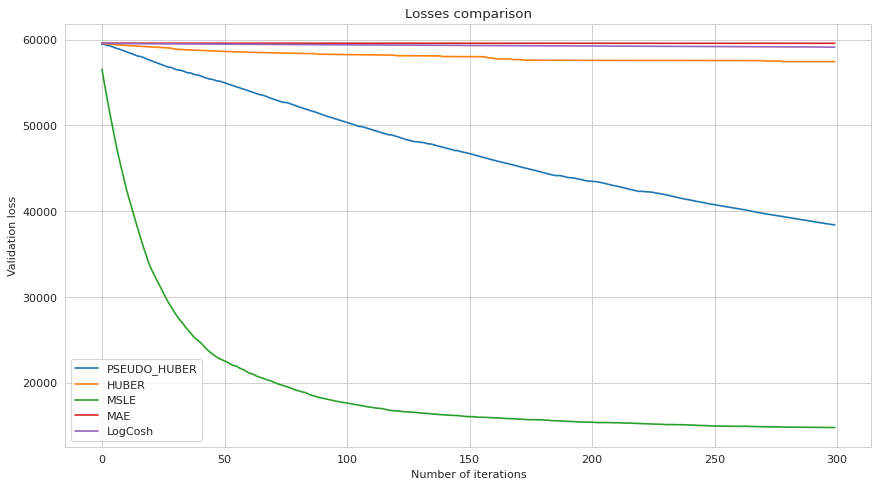

In [17]:
figure(figsize=(13, 7), dpi=80)

legends = ['LogCosh', 'Huber', 'MAE', 'MSLE', 'Pseudo Huber']

plt.xlabel('Number of iterations')
plt.ylabel('Validation loss')
plt.title('Losses comparison')

for key in eval_hist:
    plt.plot(eval_hist[key][:N_STEPS_PLOT], label=key)
    
plt.legend()

In [18]:
test_scores

{'PSEUDO_HUBER': 22817.65,
 'HUBER': 58577.344,
 'MSLE': 16914.023,
 'MAE': 62387.426,
 'LogCosh': 60335.562}

## Deltas

In [19]:
# Load params from file

def load_params(path):
  df = pd.read_csv(path)
  best_df = df[df['value'] == df['value'].min()]

  params_keys = ['delta', 'lambda_l2', 'max_depth', 'subsample', 'colsample']
  best_params = {}

  for key in params_keys:
    best_params[key] = best_df[f'params_{key}'].values[0]
    if type(best_params[key]) is np.float64:
      best_params[key] = float(best_params[key])
    else:
      best_params[key] = int(best_params[key])

  return best_params

In [20]:
# Compute score for one loss and one Dataset

deltas = np.linspace(1, 100, 100)

def take_scores(loss, trials_path, deltas=range(1, 20)):
  best_params = load_params(trials_path)
  scores = []

  for delta in deltas:
    best_params['delta'] = delta
    model, score = model_refit(X_train, y_train, X_val, y_val, X_test, y_test, loss, best_params)

    scores.append(score)

  return scores

In [21]:
# Compute scores for one Dataset

# path = './data/allstate trials/'
path = './data/house prices trials/'
# path = './data/life expectancy trials/'
# path = './data/car prices trials/'

deltas_scores = {}
HUBER_LOSSES = {
    
    'PSEUDO_HUBER': PseudoHuberLoss,
    'HUBER': CustomHuberLoss,  

}

for key in HUBER_LOSSES:
  loss = HUBER_LOSSES[key]
  trials_path = path + key + '_trials.csv'

  deltas_scores[key] = take_scores(loss, trials_path, deltas)

[13:13:18] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:13:18] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:13:18] Iter 0; Sample 0, score = 59570.45461115063; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59570.45461115063; 


[13:13:19] Iter 100; Sample 0, score = 59125.54985751945; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59125.54985751945; 


[13:13:20] Iter 200; Sample 0, score = 58688.94319206808; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58688.94319206808; 


[13:13:21] Iter 300; Sample 0, score = 58225.30109779421; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58225.30109779421; 


[13:13:22] Iter 400; Sample 0, score = 57629.73619695679; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57629.73619695679; 


[13:13:23] Iter 500; Sample 0, score = 57150.29451538223; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57150.29451538223; 


[13:13:24] Iter 600; Sample 0, score = 56700.18510992329; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 56700.18510992329; 


[13:13:25] Iter 700; Sample 0, score = 56314.96669290772; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 56314.96669290772; 


[13:13:26] Iter 800; Sample 0, score = 55984.0102163664; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 55984.0102163664; 


[13:13:27] Iter 900; Sample 0, score = 55616.20629014386; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 55616.20629014386; 


[13:13:27] Iter 1000; Sample 0, score = 55279.29675568097; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 55279.29675568097; 


[13:13:28] Iter 1100; Sample 0, score = 54967.64085346902; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 54967.64085346902; 


[13:13:29] Iter 1200; Sample 0, score = 54637.72072898164; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 54637.72072898164; 


[13:13:30] Iter 1300; Sample 0, score = 54225.83771783917; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 54225.83771783917; 


[13:13:31] Iter 1400; Sample 0, score = 53876.33037401611; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 53876.33037401611; 


[13:13:32] Iter 1500; Sample 0, score = 53537.54805558152; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 53537.54805558152; 


[13:13:33] Iter 1600; Sample 0, score = 53079.5062898304; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 53079.5062898304; 


[13:13:34] Iter 1700; Sample 0, score = 52652.09782606622; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 52652.09782606622; 


[13:13:35] Iter 1800; Sample 0, score = 52275.85302650304; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 52275.85302650304; 


[13:13:36] Iter 1900; Sample 0, score = 51930.30756703168; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 51930.30756703168; 


[13:13:37] Iter 1999; Sample 0, score = 51541.78286627535; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 51541.78286627535; 


[13:13:38] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:13:38] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:13:38] Iter 0; Sample 0, score = 59564.06788798479; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59564.06788798479; 


[13:13:38] Iter 100; Sample 0, score = 58771.49218056457; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58771.49218056457; 


[13:13:40] Iter 200; Sample 0, score = 57715.268771694806; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57715.268771694806; 


[13:13:41] Iter 300; Sample 0, score = 56770.21655928758; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56770.21655928758; 


[13:13:42] Iter 400; Sample 0, score = 55667.129171328874; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 55667.129171328874; 


[13:13:43] Iter 500; Sample 0, score = 54969.298431987976; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 54969.298431987976; 


[13:13:45] Iter 600; Sample 0, score = 53969.50755346089; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 53969.50755346089; 


[13:13:46] Iter 700; Sample 0, score = 53060.726223563004; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 53060.726223563004; 


[13:13:47] Iter 800; Sample 0, score = 52334.256063257984; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 52334.256063257984; 


[13:13:47] Iter 900; Sample 0, score = 51747.81463969891; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 51747.81463969891; 


[13:13:48] Iter 1000; Sample 0, score = 51175.72691465502; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 51175.72691465502; 


[13:13:49] Iter 1100; Sample 0, score = 50534.26632331703; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 50534.26632331703; 


[13:13:50] Iter 1200; Sample 0, score = 49868.50984167686; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 49868.50984167686; 


[13:13:51] Iter 1300; Sample 0, score = 49223.56011265345; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 49223.56011265345; 


[13:13:52] Iter 1400; Sample 0, score = 48601.29930060118; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 48601.29930060118; 


[13:13:52] Iter 1500; Sample 0, score = 48199.794511594235; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 48199.794511594235; 


[13:13:53] Iter 1600; Sample 0, score = 47541.559525101125; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 47541.559525101125; 


[13:13:54] Iter 1700; Sample 0, score = 46939.984793280084; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 46939.984793280084; 


[13:13:56] Iter 1800; Sample 0, score = 46375.474387172995; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 46375.474387172995; 


[13:13:57] Iter 1900; Sample 0, score = 45702.631056844824; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 45702.631056844824; 


[13:13:58] Iter 1999; Sample 0, score = 45100.00329000519; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 45100.00329000519; 


[13:13:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:13:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:13:58] Iter 0; Sample 0, score = 59557.688250032246; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59557.688250032246; 


[13:13:59] Iter 100; Sample 0, score = 58107.482022623764; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58107.482022623764; 


[13:14:00] Iter 200; Sample 0, score = 56677.06050259546; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56677.06050259546; 


[13:14:01] Iter 300; Sample 0, score = 55576.5570294896; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55576.5570294896; 


[13:14:02] Iter 400; Sample 0, score = 54372.571361265254; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 54372.571361265254; 


[13:14:03] Iter 500; Sample 0, score = 52961.81583899227; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 52961.81583899227; 


[13:14:04] Iter 600; Sample 0, score = 51832.81501168633; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 51832.81501168633; 


[13:14:05] Iter 700; Sample 0, score = 50730.79137540873; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 50730.79137540873; 


[13:14:06] Iter 800; Sample 0, score = 49786.746072821974; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 49786.746072821974; 


[13:14:08] Iter 900; Sample 0, score = 48897.48248643963; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 48897.48248643963; 


[13:14:09] Iter 1000; Sample 0, score = 47905.797846146146; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 47905.797846146146; 


[13:14:10] Iter 1100; Sample 0, score = 46884.229770590166; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 46884.229770590166; 


[13:14:11] Iter 1200; Sample 0, score = 46016.2377105764; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 46016.2377105764; 


[13:14:12] Iter 1300; Sample 0, score = 45103.682940481754; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 45103.682940481754; 


[13:14:13] Iter 1400; Sample 0, score = 44320.421295188164; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 44320.421295188164; 


[13:14:14] Iter 1500; Sample 0, score = 43752.71224056822; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 43752.71224056822; 


[13:14:14] Iter 1600; Sample 0, score = 42986.25358808126; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 42986.25358808126; 


[13:14:15] Iter 1700; Sample 0, score = 42243.48061512993; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 42243.48061512993; 


[13:14:16] Iter 1800; Sample 0, score = 41576.459584644464; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 41576.459584644464; 


[13:14:17] Iter 1900; Sample 0, score = 40941.30472863074; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 40941.30472863074; 


[13:14:18] Iter 1999; Sample 0, score = 40379.23850581912; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 40379.23850581912; 


[13:14:19] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:14:19] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:14:19] Iter 0; Sample 0, score = 59551.32390040821; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59551.32390040821; 


[13:14:20] Iter 100; Sample 0, score = 57847.46994467224; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57847.46994467224; 


[13:14:21] Iter 200; Sample 0, score = 55973.141218444754; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55973.141218444754; 


[13:14:22] Iter 300; Sample 0, score = 54249.07973465381; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 54249.07973465381; 


[13:14:23] Iter 400; Sample 0, score = 52742.76166042298; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 52742.76166042298; 


[13:14:24] Iter 500; Sample 0, score = 51206.80407020274; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 51206.80407020274; 


[13:14:25] Iter 600; Sample 0, score = 50118.410504772444; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 50118.410504772444; 


[13:14:26] Iter 700; Sample 0, score = 48857.79758137091; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 48857.79758137091; 


[13:14:27] Iter 800; Sample 0, score = 47569.80381910165; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 47569.80381910165; 


[13:14:28] Iter 900; Sample 0, score = 46169.17402663812; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 46169.17402663812; 


[13:14:29] Iter 1000; Sample 0, score = 45243.76696232392; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 45243.76696232392; 


[13:14:30] Iter 1100; Sample 0, score = 44159.21225252616; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 44159.21225252616; 


[13:14:31] Iter 1200; Sample 0, score = 43041.601842644726; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 43041.601842644726; 


[13:14:33] Iter 1300; Sample 0, score = 42051.54605944128; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 42051.54605944128; 


[13:14:34] Iter 1400; Sample 0, score = 41073.617291404014; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 41073.617291404014; 


[13:14:35] Iter 1500; Sample 0, score = 40327.13529092632; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 40327.13529092632; 


[13:14:36] Iter 1600; Sample 0, score = 39598.20304236963; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 39598.20304236963; 


[13:14:37] Iter 1700; Sample 0, score = 38830.746303359614; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 38830.746303359614; 


[13:14:38] Iter 1800; Sample 0, score = 38151.52384851869; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 38151.52384851869; 


[13:14:39] Iter 1900; Sample 0, score = 37603.21832275089; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 37603.21832275089; 


[13:14:40] Iter 1999; Sample 0, score = 36986.55799476494; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 36986.55799476494; 


[13:14:40] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:14:40] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:14:40] Iter 0; Sample 0, score = 59544.985823953255; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59544.985823953255; 


[13:14:41] Iter 100; Sample 0, score = 57144.0881243105; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57144.0881243105; 


[13:14:42] Iter 200; Sample 0, score = 54867.06795311474; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 54867.06795311474; 


[13:14:44] Iter 300; Sample 0, score = 52824.16057068187; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 52824.16057068187; 


[13:14:48] Iter 400; Sample 0, score = 50838.1748313124; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 50838.1748313124; 


[13:14:49] Iter 500; Sample 0, score = 49223.19881071784; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 49223.19881071784; 


[13:14:51] Iter 600; Sample 0, score = 47541.24163290706; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 47541.24163290706; 


[13:14:52] Iter 700; Sample 0, score = 46109.18915682253; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 46109.18915682253; 


[13:14:53] Iter 800; Sample 0, score = 44564.94003348893; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 44564.94003348893; 


[13:14:54] Iter 900; Sample 0, score = 43275.95583791731; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 43275.95583791731; 


[13:14:55] Iter 1000; Sample 0, score = 42032.80335674326; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 42032.80335674326; 


[13:14:55] Iter 1100; Sample 0, score = 41242.61782917568; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 41242.61782917568; 


[13:14:57] Iter 1200; Sample 0, score = 40131.480959728084; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 40131.480959728084; 


[13:14:58] Iter 1300; Sample 0, score = 38987.58826646595; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 38987.58826646595; 


[13:14:59] Iter 1400; Sample 0, score = 38068.73208270149; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 38068.73208270149; 


[13:15:00] Iter 1500; Sample 0, score = 37118.51891773196; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 37118.51891773196; 


[13:15:01] Iter 1600; Sample 0, score = 36295.00071353164; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 36295.00071353164; 


[13:15:02] Iter 1700; Sample 0, score = 35492.75821675911; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 35492.75821675911; 


[13:15:04] Iter 1800; Sample 0, score = 34792.153393832814; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 34792.153393832814; 


[13:15:05] Iter 1900; Sample 0, score = 34089.49747202599; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 34089.49747202599; 


[13:15:06] Iter 1999; Sample 0, score = 33461.17720979242; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 33461.17720979242; 


[13:15:06] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:15:06] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:15:06] Iter 0; Sample 0, score = 59538.68731350776; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59538.68731350776; 


[13:15:07] Iter 100; Sample 0, score = 56553.19608850183; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56553.19608850183; 


[13:15:08] Iter 200; Sample 0, score = 53909.08446281574; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 53909.08446281574; 


[13:15:10] Iter 300; Sample 0, score = 51577.07809797508; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 51577.07809797508; 


[13:15:11] Iter 400; Sample 0, score = 49212.36443374878; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 49212.36443374878; 


[13:15:12] Iter 500; Sample 0, score = 47142.834626686; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 47142.834626686; 


[13:15:13] Iter 600; Sample 0, score = 45338.730768800604; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 45338.730768800604; 


[13:15:14] Iter 700; Sample 0, score = 43540.10375030791; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 43540.10375030791; 


[13:15:15] Iter 800; Sample 0, score = 42054.610532646126; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 42054.610532646126; 


[13:15:16] Iter 900; Sample 0, score = 40583.511322001475; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 40583.511322001475; 


[13:15:17] Iter 1000; Sample 0, score = 39560.937423454576; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 39560.937423454576; 


[13:15:18] Iter 1100; Sample 0, score = 38326.923001351824; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 38326.923001351824; 


[13:15:19] Iter 1200; Sample 0, score = 37323.18213772068; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 37323.18213772068; 


[13:15:20] Iter 1300; Sample 0, score = 36534.617965799356; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 36534.617965799356; 


[13:15:21] Iter 1400; Sample 0, score = 35637.37640735292; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 35637.37640735292; 


[13:15:22] Iter 1500; Sample 0, score = 34715.62349278169; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 34715.62349278169; 


[13:15:24] Iter 1600; Sample 0, score = 33933.55938630791; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 33933.55938630791; 


[13:15:25] Iter 1700; Sample 0, score = 33311.024161935704; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 33311.024161935704; 


[13:15:26] Iter 1800; Sample 0, score = 32660.74370692437; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 32660.74370692437; 


[13:15:27] Iter 1900; Sample 0, score = 32073.449332451666; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 32073.449332451666; 


[13:15:28] Iter 1999; Sample 0, score = 31600.69323583954; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 31600.69323583954; 


[13:15:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:15:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:15:28] Iter 0; Sample 0, score = 59532.443393678746; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59532.443393678746; 


[13:15:29] Iter 100; Sample 0, score = 56294.540102397; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56294.540102397; 


[13:15:30] Iter 200; Sample 0, score = 53362.332770553025; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 53362.332770553025; 


[13:15:31] Iter 300; Sample 0, score = 50790.534711283784; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 50790.534711283784; 


[13:15:32] Iter 400; Sample 0, score = 48113.098209244316; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 48113.098209244316; 


[13:15:34] Iter 500; Sample 0, score = 45602.936130638765; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 45602.936130638765; 


[13:15:35] Iter 600; Sample 0, score = 43366.76095523741; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 43366.76095523741; 


[13:15:36] Iter 700; Sample 0, score = 41733.22087853391; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 41733.22087853391; 


[13:15:37] Iter 800; Sample 0, score = 39976.72753410913; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 39976.72753410913; 


[13:15:38] Iter 900; Sample 0, score = 38460.382516852595; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 38460.382516852595; 


[13:15:40] Iter 1000; Sample 0, score = 37277.19086126709; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 37277.19086126709; 


[13:15:41] Iter 1100; Sample 0, score = 36091.92854153235; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 36091.92854153235; 


[13:15:42] Iter 1200; Sample 0, score = 35113.87405605875; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 35113.87405605875; 


[13:15:43] Iter 1300; Sample 0, score = 34110.05284213021; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 34110.05284213021; 


[13:15:44] Iter 1400; Sample 0, score = 33233.86242740462; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 33233.86242740462; 


[13:15:45] Iter 1500; Sample 0, score = 32432.087144723377; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 32432.087144723377; 


[13:15:46] Iter 1600; Sample 0, score = 31684.67152399148; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 31684.67152399148; 


[13:15:48] Iter 1700; Sample 0, score = 30976.498224451494; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 30976.498224451494; 


[13:15:49] Iter 1800; Sample 0, score = 30461.269465065994; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 30461.269465065994; 


[13:15:50] Iter 1900; Sample 0, score = 29973.229035399807; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 29973.229035399807; 


[13:15:51] Iter 1999; Sample 0, score = 29516.971215540805; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 29516.971215540805; 


[13:15:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:15:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:15:52] Iter 0; Sample 0, score = 59526.27011952033; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59526.27011952033; 


[13:15:53] Iter 100; Sample 0, score = 55502.23643546974; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 55502.23643546974; 


[13:15:54] Iter 200; Sample 0, score = 52160.90347730751; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52160.90347730751; 


[13:15:55] Iter 300; Sample 0, score = 49346.28956710741; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 49346.28956710741; 


[13:15:56] Iter 400; Sample 0, score = 47002.408213415554; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 47002.408213415554; 


[13:15:57] Iter 500; Sample 0, score = 44330.399354660294; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 44330.399354660294; 


[13:15:58] Iter 600; Sample 0, score = 42270.1142628841; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 42270.1142628841; 


[13:15:59] Iter 700; Sample 0, score = 40409.61186836191; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 40409.61186836191; 


[13:16:00] Iter 800; Sample 0, score = 38659.74355775942; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 38659.74355775942; 


[13:16:02] Iter 900; Sample 0, score = 37070.87311498012; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 37070.87311498012; 


[13:16:03] Iter 1000; Sample 0, score = 35646.063955732934; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 35646.063955732934; 


[13:16:04] Iter 1100; Sample 0, score = 34352.34834319536; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 34352.34834319536; 


[13:16:05] Iter 1200; Sample 0, score = 33300.08917018942; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 33300.08917018942; 


[13:16:06] Iter 1300; Sample 0, score = 32409.713945255076; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 32409.713945255076; 


[13:16:07] Iter 1400; Sample 0, score = 31565.17401611002; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 31565.17401611002; 


[13:16:09] Iter 1500; Sample 0, score = 30853.36563120875; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 30853.36563120875; 


[13:16:10] Iter 1600; Sample 0, score = 30219.212857333834; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 30219.212857333834; 


[13:16:11] Iter 1700; Sample 0, score = 29691.869674925983; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 29691.869674925983; 


[13:16:13] Iter 1800; Sample 0, score = 29220.50358107254; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 29220.50358107254; 


[13:16:13] Iter 1900; Sample 0, score = 28907.76500692621; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 28907.76500692621; 


[13:16:14] Iter 1999; Sample 0, score = 28536.338957331154; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 28536.338957331154; 


[13:16:15] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:16:15] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:16:15] Iter 0; Sample 0, score = 59520.18394099342; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59520.18394099342; 


[13:16:16] Iter 100; Sample 0, score = 55705.931508751455; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 55705.931508751455; 


[13:16:17] Iter 200; Sample 0, score = 52296.934115061864; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52296.934115061864; 


[13:16:18] Iter 300; Sample 0, score = 48603.101223821264; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 48603.101223821264; 


[13:16:19] Iter 400; Sample 0, score = 45608.125613155804; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 45608.125613155804; 


[13:16:20] Iter 500; Sample 0, score = 42889.605745791814; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 42889.605745791814; 


[13:16:21] Iter 600; Sample 0, score = 40636.674105109494; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 40636.674105109494; 


[13:16:22] Iter 700; Sample 0, score = 38542.981428367915; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 38542.981428367915; 


[13:16:24] Iter 800; Sample 0, score = 36736.89453185276; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 36736.89453185276; 


[13:16:25] Iter 900; Sample 0, score = 35287.44031470573; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 35287.44031470573; 


[13:16:26] Iter 1000; Sample 0, score = 33913.777708257614; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 33913.777708257614; 


[13:16:28] Iter 1100; Sample 0, score = 32883.43612423645; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 32883.43612423645; 


[13:16:29] Iter 1200; Sample 0, score = 31984.356693490026; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 31984.356693490026; 


[13:16:30] Iter 1300; Sample 0, score = 31061.308537295317; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 31061.308537295317; 


[13:16:31] Iter 1400; Sample 0, score = 30373.15695505309; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 30373.15695505309; 


[13:16:32] Iter 1500; Sample 0, score = 29682.83346174205; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 29682.83346174205; 


[13:16:33] Iter 1600; Sample 0, score = 29168.380307791795; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 29168.380307791795; 


[13:16:34] Iter 1700; Sample 0, score = 28715.879897861247; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 28715.879897861247; 


[13:16:36] Iter 1800; Sample 0, score = 28285.94150569616; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 28285.94150569616; 


[13:16:37] Iter 1900; Sample 0, score = 27917.483306633825; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 27917.483306633825; 


[13:16:38] Iter 1999; Sample 0, score = 27565.766835585026; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 27565.766835585026; 


[13:16:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:16:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:16:39] Iter 0; Sample 0, score = 59514.20095799112; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59514.20095799112; 


[13:16:40] Iter 100; Sample 0, score = 55039.32625643875; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 55039.32625643875; 


[13:16:41] Iter 200; Sample 0, score = 51008.29639858522; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 51008.29639858522; 


[13:16:42] Iter 300; Sample 0, score = 47412.22138371508; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 47412.22138371508; 


[13:16:43] Iter 400; Sample 0, score = 44075.962071112364; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 44075.962071112364; 


[13:16:44] Iter 500; Sample 0, score = 41317.58158937132; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 41317.58158937132; 


[13:16:45] Iter 600; Sample 0, score = 38751.14034525117; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 38751.14034525117; 


[13:16:46] Iter 700; Sample 0, score = 36732.527771191555; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 36732.527771191555; 


[13:16:48] Iter 800; Sample 0, score = 35027.58948473083; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 35027.58948473083; 


[13:16:49] Iter 900; Sample 0, score = 33609.09570071187; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 33609.09570071187; 


[13:16:51] Iter 1000; Sample 0, score = 32449.181400696816; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 32449.181400696816; 


[13:16:52] Iter 1100; Sample 0, score = 31429.403757613836; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 31429.403757613836; 


[13:16:53] Iter 1200; Sample 0, score = 30548.136526571165; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 30548.136526571165; 


[13:16:54] Iter 1300; Sample 0, score = 29881.726965514335; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 29881.726965514335; 


[13:16:55] Iter 1400; Sample 0, score = 29276.23446031398; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 29276.23446031398; 


[13:16:56] Iter 1500; Sample 0, score = 28659.297726743585; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 28659.297726743585; 


[13:16:57] Iter 1600; Sample 0, score = 28209.7203888431; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 28209.7203888431; 


[13:16:59] Iter 1700; Sample 0, score = 27865.81012966735; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 27865.81012966735; 


[13:17:00] Iter 1800; Sample 0, score = 27354.93733080477; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 27354.93733080477; 


[13:17:02] Iter 1900; Sample 0, score = 26933.487358817452; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 26933.487358817452; 


[13:17:03] Iter 1999; Sample 0, score = 26534.342822369497; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 26534.342822369497; 


[13:17:03] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:17:03] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:17:03] Iter 0; Sample 0, score = 59508.33629671732; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59508.33629671732; 


[13:17:04] Iter 100; Sample 0, score = 54998.29291626901; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54998.29291626901; 


[13:17:06] Iter 200; Sample 0, score = 50305.21628109189; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 50305.21628109189; 


[13:17:07] Iter 300; Sample 0, score = 46609.92349468199; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 46609.92349468199; 


[13:17:08] Iter 400; Sample 0, score = 43114.66350020257; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 43114.66350020257; 


[13:17:09] Iter 500; Sample 0, score = 40390.97115227746; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 40390.97115227746; 


[13:17:10] Iter 600; Sample 0, score = 37909.68088253098; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 37909.68088253098; 


[13:17:11] Iter 700; Sample 0, score = 35918.337058005745; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 35918.337058005745; 


[13:17:13] Iter 800; Sample 0, score = 34115.71369509927; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 34115.71369509927; 


[13:17:14] Iter 900; Sample 0, score = 32679.766887246067; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 32679.766887246067; 


[13:17:15] Iter 1000; Sample 0, score = 31429.725029382644; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 31429.725029382644; 


[13:17:17] Iter 1100; Sample 0, score = 30420.99967810808; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 30420.99967810808; 


[13:17:18] Iter 1200; Sample 0, score = 29621.614189145086; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 29621.614189145086; 


[13:17:19] Iter 1300; Sample 0, score = 28957.945245315528; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 28957.945245315528; 


[13:17:20] Iter 1400; Sample 0, score = 28383.129726618037; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 28383.129726618037; 


[13:17:21] Iter 1500; Sample 0, score = 27838.847359706364; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 27838.847359706364; 


[13:17:23] Iter 1600; Sample 0, score = 27396.093108450594; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 27396.093108450594; 


[13:17:24] Iter 1700; Sample 0, score = 26958.405191127928; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 26958.405191127928; 


[13:17:25] Iter 1800; Sample 0, score = 26589.91122087555; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 26589.91122087555; 


[13:17:27] Iter 1900; Sample 0, score = 26278.701824862426; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 26278.701824862426; 


[13:17:28] Iter 1999; Sample 0, score = 25989.11172492396; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 25989.11172492396; 


[13:17:29] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:17:29] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:17:29] Iter 0; Sample 0, score = 59502.60356203715; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59502.60356203715; 


[13:17:30] Iter 100; Sample 0, score = 53804.66918294581; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53804.66918294581; 


[13:17:31] Iter 200; Sample 0, score = 48918.09912711254; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 48918.09912711254; 


[13:17:32] Iter 300; Sample 0, score = 45149.75463840318; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 45149.75463840318; 


[13:17:33] Iter 400; Sample 0, score = 41301.20844248067; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 41301.20844248067; 


[13:17:34] Iter 500; Sample 0, score = 38340.28437831882; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 38340.28437831882; 


[13:17:36] Iter 600; Sample 0, score = 35998.448710670506; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 35998.448710670506; 


[13:17:37] Iter 700; Sample 0, score = 34050.02345224274; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 34050.02345224274; 


[13:17:39] Iter 800; Sample 0, score = 32543.376416856292; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 32543.376416856292; 


[13:17:40] Iter 900; Sample 0, score = 31275.863335973292; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 31275.863335973292; 


[13:17:41] Iter 1000; Sample 0, score = 30219.222512882847; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 30219.222512882847; 


[13:17:42] Iter 1100; Sample 0, score = 29404.228386928015; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 29404.228386928015; 


[13:17:43] Iter 1200; Sample 0, score = 28713.619183408868; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 28713.619183408868; 


[13:17:45] Iter 1300; Sample 0, score = 28101.91604852108; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 28101.91604852108; 


[13:17:46] Iter 1400; Sample 0, score = 27598.613049781998; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 27598.613049781998; 


[13:17:47] Iter 1500; Sample 0, score = 27126.190649755063; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 27126.190649755063; 


[13:17:48] Iter 1600; Sample 0, score = 26705.838602686847; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 26705.838602686847; 


[13:17:50] Iter 1700; Sample 0, score = 26324.227515711413; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 26324.227515711413; 


[13:17:52] Iter 1800; Sample 0, score = 25977.985638204675; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 25977.985638204675; 


[13:17:53] Iter 1900; Sample 0, score = 25679.616968350885; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 25679.616968350885; 


[13:17:54] Iter 1999; Sample 0, score = 25402.93927015795; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 25402.93927015795; 


[13:17:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:17:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:17:55] Iter 0; Sample 0, score = 59497.01432915223; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59497.01432915223; 


[13:17:56] Iter 100; Sample 0, score = 53715.356995208014; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53715.356995208014; 


[13:17:57] Iter 200; Sample 0, score = 48711.092950891674; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 48711.092950891674; 


[13:17:58] Iter 300; Sample 0, score = 44124.53520937721; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 44124.53520937721; 


[13:17:59] Iter 400; Sample 0, score = 40572.17367430558; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 40572.17367430558; 


[13:18:00] Iter 500; Sample 0, score = 37575.7953108587; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 37575.7953108587; 


[13:18:01] Iter 600; Sample 0, score = 35216.16407364736; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 35216.16407364736; 


[13:18:03] Iter 700; Sample 0, score = 33390.12339202866; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 33390.12339202866; 


[13:18:05] Iter 800; Sample 0, score = 31829.401354398287; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 31829.401354398287; 


[13:18:06] Iter 900; Sample 0, score = 30519.20429622389; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 30519.20429622389; 


[13:18:07] Iter 1000; Sample 0, score = 29462.878318735555; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 29462.878318735555; 


[13:18:08] Iter 1100; Sample 0, score = 28724.230242525176; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 28724.230242525176; 


[13:18:10] Iter 1200; Sample 0, score = 28074.510709631864; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 28074.510709631864; 


[13:18:11] Iter 1300; Sample 0, score = 27530.317592067222; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 27530.317592067222; 


[13:18:12] Iter 1400; Sample 0, score = 26997.63145255059; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 26997.63145255059; 


[13:18:13] Iter 1500; Sample 0, score = 26522.902434513857; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 26522.902434513857; 


[13:18:15] Iter 1600; Sample 0, score = 26097.523592835205; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 26097.523592835205; 


[13:18:17] Iter 1700; Sample 0, score = 25712.00991303945; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 25712.00991303945; 


[13:18:18] Iter 1800; Sample 0, score = 25341.045983654873; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 25341.045983654873; 


[13:18:19] Iter 1900; Sample 0, score = 25010.193675432547; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 25010.193675432547; 


[13:18:21] Iter 1999; Sample 0, score = 24687.72740817172; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 24687.72740817172; 


[13:18:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:18:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:18:21] Iter 0; Sample 0, score = 59491.577947665486; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59491.577947665486; 


[13:18:22] Iter 100; Sample 0, score = 52793.74778699552; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 52793.74778699552; 


[13:18:23] Iter 200; Sample 0, score = 47591.11206469617; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 47591.11206469617; 


[13:18:24] Iter 300; Sample 0, score = 43014.50352693533; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 43014.50352693533; 


[13:18:26] Iter 400; Sample 0, score = 39327.56575296572; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 39327.56575296572; 


[13:18:27] Iter 500; Sample 0, score = 36452.11208792796; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 36452.11208792796; 


[13:18:29] Iter 600; Sample 0, score = 34161.87920445988; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 34161.87920445988; 


[13:18:30] Iter 700; Sample 0, score = 32379.430352349296; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 32379.430352349296; 


[13:18:31] Iter 800; Sample 0, score = 30879.126576593884; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 30879.126576593884; 


[13:18:33] Iter 900; Sample 0, score = 29691.897571500722; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 29691.897571500722; 


[13:18:34] Iter 1000; Sample 0, score = 28809.076633658864; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 28809.076633658864; 


[13:18:35] Iter 1100; Sample 0, score = 28135.465237561624; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 28135.465237561624; 


[13:18:36] Iter 1200; Sample 0, score = 27503.338231502697; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 27503.338231502697; 


[13:18:38] Iter 1300; Sample 0, score = 27003.09756701205; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 27003.09756701205; 


[13:18:39] Iter 1400; Sample 0, score = 26530.04418429077; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 26530.04418429077; 


[13:18:41] Iter 1500; Sample 0, score = 26087.743009666236; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 26087.743009666236; 


[13:18:42] Iter 1600; Sample 0, score = 25627.74276928138; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 25627.74276928138; 


[13:18:44] Iter 1700; Sample 0, score = 25276.053997264105; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 25276.053997264105; 


[13:18:45] Iter 1800; Sample 0, score = 24908.45974852453; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 24908.45974852453; 


[13:18:46] Iter 1900; Sample 0, score = 24559.82995481797; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 24559.82995481797; 


[13:18:48] Iter 1999; Sample 0, score = 24248.412330505125; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 24248.412330505125; 


[13:18:48] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:18:48] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:18:48] Iter 0; Sample 0, score = 59486.30123902182; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59486.30123902182; 


[13:18:49] Iter 100; Sample 0, score = 52632.5899911732; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 52632.5899911732; 


[13:18:50] Iter 200; Sample 0, score = 46947.475700521114; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 46947.475700521114; 


[13:18:52] Iter 300; Sample 0, score = 42030.41925575268; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 42030.41925575268; 


[13:18:54] Iter 400; Sample 0, score = 38348.0843980363; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 38348.0843980363; 


[13:18:55] Iter 500; Sample 0, score = 35586.89284440847; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 35586.89284440847; 


[13:18:56] Iter 600; Sample 0, score = 33314.23655542398; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 33314.23655542398; 


[13:18:57] Iter 700; Sample 0, score = 31589.83960627767; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 31589.83960627767; 


[13:18:59] Iter 800; Sample 0, score = 30163.47725676315; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 30163.47725676315; 


[13:19:00] Iter 900; Sample 0, score = 29184.185074620033; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 29184.185074620033; 


[13:19:01] Iter 1000; Sample 0, score = 28377.677104052196; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 28377.677104052196; 


[13:19:02] Iter 1100; Sample 0, score = 27578.983190742998; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 27578.983190742998; 


[13:19:04] Iter 1200; Sample 0, score = 26939.463942282477; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 26939.463942282477; 


[13:19:06] Iter 1300; Sample 0, score = 26437.474079820524; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 26437.474079820524; 


[13:19:07] Iter 1400; Sample 0, score = 25966.671429740298; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 25966.671429740298; 


[13:19:08] Iter 1500; Sample 0, score = 25532.564023707528; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 25532.564023707528; 


[13:19:10] Iter 1600; Sample 0, score = 25142.58547390387; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 25142.58547390387; 


[13:19:11] Iter 1700; Sample 0, score = 24816.352910668244; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 24816.352910668244; 


[13:19:12] Iter 1800; Sample 0, score = 24490.664829669895; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 24490.664829669895; 


[13:19:14] Iter 1900; Sample 0, score = 24219.238266626293; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 24219.238266626293; 


[13:19:15] Iter 1999; Sample 0, score = 23964.311845178352; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 23964.311845178352; 


[13:19:16] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:19:16] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:19:16] Iter 0; Sample 0, score = 59481.188496720075; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59481.188496720075; 


[13:19:17] Iter 100; Sample 0, score = 51943.67307307724; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51943.67307307724; 


[13:19:18] Iter 200; Sample 0, score = 46148.68633338747; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 46148.68633338747; 


[13:19:19] Iter 300; Sample 0, score = 41198.65592649838; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 41198.65592649838; 


[13:19:21] Iter 400; Sample 0, score = 37513.05516116111; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 37513.05516116111; 


[13:19:22] Iter 500; Sample 0, score = 34584.28237937607; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 34584.28237937607; 


[13:19:23] Iter 600; Sample 0, score = 32287.50557903872; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 32287.50557903872; 


[13:19:24] Iter 700; Sample 0, score = 30695.678992691377; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 30695.678992691377; 


[13:19:26] Iter 800; Sample 0, score = 29523.552640173668; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 29523.552640173668; 


[13:19:27] Iter 900; Sample 0, score = 28558.11173310361; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 28558.11173310361; 


[13:19:28] Iter 1000; Sample 0, score = 27770.82179150745; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 27770.82179150745; 


[13:19:30] Iter 1100; Sample 0, score = 27003.168044317066; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 27003.168044317066; 


[13:19:31] Iter 1200; Sample 0, score = 26355.880369817845; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 26355.880369817845; 


[13:19:33] Iter 1300; Sample 0, score = 25814.48349686155; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 25814.48349686155; 


[13:19:34] Iter 1400; Sample 0, score = 25358.50569295614; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 25358.50569295614; 


[13:19:35] Iter 1500; Sample 0, score = 24999.602089690692; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24999.602089690692; 


[13:19:37] Iter 1600; Sample 0, score = 24645.462031311774; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 24645.462031311774; 


[13:19:38] Iter 1700; Sample 0, score = 24304.18752425258; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 24304.18752425258; 


[13:19:40] Iter 1800; Sample 0, score = 23975.357157253267; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23975.357157253267; 


[13:19:41] Iter 1900; Sample 0, score = 23722.740217538823; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 23722.740217538823; 


[13:19:43] Iter 1999; Sample 0, score = 23421.560051834716; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 23421.560051834716; 


[13:19:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:19:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:19:43] Iter 0; Sample 0, score = 59476.241586611824; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59476.241586611824; 


[13:19:44] Iter 100; Sample 0, score = 51828.45363263349; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51828.45363263349; 


[13:19:46] Iter 200; Sample 0, score = 45316.639778948425; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 45316.639778948425; 


[13:19:47] Iter 300; Sample 0, score = 40073.49207726318; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 40073.49207726318; 


[13:19:48] Iter 400; Sample 0, score = 36576.73126053906; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 36576.73126053906; 


[13:19:49] Iter 500; Sample 0, score = 33790.73275891576; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 33790.73275891576; 


[13:19:51] Iter 600; Sample 0, score = 31774.381348485542; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 31774.381348485542; 


[13:19:52] Iter 700; Sample 0, score = 30277.66687286523; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 30277.66687286523; 


[13:19:54] Iter 800; Sample 0, score = 29094.4979153245; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 29094.4979153245; 


[13:19:55] Iter 900; Sample 0, score = 28100.263949826513; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 28100.263949826513; 


[13:19:57] Iter 1000; Sample 0, score = 27302.32949356926; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 27302.32949356926; 


[13:19:58] Iter 1100; Sample 0, score = 26621.04972934897; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 26621.04972934897; 


[13:19:59] Iter 1200; Sample 0, score = 26019.608523545052; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 26019.608523545052; 


[13:20:01] Iter 1300; Sample 0, score = 25547.612708769353; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 25547.612708769353; 


[13:20:02] Iter 1400; Sample 0, score = 25090.854813918148; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 25090.854813918148; 


[13:20:03] Iter 1500; Sample 0, score = 24768.387827920742; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24768.387827920742; 


[13:20:05] Iter 1600; Sample 0, score = 24452.109304249443; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 24452.109304249443; 


[13:20:07] Iter 1700; Sample 0, score = 24115.600737609766; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 24115.600737609766; 


[13:20:08] Iter 1800; Sample 0, score = 23832.187511943794; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23832.187511943794; 


[13:20:09] Iter 1900; Sample 0, score = 23559.295581182658; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 23559.295581182658; 


[13:20:11] Iter 1999; Sample 0, score = 23303.084246690076; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 23303.084246690076; 


[13:20:11] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:20:11] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:20:11] Iter 0; Sample 0, score = 59471.460002768756; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59471.460002768756; 


[13:20:12] Iter 100; Sample 0, score = 51127.12422473526; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51127.12422473526; 


[13:20:14] Iter 200; Sample 0, score = 44010.91897920565; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 44010.91897920565; 


[13:20:15] Iter 300; Sample 0, score = 39087.4921281667; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 39087.4921281667; 


[13:20:16] Iter 400; Sample 0, score = 35405.647443997645; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 35405.647443997645; 


[13:20:18] Iter 500; Sample 0, score = 32841.243889907346; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 32841.243889907346; 


[13:20:19] Iter 600; Sample 0, score = 30981.64781397819; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 30981.64781397819; 


[13:20:21] Iter 700; Sample 0, score = 29542.989173832637; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 29542.989173832637; 


[13:20:22] Iter 800; Sample 0, score = 28423.55755646843; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 28423.55755646843; 


[13:20:23] Iter 900; Sample 0, score = 27583.37564394551; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 27583.37564394551; 


[13:20:25] Iter 1000; Sample 0, score = 26852.507518261165; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 26852.507518261165; 


[13:20:26] Iter 1100; Sample 0, score = 26217.475266132096; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 26217.475266132096; 


[13:20:27] Iter 1200; Sample 0, score = 25689.720651012507; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 25689.720651012507; 


[13:20:29] Iter 1300; Sample 0, score = 25164.53799008962; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 25164.53799008962; 


[13:20:30] Iter 1400; Sample 0, score = 24764.90450840199; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 24764.90450840199; 


[13:20:32] Iter 1500; Sample 0, score = 24429.409828634907; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24429.409828634907; 


[13:20:34] Iter 1600; Sample 0, score = 24076.507994000716; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 24076.507994000716; 


[13:20:35] Iter 1700; Sample 0, score = 23766.05637766122; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 23766.05637766122; 


[13:20:36] Iter 1800; Sample 0, score = 23485.187740992587; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23485.187740992587; 


[13:20:38] Iter 1900; Sample 0, score = 23238.93081563271; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 23238.93081563271; 


[13:20:39] Iter 1999; Sample 0, score = 22963.743101480308; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 22963.743101480308; 


[13:20:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:20:40] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:20:40] Iter 0; Sample 0, score = 59466.84120673807; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59466.84120673807; 


[13:20:41] Iter 100; Sample 0, score = 50996.037099841524; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50996.037099841524; 


[13:20:42] Iter 200; Sample 0, score = 44015.82369684028; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 44015.82369684028; 


[13:20:43] Iter 300; Sample 0, score = 38948.71089143912; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 38948.71089143912; 


[13:20:45] Iter 400; Sample 0, score = 35179.62176580705; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 35179.62176580705; 


[13:20:46] Iter 500; Sample 0, score = 32491.96327155593; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 32491.96327155593; 


[13:20:47] Iter 600; Sample 0, score = 30623.602696273014; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 30623.602696273014; 


[13:20:49] Iter 700; Sample 0, score = 29216.329536060173; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 29216.329536060173; 


[13:20:50] Iter 800; Sample 0, score = 28181.27965697121; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 28181.27965697121; 


[13:20:51] Iter 900; Sample 0, score = 27266.426509120025; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 27266.426509120025; 


[13:20:53] Iter 1000; Sample 0, score = 26574.05357138923; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 26574.05357138923; 


[13:20:54] Iter 1100; Sample 0, score = 25996.66180453126; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25996.66180453126; 


[13:20:56] Iter 1200; Sample 0, score = 25512.794024602794; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 25512.794024602794; 


[13:20:57] Iter 1300; Sample 0, score = 25083.037105146257; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 25083.037105146257; 


[13:20:59] Iter 1400; Sample 0, score = 24676.92766431764; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 24676.92766431764; 


[13:21:00] Iter 1500; Sample 0, score = 24310.80317576557; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24310.80317576557; 


[13:21:01] Iter 1600; Sample 0, score = 23979.201334804176; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23979.201334804176; 


[13:21:03] Iter 1700; Sample 0, score = 23692.50269576092; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 23692.50269576092; 


[13:21:04] Iter 1800; Sample 0, score = 23414.340636171535; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23414.340636171535; 


[13:21:06] Iter 1900; Sample 0, score = 23126.417446844065; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 23126.417446844065; 


[13:21:07] Iter 1999; Sample 0, score = 22869.64406820425; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 22869.64406820425; 


[13:21:08] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:21:08] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:21:08] Iter 0; Sample 0, score = 59462.380852479204; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59462.380852479204; 


[13:21:09] Iter 100; Sample 0, score = 50386.208924059116; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50386.208924059116; 


[13:21:10] Iter 200; Sample 0, score = 43442.56554618783; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 43442.56554618783; 


[13:21:12] Iter 300; Sample 0, score = 38377.00338816451; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 38377.00338816451; 


[13:21:13] Iter 400; Sample 0, score = 34664.98109517521; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 34664.98109517521; 


[13:21:14] Iter 500; Sample 0, score = 32090.863911035976; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 32090.863911035976; 


[13:21:15] Iter 600; Sample 0, score = 30238.010538921793; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 30238.010538921793; 


[13:21:17] Iter 700; Sample 0, score = 28903.15751222298; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 28903.15751222298; 


[13:21:18] Iter 800; Sample 0, score = 27824.35552985149; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 27824.35552985149; 


[13:21:20] Iter 900; Sample 0, score = 26938.593650714804; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 26938.593650714804; 


[13:21:21] Iter 1000; Sample 0, score = 26219.200720620876; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 26219.200720620876; 


[13:21:23] Iter 1100; Sample 0, score = 25609.802316169174; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25609.802316169174; 


[13:21:24] Iter 1200; Sample 0, score = 25138.062221445387; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 25138.062221445387; 


[13:21:25] Iter 1300; Sample 0, score = 24735.909305692774; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 24735.909305692774; 


[13:21:27] Iter 1400; Sample 0, score = 24370.389093159327; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 24370.389093159327; 


[13:21:28] Iter 1500; Sample 0, score = 24022.681449308384; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 24022.681449308384; 


[13:21:29] Iter 1600; Sample 0, score = 23695.001420771277; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23695.001420771277; 


[13:21:31] Iter 1700; Sample 0, score = 23391.126578769636; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 23391.126578769636; 


[13:21:33] Iter 1800; Sample 0, score = 23108.232224551535; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 23108.232224551535; 


[13:21:34] Iter 1900; Sample 0, score = 22837.823291696637; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22837.823291696637; 


[13:21:36] Iter 1999; Sample 0, score = 22567.83588198108; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 22567.83588198108; 


[13:21:36] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:21:36] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:21:36] Iter 0; Sample 0, score = 59458.073120182395; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59458.073120182395; 


[13:21:37] Iter 100; Sample 0, score = 49873.398210806554; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 49873.398210806554; 


[13:21:38] Iter 200; Sample 0, score = 42064.711709681105; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 42064.711709681105; 


[13:21:40] Iter 300; Sample 0, score = 37056.176689513515; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 37056.176689513515; 


[13:21:41] Iter 400; Sample 0, score = 33445.913604038375; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 33445.913604038375; 


[13:21:42] Iter 500; Sample 0, score = 31154.65356202662; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 31154.65356202662; 


[13:21:44] Iter 600; Sample 0, score = 29473.191389400225; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 29473.191389400225; 


[13:21:46] Iter 700; Sample 0, score = 28228.752052437794; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 28228.752052437794; 


[13:21:47] Iter 800; Sample 0, score = 27209.999794935324; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 27209.999794935324; 


[13:21:48] Iter 900; Sample 0, score = 26398.986491150397; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 26398.986491150397; 


[13:21:50] Iter 1000; Sample 0, score = 25764.689299278052; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 25764.689299278052; 


[13:21:51] Iter 1100; Sample 0, score = 25149.721516660407; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25149.721516660407; 


[13:21:52] Iter 1200; Sample 0, score = 24646.109806112618; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 24646.109806112618; 


[13:21:54] Iter 1300; Sample 0, score = 24199.19574570375; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 24199.19574570375; 


[13:21:55] Iter 1400; Sample 0, score = 23766.570568022227; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 23766.570568022227; 


[13:21:57] Iter 1500; Sample 0, score = 23419.89622240248; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 23419.89622240248; 


[13:21:58] Iter 1600; Sample 0, score = 23086.905898474313; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23086.905898474313; 


[13:22:00] Iter 1700; Sample 0, score = 22790.1644459459; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 22790.1644459459; 


[13:22:01] Iter 1800; Sample 0, score = 22524.90504015519; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 22524.90504015519; 


[13:22:03] Iter 1900; Sample 0, score = 22243.08980417973; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22243.08980417973; 


[13:22:04] Iter 1999; Sample 0, score = 21961.18170602449; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21961.18170602449; 


[13:22:04] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:22:04] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:22:04] Iter 0; Sample 0, score = 59453.9109103374; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59453.9109103374; 


[13:22:06] Iter 100; Sample 0, score = 49632.27277165956; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 49632.27277165956; 


[13:22:07] Iter 200; Sample 0, score = 41921.14345881568; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 41921.14345881568; 


[13:22:08] Iter 300; Sample 0, score = 36749.709897816836; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 36749.709897816836; 


[13:22:10] Iter 400; Sample 0, score = 33179.15173996935; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 33179.15173996935; 


[13:22:11] Iter 500; Sample 0, score = 30826.151905558843; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 30826.151905558843; 


[13:22:13] Iter 600; Sample 0, score = 29188.32141853997; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 29188.32141853997; 


[13:22:14] Iter 700; Sample 0, score = 27966.138461351726; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 27966.138461351726; 


[13:22:15] Iter 800; Sample 0, score = 27044.978284378336; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 27044.978284378336; 


[13:22:17] Iter 900; Sample 0, score = 26280.578761609144; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 26280.578761609144; 


[13:22:18] Iter 1000; Sample 0, score = 25610.006161952257; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 25610.006161952257; 


[13:22:19] Iter 1100; Sample 0, score = 25035.1374206529; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 25035.1374206529; 


[13:22:21] Iter 1200; Sample 0, score = 24569.71761185006; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 24569.71761185006; 


[13:22:22] Iter 1300; Sample 0, score = 24170.82845545332; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 24170.82845545332; 


[13:22:24] Iter 1400; Sample 0, score = 23771.96563058443; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 23771.96563058443; 


[13:22:25] Iter 1500; Sample 0, score = 23432.333708472128; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 23432.333708472128; 


[13:22:27] Iter 1600; Sample 0, score = 23081.959459564765; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 23081.959459564765; 


[13:22:28] Iter 1700; Sample 0, score = 22816.050249778622; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 22816.050249778622; 


[13:22:29] Iter 1800; Sample 0, score = 22549.57910259585; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 22549.57910259585; 


[13:22:31] Iter 1900; Sample 0, score = 22241.683435796065; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22241.683435796065; 


[13:22:32] Iter 1999; Sample 0, score = 21986.97857153237; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21986.97857153237; 


[13:22:33] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:22:33] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:22:33] Iter 0; Sample 0, score = 59449.88638496399; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59449.88638496399; 


[13:22:34] Iter 100; Sample 0, score = 49173.4126936462; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 49173.4126936462; 


[13:22:36] Iter 200; Sample 0, score = 41635.78751404128; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 41635.78751404128; 


[13:22:37] Iter 300; Sample 0, score = 36457.409198530455; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 36457.409198530455; 


[13:22:38] Iter 400; Sample 0, score = 32879.1849178288; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 32879.1849178288; 


[13:22:40] Iter 500; Sample 0, score = 30537.167040220207; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 30537.167040220207; 


[13:22:41] Iter 600; Sample 0, score = 28936.723423962285; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 28936.723423962285; 


[13:22:42] Iter 700; Sample 0, score = 27730.371734832937; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 27730.371734832937; 


[13:22:44] Iter 800; Sample 0, score = 26708.6170729351; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 26708.6170729351; 


[13:22:45] Iter 900; Sample 0, score = 25953.17173695222; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 25953.17173695222; 


[13:22:47] Iter 1000; Sample 0, score = 25362.416481755587; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 25362.416481755587; 


[13:22:48] Iter 1100; Sample 0, score = 24858.286174898985; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 24858.286174898985; 


[13:22:50] Iter 1200; Sample 0, score = 24408.048738286536; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 24408.048738286536; 


[13:22:51] Iter 1300; Sample 0, score = 23972.684951877953; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 23972.684951877953; 


[13:22:52] Iter 1400; Sample 0, score = 23593.208928149445; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 23593.208928149445; 


[13:22:54] Iter 1500; Sample 0, score = 23260.726600302503; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 23260.726600302503; 


[13:22:55] Iter 1600; Sample 0, score = 22956.898075052817; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 22956.898075052817; 


[13:22:57] Iter 1700; Sample 0, score = 22667.943166986235; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 22667.943166986235; 


[13:22:58] Iter 1800; Sample 0, score = 22353.165901121716; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 22353.165901121716; 


[13:23:00] Iter 1900; Sample 0, score = 22075.044069228577; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 22075.044069228577; 


[13:23:01] Iter 1999; Sample 0, score = 21820.303325889396; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21820.303325889396; 


[13:23:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:23:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:23:02] Iter 0; Sample 0, score = 59445.99092869881; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59445.99092869881; 


[13:23:03] Iter 100; Sample 0, score = 48521.28594167623; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 48521.28594167623; 


[13:23:04] Iter 200; Sample 0, score = 40637.98426360402; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 40637.98426360402; 


[13:23:06] Iter 300; Sample 0, score = 35503.958068728214; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 35503.958068728214; 


[13:23:07] Iter 400; Sample 0, score = 32118.55268718981; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 32118.55268718981; 


[13:23:08] Iter 500; Sample 0, score = 29905.2219462936; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 29905.2219462936; 


[13:23:10] Iter 600; Sample 0, score = 28447.784534690654; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 28447.784534690654; 


[13:23:11] Iter 700; Sample 0, score = 27349.310788078303; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 27349.310788078303; 


[13:23:13] Iter 800; Sample 0, score = 26445.281108416108; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 26445.281108416108; 


[13:23:14] Iter 900; Sample 0, score = 25696.533646532775; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 25696.533646532775; 


[13:23:16] Iter 1000; Sample 0, score = 25102.498525634142; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 25102.498525634142; 


[13:23:17] Iter 1100; Sample 0, score = 24580.078413323674; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 24580.078413323674; 


[13:23:18] Iter 1200; Sample 0, score = 24115.936229056486; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 24115.936229056486; 


[13:23:20] Iter 1300; Sample 0, score = 23690.575658066206; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 23690.575658066206; 


[13:23:21] Iter 1400; Sample 0, score = 23330.647067790436; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 23330.647067790436; 


[13:23:22] Iter 1500; Sample 0, score = 22972.4051325316; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 22972.4051325316; 


[13:23:24] Iter 1600; Sample 0, score = 22633.40081823555; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 22633.40081823555; 


[13:23:26] Iter 1700; Sample 0, score = 22329.93768414636; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 22329.93768414636; 


[13:23:27] Iter 1800; Sample 0, score = 22045.131187146842; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 22045.131187146842; 


[13:23:28] Iter 1900; Sample 0, score = 21764.98680161186; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 21764.98680161186; 


[13:23:30] Iter 1999; Sample 0, score = 21492.641712233817; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21492.641712233817; 


[13:23:30] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:23:30] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:23:30] Iter 0; Sample 0, score = 59442.215700736415; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59442.215700736415; 


[13:23:31] Iter 100; Sample 0, score = 48181.008957316866; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 48181.008957316866; 


[13:23:33] Iter 200; Sample 0, score = 40547.48322008252; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 40547.48322008252; 


[13:23:34] Iter 300; Sample 0, score = 35379.16631578179; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 35379.16631578179; 


[13:23:36] Iter 400; Sample 0, score = 31914.200423007675; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 31914.200423007675; 


[13:23:37] Iter 500; Sample 0, score = 29724.487596942414; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 29724.487596942414; 


[13:23:39] Iter 600; Sample 0, score = 28199.212010473555; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 28199.212010473555; 


[13:23:40] Iter 700; Sample 0, score = 26963.58150963351; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 26963.58150963351; 


[13:23:41] Iter 800; Sample 0, score = 26096.088287792194; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 26096.088287792194; 


[13:23:43] Iter 900; Sample 0, score = 25367.665130354668; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 25367.665130354668; 


[13:23:44] Iter 1000; Sample 0, score = 24725.127246994838; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 24725.127246994838; 


[13:23:45] Iter 1100; Sample 0, score = 24175.741029050623; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 24175.741029050623; 


[13:23:47] Iter 1200; Sample 0, score = 23762.515585398953; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 23762.515585398953; 


[13:23:49] Iter 1300; Sample 0, score = 23382.60252809686; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 23382.60252809686; 


[13:23:50] Iter 1400; Sample 0, score = 23013.31980411649; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 23013.31980411649; 


[13:23:52] Iter 1500; Sample 0, score = 22672.460942355534; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 22672.460942355534; 


[13:23:53] Iter 1600; Sample 0, score = 22333.227695948895; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 22333.227695948895; 


[13:23:54] Iter 1700; Sample 0, score = 21994.396169453106; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 21994.396169453106; 


[13:23:56] Iter 1800; Sample 0, score = 21697.283821091456; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 21697.283821091456; 


[13:23:57] Iter 1900; Sample 0, score = 21415.475276349305; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 21415.475276349305; 


[13:23:58] Iter 1999; Sample 0, score = 21171.93030151533; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21171.93030151533; 


[13:23:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:23:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:23:59] Iter 0; Sample 0, score = 59438.55161878798; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59438.55161878798; 


[13:24:00] Iter 100; Sample 0, score = 47503.22776369218; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 47503.22776369218; 


[13:24:02] Iter 200; Sample 0, score = 39575.90366970355; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 39575.90366970355; 


[13:24:03] Iter 300; Sample 0, score = 34510.930336710284; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 34510.930336710284; 


[13:24:05] Iter 400; Sample 0, score = 31296.873854480255; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 31296.873854480255; 


[13:24:06] Iter 500; Sample 0, score = 29327.30700334981; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 29327.30700334981; 


[13:24:07] Iter 600; Sample 0, score = 27984.542944564077; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 27984.542944564077; 


[13:24:09] Iter 700; Sample 0, score = 26907.01489196403; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 26907.01489196403; 


[13:24:10] Iter 800; Sample 0, score = 26179.31965969462; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 26179.31965969462; 


[13:24:11] Iter 900; Sample 0, score = 25496.71007727636; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 25496.71007727636; 


[13:24:13] Iter 1000; Sample 0, score = 24935.924575821715; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 24935.924575821715; 


[13:24:15] Iter 1100; Sample 0, score = 24447.467916704994; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 24447.467916704994; 


[13:24:16] Iter 1200; Sample 0, score = 24033.27044814381; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 24033.27044814381; 


[13:24:17] Iter 1300; Sample 0, score = 23622.00944758098; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 23622.00944758098; 


[13:24:19] Iter 1400; Sample 0, score = 23241.772393776067; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 23241.772393776067; 


[13:24:20] Iter 1500; Sample 0, score = 22935.14524901126; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 22935.14524901126; 


[13:24:22] Iter 1600; Sample 0, score = 22626.80549807138; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 22626.80549807138; 


[13:24:23] Iter 1700; Sample 0, score = 22287.56056073446; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 22287.56056073446; 


[13:24:24] Iter 1800; Sample 0, score = 21969.9081800805; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 21969.9081800805; 


[13:24:26] Iter 1900; Sample 0, score = 21671.74408460252; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 21671.74408460252; 


[13:24:28] Iter 1999; Sample 0, score = 21427.241521402128; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21427.241521402128; 


[13:24:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:24:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:24:28] Iter 0; Sample 0, score = 59434.98970701756; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59434.98970701756; 


[13:24:29] Iter 100; Sample 0, score = 47000.7567395815; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 47000.7567395815; 


[13:24:31] Iter 200; Sample 0, score = 38852.96746574269; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 38852.96746574269; 


[13:24:32] Iter 300; Sample 0, score = 33843.397384167176; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 33843.397384167176; 


[13:24:33] Iter 400; Sample 0, score = 30730.963427319923; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 30730.963427319923; 


[13:24:34] Iter 500; Sample 0, score = 28809.943602082858; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 28809.943602082858; 


[13:24:36] Iter 600; Sample 0, score = 27522.405798875356; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 27522.405798875356; 


[13:24:38] Iter 700; Sample 0, score = 26545.990759993958; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 26545.990759993958; 


[13:24:39] Iter 800; Sample 0, score = 25779.525534684723; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 25779.525534684723; 


[13:24:41] Iter 900; Sample 0, score = 25103.020932424068; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 25103.020932424068; 


[13:24:42] Iter 1000; Sample 0, score = 24554.61529454125; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 24554.61529454125; 


[13:24:44] Iter 1100; Sample 0, score = 24040.486999504978; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 24040.486999504978; 


[13:24:45] Iter 1200; Sample 0, score = 23635.81550822468; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 23635.81550822468; 


[13:24:46] Iter 1300; Sample 0, score = 23263.75916426745; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 23263.75916426745; 


[13:24:48] Iter 1400; Sample 0, score = 22910.067731293682; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 22910.067731293682; 


[13:24:49] Iter 1500; Sample 0, score = 22547.243904603296; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 22547.243904603296; 


[13:24:51] Iter 1600; Sample 0, score = 22237.66809927252; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 22237.66809927252; 


[13:24:52] Iter 1700; Sample 0, score = 21959.113621444605; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 21959.113621444605; 


[13:24:54] Iter 1800; Sample 0, score = 21682.044594748233; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 21682.044594748233; 


[13:24:55] Iter 1900; Sample 0, score = 21415.038623574623; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 21415.038623574623; 


[13:24:56] Iter 1999; Sample 0, score = 21184.809777366605; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21184.809777366605; 


[13:24:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:24:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:24:57] Iter 0; Sample 0, score = 59431.52109980787; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59431.52109980787; 


[13:24:58] Iter 100; Sample 0, score = 47132.50377414207; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 47132.50377414207; 


[13:24:59] Iter 200; Sample 0, score = 38776.67660716996; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 38776.67660716996; 


[13:25:01] Iter 300; Sample 0, score = 33753.563758199416; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 33753.563758199416; 


[13:25:02] Iter 400; Sample 0, score = 30718.68329736592; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 30718.68329736592; 


[13:25:04] Iter 500; Sample 0, score = 28848.956615083018; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 28848.956615083018; 


[13:25:05] Iter 600; Sample 0, score = 27518.16523441459; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 27518.16523441459; 


[13:25:07] Iter 700; Sample 0, score = 26520.509169155255; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 26520.509169155255; 


[13:25:08] Iter 800; Sample 0, score = 25684.041929978837; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 25684.041929978837; 


[13:25:09] Iter 900; Sample 0, score = 25046.035359867754; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 25046.035359867754; 


[13:25:11] Iter 1000; Sample 0, score = 24478.97676039643; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 24478.97676039643; 


[13:25:12] Iter 1100; Sample 0, score = 23989.33372620845; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 23989.33372620845; 


[13:25:14] Iter 1200; Sample 0, score = 23525.862565803887; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 23525.862565803887; 


[13:25:16] Iter 1300; Sample 0, score = 23118.095200782576; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 23118.095200782576; 


[13:25:17] Iter 1400; Sample 0, score = 22723.983636175468; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 22723.983636175468; 


[13:25:18] Iter 1500; Sample 0, score = 22355.76775671602; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 22355.76775671602; 


[13:25:20] Iter 1600; Sample 0, score = 22017.413991896054; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 22017.413991896054; 


[13:25:21] Iter 1700; Sample 0, score = 21764.700890341242; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 21764.700890341242; 


[13:25:23] Iter 1800; Sample 0, score = 21507.166912903795; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 21507.166912903795; 


[13:25:24] Iter 1900; Sample 0, score = 21266.411472497424; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 21266.411472497424; 


[13:25:25] Iter 1999; Sample 0, score = 21059.10071707892; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 21059.10071707892; 


[13:25:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:25:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:25:26] Iter 0; Sample 0, score = 59428.13728792239; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59428.13728792239; 


[13:25:27] Iter 100; Sample 0, score = 46750.010045084055; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 46750.010045084055; 


[13:25:29] Iter 200; Sample 0, score = 38211.987217566406; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 38211.987217566406; 


[13:25:30] Iter 300; Sample 0, score = 33166.998397196105; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 33166.998397196105; 


[13:25:32] Iter 400; Sample 0, score = 30157.436038613036; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 30157.436038613036; 


[13:25:33] Iter 500; Sample 0, score = 28343.967198731825; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 28343.967198731825; 


[13:25:35] Iter 600; Sample 0, score = 26981.77073403825; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26981.77073403825; 


[13:25:36] Iter 700; Sample 0, score = 25962.701076554466; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25962.701076554466; 


[13:25:37] Iter 800; Sample 0, score = 25205.048949813136; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 25205.048949813136; 


[13:25:39] Iter 900; Sample 0, score = 24585.3973589458; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 24585.3973589458; 


[13:25:41] Iter 1000; Sample 0, score = 24014.61732598502; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 24014.61732598502; 


[13:25:42] Iter 1100; Sample 0, score = 23536.64187773667; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 23536.64187773667; 


[13:25:44] Iter 1200; Sample 0, score = 23093.677273498863; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 23093.677273498863; 


[13:25:45] Iter 1300; Sample 0, score = 22707.380357926926; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22707.380357926926; 


[13:25:46] Iter 1400; Sample 0, score = 22347.18369421176; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 22347.18369421176; 


[13:25:48] Iter 1500; Sample 0, score = 21988.21845631925; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21988.21845631925; 


[13:25:49] Iter 1600; Sample 0, score = 21645.787732834702; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21645.787732834702; 


[13:25:51] Iter 1700; Sample 0, score = 21357.48962003366; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 21357.48962003366; 


[13:25:53] Iter 1800; Sample 0, score = 21096.89331368056; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 21096.89331368056; 


[13:25:54] Iter 1900; Sample 0, score = 20859.408452866544; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20859.408452866544; 


[13:25:56] Iter 1999; Sample 0, score = 20628.505257801524; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20628.505257801524; 


[13:25:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:25:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:25:56] Iter 0; Sample 0, score = 59424.83006017636; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59424.83006017636; 


[13:25:57] Iter 100; Sample 0, score = 46290.710172812185; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 46290.710172812185; 


[13:25:59] Iter 200; Sample 0, score = 37673.99414942473; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 37673.99414942473; 


[13:26:00] Iter 300; Sample 0, score = 32835.86775567779; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 32835.86775567779; 


[13:26:01] Iter 400; Sample 0, score = 29846.826399596335; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 29846.826399596335; 


[13:26:03] Iter 500; Sample 0, score = 28113.382669789175; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 28113.382669789175; 


[13:26:05] Iter 600; Sample 0, score = 26856.284996217168; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26856.284996217168; 


[13:26:06] Iter 700; Sample 0, score = 25820.77231298703; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25820.77231298703; 


[13:26:08] Iter 800; Sample 0, score = 25012.801578848703; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 25012.801578848703; 


[13:26:09] Iter 900; Sample 0, score = 24385.836557584986; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 24385.836557584986; 


[13:26:10] Iter 1000; Sample 0, score = 23842.356117588726; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23842.356117588726; 


[13:26:12] Iter 1100; Sample 0, score = 23372.207995146677; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 23372.207995146677; 


[13:26:13] Iter 1200; Sample 0, score = 22909.48899687001; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22909.48899687001; 


[13:26:15] Iter 1300; Sample 0, score = 22483.265720385396; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22483.265720385396; 


[13:26:16] Iter 1400; Sample 0, score = 22128.624290838718; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 22128.624290838718; 


[13:26:18] Iter 1500; Sample 0, score = 21761.72241342335; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21761.72241342335; 


[13:26:19] Iter 1600; Sample 0, score = 21437.410629879716; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21437.410629879716; 


[13:26:21] Iter 1700; Sample 0, score = 21193.51894406; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 21193.51894406; 


[13:26:22] Iter 1800; Sample 0, score = 20952.391389297212; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20952.391389297212; 


[13:26:24] Iter 1900; Sample 0, score = 20724.406183240946; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20724.406183240946; 


[13:26:25] Iter 1999; Sample 0, score = 20510.66206592885; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20510.66206592885; 


[13:26:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:26:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:26:25] Iter 0; Sample 0, score = 59421.59173833407; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59421.59173833407; 


[13:26:27] Iter 100; Sample 0, score = 45738.21095034734; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 45738.21095034734; 


[13:26:28] Iter 200; Sample 0, score = 37417.35926631349; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 37417.35926631349; 


[13:26:30] Iter 300; Sample 0, score = 32700.934061420023; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 32700.934061420023; 


[13:26:31] Iter 400; Sample 0, score = 29626.314758864824; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 29626.314758864824; 


[13:26:33] Iter 500; Sample 0, score = 27858.54390862529; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27858.54390862529; 


[13:26:34] Iter 600; Sample 0, score = 26611.389774583986; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26611.389774583986; 


[13:26:36] Iter 700; Sample 0, score = 25639.916213875873; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25639.916213875873; 


[13:26:37] Iter 800; Sample 0, score = 24922.63055615003; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24922.63055615003; 


[13:26:38] Iter 900; Sample 0, score = 24256.841595436803; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 24256.841595436803; 


[13:26:40] Iter 1000; Sample 0, score = 23725.019244026927; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23725.019244026927; 


[13:26:41] Iter 1100; Sample 0, score = 23214.968585461855; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 23214.968585461855; 


[13:26:43] Iter 1200; Sample 0, score = 22796.992848580674; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22796.992848580674; 


[13:26:44] Iter 1300; Sample 0, score = 22367.033577311493; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22367.033577311493; 


[13:26:46] Iter 1400; Sample 0, score = 21992.922976590235; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21992.922976590235; 


[13:26:47] Iter 1500; Sample 0, score = 21682.80692758516; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21682.80692758516; 


[13:26:49] Iter 1600; Sample 0, score = 21395.651149721874; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21395.651149721874; 


[13:26:50] Iter 1700; Sample 0, score = 21119.828676637047; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 21119.828676637047; 


[13:26:51] Iter 1800; Sample 0, score = 20884.46015582112; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20884.46015582112; 


[13:26:53] Iter 1900; Sample 0, score = 20678.82982682918; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20678.82982682918; 


[13:26:54] Iter 1999; Sample 0, score = 20503.710045478638; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20503.710045478638; 


[13:26:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:26:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:26:55] Iter 0; Sample 0, score = 59418.41503580208; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59418.41503580208; 


[13:26:56] Iter 100; Sample 0, score = 44937.70866102216; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 44937.70866102216; 


[13:26:58] Iter 200; Sample 0, score = 36610.73011379248; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 36610.73011379248; 


[13:26:59] Iter 300; Sample 0, score = 32003.210205264026; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 32003.210205264026; 


[13:27:00] Iter 400; Sample 0, score = 29282.632248105154; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 29282.632248105154; 


[13:27:02] Iter 500; Sample 0, score = 27483.0190912842; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27483.0190912842; 


[13:27:03] Iter 600; Sample 0, score = 26149.39924286906; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26149.39924286906; 


[13:27:05] Iter 700; Sample 0, score = 25255.431497151498; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25255.431497151498; 


[13:27:06] Iter 800; Sample 0, score = 24528.87174726986; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24528.87174726986; 


[13:27:08] Iter 900; Sample 0, score = 23924.15438333838; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23924.15438333838; 


[13:27:09] Iter 1000; Sample 0, score = 23381.686648323546; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23381.686648323546; 


[13:27:11] Iter 1100; Sample 0, score = 22930.266120928543; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22930.266120928543; 


[13:27:12] Iter 1200; Sample 0, score = 22511.638058241955; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22511.638058241955; 


[13:27:14] Iter 1300; Sample 0, score = 22125.723152495113; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22125.723152495113; 


[13:27:15] Iter 1400; Sample 0, score = 21794.32681967986; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21794.32681967986; 


[13:27:16] Iter 1500; Sample 0, score = 21478.260123719123; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21478.260123719123; 


[13:27:18] Iter 1600; Sample 0, score = 21182.44872081355; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21182.44872081355; 


[13:27:20] Iter 1700; Sample 0, score = 20977.96456040976; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20977.96456040976; 


[13:27:21] Iter 1800; Sample 0, score = 20799.663450071166; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20799.663450071166; 


[13:27:23] Iter 1900; Sample 0, score = 20612.148006843203; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20612.148006843203; 


[13:27:24] Iter 1999; Sample 0, score = 20422.749429273317; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20422.749429273317; 


[13:27:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:27:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:27:24] Iter 0; Sample 0, score = 59415.2931720375; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59415.2931720375; 


[13:27:26] Iter 100; Sample 0, score = 44662.22830508846; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 44662.22830508846; 


[13:27:27] Iter 200; Sample 0, score = 36084.90359041644; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 36084.90359041644; 


[13:27:28] Iter 300; Sample 0, score = 31467.42375789363; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 31467.42375789363; 


[13:27:30] Iter 400; Sample 0, score = 28960.233445651313; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28960.233445651313; 


[13:27:31] Iter 500; Sample 0, score = 27205.945001353713; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27205.945001353713; 


[13:27:33] Iter 600; Sample 0, score = 25939.52955369918; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25939.52955369918; 


[13:27:34] Iter 700; Sample 0, score = 25000.735589803226; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25000.735589803226; 


[13:27:36] Iter 800; Sample 0, score = 24280.41668466551; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24280.41668466551; 


[13:27:37] Iter 900; Sample 0, score = 23745.729605317163; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23745.729605317163; 


[13:27:39] Iter 1000; Sample 0, score = 23265.918810683812; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23265.918810683812; 


[13:27:40] Iter 1100; Sample 0, score = 22819.65913127554; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22819.65913127554; 


[13:27:41] Iter 1200; Sample 0, score = 22379.39571911922; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22379.39571911922; 


[13:27:43] Iter 1300; Sample 0, score = 22002.062271237974; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22002.062271237974; 


[13:27:45] Iter 1400; Sample 0, score = 21713.406018080273; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21713.406018080273; 


[13:27:46] Iter 1500; Sample 0, score = 21433.406505793973; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21433.406505793973; 


[13:27:47] Iter 1600; Sample 0, score = 21151.093611543358; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21151.093611543358; 


[13:27:49] Iter 1700; Sample 0, score = 20893.083285347067; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20893.083285347067; 


[13:27:50] Iter 1800; Sample 0, score = 20649.204095819576; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20649.204095819576; 


[13:27:52] Iter 1900; Sample 0, score = 20461.948299853742; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20461.948299853742; 


[13:27:53] Iter 1999; Sample 0, score = 20274.881777015595; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20274.881777015595; 


[13:27:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:27:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:27:53] Iter 0; Sample 0, score = 59412.21993511559; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59412.21993511559; 


[13:27:55] Iter 100; Sample 0, score = 44307.46083565587; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 44307.46083565587; 


[13:27:56] Iter 200; Sample 0, score = 35814.52793262276; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 35814.52793262276; 


[13:27:58] Iter 300; Sample 0, score = 31365.45380014968; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 31365.45380014968; 


[13:27:59] Iter 400; Sample 0, score = 28781.068050010887; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28781.068050010887; 


[13:28:01] Iter 500; Sample 0, score = 27166.13701099522; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27166.13701099522; 


[13:28:02] Iter 600; Sample 0, score = 26085.24349152102; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26085.24349152102; 


[13:28:04] Iter 700; Sample 0, score = 25161.423559185227; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25161.423559185227; 


[13:28:05] Iter 800; Sample 0, score = 24476.10173273575; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24476.10173273575; 


[13:28:06] Iter 900; Sample 0, score = 23872.98180173838; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23872.98180173838; 


[13:28:08] Iter 1000; Sample 0, score = 23361.555360217342; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23361.555360217342; 


[13:28:10] Iter 1100; Sample 0, score = 22915.926663016784; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22915.926663016784; 


[13:28:11] Iter 1200; Sample 0, score = 22475.315055035935; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22475.315055035935; 


[13:28:12] Iter 1300; Sample 0, score = 22063.087150518993; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22063.087150518993; 


[13:28:14] Iter 1400; Sample 0, score = 21705.156290679206; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21705.156290679206; 


[13:28:15] Iter 1500; Sample 0, score = 21411.50407052887; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21411.50407052887; 


[13:28:17] Iter 1600; Sample 0, score = 21138.831016590902; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21138.831016590902; 


[13:28:18] Iter 1700; Sample 0, score = 20921.01875181263; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20921.01875181263; 


[13:28:19] Iter 1800; Sample 0, score = 20690.649812776228; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20690.649812776228; 


[13:28:21] Iter 1900; Sample 0, score = 20496.81810904721; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20496.81810904721; 


[13:28:23] Iter 1999; Sample 0, score = 20310.581015351832; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20310.581015351832; 


[13:28:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:28:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:28:23] Iter 0; Sample 0, score = 59409.189537162456; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59409.189537162456; 


[13:28:25] Iter 100; Sample 0, score = 44136.53141720575; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 44136.53141720575; 


[13:28:26] Iter 200; Sample 0, score = 35784.572426444174; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 35784.572426444174; 


[13:28:27] Iter 300; Sample 0, score = 31279.147468339474; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 31279.147468339474; 


[13:28:29] Iter 400; Sample 0, score = 28770.965297894436; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28770.965297894436; 


[13:28:30] Iter 500; Sample 0, score = 27105.341831800848; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27105.341831800848; 


[13:28:31] Iter 600; Sample 0, score = 26016.33538305401; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26016.33538305401; 


[13:28:33] Iter 700; Sample 0, score = 25155.453262403465; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25155.453262403465; 


[13:28:35] Iter 800; Sample 0, score = 24505.81379030364; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24505.81379030364; 


[13:28:36] Iter 900; Sample 0, score = 23858.61987425812; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23858.61987425812; 


[13:28:38] Iter 1000; Sample 0, score = 23307.357070703776; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23307.357070703776; 


[13:28:39] Iter 1100; Sample 0, score = 22761.786374081046; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22761.786374081046; 


[13:28:40] Iter 1200; Sample 0, score = 22275.154470643098; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22275.154470643098; 


[13:28:42] Iter 1300; Sample 0, score = 21873.86814688698; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21873.86814688698; 


[13:28:43] Iter 1400; Sample 0, score = 21546.253698848755; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21546.253698848755; 


[13:28:45] Iter 1500; Sample 0, score = 21273.038579056065; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21273.038579056065; 


[13:28:47] Iter 1600; Sample 0, score = 21041.767506389497; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21041.767506389497; 


[13:28:48] Iter 1700; Sample 0, score = 20847.735150558565; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20847.735150558565; 


[13:28:49] Iter 1800; Sample 0, score = 20647.590946613273; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20647.590946613273; 


[13:28:51] Iter 1900; Sample 0, score = 20474.428090680016; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20474.428090680016; 


[13:28:52] Iter 1999; Sample 0, score = 20276.882933379882; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20276.882933379882; 


[13:28:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:28:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:28:52] Iter 0; Sample 0, score = 59406.19672423143; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59406.19672423143; 


[13:28:54] Iter 100; Sample 0, score = 43670.83347997528; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 43670.83347997528; 


[13:28:55] Iter 200; Sample 0, score = 35229.83333874789; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 35229.83333874789; 


[13:28:57] Iter 300; Sample 0, score = 30880.340418133812; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30880.340418133812; 


[13:28:58] Iter 400; Sample 0, score = 28632.44304579576; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28632.44304579576; 


[13:29:00] Iter 500; Sample 0, score = 26987.783968256063; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26987.783968256063; 


[13:29:01] Iter 600; Sample 0, score = 25839.631817561025; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25839.631817561025; 


[13:29:03] Iter 700; Sample 0, score = 25022.63196386084; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25022.63196386084; 


[13:29:04] Iter 800; Sample 0, score = 24424.308376998386; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24424.308376998386; 


[13:29:05] Iter 900; Sample 0, score = 23827.61024280096; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23827.61024280096; 


[13:29:07] Iter 1000; Sample 0, score = 23304.15591836193; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23304.15591836193; 


[13:29:08] Iter 1100; Sample 0, score = 22860.766277112194; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22860.766277112194; 


[13:29:10] Iter 1200; Sample 0, score = 22453.827107462013; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22453.827107462013; 


[13:29:12] Iter 1300; Sample 0, score = 22070.922312019196; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 22070.922312019196; 


[13:29:13] Iter 1400; Sample 0, score = 21729.086238562475; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21729.086238562475; 


[13:29:14] Iter 1500; Sample 0, score = 21397.66049407499; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 21397.66049407499; 


[13:29:16] Iter 1600; Sample 0, score = 21108.52066882869; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 21108.52066882869; 


[13:29:17] Iter 1700; Sample 0, score = 20860.67187331133; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20860.67187331133; 


[13:29:19] Iter 1800; Sample 0, score = 20626.4999505467; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20626.4999505467; 


[13:29:20] Iter 1900; Sample 0, score = 20396.34945605991; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20396.34945605991; 


[13:29:21] Iter 1999; Sample 0, score = 20214.867843871052; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 20214.867843871052; 


[13:29:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:29:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:29:22] Iter 0; Sample 0, score = 59403.236655602086; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59403.236655602086; 


[13:29:24] Iter 100; Sample 0, score = 43943.7004360959; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 43943.7004360959; 


[13:29:25] Iter 200; Sample 0, score = 35106.763753269624; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 35106.763753269624; 


[13:29:26] Iter 300; Sample 0, score = 30671.039643967477; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30671.039643967477; 


[13:29:28] Iter 400; Sample 0, score = 28205.847500083535; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28205.847500083535; 


[13:29:29] Iter 500; Sample 0, score = 26565.471855303604; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26565.471855303604; 


[13:29:31] Iter 600; Sample 0, score = 25380.97624939848; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25380.97624939848; 


[13:29:32] Iter 700; Sample 0, score = 24541.783771697614; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24541.783771697614; 


[13:29:33] Iter 800; Sample 0, score = 23825.195000135882; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23825.195000135882; 


[13:29:35] Iter 900; Sample 0, score = 23167.43816674606; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23167.43816674606; 


[13:29:37] Iter 1000; Sample 0, score = 22645.541803741206; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22645.541803741206; 


[13:29:38] Iter 1100; Sample 0, score = 22182.785109605462; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22182.785109605462; 


[13:29:40] Iter 1200; Sample 0, score = 21748.79266911023; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21748.79266911023; 


[13:29:41] Iter 1300; Sample 0, score = 21395.800160010604; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21395.800160010604; 


[13:29:43] Iter 1400; Sample 0, score = 21102.03418942207; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21102.03418942207; 


[13:29:44] Iter 1500; Sample 0, score = 20816.268282779933; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20816.268282779933; 


[13:29:45] Iter 1600; Sample 0, score = 20593.802727169343; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20593.802727169343; 


[13:29:47] Iter 1700; Sample 0, score = 20407.933985508193; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20407.933985508193; 


[13:29:49] Iter 1800; Sample 0, score = 20247.324392569262; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20247.324392569262; 


[13:29:50] Iter 1900; Sample 0, score = 20055.043017230797; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20055.043017230797; 


[13:29:52] Iter 1999; Sample 0, score = 19890.454316365584; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19890.454316365584; 


[13:29:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:29:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:29:52] Iter 0; Sample 0, score = 59400.30499404516; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59400.30499404516; 


[13:29:53] Iter 100; Sample 0, score = 43348.43803423672; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 43348.43803423672; 


[13:29:55] Iter 200; Sample 0, score = 34789.11028273185; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34789.11028273185; 


[13:29:56] Iter 300; Sample 0, score = 30576.0215618831; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30576.0215618831; 


[13:29:58] Iter 400; Sample 0, score = 28226.811523359116; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28226.811523359116; 


[13:29:59] Iter 500; Sample 0, score = 26639.241658976665; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26639.241658976665; 


[13:30:01] Iter 600; Sample 0, score = 25435.54797592617; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25435.54797592617; 


[13:30:02] Iter 700; Sample 0, score = 24637.611586232066; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24637.611586232066; 


[13:30:04] Iter 800; Sample 0, score = 23983.09820739315; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23983.09820739315; 


[13:30:05] Iter 900; Sample 0, score = 23411.073709500517; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23411.073709500517; 


[13:30:07] Iter 1000; Sample 0, score = 22859.767511360653; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22859.767511360653; 


[13:30:08] Iter 1100; Sample 0, score = 22366.034423880203; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22366.034423880203; 


[13:30:09] Iter 1200; Sample 0, score = 21911.876768988473; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21911.876768988473; 


[13:30:11] Iter 1300; Sample 0, score = 21515.42358031026; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21515.42358031026; 


[13:30:13] Iter 1400; Sample 0, score = 21196.753470282398; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21196.753470282398; 


[13:30:14] Iter 1500; Sample 0, score = 20882.32965129633; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20882.32965129633; 


[13:30:16] Iter 1600; Sample 0, score = 20633.817646506664; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20633.817646506664; 


[13:30:17] Iter 1700; Sample 0, score = 20415.0370082264; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20415.0370082264; 


[13:30:18] Iter 1800; Sample 0, score = 20208.855956527528; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20208.855956527528; 


[13:30:20] Iter 1900; Sample 0, score = 20022.88540940598; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 20022.88540940598; 


[13:30:21] Iter 1999; Sample 0, score = 19834.31727143125; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19834.31727143125; 


[13:30:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:30:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:30:22] Iter 0; Sample 0, score = 59397.397791283765; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59397.397791283765; 


[13:30:23] Iter 100; Sample 0, score = 42515.82405153626; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 42515.82405153626; 


[13:30:25] Iter 200; Sample 0, score = 34409.11525267993; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34409.11525267993; 


[13:30:26] Iter 300; Sample 0, score = 30194.209345272266; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30194.209345272266; 


[13:30:28] Iter 400; Sample 0, score = 28010.91559739934; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28010.91559739934; 


[13:30:29] Iter 500; Sample 0, score = 26298.522052951237; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26298.522052951237; 


[13:30:30] Iter 600; Sample 0, score = 25236.64555091181; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25236.64555091181; 


[13:30:32] Iter 700; Sample 0, score = 24444.481958630797; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24444.481958630797; 


[13:30:33] Iter 800; Sample 0, score = 23813.6744340994; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23813.6744340994; 


[13:30:35] Iter 900; Sample 0, score = 23207.127746427344; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23207.127746427344; 


[13:30:36] Iter 1000; Sample 0, score = 22679.638894359; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22679.638894359; 


[13:30:38] Iter 1100; Sample 0, score = 22163.110681804304; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22163.110681804304; 


[13:30:39] Iter 1200; Sample 0, score = 21758.690402761666; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21758.690402761666; 


[13:30:41] Iter 1300; Sample 0, score = 21380.83950461854; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21380.83950461854; 


[13:30:42] Iter 1400; Sample 0, score = 21091.236749423653; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21091.236749423653; 


[13:30:44] Iter 1500; Sample 0, score = 20829.351822367305; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20829.351822367305; 


[13:30:45] Iter 1600; Sample 0, score = 20589.479762044633; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20589.479762044633; 


[13:30:46] Iter 1700; Sample 0, score = 20365.35627537297; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20365.35627537297; 


[13:30:48] Iter 1800; Sample 0, score = 20149.412992858048; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20149.412992858048; 


[13:30:50] Iter 1900; Sample 0, score = 19946.907140925414; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19946.907140925414; 


[13:30:51] Iter 1999; Sample 0, score = 19746.86748031452; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19746.86748031452; 


[13:30:52] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:30:52] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:30:52] Iter 0; Sample 0, score = 59394.51146745274; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59394.51146745274; 


[13:30:53] Iter 100; Sample 0, score = 42598.42923246717; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 42598.42923246717; 


[13:30:54] Iter 200; Sample 0, score = 34052.15699791462; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34052.15699791462; 


[13:30:56] Iter 300; Sample 0, score = 30032.521550578167; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30032.521550578167; 


[13:30:57] Iter 400; Sample 0, score = 27719.88487012612; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27719.88487012612; 


[13:30:58] Iter 500; Sample 0, score = 26229.107434347825; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26229.107434347825; 


[13:31:00] Iter 600; Sample 0, score = 25060.947654985175; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25060.947654985175; 


[13:31:02] Iter 700; Sample 0, score = 24343.874406762734; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24343.874406762734; 


[13:31:03] Iter 800; Sample 0, score = 23772.452406732787; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23772.452406732787; 


[13:31:05] Iter 900; Sample 0, score = 23154.17529959913; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23154.17529959913; 


[13:31:06] Iter 1000; Sample 0, score = 22587.846874419894; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22587.846874419894; 


[13:31:07] Iter 1100; Sample 0, score = 22134.320340150934; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22134.320340150934; 


[13:31:09] Iter 1200; Sample 0, score = 21727.573404956613; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21727.573404956613; 


[13:31:10] Iter 1300; Sample 0, score = 21351.481452019158; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21351.481452019158; 


[13:31:12] Iter 1400; Sample 0, score = 21046.86328535077; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21046.86328535077; 


[13:31:13] Iter 1500; Sample 0, score = 20738.880475052494; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20738.880475052494; 


[13:31:15] Iter 1600; Sample 0, score = 20492.416424749426; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20492.416424749426; 


[13:31:16] Iter 1700; Sample 0, score = 20270.83293781949; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20270.83293781949; 


[13:31:18] Iter 1800; Sample 0, score = 20044.30708077657; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20044.30708077657; 


[13:31:19] Iter 1900; Sample 0, score = 19862.09346565031; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19862.09346565031; 


[13:31:21] Iter 1999; Sample 0, score = 19684.323469547708; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19684.323469547708; 


[13:31:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:31:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:31:21] Iter 0; Sample 0, score = 59391.64287025908; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59391.64287025908; 


[13:31:22] Iter 100; Sample 0, score = 42113.142783337695; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 42113.142783337695; 


[13:31:24] Iter 200; Sample 0, score = 33658.35307896512; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33658.35307896512; 


[13:31:25] Iter 300; Sample 0, score = 29608.511763479968; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29608.511763479968; 


[13:31:27] Iter 400; Sample 0, score = 27379.948826228705; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27379.948826228705; 


[13:31:29] Iter 500; Sample 0, score = 25803.517649123194; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25803.517649123194; 


[13:31:30] Iter 600; Sample 0, score = 24702.485627133912; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24702.485627133912; 


[13:31:31] Iter 700; Sample 0, score = 23864.76075702551; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23864.76075702551; 


[13:31:33] Iter 800; Sample 0, score = 23176.358627360787; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23176.358627360787; 


[13:31:34] Iter 900; Sample 0, score = 22608.07481122913; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22608.07481122913; 


[13:31:35] Iter 1000; Sample 0, score = 22024.999231292146; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22024.999231292146; 


[13:31:37] Iter 1100; Sample 0, score = 21555.557463888916; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21555.557463888916; 


[13:31:38] Iter 1200; Sample 0, score = 21216.619381667722; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21216.619381667722; 


[13:31:40] Iter 1300; Sample 0, score = 20858.5266653895; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20858.5266653895; 


[13:31:42] Iter 1400; Sample 0, score = 20568.28178326354; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20568.28178326354; 


[13:31:43] Iter 1500; Sample 0, score = 20305.315093288104; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20305.315093288104; 


[13:31:44] Iter 1600; Sample 0, score = 20053.129724977818; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20053.129724977818; 


[13:31:46] Iter 1700; Sample 0, score = 19843.813995736753; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19843.813995736753; 


[13:31:47] Iter 1800; Sample 0, score = 19639.4250226858; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19639.4250226858; 


[13:31:48] Iter 1900; Sample 0, score = 19442.917942536016; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19442.917942536016; 


[13:31:50] Iter 1999; Sample 0, score = 19297.77985915283; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19297.77985915283; 


[13:31:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:31:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:31:50] Iter 0; Sample 0, score = 59388.78909652254; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59388.78909652254; 


[13:31:52] Iter 100; Sample 0, score = 41885.429586056634; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41885.429586056634; 


[13:31:54] Iter 200; Sample 0, score = 33451.745794036164; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33451.745794036164; 


[13:31:55] Iter 300; Sample 0, score = 29547.796545563306; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29547.796545563306; 


[13:31:56] Iter 400; Sample 0, score = 27274.2213273941; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27274.2213273941; 


[13:31:58] Iter 500; Sample 0, score = 25695.43409002119; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25695.43409002119; 


[13:31:59] Iter 600; Sample 0, score = 24683.047311306702; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24683.047311306702; 


[13:32:01] Iter 700; Sample 0, score = 23863.86445653108; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23863.86445653108; 


[13:32:02] Iter 800; Sample 0, score = 23189.08168555914; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23189.08168555914; 


[13:32:04] Iter 900; Sample 0, score = 22518.246182883868; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22518.246182883868; 


[13:32:05] Iter 1000; Sample 0, score = 21969.864262936208; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21969.864262936208; 


[13:32:07] Iter 1100; Sample 0, score = 21546.387738441543; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21546.387738441543; 


[13:32:08] Iter 1200; Sample 0, score = 21203.43303068332; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21203.43303068332; 


[13:32:10] Iter 1300; Sample 0, score = 20920.593692670875; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20920.593692670875; 


[13:32:11] Iter 1400; Sample 0, score = 20667.73309571699; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20667.73309571699; 


[13:32:12] Iter 1500; Sample 0, score = 20445.818970000495; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20445.818970000495; 


[13:32:14] Iter 1600; Sample 0, score = 20194.795185797422; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20194.795185797422; 


[13:32:15] Iter 1700; Sample 0, score = 20021.838392448866; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20021.838392448866; 


[13:32:17] Iter 1800; Sample 0, score = 19822.540692824205; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19822.540692824205; 


[13:32:18] Iter 1900; Sample 0, score = 19643.572730665426; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19643.572730665426; 


[13:32:20] Iter 1999; Sample 0, score = 19475.29930860153; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19475.29930860153; 


[13:32:20] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:32:20] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:32:20] Iter 0; Sample 0, score = 59385.94759212396; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59385.94759212396; 


[13:32:22] Iter 100; Sample 0, score = 41678.92361683969; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41678.92361683969; 


[13:32:23] Iter 200; Sample 0, score = 33183.34407423442; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33183.34407423442; 


[13:32:25] Iter 300; Sample 0, score = 29296.427126470022; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29296.427126470022; 


[13:32:26] Iter 400; Sample 0, score = 27118.950500136594; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27118.950500136594; 


[13:32:27] Iter 500; Sample 0, score = 25627.57787941509; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25627.57787941509; 


[13:32:29] Iter 600; Sample 0, score = 24674.227026601417; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24674.227026601417; 


[13:32:31] Iter 700; Sample 0, score = 23877.568132030323; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23877.568132030323; 


[13:32:32] Iter 800; Sample 0, score = 23176.37700017228; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23176.37700017228; 


[13:32:34] Iter 900; Sample 0, score = 22591.253992528353; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22591.253992528353; 


[13:32:35] Iter 1000; Sample 0, score = 22019.75355521567; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22019.75355521567; 


[13:32:36] Iter 1100; Sample 0, score = 21554.389471870792; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21554.389471870792; 


[13:32:38] Iter 1200; Sample 0, score = 21183.954568461046; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21183.954568461046; 


[13:32:39] Iter 1300; Sample 0, score = 20841.806909425435; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20841.806909425435; 


[13:32:41] Iter 1400; Sample 0, score = 20555.824521114784; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20555.824521114784; 


[13:32:42] Iter 1500; Sample 0, score = 20326.412754388744; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20326.412754388744; 


[13:32:44] Iter 1600; Sample 0, score = 20101.48387151434; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20101.48387151434; 


[13:32:45] Iter 1700; Sample 0, score = 19924.840295579666; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19924.840295579666; 


[13:32:47] Iter 1800; Sample 0, score = 19715.95038003907; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19715.95038003907; 


[13:32:48] Iter 1900; Sample 0, score = 19539.464831024932; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19539.464831024932; 


[13:32:49] Iter 1999; Sample 0, score = 19381.064859046477; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19381.064859046477; 


[13:32:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:32:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:32:50] Iter 0; Sample 0, score = 59383.11602928292; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59383.11602928292; 


[13:32:51] Iter 100; Sample 0, score = 41340.562089461084; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41340.562089461084; 


[13:32:53] Iter 200; Sample 0, score = 33013.8472886387; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33013.8472886387; 


[13:32:55] Iter 300; Sample 0, score = 29167.726361174584; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29167.726361174584; 


[13:32:56] Iter 400; Sample 0, score = 26977.451639038172; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26977.451639038172; 


[13:32:57] Iter 500; Sample 0, score = 25647.868673434918; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25647.868673434918; 


[13:32:59] Iter 600; Sample 0, score = 24643.237467967305; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24643.237467967305; 


[13:33:00] Iter 700; Sample 0, score = 23856.51406574999; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23856.51406574999; 


[13:33:02] Iter 800; Sample 0, score = 23228.498292471137; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23228.498292471137; 


[13:33:03] Iter 900; Sample 0, score = 22605.992551929492; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22605.992551929492; 


[13:33:04] Iter 1000; Sample 0, score = 22010.922855629036; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22010.922855629036; 


[13:33:06] Iter 1100; Sample 0, score = 21549.165940009363; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21549.165940009363; 


[13:33:08] Iter 1200; Sample 0, score = 21160.557621526175; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21160.557621526175; 


[13:33:09] Iter 1300; Sample 0, score = 20854.956425079956; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20854.956425079956; 


[13:33:11] Iter 1400; Sample 0, score = 20593.92058952161; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20593.92058952161; 


[13:33:12] Iter 1500; Sample 0, score = 20340.66206536792; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20340.66206536792; 


[13:33:13] Iter 1600; Sample 0, score = 20122.553850082266; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20122.553850082266; 


[13:33:15] Iter 1700; Sample 0, score = 19917.538472136617; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19917.538472136617; 


[13:33:16] Iter 1800; Sample 0, score = 19730.085923189217; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19730.085923189217; 


[13:33:18] Iter 1900; Sample 0, score = 19563.729161819774; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19563.729161819774; 


[13:33:20] Iter 1999; Sample 0, score = 19405.941668292195; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19405.941668292195; 


[13:33:20] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:33:20] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:33:20] Iter 0; Sample 0, score = 59404.611947866586; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59404.611947866586; 


[13:33:21] Iter 100; Sample 0, score = 41178.592368409314; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41178.592368409314; 


[13:33:23] Iter 200; Sample 0, score = 32696.361432441812; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32696.361432441812; 


[13:33:24] Iter 300; Sample 0, score = 28973.338364955544; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28973.338364955544; 


[13:33:25] Iter 400; Sample 0, score = 26863.615624325375; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26863.615624325375; 


[13:33:27] Iter 500; Sample 0, score = 25328.430189013186; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25328.430189013186; 


[13:33:28] Iter 600; Sample 0, score = 24442.74821864371; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24442.74821864371; 


[13:33:30] Iter 700; Sample 0, score = 23729.969070949108; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23729.969070949108; 


[13:33:32] Iter 800; Sample 0, score = 23104.07489700437; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23104.07489700437; 


[13:33:33] Iter 900; Sample 0, score = 22509.32557027232; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22509.32557027232; 


[13:33:35] Iter 1000; Sample 0, score = 21978.18903758107; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21978.18903758107; 


[13:33:36] Iter 1100; Sample 0, score = 21545.465487206322; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21545.465487206322; 


[13:33:37] Iter 1200; Sample 0, score = 21153.613795874848; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21153.613795874848; 


[13:33:39] Iter 1300; Sample 0, score = 20855.533499625566; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20855.533499625566; 


[13:33:40] Iter 1400; Sample 0, score = 20577.23692810083; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20577.23692810083; 


[13:33:42] Iter 1500; Sample 0, score = 20317.961458374273; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20317.961458374273; 


[13:33:44] Iter 1600; Sample 0, score = 20029.88262204571; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20029.88262204571; 


[13:33:45] Iter 1700; Sample 0, score = 19819.723260797273; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19819.723260797273; 


[13:33:46] Iter 1800; Sample 0, score = 19636.664526798282; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19636.664526798282; 


[13:33:48] Iter 1900; Sample 0, score = 19465.484589602176; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19465.484589602176; 


[13:33:49] Iter 1999; Sample 0, score = 19295.2596597258; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19295.2596597258; 


[13:33:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:33:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:33:50] Iter 0; Sample 0, score = 59402.14335404094; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59402.14335404094; 


[13:33:51] Iter 100; Sample 0, score = 40891.93156230646; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40891.93156230646; 


[13:33:52] Iter 200; Sample 0, score = 32593.96758568561; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32593.96758568561; 


[13:33:54] Iter 300; Sample 0, score = 28896.681065387755; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28896.681065387755; 


[13:33:56] Iter 400; Sample 0, score = 26833.33286979502; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26833.33286979502; 


[13:33:57] Iter 500; Sample 0, score = 25377.812637578983; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25377.812637578983; 


[13:33:59] Iter 600; Sample 0, score = 24282.6473235337; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24282.6473235337; 


[13:34:00] Iter 700; Sample 0, score = 23571.998932742234; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23571.998932742234; 


[13:34:01] Iter 800; Sample 0, score = 23001.12011319102; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23001.12011319102; 


[13:34:03] Iter 900; Sample 0, score = 22344.59913828507; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22344.59913828507; 


[13:34:04] Iter 1000; Sample 0, score = 21732.5346335833; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21732.5346335833; 


[13:34:06] Iter 1100; Sample 0, score = 21280.56693752559; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21280.56693752559; 


[13:34:07] Iter 1200; Sample 0, score = 20910.756736793006; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20910.756736793006; 


[13:34:09] Iter 1300; Sample 0, score = 20598.390316437042; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20598.390316437042; 


[13:34:11] Iter 1400; Sample 0, score = 20303.67234869247; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20303.67234869247; 


[13:34:12] Iter 1500; Sample 0, score = 20047.387471542497; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20047.387471542497; 


[13:34:13] Iter 1600; Sample 0, score = 19808.199370990456; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19808.199370990456; 


[13:34:15] Iter 1700; Sample 0, score = 19591.90591614313; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19591.90591614313; 


[13:34:16] Iter 1800; Sample 0, score = 19420.673515117527; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19420.673515117527; 


[13:34:18] Iter 1900; Sample 0, score = 19238.203197268045; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19238.203197268045; 


[13:34:19] Iter 1999; Sample 0, score = 19078.26707274609; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19078.26707274609; 


[13:34:20] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:34:20] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:34:20] Iter 0; Sample 0, score = 59399.67879422506; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59399.67879422506; 


[13:34:22] Iter 100; Sample 0, score = 40831.71297481357; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40831.71297481357; 


[13:34:23] Iter 200; Sample 0, score = 32503.98801865115; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32503.98801865115; 


[13:34:24] Iter 300; Sample 0, score = 28907.5688292968; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28907.5688292968; 


[13:34:26] Iter 400; Sample 0, score = 26526.432365139626; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26526.432365139626; 


[13:34:27] Iter 500; Sample 0, score = 25126.97666722739; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25126.97666722739; 


[13:34:28] Iter 600; Sample 0, score = 24152.51585502175; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24152.51585502175; 


[13:34:30] Iter 700; Sample 0, score = 23418.127834179286; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23418.127834179286; 


[13:34:31] Iter 800; Sample 0, score = 22751.643006956674; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22751.643006956674; 


[13:34:33] Iter 900; Sample 0, score = 22141.005212589662; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22141.005212589662; 


[13:34:35] Iter 1000; Sample 0, score = 21600.828462800735; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21600.828462800735; 


[13:34:36] Iter 1100; Sample 0, score = 21180.103183678846; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21180.103183678846; 


[13:34:38] Iter 1200; Sample 0, score = 20831.772477168193; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20831.772477168193; 


[13:34:39] Iter 1300; Sample 0, score = 20544.612138026132; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20544.612138026132; 


[13:34:41] Iter 1400; Sample 0, score = 20267.443659498287; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20267.443659498287; 


[13:34:42] Iter 1500; Sample 0, score = 20009.122093252205; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20009.122093252205; 


[13:34:44] Iter 1600; Sample 0, score = 19765.977910194146; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19765.977910194146; 


[13:34:45] Iter 1700; Sample 0, score = 19592.564133092917; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19592.564133092917; 


[13:34:47] Iter 1800; Sample 0, score = 19394.664118660632; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19394.664118660632; 


[13:34:48] Iter 1900; Sample 0, score = 19223.332112262295; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19223.332112262295; 


[13:34:50] Iter 1999; Sample 0, score = 19070.365673343706; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19070.365673343706; 


[13:34:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:34:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:34:50] Iter 0; Sample 0, score = 59397.21700539548; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59397.21700539548; 


[13:34:52] Iter 100; Sample 0, score = 40306.243983879656; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40306.243983879656; 


[13:34:53] Iter 200; Sample 0, score = 32084.084276485843; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32084.084276485843; 


[13:34:54] Iter 300; Sample 0, score = 28594.043980624872; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28594.043980624872; 


[13:34:56] Iter 400; Sample 0, score = 26583.6668414035; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26583.6668414035; 


[13:34:57] Iter 500; Sample 0, score = 25144.500835558883; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25144.500835558883; 


[13:34:59] Iter 600; Sample 0, score = 24176.91462746099; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24176.91462746099; 


[13:35:00] Iter 700; Sample 0, score = 23390.35747035211; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23390.35747035211; 


[13:35:02] Iter 800; Sample 0, score = 22685.449316229373; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22685.449316229373; 


[13:35:03] Iter 900; Sample 0, score = 22110.46354391705; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22110.46354391705; 


[13:35:05] Iter 1000; Sample 0, score = 21667.00092770192; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21667.00092770192; 


[13:35:06] Iter 1100; Sample 0, score = 21261.859146368206; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21261.859146368206; 


[13:35:07] Iter 1200; Sample 0, score = 20920.94559200338; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20920.94559200338; 


[13:35:09] Iter 1300; Sample 0, score = 20612.213442639324; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20612.213442639324; 


[13:35:11] Iter 1400; Sample 0, score = 20334.851296554516; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20334.851296554516; 


[13:35:13] Iter 1500; Sample 0, score = 20070.921555917415; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20070.921555917415; 


[13:35:15] Iter 1600; Sample 0, score = 19798.41458958495; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19798.41458958495; 


[13:35:17] Iter 1700; Sample 0, score = 19611.21473769642; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19611.21473769642; 


[13:35:19] Iter 1800; Sample 0, score = 19411.116328675376; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19411.116328675376; 


[13:35:21] Iter 1900; Sample 0, score = 19246.59402016572; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19246.59402016572; 


[13:35:23] Iter 1999; Sample 0, score = 19077.19562752577; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19077.19562752577; 


[13:35:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:35:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:35:23] Iter 0; Sample 0, score = 59394.75694525955; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59394.75694525955; 


[13:35:25] Iter 100; Sample 0, score = 39826.993800820455; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39826.993800820455; 


[13:35:26] Iter 200; Sample 0, score = 31906.437418645146; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31906.437418645146; 


[13:35:28] Iter 300; Sample 0, score = 28410.980803949296; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28410.980803949296; 


[13:35:30] Iter 400; Sample 0, score = 26418.56507688388; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26418.56507688388; 


[13:35:32] Iter 500; Sample 0, score = 25062.613948283113; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25062.613948283113; 


[13:35:33] Iter 600; Sample 0, score = 24174.934031240413; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24174.934031240413; 


[13:35:35] Iter 700; Sample 0, score = 23420.751191813433; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23420.751191813433; 


[13:35:37] Iter 800; Sample 0, score = 22712.129898650182; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22712.129898650182; 


[13:35:38] Iter 900; Sample 0, score = 22063.313664612808; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22063.313664612808; 


[13:35:39] Iter 1000; Sample 0, score = 21569.41029164733; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21569.41029164733; 


[13:35:41] Iter 1100; Sample 0, score = 21143.699827635846; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21143.699827635846; 


[13:35:42] Iter 1200; Sample 0, score = 20767.645957447814; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20767.645957447814; 


[13:35:44] Iter 1300; Sample 0, score = 20472.618387815874; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20472.618387815874; 


[13:35:45] Iter 1400; Sample 0, score = 20177.59498248122; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20177.59498248122; 


[13:35:47] Iter 1500; Sample 0, score = 19927.315320072175; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19927.315320072175; 


[13:35:48] Iter 1600; Sample 0, score = 19704.594745896884; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19704.594745896884; 


[13:35:50] Iter 1700; Sample 0, score = 19520.515642984996; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19520.515642984996; 


[13:35:51] Iter 1800; Sample 0, score = 19331.167020098903; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19331.167020098903; 


[13:35:53] Iter 1900; Sample 0, score = 19163.586926932978; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19163.586926932978; 


[13:35:54] Iter 1999; Sample 0, score = 19013.135102383043; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19013.135102383043; 


[13:35:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:35:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:35:55] Iter 0; Sample 0, score = 59392.297664886864; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59392.297664886864; 


[13:35:56] Iter 100; Sample 0, score = 39834.48823595879; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39834.48823595879; 


[13:35:57] Iter 200; Sample 0, score = 31920.139722529748; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31920.139722529748; 


[13:36:00] Iter 300; Sample 0, score = 28452.56864744665; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28452.56864744665; 


[13:36:01] Iter 400; Sample 0, score = 26236.705082156273; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26236.705082156273; 


[13:36:03] Iter 500; Sample 0, score = 24985.35545286472; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24985.35545286472; 


[13:36:04] Iter 600; Sample 0, score = 24044.89691296781; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24044.89691296781; 


[13:36:05] Iter 700; Sample 0, score = 23231.144958994708; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23231.144958994708; 


[13:36:07] Iter 800; Sample 0, score = 22504.191919698857; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22504.191919698857; 


[13:36:08] Iter 900; Sample 0, score = 21871.062704103027; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21871.062704103027; 


[13:36:09] Iter 1000; Sample 0, score = 21362.46561533855; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21362.46561533855; 


[13:36:11] Iter 1100; Sample 0, score = 20959.266903317126; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20959.266903317126; 


[13:36:13] Iter 1200; Sample 0, score = 20637.427469170947; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20637.427469170947; 


[13:36:14] Iter 1300; Sample 0, score = 20367.14925836751; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20367.14925836751; 


[13:36:16] Iter 1400; Sample 0, score = 20088.184157586504; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20088.184157586504; 


[13:36:17] Iter 1500; Sample 0, score = 19840.743146422366; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19840.743146422366; 


[13:36:19] Iter 1600; Sample 0, score = 19645.633061827924; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19645.633061827924; 


[13:36:21] Iter 1700; Sample 0, score = 19481.53263233107; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19481.53263233107; 


[13:36:22] Iter 1800; Sample 0, score = 19297.34121872338; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19297.34121872338; 


[13:36:24] Iter 1900; Sample 0, score = 19136.58823626479; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19136.58823626479; 


[13:36:25] Iter 1999; Sample 0, score = 18972.79805391696; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18972.79805391696; 


[13:36:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:36:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:36:26] Iter 0; Sample 0, score = 59389.83827144264; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59389.83827144264; 


[13:36:27] Iter 100; Sample 0, score = 39308.07671425782; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39308.07671425782; 


[13:36:29] Iter 200; Sample 0, score = 31475.265782436305; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31475.265782436305; 


[13:36:30] Iter 300; Sample 0, score = 28278.00496467024; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28278.00496467024; 


[13:36:32] Iter 400; Sample 0, score = 26322.9643981496; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26322.9643981496; 


[13:36:33] Iter 500; Sample 0, score = 25043.858011471202; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25043.858011471202; 


[13:36:34] Iter 600; Sample 0, score = 24109.865769302436; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24109.865769302436; 


[13:36:36] Iter 700; Sample 0, score = 23364.0332396618; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23364.0332396618; 


[13:36:38] Iter 800; Sample 0, score = 22677.93532158115; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22677.93532158115; 


[13:36:39] Iter 900; Sample 0, score = 22096.812239930034; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22096.812239930034; 


[13:36:41] Iter 1000; Sample 0, score = 21528.524431510526; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21528.524431510526; 


[13:36:42] Iter 1100; Sample 0, score = 21113.282400852786; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21113.282400852786; 


[13:36:44] Iter 1200; Sample 0, score = 20746.028577030054; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20746.028577030054; 


[13:36:45] Iter 1300; Sample 0, score = 20445.395424777522; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20445.395424777522; 


[13:36:46] Iter 1400; Sample 0, score = 20132.083839165658; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20132.083839165658; 


[13:36:48] Iter 1500; Sample 0, score = 19864.881235009998; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19864.881235009998; 


[13:36:50] Iter 1600; Sample 0, score = 19638.739616159237; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19638.739616159237; 


[13:36:51] Iter 1700; Sample 0, score = 19484.03831951789; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19484.03831951789; 


[13:36:53] Iter 1800; Sample 0, score = 19301.671051349324; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19301.671051349324; 


[13:36:54] Iter 1900; Sample 0, score = 19115.650203514295; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19115.650203514295; 


[13:36:56] Iter 1999; Sample 0, score = 18942.114437498272; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18942.114437498272; 


[13:36:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:36:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:36:56] Iter 0; Sample 0, score = 59387.37814539722; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59387.37814539722; 


[13:36:57] Iter 100; Sample 0, score = 39302.74214219305; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39302.74214219305; 


[13:36:59] Iter 200; Sample 0, score = 31333.839186752288; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31333.839186752288; 


[13:37:01] Iter 300; Sample 0, score = 27966.536474963297; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27966.536474963297; 


[13:37:03] Iter 400; Sample 0, score = 25981.274698508398; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25981.274698508398; 


[13:37:04] Iter 500; Sample 0, score = 24594.485154709353; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24594.485154709353; 


[13:37:05] Iter 600; Sample 0, score = 23719.49396594213; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23719.49396594213; 


[13:37:07] Iter 700; Sample 0, score = 22925.42826678773; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22925.42826678773; 


[13:37:08] Iter 800; Sample 0, score = 22254.729281726453; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22254.729281726453; 


[13:37:10] Iter 900; Sample 0, score = 21648.628632476248; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21648.628632476248; 


[13:37:11] Iter 1000; Sample 0, score = 21229.808267234006; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21229.808267234006; 


[13:37:12] Iter 1100; Sample 0, score = 20871.21069154843; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20871.21069154843; 


[13:37:15] Iter 1200; Sample 0, score = 20523.012589947437; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20523.012589947437; 


[13:37:16] Iter 1300; Sample 0, score = 20260.310908199976; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20260.310908199976; 


[13:37:17] Iter 1400; Sample 0, score = 19979.95394693369; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19979.95394693369; 


[13:37:19] Iter 1500; Sample 0, score = 19746.490399189086; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19746.490399189086; 


[13:37:20] Iter 1600; Sample 0, score = 19534.063438838406; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19534.063438838406; 


[13:37:22] Iter 1700; Sample 0, score = 19340.951525834862; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19340.951525834862; 


[13:37:23] Iter 1800; Sample 0, score = 19137.697096388238; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19137.697096388238; 


[13:37:24] Iter 1900; Sample 0, score = 18919.644556766623; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18919.644556766623; 


[13:37:26] Iter 1999; Sample 0, score = 18762.34258493858; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18762.34258493858; 


[13:37:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:37:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:37:27] Iter 0; Sample 0, score = 59384.91666523208; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59384.91666523208; 


[13:37:28] Iter 100; Sample 0, score = 39366.88620149358; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39366.88620149358; 


[13:37:30] Iter 200; Sample 0, score = 31246.748220186342; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31246.748220186342; 


[13:37:31] Iter 300; Sample 0, score = 27800.780915561067; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27800.780915561067; 


[13:37:33] Iter 400; Sample 0, score = 25757.945005221387; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25757.945005221387; 


[13:37:34] Iter 500; Sample 0, score = 24520.30362877327; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24520.30362877327; 


[13:37:35] Iter 600; Sample 0, score = 23599.14898978286; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23599.14898978286; 


[13:37:37] Iter 700; Sample 0, score = 22873.748684652117; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22873.748684652117; 


[13:37:38] Iter 800; Sample 0, score = 22233.07144975088; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22233.07144975088; 


[13:37:40] Iter 900; Sample 0, score = 21681.754906853246; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21681.754906853246; 


[13:37:42] Iter 1000; Sample 0, score = 21159.142209650327; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21159.142209650327; 


[13:37:43] Iter 1100; Sample 0, score = 20798.822345462082; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20798.822345462082; 


[13:37:45] Iter 1200; Sample 0, score = 20479.563433954965; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20479.563433954965; 


[13:37:46] Iter 1300; Sample 0, score = 20208.72588769386; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20208.72588769386; 


[13:37:47] Iter 1400; Sample 0, score = 19959.94558704654; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19959.94558704654; 


[13:37:49] Iter 1500; Sample 0, score = 19702.704072254248; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19702.704072254248; 


[13:37:50] Iter 1600; Sample 0, score = 19464.58753048938; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19464.58753048938; 


[13:37:52] Iter 1700; Sample 0, score = 19309.461534944458; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19309.461534944458; 


[13:37:54] Iter 1800; Sample 0, score = 19132.82152499405; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19132.82152499405; 


[13:37:55] Iter 1900; Sample 0, score = 18954.518654065043; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18954.518654065043; 


[13:37:56] Iter 1999; Sample 0, score = 18792.640011298317; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18792.640011298317; 


[13:37:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:37:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:37:57] Iter 0; Sample 0, score = 59382.45324490213; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59382.45324490213; 


[13:37:58] Iter 100; Sample 0, score = 38678.08022066341; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38678.08022066341; 


[13:38:00] Iter 200; Sample 0, score = 31130.911343825523; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31130.911343825523; 


[13:38:01] Iter 300; Sample 0, score = 27783.69897498382; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27783.69897498382; 


[13:38:03] Iter 400; Sample 0, score = 25792.398835458873; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25792.398835458873; 


[13:38:05] Iter 500; Sample 0, score = 24586.94582466659; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24586.94582466659; 


[13:38:06] Iter 600; Sample 0, score = 23652.90357274189; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23652.90357274189; 


[13:38:08] Iter 700; Sample 0, score = 22834.44257448585; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22834.44257448585; 


[13:38:09] Iter 800; Sample 0, score = 22109.89736657534; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22109.89736657534; 


[13:38:10] Iter 900; Sample 0, score = 21476.523612169192; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21476.523612169192; 


[13:38:12] Iter 1000; Sample 0, score = 20964.81418789678; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20964.81418789678; 


[13:38:13] Iter 1100; Sample 0, score = 20576.933831046434; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20576.933831046434; 


[13:38:15] Iter 1200; Sample 0, score = 20282.125299827097; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20282.125299827097; 


[13:38:16] Iter 1300; Sample 0, score = 20005.841404011568; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20005.841404011568; 


[13:38:18] Iter 1400; Sample 0, score = 19775.14226363681; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19775.14226363681; 


[13:38:19] Iter 1500; Sample 0, score = 19542.937068164647; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19542.937068164647; 


[13:38:21] Iter 1600; Sample 0, score = 19329.9477315164; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19329.9477315164; 


[13:38:22] Iter 1700; Sample 0, score = 19189.715152582372; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19189.715152582372; 


[13:38:24] Iter 1800; Sample 0, score = 19023.452447875203; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19023.452447875203; 


[13:38:25] Iter 1900; Sample 0, score = 18873.682800297167; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18873.682800297167; 


[13:38:27] Iter 1999; Sample 0, score = 18699.27594161224; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18699.27594161224; 


[13:38:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:38:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:38:27] Iter 0; Sample 0, score = 59379.98745626466; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59379.98745626466; 


[13:38:29] Iter 100; Sample 0, score = 38437.3789670348; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38437.3789670348; 


[13:38:30] Iter 200; Sample 0, score = 30820.74359885252; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30820.74359885252; 


[13:38:32] Iter 300; Sample 0, score = 27482.814111218486; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27482.814111218486; 


[13:38:33] Iter 400; Sample 0, score = 25610.693290252668; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25610.693290252668; 


[13:38:35] Iter 500; Sample 0, score = 24396.506628692558; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24396.506628692558; 


[13:38:36] Iter 600; Sample 0, score = 23484.172754604933; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23484.172754604933; 


[13:38:38] Iter 700; Sample 0, score = 22634.309736858988; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22634.309736858988; 


[13:38:39] Iter 800; Sample 0, score = 21929.04142158023; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21929.04142158023; 


[13:38:41] Iter 900; Sample 0, score = 21408.246406953145; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21408.246406953145; 


[13:38:42] Iter 1000; Sample 0, score = 20992.82739675872; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20992.82739675872; 


[13:38:44] Iter 1100; Sample 0, score = 20642.291950049796; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20642.291950049796; 


[13:38:45] Iter 1200; Sample 0, score = 20306.20116420083; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20306.20116420083; 


[13:38:47] Iter 1300; Sample 0, score = 19996.627615354606; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19996.627615354606; 


[13:38:48] Iter 1400; Sample 0, score = 19741.90569420556; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19741.90569420556; 


[13:38:49] Iter 1500; Sample 0, score = 19536.918444693765; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19536.918444693765; 


[13:38:51] Iter 1600; Sample 0, score = 19354.336535439645; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19354.336535439645; 


[13:38:52] Iter 1700; Sample 0, score = 19175.14076491509; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19175.14076491509; 


[13:38:54] Iter 1800; Sample 0, score = 18988.878086559627; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18988.878086559627; 


[13:38:56] Iter 1900; Sample 0, score = 18831.044907441054; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18831.044907441054; 


[13:38:57] Iter 1999; Sample 0, score = 18678.90968219105; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18678.90968219105; 


[13:38:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:38:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:38:57] Iter 0; Sample 0, score = 59377.51897330977; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59377.51897330977; 


[13:38:59] Iter 100; Sample 0, score = 38380.013224029775; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38380.013224029775; 


[13:39:00] Iter 200; Sample 0, score = 30469.19527729107; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30469.19527729107; 


[13:39:02] Iter 300; Sample 0, score = 27200.171793447887; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27200.171793447887; 


[13:39:03] Iter 400; Sample 0, score = 25245.58638818092; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25245.58638818092; 


[13:39:05] Iter 500; Sample 0, score = 24046.24755936221; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24046.24755936221; 


[13:39:06] Iter 600; Sample 0, score = 23137.70710739515; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23137.70710739515; 


[13:39:08] Iter 700; Sample 0, score = 22345.41436332578; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22345.41436332578; 


[13:39:09] Iter 800; Sample 0, score = 21692.83216100978; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21692.83216100978; 


[13:39:11] Iter 900; Sample 0, score = 21107.76028828162; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21107.76028828162; 


[13:39:12] Iter 1000; Sample 0, score = 20674.933340224874; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20674.933340224874; 


[13:39:14] Iter 1100; Sample 0, score = 20360.22156652196; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20360.22156652196; 


[13:39:15] Iter 1200; Sample 0, score = 20036.958939874137; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20036.958939874137; 


[13:39:17] Iter 1300; Sample 0, score = 19772.366593263996; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19772.366593263996; 


[13:39:18] Iter 1400; Sample 0, score = 19523.312553820353; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19523.312553820353; 


[13:39:20] Iter 1500; Sample 0, score = 19299.947994310503; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19299.947994310503; 


[13:39:22] Iter 1600; Sample 0, score = 19054.980219275436; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19054.980219275436; 


[13:39:23] Iter 1700; Sample 0, score = 18893.95440848899; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18893.95440848899; 


[13:39:24] Iter 1800; Sample 0, score = 18737.57056121807; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18737.57056121807; 


[13:39:26] Iter 1900; Sample 0, score = 18589.591834819; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18589.591834819; 


[13:39:27] Iter 1999; Sample 0, score = 18435.675888638114; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18435.675888638114; 


[13:39:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:39:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:39:28] Iter 0; Sample 0, score = 59375.04736228682; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59375.04736228682; 


[13:39:29] Iter 100; Sample 0, score = 38470.8655877855; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38470.8655877855; 


[13:39:31] Iter 200; Sample 0, score = 30553.846429674122; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30553.846429674122; 


[13:39:33] Iter 300; Sample 0, score = 27360.473763878454; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27360.473763878454; 


[13:39:34] Iter 400; Sample 0, score = 25609.12250255299; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25609.12250255299; 


[13:39:36] Iter 500; Sample 0, score = 24316.002849973036; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24316.002849973036; 


[13:39:37] Iter 600; Sample 0, score = 23263.870568850012; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23263.870568850012; 


[13:39:38] Iter 700; Sample 0, score = 22527.215198144808; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22527.215198144808; 


[13:39:40] Iter 800; Sample 0, score = 21896.72784867189; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21896.72784867189; 


[13:39:41] Iter 900; Sample 0, score = 21327.629152312467; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21327.629152312467; 


[13:39:43] Iter 1000; Sample 0, score = 20865.437851734936; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20865.437851734936; 


[13:39:45] Iter 1100; Sample 0, score = 20530.476974211142; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20530.476974211142; 


[13:39:46] Iter 1200; Sample 0, score = 20243.56426205356; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20243.56426205356; 


[13:39:48] Iter 1300; Sample 0, score = 19990.506990132093; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19990.506990132093; 


[13:39:49] Iter 1400; Sample 0, score = 19737.430682197555; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19737.430682197555; 


[13:39:50] Iter 1500; Sample 0, score = 19532.919687334248; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19532.919687334248; 


[13:39:52] Iter 1600; Sample 0, score = 19338.809110250968; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19338.809110250968; 


[13:39:53] Iter 1700; Sample 0, score = 19161.922999741524; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19161.922999741524; 


[13:39:55] Iter 1800; Sample 0, score = 18973.148968819074; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18973.148968819074; 


[13:39:57] Iter 1900; Sample 0, score = 18811.57169189377; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18811.57169189377; 


[13:39:58] Iter 1999; Sample 0, score = 18642.056461888358; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18642.056461888358; 


[13:39:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:39:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:39:59] Iter 0; Sample 0, score = 59372.57252013378; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59372.57252013378; 


[13:40:00] Iter 100; Sample 0, score = 38016.7541940736; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38016.7541940736; 


[13:40:02] Iter 200; Sample 0, score = 30296.589231863636; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30296.589231863636; 


[13:40:03] Iter 300; Sample 0, score = 27105.005516378715; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27105.005516378715; 


[13:40:04] Iter 400; Sample 0, score = 25328.679037882623; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25328.679037882623; 


[13:40:06] Iter 500; Sample 0, score = 24061.268811381356; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24061.268811381356; 


[13:40:07] Iter 600; Sample 0, score = 23173.789617882583; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23173.789617882583; 


[13:40:09] Iter 700; Sample 0, score = 22441.292380512514; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22441.292380512514; 


[13:40:11] Iter 800; Sample 0, score = 21717.77136110769; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21717.77136110769; 


[13:40:12] Iter 900; Sample 0, score = 21168.762872305157; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21168.762872305157; 


[13:40:13] Iter 1000; Sample 0, score = 20694.903902932983; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20694.903902932983; 


[13:40:15] Iter 1100; Sample 0, score = 20346.938343424623; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20346.938343424623; 


[13:40:16] Iter 1200; Sample 0, score = 20044.431271013058; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20044.431271013058; 


[13:40:18] Iter 1300; Sample 0, score = 19751.69917088225; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19751.69917088225; 


[13:40:19] Iter 1400; Sample 0, score = 19517.24290164798; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19517.24290164798; 


[13:40:21] Iter 1500; Sample 0, score = 19256.59479347985; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19256.59479347985; 


[13:40:22] Iter 1600; Sample 0, score = 19065.17627664296; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19065.17627664296; 


[13:40:24] Iter 1700; Sample 0, score = 18913.986866606465; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18913.986866606465; 


[13:40:25] Iter 1800; Sample 0, score = 18753.742490986544; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18753.742490986544; 


[13:40:27] Iter 1900; Sample 0, score = 18590.169737985892; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18590.169737985892; 


[13:40:28] Iter 1999; Sample 0, score = 18442.389692486595; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18442.389692486595; 


[13:40:29] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:40:29] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:40:29] Iter 0; Sample 0, score = 59370.09407258645; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59370.09407258645; 


[13:40:30] Iter 100; Sample 0, score = 37811.288777259426; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 37811.288777259426; 


[13:40:31] Iter 200; Sample 0, score = 30212.534621274535; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30212.534621274535; 


[13:40:33] Iter 300; Sample 0, score = 26935.111174904854; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26935.111174904854; 


[13:40:35] Iter 400; Sample 0, score = 25179.720341345797; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25179.720341345797; 


[13:40:36] Iter 500; Sample 0, score = 23990.15270724876; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23990.15270724876; 


[13:40:38] Iter 600; Sample 0, score = 23079.659049362494; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23079.659049362494; 


[13:40:39] Iter 700; Sample 0, score = 22296.835110253192; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22296.835110253192; 


[13:40:41] Iter 800; Sample 0, score = 21589.71454586798; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21589.71454586798; 


[13:40:42] Iter 900; Sample 0, score = 21024.14721530643; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21024.14721530643; 


[13:40:43] Iter 1000; Sample 0, score = 20575.202627010287; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20575.202627010287; 


[13:40:45] Iter 1100; Sample 0, score = 20230.9894453213; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20230.9894453213; 


[13:40:47] Iter 1200; Sample 0, score = 19918.971564194693; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19918.971564194693; 


[13:40:48] Iter 1300; Sample 0, score = 19653.123304798286; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19653.123304798286; 


[13:40:50] Iter 1400; Sample 0, score = 19392.489019352182; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19392.489019352182; 


[13:40:51] Iter 1500; Sample 0, score = 19148.774972258627; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19148.774972258627; 


[13:40:52] Iter 1600; Sample 0, score = 18916.268491573548; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18916.268491573548; 


[13:40:54] Iter 1700; Sample 0, score = 18734.35055496216; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18734.35055496216; 


[13:40:55] Iter 1800; Sample 0, score = 18553.98664967492; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18553.98664967492; 


[13:40:57] Iter 1900; Sample 0, score = 18386.31379549012; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18386.31379549012; 


[13:40:59] Iter 1999; Sample 0, score = 18227.537884301582; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18227.537884301582; 


[13:40:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:40:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:40:59] Iter 0; Sample 0, score = 59367.61194530715; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59367.61194530715; 


[13:41:01] Iter 100; Sample 0, score = 37725.23335673872; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 37725.23335673872; 


[13:41:02] Iter 200; Sample 0, score = 30225.06191170634; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30225.06191170634; 


[13:41:03] Iter 300; Sample 0, score = 27079.130304523616; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27079.130304523616; 


[13:41:05] Iter 400; Sample 0, score = 25292.616818047336; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25292.616818047336; 


[13:41:06] Iter 500; Sample 0, score = 24159.375548481734; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24159.375548481734; 


[13:41:07] Iter 600; Sample 0, score = 23212.198066301182; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23212.198066301182; 


[13:41:09] Iter 700; Sample 0, score = 22394.240627466614; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22394.240627466614; 


[13:41:11] Iter 800; Sample 0, score = 21728.35765021004; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21728.35765021004; 


[13:41:12] Iter 900; Sample 0, score = 21217.065731733994; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21217.065731733994; 


[13:41:14] Iter 1000; Sample 0, score = 20715.21229198023; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20715.21229198023; 


[13:41:15] Iter 1100; Sample 0, score = 20383.00505595918; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20383.00505595918; 


[13:41:16] Iter 1200; Sample 0, score = 20107.84637418368; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20107.84637418368; 


[13:41:18] Iter 1300; Sample 0, score = 19842.92727477638; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19842.92727477638; 


[13:41:19] Iter 1400; Sample 0, score = 19574.505478253097; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19574.505478253097; 


[13:41:21] Iter 1500; Sample 0, score = 19339.18174012693; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19339.18174012693; 


[13:41:22] Iter 1600; Sample 0, score = 19140.17225431332; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19140.17225431332; 


[13:41:24] Iter 1700; Sample 0, score = 18948.445501136164; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18948.445501136164; 


[13:41:26] Iter 1800; Sample 0, score = 18776.993827833452; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18776.993827833452; 


[13:41:27] Iter 1900; Sample 0, score = 18592.23658060074; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18592.23658060074; 


[13:41:28] Iter 1999; Sample 0, score = 18443.319932938546; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18443.319932938546; 


[13:41:29] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:41:29] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:41:29] Iter 0; Sample 0, score = 59365.12594226283; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59365.12594226283; 


[13:41:30] Iter 100; Sample 0, score = 37455.12951855922; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 37455.12951855922; 


[13:41:31] Iter 200; Sample 0, score = 30136.8018863498; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30136.8018863498; 


[13:41:33] Iter 300; Sample 0, score = 27011.09630790368; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27011.09630790368; 


[13:41:34] Iter 400; Sample 0, score = 25230.04846588314; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25230.04846588314; 


[13:41:36] Iter 500; Sample 0, score = 24014.051557588653; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24014.051557588653; 


[13:41:38] Iter 600; Sample 0, score = 23142.640320896346; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23142.640320896346; 


[13:41:39] Iter 700; Sample 0, score = 22350.751061579285; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22350.751061579285; 


[13:41:40] Iter 800; Sample 0, score = 21703.658583172222; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21703.658583172222; 


[13:41:42] Iter 900; Sample 0, score = 21150.883139983904; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21150.883139983904; 


[13:41:43] Iter 1000; Sample 0, score = 20680.190909675068; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20680.190909675068; 


[13:41:45] Iter 1100; Sample 0, score = 20328.5867197718; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20328.5867197718; 


[13:41:46] Iter 1200; Sample 0, score = 19991.61828415003; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19991.61828415003; 


[13:41:48] Iter 1300; Sample 0, score = 19765.37851856821; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19765.37851856821; 


[13:41:49] Iter 1400; Sample 0, score = 19515.017332751828; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19515.017332751828; 


[13:41:51] Iter 1500; Sample 0, score = 19267.551228650624; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19267.551228650624; 


[13:41:52] Iter 1600; Sample 0, score = 19018.404786205225; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19018.404786205225; 


[13:41:54] Iter 1700; Sample 0, score = 18822.0466060975; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18822.0466060975; 


[13:41:55] Iter 1800; Sample 0, score = 18637.455113146127; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18637.455113146127; 


[13:41:56] Iter 1900; Sample 0, score = 18465.747366342996; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18465.747366342996; 


[13:41:58] Iter 1999; Sample 0, score = 18305.544761009685; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18305.544761009685; 


[13:41:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:41:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:41:58] Iter 0; Sample 0, score = 59362.636075859395; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59362.636075859395; 


[13:42:00] Iter 100; Sample 0, score = 36896.502043441724; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 36896.502043441724; 


[13:42:02] Iter 200; Sample 0, score = 29780.554689558994; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29780.554689558994; 


[13:42:03] Iter 300; Sample 0, score = 26687.02171521649; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26687.02171521649; 


[13:42:04] Iter 400; Sample 0, score = 24856.269866018964; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24856.269866018964; 


[13:42:06] Iter 500; Sample 0, score = 23621.162500187715; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23621.162500187715; 


[13:42:07] Iter 600; Sample 0, score = 22702.579411253246; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22702.579411253246; 


[13:42:09] Iter 700; Sample 0, score = 21980.30212581831; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21980.30212581831; 


[13:42:10] Iter 800; Sample 0, score = 21302.999331392635; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21302.999331392635; 


[13:42:11] Iter 900; Sample 0, score = 20790.73121089594; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20790.73121089594; 


[13:42:13] Iter 1000; Sample 0, score = 20402.170840753315; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20402.170840753315; 


[13:42:15] Iter 1100; Sample 0, score = 20113.177507866858; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20113.177507866858; 


[13:42:16] Iter 1200; Sample 0, score = 19794.39949048397; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19794.39949048397; 


[13:42:17] Iter 1300; Sample 0, score = 19543.3901308583; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19543.3901308583; 


[13:42:19] Iter 1400; Sample 0, score = 19291.574878333617; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19291.574878333617; 


[13:42:20] Iter 1500; Sample 0, score = 19060.01034730501; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19060.01034730501; 


[13:42:22] Iter 1600; Sample 0, score = 18862.699710707653; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18862.699710707653; 


[13:42:23] Iter 1700; Sample 0, score = 18712.343447352843; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18712.343447352843; 


[13:42:25] Iter 1800; Sample 0, score = 18534.67186468695; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18534.67186468695; 


[13:42:26] Iter 1900; Sample 0, score = 18344.89319491348; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18344.89319491348; 


[13:42:28] Iter 1999; Sample 0, score = 18170.23572434519; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18170.23572434519; 


[13:42:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:42:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:42:28] Iter 0; Sample 0, score = 59360.14214310279; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59360.14214310279; 


[13:42:30] Iter 100; Sample 0, score = 37266.132038352465; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 37266.132038352465; 


[13:42:31] Iter 200; Sample 0, score = 29731.012533020315; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29731.012533020315; 


[13:42:32] Iter 300; Sample 0, score = 26743.97189082304; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26743.97189082304; 


[13:42:34] Iter 400; Sample 0, score = 25033.743928507138; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25033.743928507138; 


[13:42:35] Iter 500; Sample 0, score = 23817.315467763627; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23817.315467763627; 


[13:42:37] Iter 600; Sample 0, score = 22919.04720230325; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22919.04720230325; 


[13:42:39] Iter 700; Sample 0, score = 22073.529419098973; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22073.529419098973; 


[13:42:40] Iter 800; Sample 0, score = 21402.414108120556; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21402.414108120556; 


[13:42:41] Iter 900; Sample 0, score = 20893.04871799502; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20893.04871799502; 


[13:42:43] Iter 1000; Sample 0, score = 20540.90703375038; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20540.90703375038; 


[13:42:44] Iter 1100; Sample 0, score = 20196.797305779986; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20196.797305779986; 


[13:42:46] Iter 1200; Sample 0, score = 19864.55415910652; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19864.55415910652; 


[13:42:47] Iter 1300; Sample 0, score = 19596.175522229212; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19596.175522229212; 


[13:42:48] Iter 1400; Sample 0, score = 19342.273820022325; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19342.273820022325; 


[13:42:50] Iter 1500; Sample 0, score = 19085.986486890284; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19085.986486890284; 


[13:42:52] Iter 1600; Sample 0, score = 18874.29180880197; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18874.29180880197; 


[13:42:53] Iter 1700; Sample 0, score = 18706.626751006865; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18706.626751006865; 


[13:42:55] Iter 1800; Sample 0, score = 18536.378601741202; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18536.378601741202; 


[13:42:56] Iter 1900; Sample 0, score = 18380.04442487007; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18380.04442487007; 


[13:42:57] Iter 1999; Sample 0, score = 18222.020444169357; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18222.020444169357; 


[13:42:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:42:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:42:58] Iter 0; Sample 0, score = 59357.644089201574; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59357.644089201574; 


[13:42:59] Iter 100; Sample 0, score = 37018.418404685195; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 37018.418404685195; 


[13:43:00] Iter 200; Sample 0, score = 29709.365529216462; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29709.365529216462; 


[13:43:02] Iter 300; Sample 0, score = 26738.204277607645; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26738.204277607645; 


[13:43:04] Iter 400; Sample 0, score = 24967.085733651875; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24967.085733651875; 


[13:43:05] Iter 500; Sample 0, score = 23875.742510754757; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23875.742510754757; 


[13:43:07] Iter 600; Sample 0, score = 22925.86963635447; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22925.86963635447; 


[13:43:08] Iter 700; Sample 0, score = 22100.402707370675; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22100.402707370675; 


[13:43:10] Iter 800; Sample 0, score = 21467.94362582671; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21467.94362582671; 


[13:43:11] Iter 900; Sample 0, score = 20892.530000390052; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20892.530000390052; 


[13:43:12] Iter 1000; Sample 0, score = 20411.12682696477; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20411.12682696477; 


[13:43:14] Iter 1100; Sample 0, score = 20056.982523144823; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20056.982523144823; 


[13:43:16] Iter 1200; Sample 0, score = 19720.694179732945; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19720.694179732945; 


[13:43:17] Iter 1300; Sample 0, score = 19484.234825132364; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19484.234825132364; 


[13:43:19] Iter 1400; Sample 0, score = 19256.587381094047; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19256.587381094047; 


[13:43:20] Iter 1500; Sample 0, score = 19039.616266657657; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19039.616266657657; 


[13:43:21] Iter 1600; Sample 0, score = 18831.248761659335; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18831.248761659335; 


[13:43:23] Iter 1700; Sample 0, score = 18668.078030428627; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18668.078030428627; 


[13:43:24] Iter 1800; Sample 0, score = 18494.32516561695; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18494.32516561695; 


[13:43:26] Iter 1900; Sample 0, score = 18331.227363555045; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18331.227363555045; 


[13:43:28] Iter 1999; Sample 0, score = 18183.36779037584; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18183.36779037584; 


[13:43:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:43:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:43:28] Iter 0; Sample 0, score = 59355.1419866676; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59355.1419866676; 


[13:43:29] Iter 100; Sample 0, score = 36987.35000919822; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 36987.35000919822; 


[13:43:31] Iter 200; Sample 0, score = 29578.460010118542; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29578.460010118542; 


[13:43:32] Iter 300; Sample 0, score = 26642.00352567322; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26642.00352567322; 


[13:43:33] Iter 400; Sample 0, score = 24854.863426409433; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24854.863426409433; 


[13:43:35] Iter 500; Sample 0, score = 23741.099023073028; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23741.099023073028; 


[13:43:36] Iter 600; Sample 0, score = 22731.496684453385; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22731.496684453385; 


[13:43:38] Iter 700; Sample 0, score = 22006.01161487481; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22006.01161487481; 


[13:43:39] Iter 800; Sample 0, score = 21395.515650107176; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21395.515650107176; 


[13:43:41] Iter 900; Sample 0, score = 20905.391370448036; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20905.391370448036; 


[13:43:42] Iter 1000; Sample 0, score = 20531.285638603167; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20531.285638603167; 


[13:43:44] Iter 1100; Sample 0, score = 20225.075925179495; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20225.075925179495; 


[13:43:45] Iter 1200; Sample 0, score = 19925.795879206074; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19925.795879206074; 


[13:43:47] Iter 1300; Sample 0, score = 19681.102635124575; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19681.102635124575; 


[13:43:48] Iter 1400; Sample 0, score = 19430.801643043156; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19430.801643043156; 


[13:43:49] Iter 1500; Sample 0, score = 19180.59226733701; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19180.59226733701; 


[13:43:51] Iter 1600; Sample 0, score = 18964.371113394423; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18964.371113394423; 


[13:43:53] Iter 1700; Sample 0, score = 18784.927001451662; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18784.927001451662; 


[13:43:54] Iter 1800; Sample 0, score = 18609.069948708177; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18609.069948708177; 


[13:43:55] Iter 1900; Sample 0, score = 18434.01968598489; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18434.01968598489; 


[13:43:57] Iter 1999; Sample 0, score = 18259.76065593306; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18259.76065593306; 


[13:43:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:43:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:43:57] Iter 0; Sample 0, score = 59352.635850401006; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59352.635850401006; 


[13:43:59] Iter 100; Sample 0, score = 36678.63244130584; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 36678.63244130584; 


[13:44:00] Iter 200; Sample 0, score = 29489.172637145068; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29489.172637145068; 


[13:44:01] Iter 300; Sample 0, score = 26534.890798817978; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26534.890798817978; 


[13:44:03] Iter 400; Sample 0, score = 24810.003346117264; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24810.003346117264; 


[13:44:05] Iter 500; Sample 0, score = 23712.884833888922; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23712.884833888922; 


[13:44:06] Iter 600; Sample 0, score = 22762.64917573385; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22762.64917573385; 


[13:44:08] Iter 700; Sample 0, score = 21945.934795636418; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21945.934795636418; 


[13:44:09] Iter 800; Sample 0, score = 21275.927799047826; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21275.927799047826; 


[13:44:10] Iter 900; Sample 0, score = 20748.891532026442; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20748.891532026442; 


[13:44:12] Iter 1000; Sample 0, score = 20368.564703980028; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20368.564703980028; 


[13:44:13] Iter 1100; Sample 0, score = 20057.540448487947; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20057.540448487947; 


[13:44:15] Iter 1200; Sample 0, score = 19725.978971932684; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19725.978971932684; 


[13:44:16] Iter 1300; Sample 0, score = 19483.01873381187; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19483.01873381187; 


[13:44:18] Iter 1400; Sample 0, score = 19239.830750048408; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19239.830750048408; 


[13:44:19] Iter 1500; Sample 0, score = 19000.210267229595; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19000.210267229595; 


[13:44:21] Iter 1600; Sample 0, score = 18741.41025076079; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18741.41025076079; 


[13:44:22] Iter 1700; Sample 0, score = 18577.0565796638; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18577.0565796638; 


[13:44:24] Iter 1800; Sample 0, score = 18403.35807496072; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18403.35807496072; 


[13:44:25] Iter 1900; Sample 0, score = 18227.39514280246; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18227.39514280246; 


[13:44:26] Iter 1999; Sample 0, score = 18064.70211748509; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18064.70211748509; 


[13:44:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:44:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:44:27] Iter 0; Sample 0, score = 59350.12560182555; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59350.12560182555; 


[13:44:29] Iter 100; Sample 0, score = 36683.79088041796; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 36683.79088041796; 


[13:44:30] Iter 200; Sample 0, score = 29359.411848836382; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29359.411848836382; 


[13:44:32] Iter 300; Sample 0, score = 26369.412577040992; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26369.412577040992; 


[13:44:33] Iter 400; Sample 0, score = 24625.825439532007; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24625.825439532007; 


[13:44:35] Iter 500; Sample 0, score = 23491.013284858025; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23491.013284858025; 


[13:44:36] Iter 600; Sample 0, score = 22510.969875034512; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22510.969875034512; 


[13:44:37] Iter 700; Sample 0, score = 21726.81653220883; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21726.81653220883; 


[13:44:39] Iter 800; Sample 0, score = 21112.19260405545; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21112.19260405545; 


[13:44:41] Iter 900; Sample 0, score = 20620.75234359013; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20620.75234359013; 


[13:44:42] Iter 1000; Sample 0, score = 20201.760526800997; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20201.760526800997; 


[13:44:44] Iter 1100; Sample 0, score = 19857.376120149882; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19857.376120149882; 


[13:44:45] Iter 1200; Sample 0, score = 19544.215675318206; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19544.215675318206; 


[13:44:46] Iter 1300; Sample 0, score = 19312.02650075421; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19312.02650075421; 


[13:44:48] Iter 1400; Sample 0, score = 19092.181620923424; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19092.181620923424; 


[13:44:49] Iter 1500; Sample 0, score = 18867.373883929304; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18867.373883929304; 


[13:44:51] Iter 1600; Sample 0, score = 18648.582547114544; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18648.582547114544; 


[13:44:52] Iter 1700; Sample 0, score = 18487.099780853194; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18487.099780853194; 


[13:44:54] Iter 1800; Sample 0, score = 18324.154537653987; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18324.154537653987; 


[13:44:55] Iter 1900; Sample 0, score = 18161.712207241413; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18161.712207241413; 


[13:44:57] Iter 1999; Sample 0, score = 18027.50998925295; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18027.50998925295; 


[13:44:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:44:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:44:57] Iter 0; Sample 0, score = 59347.61140301696; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59347.61140301696; 


[13:44:59] Iter 100; Sample 0, score = 36610.30160256238; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 36610.30160256238; 


[13:45:00] Iter 200; Sample 0, score = 29440.638580738643; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29440.638580738643; 


[13:45:01] Iter 300; Sample 0, score = 26575.083011631836; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26575.083011631836; 


[13:45:03] Iter 400; Sample 0, score = 24895.66833157938; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24895.66833157938; 


[13:45:04] Iter 500; Sample 0, score = 23635.342369163158; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23635.342369163158; 


[13:45:06] Iter 600; Sample 0, score = 22684.263953660276; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22684.263953660276; 


[13:45:08] Iter 700; Sample 0, score = 21869.980800264017; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21869.980800264017; 


[13:45:09] Iter 800; Sample 0, score = 21284.787015566435; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21284.787015566435; 


[13:45:10] Iter 900; Sample 0, score = 20801.381868616216; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20801.381868616216; 


[13:45:12] Iter 1000; Sample 0, score = 20398.780490514757; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20398.780490514757; 


[13:45:13] Iter 1100; Sample 0, score = 20028.14288853775; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20028.14288853775; 


[13:45:15] Iter 1200; Sample 0, score = 19715.293964267676; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19715.293964267676; 


[13:45:16] Iter 1300; Sample 0, score = 19459.19099341656; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19459.19099341656; 


[13:45:18] Iter 1400; Sample 0, score = 19202.081523107372; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19202.081523107372; 


[13:45:19] Iter 1500; Sample 0, score = 18936.469770665728; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18936.469770665728; 


[13:45:21] Iter 1600; Sample 0, score = 18701.234968884735; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18701.234968884735; 


[13:45:22] Iter 1700; Sample 0, score = 18526.191803475325; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18526.191803475325; 


[13:45:23] Iter 1800; Sample 0, score = 18360.71201049495; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18360.71201049495; 


[13:45:25] Iter 1900; Sample 0, score = 18212.934410121416; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18212.934410121416; 


[13:45:26] Iter 1999; Sample 0, score = 18077.660426088976; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18077.660426088976; 


[13:45:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:45:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:45:27] Iter 0; Sample 0, score = 59345.09319959135; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59345.09319959135; 


[13:45:28] Iter 100; Sample 0, score = 36011.06300721981; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 36011.06300721981; 


[13:45:30] Iter 200; Sample 0, score = 29165.91551795008; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29165.91551795008; 


[13:45:32] Iter 300; Sample 0, score = 26073.67055936118; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26073.67055936118; 


[13:45:33] Iter 400; Sample 0, score = 24513.291444638944; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24513.291444638944; 


[13:45:34] Iter 500; Sample 0, score = 23308.032145300043; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23308.032145300043; 


[13:45:36] Iter 600; Sample 0, score = 22423.610504771557; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22423.610504771557; 


[13:45:37] Iter 700; Sample 0, score = 21694.088415791695; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21694.088415791695; 


[13:45:38] Iter 800; Sample 0, score = 21113.42059606766; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21113.42059606766; 


[13:45:40] Iter 900; Sample 0, score = 20586.442403448673; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20586.442403448673; 


[13:45:41] Iter 1000; Sample 0, score = 20183.798613905805; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20183.798613905805; 


[13:45:43] Iter 1100; Sample 0, score = 19815.983657531935; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19815.983657531935; 


[13:45:45] Iter 1200; Sample 0, score = 19512.92530272128; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19512.92530272128; 


[13:45:46] Iter 1300; Sample 0, score = 19241.06338630241; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19241.06338630241; 


[13:45:48] Iter 1400; Sample 0, score = 19015.045305255706; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19015.045305255706; 


[13:45:49] Iter 1500; Sample 0, score = 18787.584940205234; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18787.584940205234; 


[13:45:50] Iter 1600; Sample 0, score = 18586.89562070517; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18586.89562070517; 


[13:45:52] Iter 1700; Sample 0, score = 18413.707780843226; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18413.707780843226; 


[13:45:53] Iter 1800; Sample 0, score = 18253.34555008474; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18253.34555008474; 


[13:45:55] Iter 1900; Sample 0, score = 18091.523340485553; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18091.523340485553; 


[13:45:57] Iter 1999; Sample 0, score = 17952.75719989113; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17952.75719989113; 


[13:45:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:45:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:45:57] Iter 0; Sample 0, score = 59342.57107822712; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59342.57107822712; 


[13:45:58] Iter 100; Sample 0, score = 35845.32852756049; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35845.32852756049; 


[13:46:00] Iter 200; Sample 0, score = 28982.516256276405; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28982.516256276405; 


[13:46:01] Iter 300; Sample 0, score = 26146.821961335427; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26146.821961335427; 


[13:46:03] Iter 400; Sample 0, score = 24441.857630207745; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24441.857630207745; 


[13:46:04] Iter 500; Sample 0, score = 23324.069131338492; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23324.069131338492; 


[13:46:05] Iter 600; Sample 0, score = 22360.1973047341; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22360.1973047341; 


[13:46:07] Iter 700; Sample 0, score = 21644.437400098373; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21644.437400098373; 


[13:46:09] Iter 800; Sample 0, score = 21017.70743034527; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21017.70743034527; 


[13:46:10] Iter 900; Sample 0, score = 20530.034382655896; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20530.034382655896; 


[13:46:12] Iter 1000; Sample 0, score = 20155.99192793749; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20155.99192793749; 


[13:46:13] Iter 1100; Sample 0, score = 19816.84174909896; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19816.84174909896; 


[13:46:14] Iter 1200; Sample 0, score = 19522.25479338983; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19522.25479338983; 


[13:46:16] Iter 1300; Sample 0, score = 19263.14486621076; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19263.14486621076; 


[13:46:17] Iter 1400; Sample 0, score = 19029.427772025138; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19029.427772025138; 


[13:46:18] Iter 1500; Sample 0, score = 18786.390453577496; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18786.390453577496; 


[13:46:20] Iter 1600; Sample 0, score = 18610.71558222712; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18610.71558222712; 


[13:46:22] Iter 1700; Sample 0, score = 18464.15946852968; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18464.15946852968; 


[13:46:23] Iter 1800; Sample 0, score = 18307.234457897506; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18307.234457897506; 


[13:46:25] Iter 1900; Sample 0, score = 18166.605135007154; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18166.605135007154; 


[13:46:26] Iter 1999; Sample 0, score = 18038.033662302005; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18038.033662302005; 


[13:46:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:46:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:46:26] Iter 0; Sample 0, score = 59340.04511388143; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59340.04511388143; 


[13:46:28] Iter 100; Sample 0, score = 35905.7289002936; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35905.7289002936; 


[13:46:29] Iter 200; Sample 0, score = 29216.79290429947; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 29216.79290429947; 


[13:46:31] Iter 300; Sample 0, score = 26160.94116824844; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26160.94116824844; 


[13:46:32] Iter 400; Sample 0, score = 24466.281160494855; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24466.281160494855; 


[13:46:34] Iter 500; Sample 0, score = 23388.71585623323; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23388.71585623323; 


[13:46:36] Iter 600; Sample 0, score = 22413.152429414404; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22413.152429414404; 


[13:46:37] Iter 700; Sample 0, score = 21637.50873898144; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21637.50873898144; 


[13:46:38] Iter 800; Sample 0, score = 21017.59050295846; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21017.59050295846; 


[13:46:40] Iter 900; Sample 0, score = 20558.02236420063; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20558.02236420063; 


[13:46:41] Iter 1000; Sample 0, score = 20151.920331116333; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20151.920331116333; 


[13:46:43] Iter 1100; Sample 0, score = 19832.370338832676; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19832.370338832676; 


[13:46:44] Iter 1200; Sample 0, score = 19495.351951551937; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19495.351951551937; 


[13:46:46] Iter 1300; Sample 0, score = 19235.87561183363; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19235.87561183363; 


[13:46:47] Iter 1400; Sample 0, score = 18990.24681582278; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18990.24681582278; 


[13:46:49] Iter 1500; Sample 0, score = 18729.74871234112; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18729.74871234112; 


[13:46:50] Iter 1600; Sample 0, score = 18493.39425504356; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18493.39425504356; 


[13:46:52] Iter 1700; Sample 0, score = 18330.161961002545; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18330.161961002545; 


[13:46:53] Iter 1800; Sample 0, score = 18174.23404761196; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18174.23404761196; 


[13:46:54] Iter 1900; Sample 0, score = 18015.046765464987; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18015.046765464987; 


[13:46:56] Iter 1999; Sample 0, score = 17894.453968317255; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17894.453968317255; 


[13:46:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:46:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:46:56] Iter 0; Sample 0, score = 59337.51544059036; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59337.51544059036; 


[13:46:58] Iter 100; Sample 0, score = 35703.144558372114; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35703.144558372114; 


[13:47:00] Iter 200; Sample 0, score = 28737.368178902587; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28737.368178902587; 


[13:47:01] Iter 300; Sample 0, score = 26010.7923079284; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 26010.7923079284; 


[13:47:02] Iter 400; Sample 0, score = 24326.502654593227; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24326.502654593227; 


[13:47:04] Iter 500; Sample 0, score = 23131.202862616585; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23131.202862616585; 


[13:47:05] Iter 600; Sample 0, score = 22180.770208329446; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22180.770208329446; 


[13:47:07] Iter 700; Sample 0, score = 21458.844992791008; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21458.844992791008; 


[13:47:08] Iter 800; Sample 0, score = 20885.722182829002; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20885.722182829002; 


[13:47:10] Iter 900; Sample 0, score = 20461.996670540295; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20461.996670540295; 


[13:47:12] Iter 1000; Sample 0, score = 20049.497991411492; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20049.497991411492; 


[13:47:13] Iter 1100; Sample 0, score = 19703.33478223198; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19703.33478223198; 


[13:47:14] Iter 1200; Sample 0, score = 19374.81226618262; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19374.81226618262; 


[13:47:16] Iter 1300; Sample 0, score = 19129.982693102356; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19129.982693102356; 


[13:47:17] Iter 1400; Sample 0, score = 18915.16682548441; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18915.16682548441; 


[13:47:18] Iter 1500; Sample 0, score = 18675.971794168985; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18675.971794168985; 


[13:47:20] Iter 1600; Sample 0, score = 18468.78210482472; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18468.78210482472; 


[13:47:21] Iter 1700; Sample 0, score = 18310.732157584785; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18310.732157584785; 


[13:47:23] Iter 1800; Sample 0, score = 18141.585341514896; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18141.585341514896; 


[13:47:25] Iter 1900; Sample 0, score = 17996.714254445018; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17996.714254445018; 


[13:47:26] Iter 1999; Sample 0, score = 17865.956503566766; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17865.956503566766; 


[13:47:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:47:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:47:27] Iter 0; Sample 0, score = 59334.98207439521; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59334.98207439521; 


[13:47:28] Iter 100; Sample 0, score = 35447.11343769345; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35447.11343769345; 


[13:47:29] Iter 200; Sample 0, score = 28390.353904242802; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28390.353904242802; 


[13:47:31] Iter 300; Sample 0, score = 25613.676169632716; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25613.676169632716; 


[13:47:32] Iter 400; Sample 0, score = 23992.64877215888; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23992.64877215888; 


[13:47:33] Iter 500; Sample 0, score = 22911.811437098637; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22911.811437098637; 


[13:47:35] Iter 600; Sample 0, score = 21978.523953594315; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21978.523953594315; 


[13:47:37] Iter 700; Sample 0, score = 21239.63249157647; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21239.63249157647; 


[13:47:38] Iter 800; Sample 0, score = 20729.75681997687; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20729.75681997687; 


[13:47:40] Iter 900; Sample 0, score = 20286.97640569262; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20286.97640569262; 


[13:47:41] Iter 1000; Sample 0, score = 19876.520678189972; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19876.520678189972; 


[13:47:42] Iter 1100; Sample 0, score = 19565.813421571675; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19565.813421571675; 


[13:47:44] Iter 1200; Sample 0, score = 19251.30735865768; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19251.30735865768; 


[13:47:45] Iter 1300; Sample 0, score = 19024.364973915137; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19024.364973915137; 


[13:47:47] Iter 1400; Sample 0, score = 18782.643091750742; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18782.643091750742; 


[13:47:49] Iter 1500; Sample 0, score = 18568.43361722525; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18568.43361722525; 


[13:47:50] Iter 1600; Sample 0, score = 18359.471141823855; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18359.471141823855; 


[13:47:51] Iter 1700; Sample 0, score = 18189.372538873704; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18189.372538873704; 


[13:47:53] Iter 1800; Sample 0, score = 18003.166683748866; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18003.166683748866; 


[13:47:54] Iter 1900; Sample 0, score = 17858.56690070156; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17858.56690070156; 


[13:47:55] Iter 1999; Sample 0, score = 17723.95133152254; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17723.95133152254; 


[13:47:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:47:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:47:56] Iter 0; Sample 0, score = 59332.44515148391; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59332.44515148391; 


[13:47:57] Iter 100; Sample 0, score = 35239.70272322165; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35239.70272322165; 


[13:47:59] Iter 200; Sample 0, score = 28665.042199717627; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28665.042199717627; 


[13:48:01] Iter 300; Sample 0, score = 25979.546466663596; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25979.546466663596; 


[13:48:02] Iter 400; Sample 0, score = 24111.54726786031; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24111.54726786031; 


[13:48:04] Iter 500; Sample 0, score = 22932.175852476106; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22932.175852476106; 


[13:48:05] Iter 600; Sample 0, score = 21928.014313759828; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21928.014313759828; 


[13:48:06] Iter 700; Sample 0, score = 21201.33285462532; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21201.33285462532; 


[13:48:08] Iter 800; Sample 0, score = 20665.522521847335; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20665.522521847335; 


[13:48:09] Iter 900; Sample 0, score = 20198.0399824374; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20198.0399824374; 


[13:48:11] Iter 1000; Sample 0, score = 19860.37546250948; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19860.37546250948; 


[13:48:13] Iter 1100; Sample 0, score = 19534.411378576275; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19534.411378576275; 


[13:48:14] Iter 1200; Sample 0, score = 19267.78604951713; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19267.78604951713; 


[13:48:15] Iter 1300; Sample 0, score = 19036.381456451232; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19036.381456451232; 


[13:48:17] Iter 1400; Sample 0, score = 18797.804886228685; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18797.804886228685; 


[13:48:18] Iter 1500; Sample 0, score = 18575.989698497113; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18575.989698497113; 


[13:48:19] Iter 1600; Sample 0, score = 18359.582842879292; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18359.582842879292; 


[13:48:21] Iter 1700; Sample 0, score = 18208.549534500165; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18208.549534500165; 


[13:48:22] Iter 1800; Sample 0, score = 18051.53892545139; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18051.53892545139; 


[13:48:24] Iter 1900; Sample 0, score = 17900.33893304654; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17900.33893304654; 


[13:48:26] Iter 1999; Sample 0, score = 17784.466780696388; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17784.466780696388; 


[13:48:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:48:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:48:26] Iter 0; Sample 0, score = 59329.904807310835; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59329.904807310835; 


[13:48:28] Iter 100; Sample 0, score = 35157.975409012266; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35157.975409012266; 


[13:48:29] Iter 200; Sample 0, score = 28476.146751352335; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28476.146751352335; 


[13:48:30] Iter 300; Sample 0, score = 25681.420483797923; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25681.420483797923; 


[13:48:32] Iter 400; Sample 0, score = 24028.98376187284; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24028.98376187284; 


[13:48:33] Iter 500; Sample 0, score = 22790.239889933626; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22790.239889933626; 


[13:48:34] Iter 600; Sample 0, score = 21832.901329325672; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21832.901329325672; 


[13:48:36] Iter 700; Sample 0, score = 21117.52179522611; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21117.52179522611; 


[13:48:38] Iter 800; Sample 0, score = 20569.069641247082; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20569.069641247082; 


[13:48:39] Iter 900; Sample 0, score = 20113.03870160983; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20113.03870160983; 


[13:48:41] Iter 1000; Sample 0, score = 19683.197697378448; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19683.197697378448; 


[13:48:42] Iter 1100; Sample 0, score = 19386.19429180907; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19386.19429180907; 


[13:48:43] Iter 1200; Sample 0, score = 19134.09343072912; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19134.09343072912; 


[13:48:45] Iter 1300; Sample 0, score = 18931.787713888938; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18931.787713888938; 


[13:48:46] Iter 1400; Sample 0, score = 18674.401487021543; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18674.401487021543; 


[13:48:48] Iter 1500; Sample 0, score = 18450.789727150284; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18450.789727150284; 


[13:48:50] Iter 1600; Sample 0, score = 18247.068444517838; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18247.068444517838; 


[13:48:51] Iter 1700; Sample 0, score = 18120.472514576304; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18120.472514576304; 


[13:48:52] Iter 1800; Sample 0, score = 17977.784525836105; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17977.784525836105; 


[13:48:54] Iter 1900; Sample 0, score = 17845.48446253268; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17845.48446253268; 


[13:48:55] Iter 1999; Sample 0, score = 17700.865935588077; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17700.865935588077; 


[13:48:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:48:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:48:56] Iter 0; Sample 0, score = 59327.36106631287; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59327.36106631287; 


[13:48:57] Iter 100; Sample 0, score = 35154.933636404836; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35154.933636404836; 


[13:48:58] Iter 200; Sample 0, score = 28402.58119748665; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28402.58119748665; 


[13:49:00] Iter 300; Sample 0, score = 25424.142282789395; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25424.142282789395; 


[13:49:02] Iter 400; Sample 0, score = 23898.88280587945; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23898.88280587945; 


[13:49:03] Iter 500; Sample 0, score = 22808.982543006252; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22808.982543006252; 


[13:49:05] Iter 600; Sample 0, score = 21826.032110085933; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21826.032110085933; 


[13:49:06] Iter 700; Sample 0, score = 21191.10723458539; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21191.10723458539; 


[13:49:07] Iter 800; Sample 0, score = 20666.291746172392; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20666.291746172392; 


[13:49:09] Iter 900; Sample 0, score = 20184.179472049538; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20184.179472049538; 


[13:49:10] Iter 1000; Sample 0, score = 19788.41960422046; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19788.41960422046; 


[13:49:11] Iter 1100; Sample 0, score = 19454.061805360234; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19454.061805360234; 


[13:49:13] Iter 1200; Sample 0, score = 19187.307889261217; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19187.307889261217; 


[13:49:15] Iter 1300; Sample 0, score = 18953.606439323434; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18953.606439323434; 


[13:49:16] Iter 1400; Sample 0, score = 18727.697672191483; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18727.697672191483; 


[13:49:18] Iter 1500; Sample 0, score = 18498.430979259327; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18498.430979259327; 


[13:49:19] Iter 1600; Sample 0, score = 18286.5632515873; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18286.5632515873; 


[13:49:20] Iter 1700; Sample 0, score = 18113.66998878709; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18113.66998878709; 


[13:49:22] Iter 1800; Sample 0, score = 17934.89539294072; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17934.89539294072; 


[13:49:23] Iter 1900; Sample 0, score = 17783.016571206637; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17783.016571206637; 


[13:49:25] Iter 1999; Sample 0, score = 17625.265117005238; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17625.265117005238; 


[13:49:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:49:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:49:25] Iter 0; Sample 0, score = 59324.81411311158; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59324.81411311158; 


[13:49:27] Iter 100; Sample 0, score = 35173.77647746928; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35173.77647746928; 


[13:49:28] Iter 200; Sample 0, score = 28611.050703237674; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28611.050703237674; 


[13:49:30] Iter 300; Sample 0, score = 25745.1261313926; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25745.1261313926; 


[13:49:31] Iter 400; Sample 0, score = 24057.554648509387; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 24057.554648509387; 


[13:49:33] Iter 500; Sample 0, score = 22939.042768120315; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22939.042768120315; 


[13:49:34] Iter 600; Sample 0, score = 21972.2949873186; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21972.2949873186; 


[13:49:35] Iter 700; Sample 0, score = 21255.19322925961; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21255.19322925961; 


[13:49:37] Iter 800; Sample 0, score = 20682.287835094787; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20682.287835094787; 


[13:49:39] Iter 900; Sample 0, score = 20225.802747477825; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20225.802747477825; 


[13:49:40] Iter 1000; Sample 0, score = 19801.65570767835; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19801.65570767835; 


[13:49:42] Iter 1100; Sample 0, score = 19482.77973874664; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19482.77973874664; 


[13:49:43] Iter 1200; Sample 0, score = 19156.566809093416; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19156.566809093416; 


[13:49:45] Iter 1300; Sample 0, score = 18881.22842740989; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18881.22842740989; 


[13:49:46] Iter 1400; Sample 0, score = 18613.194671098852; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18613.194671098852; 


[13:49:47] Iter 1500; Sample 0, score = 18368.286761089275; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18368.286761089275; 


[13:49:49] Iter 1600; Sample 0, score = 18152.176453474753; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18152.176453474753; 


[13:49:50] Iter 1700; Sample 0, score = 18003.029653673577; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18003.029653673577; 


[13:49:52] Iter 1800; Sample 0, score = 17837.407288575247; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17837.407288575247; 


[13:49:54] Iter 1900; Sample 0, score = 17684.337918425994; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17684.337918425994; 


[13:49:55] Iter 1999; Sample 0, score = 17551.881232911117; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17551.881232911117; 


[13:49:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:49:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:49:56] Iter 0; Sample 0, score = 59322.26405784411; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59322.26405784411; 


[13:49:57] Iter 100; Sample 0, score = 35105.83594593206; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 35105.83594593206; 


[13:49:58] Iter 200; Sample 0, score = 28312.702544226995; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28312.702544226995; 


[13:50:00] Iter 300; Sample 0, score = 25514.94411804235; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25514.94411804235; 


[13:50:01] Iter 400; Sample 0, score = 23850.085186719993; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23850.085186719993; 


[13:50:03] Iter 500; Sample 0, score = 22702.696530369583; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22702.696530369583; 


[13:50:05] Iter 600; Sample 0, score = 21800.48268592696; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21800.48268592696; 


[13:50:06] Iter 700; Sample 0, score = 21108.001314094767; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21108.001314094767; 


[13:50:07] Iter 800; Sample 0, score = 20584.065785218205; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20584.065785218205; 


[13:50:09] Iter 900; Sample 0, score = 20109.99941692676; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20109.99941692676; 


[13:50:10] Iter 1000; Sample 0, score = 19720.486475185266; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19720.486475185266; 


[13:50:12] Iter 1100; Sample 0, score = 19390.118672004755; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19390.118672004755; 


[13:50:13] Iter 1200; Sample 0, score = 19094.74900402269; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19094.74900402269; 


[13:50:14] Iter 1300; Sample 0, score = 18846.637511189045; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18846.637511189045; 


[13:50:16] Iter 1400; Sample 0, score = 18614.61756010129; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18614.61756010129; 


[13:50:18] Iter 1500; Sample 0, score = 18390.80175167182; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18390.80175167182; 


[13:50:19] Iter 1600; Sample 0, score = 18186.018521159305; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18186.018521159305; 


[13:50:20] Iter 1700; Sample 0, score = 18014.528907156327; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18014.528907156327; 


[13:50:22] Iter 1800; Sample 0, score = 17855.198107082895; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17855.198107082895; 


[13:50:23] Iter 1900; Sample 0, score = 17712.937845939116; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17712.937845939116; 


[13:50:25] Iter 1999; Sample 0, score = 17560.561662731838; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17560.561662731838; 


[13:50:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:50:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:50:25] Iter 0; Sample 0, score = 59319.711047474135; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59319.711047474135; 


[13:50:27] Iter 100; Sample 0, score = 34610.72649255616; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 34610.72649255616; 


[13:50:28] Iter 200; Sample 0, score = 28125.746644952258; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28125.746644952258; 


[13:50:30] Iter 300; Sample 0, score = 25245.49703212013; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25245.49703212013; 


[13:50:31] Iter 400; Sample 0, score = 23713.152514114503; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23713.152514114503; 


[13:50:33] Iter 500; Sample 0, score = 22468.701697195065; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22468.701697195065; 


[13:50:34] Iter 600; Sample 0, score = 21528.07337527131; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21528.07337527131; 


[13:50:36] Iter 700; Sample 0, score = 20874.920074546302; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20874.920074546302; 


[13:50:37] Iter 800; Sample 0, score = 20375.982239214933; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20375.982239214933; 


[13:50:38] Iter 900; Sample 0, score = 19880.35854273335; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19880.35854273335; 


[13:50:40] Iter 1000; Sample 0, score = 19467.867826380432; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19467.867826380432; 


[13:50:42] Iter 1100; Sample 0, score = 19132.192108340696; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19132.192108340696; 


[13:50:43] Iter 1200; Sample 0, score = 18825.98507411095; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18825.98507411095; 


[13:50:45] Iter 1300; Sample 0, score = 18562.54236730906; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18562.54236730906; 


[13:50:46] Iter 1400; Sample 0, score = 18344.648461173703; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18344.648461173703; 


[13:50:47] Iter 1500; Sample 0, score = 18142.696791387632; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18142.696791387632; 


[13:50:49] Iter 1600; Sample 0, score = 17963.688179958954; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17963.688179958954; 


[13:50:50] Iter 1700; Sample 0, score = 17829.563576249835; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17829.563576249835; 


[13:50:52] Iter 1800; Sample 0, score = 17676.40813358828; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17676.40813358828; 


[13:50:54] Iter 1900; Sample 0, score = 17520.409605282606; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17520.409605282606; 


[13:50:55] Iter 1999; Sample 0, score = 17399.649088763523; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17399.649088763523; 


[13:50:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:50:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:50:55] Iter 0; Sample 0, score = 59317.1550586081; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59317.1550586081; 


[13:50:57] Iter 100; Sample 0, score = 34525.47186783758; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 34525.47186783758; 


[13:50:58] Iter 200; Sample 0, score = 28156.004412354137; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 28156.004412354137; 


[13:51:00] Iter 300; Sample 0, score = 25346.890598565165; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25346.890598565165; 


[13:51:01] Iter 400; Sample 0, score = 23706.017958955752; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23706.017958955752; 


[13:51:02] Iter 500; Sample 0, score = 22535.520383520674; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22535.520383520674; 


[13:51:04] Iter 600; Sample 0, score = 21511.221250152772; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21511.221250152772; 


[13:51:06] Iter 700; Sample 0, score = 20848.549151403917; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20848.549151403917; 


[13:51:07] Iter 800; Sample 0, score = 20291.826898469633; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20291.826898469633; 


[13:51:09] Iter 900; Sample 0, score = 19848.424217711403; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19848.424217711403; 


[13:51:10] Iter 1000; Sample 0, score = 19456.67908284456; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19456.67908284456; 


[13:51:11] Iter 1100; Sample 0, score = 19157.68095066746; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19157.68095066746; 


[13:51:13] Iter 1200; Sample 0, score = 18854.48803346686; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18854.48803346686; 


[13:51:14] Iter 1300; Sample 0, score = 18611.291195162063; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18611.291195162063; 


[13:51:16] Iter 1400; Sample 0, score = 18367.080638621625; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18367.080638621625; 


[13:51:17] Iter 1500; Sample 0, score = 18161.637793873237; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18161.637793873237; 


[13:51:19] Iter 1600; Sample 0, score = 17960.885700640745; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17960.885700640745; 


[13:51:20] Iter 1700; Sample 0, score = 17830.598005511445; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17830.598005511445; 


[13:51:22] Iter 1800; Sample 0, score = 17688.56083134885; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17688.56083134885; 


[13:51:23] Iter 1900; Sample 0, score = 17563.94217942547; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17563.94217942547; 


[13:51:25] Iter 1999; Sample 0, score = 17439.13377488531; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17439.13377488531; 


[13:51:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:51:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:51:25] Iter 0; Sample 0, score = 59314.59649449536; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59314.59649449536; 


[13:51:26] Iter 100; Sample 0, score = 33897.573275590345; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33897.573275590345; 


[13:51:28] Iter 200; Sample 0, score = 27534.189012781342; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27534.189012781342; 


[13:51:29] Iter 300; Sample 0, score = 25159.82514755062; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25159.82514755062; 


[13:51:31] Iter 400; Sample 0, score = 23687.04089387005; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23687.04089387005; 


[13:51:33] Iter 500; Sample 0, score = 22570.263235166127; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22570.263235166127; 


[13:51:34] Iter 600; Sample 0, score = 21671.331275379325; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21671.331275379325; 


[13:51:35] Iter 700; Sample 0, score = 20936.464614194992; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20936.464614194992; 


[13:51:37] Iter 800; Sample 0, score = 20421.66175190441; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20421.66175190441; 


[13:51:38] Iter 900; Sample 0, score = 20022.277823078883; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20022.277823078883; 


[13:51:40] Iter 1000; Sample 0, score = 19644.466062876723; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19644.466062876723; 


[13:51:41] Iter 1100; Sample 0, score = 19339.71254179267; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19339.71254179267; 


[13:51:43] Iter 1200; Sample 0, score = 19081.065093673773; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19081.065093673773; 


[13:51:44] Iter 1300; Sample 0, score = 18827.873904654403; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18827.873904654403; 


[13:51:46] Iter 1400; Sample 0, score = 18588.999103575497; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18588.999103575497; 


[13:51:47] Iter 1500; Sample 0, score = 18388.18506029735; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18388.18506029735; 


[13:51:49] Iter 1600; Sample 0, score = 18216.802351056293; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18216.802351056293; 


[13:51:50] Iter 1700; Sample 0, score = 18097.552554893547; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18097.552554893547; 


[13:51:51] Iter 1800; Sample 0, score = 17961.487420399128; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17961.487420399128; 


[13:51:53] Iter 1900; Sample 0, score = 17820.62490866514; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17820.62490866514; 


[13:51:54] Iter 1999; Sample 0, score = 17703.896093368166; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17703.896093368166; 


[13:51:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:51:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:51:55] Iter 0; Sample 0, score = 59312.03514366476; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59312.03514366476; 


[13:51:57] Iter 100; Sample 0, score = 34083.57548907637; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 34083.57548907637; 


[13:51:58] Iter 200; Sample 0, score = 27902.06786193457; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27902.06786193457; 


[13:51:59] Iter 300; Sample 0, score = 25195.793381939624; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25195.793381939624; 


[13:52:01] Iter 400; Sample 0, score = 23658.61471619228; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23658.61471619228; 


[13:52:02] Iter 500; Sample 0, score = 22563.792005924115; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22563.792005924115; 


[13:52:03] Iter 600; Sample 0, score = 21692.475984268243; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21692.475984268243; 


[13:52:05] Iter 700; Sample 0, score = 21015.42630696218; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21015.42630696218; 


[13:52:06] Iter 800; Sample 0, score = 20497.371831596036; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20497.371831596036; 


[13:52:08] Iter 900; Sample 0, score = 20068.693931882513; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20068.693931882513; 


[13:52:10] Iter 1000; Sample 0, score = 19677.687123051848; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19677.687123051848; 


[13:52:11] Iter 1100; Sample 0, score = 19373.70436292427; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19373.70436292427; 


[13:52:13] Iter 1200; Sample 0, score = 19072.20477173573; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19072.20477173573; 


[13:52:14] Iter 1300; Sample 0, score = 18807.035109875265; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18807.035109875265; 


[13:52:15] Iter 1400; Sample 0, score = 18576.752663922143; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18576.752663922143; 


[13:52:17] Iter 1500; Sample 0, score = 18363.22836630482; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18363.22836630482; 


[13:52:18] Iter 1600; Sample 0, score = 18196.385223041743; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18196.385223041743; 


[13:52:20] Iter 1700; Sample 0, score = 18062.54583173378; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18062.54583173378; 


[13:52:22] Iter 1800; Sample 0, score = 17932.083059141012; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17932.083059141012; 


[13:52:23] Iter 1900; Sample 0, score = 17781.891107051775; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17781.891107051775; 


[13:52:24] Iter 1999; Sample 0, score = 17670.092870528242; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17670.092870528242; 


[13:52:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:52:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:52:25] Iter 0; Sample 0, score = 59309.47136155153; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59309.47136155153; 


[13:52:26] Iter 100; Sample 0, score = 33873.84035874556; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33873.84035874556; 


[13:52:28] Iter 200; Sample 0, score = 27642.089358454752; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27642.089358454752; 


[13:52:29] Iter 300; Sample 0, score = 25088.869235154623; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25088.869235154623; 


[13:52:30] Iter 400; Sample 0, score = 23580.623924571035; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23580.623924571035; 


[13:52:32] Iter 500; Sample 0, score = 22446.005624655412; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22446.005624655412; 


[13:52:34] Iter 600; Sample 0, score = 21555.431353687254; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21555.431353687254; 


[13:52:35] Iter 700; Sample 0, score = 20816.848645229897; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20816.848645229897; 


[13:52:37] Iter 800; Sample 0, score = 20224.086859393152; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20224.086859393152; 


[13:52:38] Iter 900; Sample 0, score = 19756.015740706167; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19756.015740706167; 


[13:52:39] Iter 1000; Sample 0, score = 19386.667683223648; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19386.667683223648; 


[13:52:41] Iter 1100; Sample 0, score = 19069.79223467122; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19069.79223467122; 


[13:52:42] Iter 1200; Sample 0, score = 18764.420699799604; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18764.420699799604; 


[13:52:44] Iter 1300; Sample 0, score = 18500.990264503733; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18500.990264503733; 


[13:52:46] Iter 1400; Sample 0, score = 18244.075930628725; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18244.075930628725; 


[13:52:47] Iter 1500; Sample 0, score = 18033.221000409365; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18033.221000409365; 


[13:52:49] Iter 1600; Sample 0, score = 17858.124667028336; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17858.124667028336; 


[13:52:50] Iter 1700; Sample 0, score = 17736.71209297481; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17736.71209297481; 


[13:52:51] Iter 1800; Sample 0, score = 17613.702351461186; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17613.702351461186; 


[13:52:53] Iter 1900; Sample 0, score = 17482.76480921973; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17482.76480921973; 


[13:52:54] Iter 1999; Sample 0, score = 17351.65811646994; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17351.65811646994; 


[13:52:55] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:52:55] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:52:55] Iter 0; Sample 0, score = 59306.905173603285; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59306.905173603285; 


[13:52:56] Iter 100; Sample 0, score = 34197.982955281324; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 34197.982955281324; 


[13:52:58] Iter 200; Sample 0, score = 27724.191312251358; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27724.191312251358; 


[13:52:59] Iter 300; Sample 0, score = 25138.299260538857; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25138.299260538857; 


[13:53:01] Iter 400; Sample 0, score = 23494.021313188037; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23494.021313188037; 


[13:53:02] Iter 500; Sample 0, score = 22404.13954982445; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22404.13954982445; 


[13:53:04] Iter 600; Sample 0, score = 21559.420193870606; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21559.420193870606; 


[13:53:05] Iter 700; Sample 0, score = 20882.392425521146; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20882.392425521146; 


[13:53:06] Iter 800; Sample 0, score = 20357.28926333802; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20357.28926333802; 


[13:53:08] Iter 900; Sample 0, score = 19903.37055783609; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19903.37055783609; 


[13:53:10] Iter 1000; Sample 0, score = 19529.80185762341; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19529.80185762341; 


[13:53:11] Iter 1100; Sample 0, score = 19219.759556855555; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19219.759556855555; 


[13:53:13] Iter 1200; Sample 0, score = 18942.049240993318; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18942.049240993318; 


[13:53:14] Iter 1300; Sample 0, score = 18688.257152233564; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18688.257152233564; 


[13:53:15] Iter 1400; Sample 0, score = 18467.804567059997; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18467.804567059997; 


[13:53:17] Iter 1500; Sample 0, score = 18257.814556859757; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18257.814556859757; 


[13:53:18] Iter 1600; Sample 0, score = 18089.106655442374; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18089.106655442374; 


[13:53:20] Iter 1700; Sample 0, score = 17929.60364897612; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17929.60364897612; 


[13:53:21] Iter 1800; Sample 0, score = 17784.330353120335; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17784.330353120335; 


[13:53:23] Iter 1900; Sample 0, score = 17642.83979166656; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17642.83979166656; 


[13:53:24] Iter 1999; Sample 0, score = 17525.844818447076; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17525.844818447076; 


[13:53:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:53:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:53:25] Iter 0; Sample 0, score = 59304.33678467253; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59304.33678467253; 


[13:53:26] Iter 100; Sample 0, score = 33616.4761203169; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33616.4761203169; 


[13:53:28] Iter 200; Sample 0, score = 27853.766245869007; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27853.766245869007; 


[13:53:29] Iter 300; Sample 0, score = 25431.409656856984; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25431.409656856984; 


[13:53:30] Iter 400; Sample 0, score = 23873.657402545832; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23873.657402545832; 


[13:53:32] Iter 500; Sample 0, score = 22681.28536703607; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22681.28536703607; 


[13:53:33] Iter 600; Sample 0, score = 21809.809800260362; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21809.809800260362; 


[13:53:35] Iter 700; Sample 0, score = 21157.388953887108; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21157.388953887108; 


[13:53:37] Iter 800; Sample 0, score = 20557.769184464294; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20557.769184464294; 


[13:53:38] Iter 900; Sample 0, score = 20096.907198634755; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20096.907198634755; 


[13:53:39] Iter 1000; Sample 0, score = 19728.719899596916; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19728.719899596916; 


[13:53:41] Iter 1100; Sample 0, score = 19406.398950964427; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19406.398950964427; 


[13:53:42] Iter 1200; Sample 0, score = 19100.12638722809; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19100.12638722809; 


[13:53:43] Iter 1300; Sample 0, score = 18852.723067014984; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18852.723067014984; 


[13:53:45] Iter 1400; Sample 0, score = 18606.21513615608; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18606.21513615608; 


[13:53:47] Iter 1500; Sample 0, score = 18397.037111920235; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18397.037111920235; 


[13:53:48] Iter 1600; Sample 0, score = 18207.581165051677; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18207.581165051677; 


[13:53:50] Iter 1700; Sample 0, score = 18085.95268884554; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18085.95268884554; 


[13:53:51] Iter 1800; Sample 0, score = 17942.720403275234; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17942.720403275234; 


[13:53:52] Iter 1900; Sample 0, score = 17791.99126348415; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17791.99126348415; 


[13:53:54] Iter 1999; Sample 0, score = 17664.200925280507; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17664.200925280507; 


[13:53:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:53:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:53:54] Iter 0; Sample 0, score = 59301.766246208776; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59301.766246208776; 


[13:53:56] Iter 100; Sample 0, score = 33644.25894262645; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33644.25894262645; 


[13:53:57] Iter 200; Sample 0, score = 27635.614558067045; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27635.614558067045; 


[13:53:59] Iter 300; Sample 0, score = 25236.867503186313; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 25236.867503186313; 


[13:54:00] Iter 400; Sample 0, score = 23610.858376300184; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23610.858376300184; 


[13:54:02] Iter 500; Sample 0, score = 22393.747914379175; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22393.747914379175; 


[13:54:03] Iter 600; Sample 0, score = 21562.86667070982; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21562.86667070982; 


[13:54:05] Iter 700; Sample 0, score = 20858.107190692204; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20858.107190692204; 


[13:54:06] Iter 800; Sample 0, score = 20344.962275038954; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20344.962275038954; 


[13:54:07] Iter 900; Sample 0, score = 19915.433961808812; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19915.433961808812; 


[13:54:09] Iter 1000; Sample 0, score = 19484.557545382497; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19484.557545382497; 


[13:54:10] Iter 1100; Sample 0, score = 19190.38530267338; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19190.38530267338; 


[13:54:12] Iter 1200; Sample 0, score = 18869.066757723154; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18869.066757723154; 


[13:54:14] Iter 1300; Sample 0, score = 18621.42743368387; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18621.42743368387; 


[13:54:15] Iter 1400; Sample 0, score = 18389.25836609012; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18389.25836609012; 


[13:54:16] Iter 1500; Sample 0, score = 18165.89424374265; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18165.89424374265; 


[13:54:18] Iter 1600; Sample 0, score = 17987.306539272253; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17987.306539272253; 


[13:54:19] Iter 1700; Sample 0, score = 17851.369343390783; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17851.369343390783; 


[13:54:21] Iter 1800; Sample 0, score = 17735.653589312; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17735.653589312; 


[13:54:22] Iter 1900; Sample 0, score = 17623.98223199248; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17623.98223199248; 


[13:54:24] Iter 1999; Sample 0, score = 17503.01175979262; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17503.01175979262; 


[13:54:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:54:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:54:24] Iter 0; Sample 0, score = 59299.193824539834; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59299.193824539834; 


[13:54:26] Iter 100; Sample 0, score = 33282.8025762953; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33282.8025762953; 


[13:54:27] Iter 200; Sample 0, score = 27275.790969316244; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27275.790969316244; 


[13:54:29] Iter 300; Sample 0, score = 24929.94374180449; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24929.94374180449; 


[13:54:30] Iter 400; Sample 0, score = 23293.2675430169; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23293.2675430169; 


[13:54:31] Iter 500; Sample 0, score = 22098.288186465255; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22098.288186465255; 


[13:54:33] Iter 600; Sample 0, score = 21162.855806414405; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21162.855806414405; 


[13:54:34] Iter 700; Sample 0, score = 20552.778641757963; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20552.778641757963; 


[13:54:36] Iter 800; Sample 0, score = 20096.94975877641; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20096.94975877641; 


[13:54:38] Iter 900; Sample 0, score = 19613.262692611584; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19613.262692611584; 


[13:54:39] Iter 1000; Sample 0, score = 19251.08100437198; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19251.08100437198; 


[13:54:41] Iter 1100; Sample 0, score = 18922.85694221403; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18922.85694221403; 


[13:54:42] Iter 1200; Sample 0, score = 18646.823479676546; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18646.823479676546; 


[13:54:43] Iter 1300; Sample 0, score = 18429.856227058597; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18429.856227058597; 


[13:54:45] Iter 1400; Sample 0, score = 18251.694656461885; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18251.694656461885; 


[13:54:46] Iter 1500; Sample 0, score = 18054.092060023497; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18054.092060023497; 


[13:54:48] Iter 1600; Sample 0, score = 17872.52321253715; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17872.52321253715; 


[13:54:50] Iter 1700; Sample 0, score = 17744.785930021026; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17744.785930021026; 


[13:54:51] Iter 1800; Sample 0, score = 17626.84327287191; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17626.84327287191; 


[13:54:52] Iter 1900; Sample 0, score = 17501.983718117535; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17501.983718117535; 


[13:54:54] Iter 1999; Sample 0, score = 17388.43022082181; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17388.43022082181; 


[13:54:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:54:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:54:54] Iter 0; Sample 0, score = 59296.61945910331; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59296.61945910331; 


[13:54:56] Iter 100; Sample 0, score = 33591.95315567157; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33591.95315567157; 


[13:54:57] Iter 200; Sample 0, score = 27286.732450588606; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27286.732450588606; 


[13:54:58] Iter 300; Sample 0, score = 24864.838136512142; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24864.838136512142; 


[13:55:00] Iter 400; Sample 0, score = 23311.375517731245; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23311.375517731245; 


[13:55:02] Iter 500; Sample 0, score = 22087.953198339957; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22087.953198339957; 


[13:55:03] Iter 600; Sample 0, score = 21192.38390938047; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21192.38390938047; 


[13:55:05] Iter 700; Sample 0, score = 20555.67563103028; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20555.67563103028; 


[13:55:06] Iter 800; Sample 0, score = 20042.45599411641; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20042.45599411641; 


[13:55:07] Iter 900; Sample 0, score = 19580.253721021403; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19580.253721021403; 


[13:55:09] Iter 1000; Sample 0, score = 19213.202800770505; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19213.202800770505; 


[13:55:10] Iter 1100; Sample 0, score = 18908.314109945448; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18908.314109945448; 


[13:55:12] Iter 1200; Sample 0, score = 18649.722441343605; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18649.722441343605; 


[13:55:13] Iter 1300; Sample 0, score = 18449.444211181395; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18449.444211181395; 


[13:55:15] Iter 1400; Sample 0, score = 18252.203251437935; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18252.203251437935; 


[13:55:16] Iter 1500; Sample 0, score = 18075.061297369735; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18075.061297369735; 


[13:55:18] Iter 1600; Sample 0, score = 17906.02176274091; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17906.02176274091; 


[13:55:19] Iter 1700; Sample 0, score = 17793.73921313609; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17793.73921313609; 


[13:55:21] Iter 1800; Sample 0, score = 17658.902784826358; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17658.902784826358; 


[13:55:22] Iter 1900; Sample 0, score = 17561.268902643107; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17561.268902643107; 


[13:55:23] Iter 1999; Sample 0, score = 17470.84752805911; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17470.84752805911; 


[13:55:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:55:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:55:24] Iter 0; Sample 0, score = 59294.04335170322; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59294.04335170322; 


[13:55:26] Iter 100; Sample 0, score = 33308.69052246092; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33308.69052246092; 


[13:55:27] Iter 200; Sample 0, score = 27268.067770862646; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27268.067770862646; 


[13:55:29] Iter 300; Sample 0, score = 24766.564284301654; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24766.564284301654; 


[13:55:30] Iter 400; Sample 0, score = 23103.92248528883; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23103.92248528883; 


[13:55:31] Iter 500; Sample 0, score = 21999.530183668496; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21999.530183668496; 


[13:55:33] Iter 600; Sample 0, score = 21109.68476134008; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21109.68476134008; 


[13:55:34] Iter 700; Sample 0, score = 20477.349690312436; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20477.349690312436; 


[13:55:36] Iter 800; Sample 0, score = 19990.225741410763; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19990.225741410763; 


[13:55:37] Iter 900; Sample 0, score = 19507.85769772583; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19507.85769772583; 


[13:55:39] Iter 1000; Sample 0, score = 19115.37196764822; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19115.37196764822; 


[13:55:40] Iter 1100; Sample 0, score = 18821.066776069216; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18821.066776069216; 


[13:55:42] Iter 1200; Sample 0, score = 18516.668048192252; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18516.668048192252; 


[13:55:43] Iter 1300; Sample 0, score = 18272.70354590353; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18272.70354590353; 


[13:55:45] Iter 1400; Sample 0, score = 18057.04519226295; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18057.04519226295; 


[13:55:46] Iter 1500; Sample 0, score = 17856.536360047856; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17856.536360047856; 


[13:55:47] Iter 1600; Sample 0, score = 17685.574636682537; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17685.574636682537; 


[13:55:49] Iter 1700; Sample 0, score = 17554.577587701337; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17554.577587701337; 


[13:55:51] Iter 1800; Sample 0, score = 17433.089068695015; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17433.089068695015; 


[13:55:52] Iter 1900; Sample 0, score = 17324.73152664168; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17324.73152664168; 


[13:55:54] Iter 1999; Sample 0, score = 17194.976443059117; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17194.976443059117; 


[13:55:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:55:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:55:54] Iter 0; Sample 0, score = 59291.46571920672; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59291.46571920672; 


[13:55:55] Iter 100; Sample 0, score = 33363.05995579954; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33363.05995579954; 


[13:55:57] Iter 200; Sample 0, score = 27114.417316977353; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27114.417316977353; 


[13:55:58] Iter 300; Sample 0, score = 24662.52923626356; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24662.52923626356; 


[13:56:00] Iter 400; Sample 0, score = 23177.562125980614; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23177.562125980614; 


[13:56:01] Iter 500; Sample 0, score = 22030.546525083322; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22030.546525083322; 


[13:56:03] Iter 600; Sample 0, score = 21202.835116987993; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21202.835116987993; 


[13:56:04] Iter 700; Sample 0, score = 20607.0371373551; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20607.0371373551; 


[13:56:06] Iter 800; Sample 0, score = 20129.382379347848; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20129.382379347848; 


[13:56:07] Iter 900; Sample 0, score = 19728.62188918559; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19728.62188918559; 


[13:56:09] Iter 1000; Sample 0, score = 19380.84768005536; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19380.84768005536; 


[13:56:10] Iter 1100; Sample 0, score = 19093.502387075645; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19093.502387075645; 


[13:56:11] Iter 1200; Sample 0, score = 18804.663350484072; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18804.663350484072; 


[13:56:13] Iter 1300; Sample 0, score = 18532.149784524812; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18532.149784524812; 


[13:56:14] Iter 1400; Sample 0, score = 18318.180715893675; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18318.180715893675; 


[13:56:16] Iter 1500; Sample 0, score = 18144.982204728036; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18144.982204728036; 


[13:56:18] Iter 1600; Sample 0, score = 18001.58561301768; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18001.58561301768; 


[13:56:19] Iter 1700; Sample 0, score = 17888.321579352956; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17888.321579352956; 


[13:56:20] Iter 1800; Sample 0, score = 17762.889453346143; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17762.889453346143; 


[13:56:22] Iter 1900; Sample 0, score = 17655.720887414038; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17655.720887414038; 


[13:56:23] Iter 1999; Sample 0, score = 17551.14233873501; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17551.14233873501; 


[13:56:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:56:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:56:24] Iter 0; Sample 0, score = 59288.88671095759; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59288.88671095759; 


[13:56:25] Iter 100; Sample 0, score = 33200.07389713284; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33200.07389713284; 


[13:56:27] Iter 200; Sample 0, score = 27169.146569691777; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27169.146569691777; 


[13:56:28] Iter 300; Sample 0, score = 24527.003842901402; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24527.003842901402; 


[13:56:30] Iter 400; Sample 0, score = 22780.10930870238; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22780.10930870238; 


[13:56:31] Iter 500; Sample 0, score = 21649.9798625882; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21649.9798625882; 


[13:56:33] Iter 600; Sample 0, score = 20841.61710435346; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20841.61710435346; 


[13:56:34] Iter 700; Sample 0, score = 20262.09333920498; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20262.09333920498; 


[13:56:35] Iter 800; Sample 0, score = 19811.214091291273; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19811.214091291273; 


[13:56:37] Iter 900; Sample 0, score = 19335.976423574564; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19335.976423574564; 


[13:56:38] Iter 1000; Sample 0, score = 18977.621522924936; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 18977.621522924936; 


[13:56:40] Iter 1100; Sample 0, score = 18675.843106822915; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18675.843106822915; 


[13:56:42] Iter 1200; Sample 0, score = 18391.098768095795; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18391.098768095795; 


[13:56:43] Iter 1300; Sample 0, score = 18143.130909131458; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18143.130909131458; 


[13:56:45] Iter 1400; Sample 0, score = 17887.27204793402; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17887.27204793402; 


[13:56:46] Iter 1500; Sample 0, score = 17680.02579067524; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17680.02579067524; 


[13:56:47] Iter 1600; Sample 0, score = 17534.878069457478; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17534.878069457478; 


[13:56:49] Iter 1700; Sample 0, score = 17406.513977374558; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17406.513977374558; 


[13:56:50] Iter 1800; Sample 0, score = 17289.99196460658; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17289.99196460658; 


[13:56:52] Iter 1900; Sample 0, score = 17177.083336414627; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17177.083336414627; 


[13:56:53] Iter 1999; Sample 0, score = 17077.427818074964; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17077.427818074964; 


[13:56:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:56:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:56:54] Iter 0; Sample 0, score = 59286.30612141862; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59286.30612141862; 


[13:56:55] Iter 100; Sample 0, score = 33121.555545221934; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 33121.555545221934; 


[13:56:57] Iter 200; Sample 0, score = 27055.30831663102; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27055.30831663102; 


[13:56:58] Iter 300; Sample 0, score = 24768.055629190567; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24768.055629190567; 


[13:56:59] Iter 400; Sample 0, score = 23213.587956193882; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 23213.587956193882; 


[13:57:01] Iter 500; Sample 0, score = 22042.55214557993; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 22042.55214557993; 


[13:57:02] Iter 600; Sample 0, score = 21150.447569685773; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21150.447569685773; 


[13:57:04] Iter 700; Sample 0, score = 20542.058036845996; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20542.058036845996; 


[13:57:06] Iter 800; Sample 0, score = 20059.831624904633; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 20059.831624904633; 


[13:57:07] Iter 900; Sample 0, score = 19628.40155648577; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19628.40155648577; 


[13:57:08] Iter 1000; Sample 0, score = 19282.456955214388; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19282.456955214388; 


[13:57:10] Iter 1100; Sample 0, score = 18997.46071628762; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18997.46071628762; 


[13:57:11] Iter 1200; Sample 0, score = 18718.926937019223; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18718.926937019223; 


[13:57:13] Iter 1300; Sample 0, score = 18525.88798424314; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18525.88798424314; 


[13:57:14] Iter 1400; Sample 0, score = 18309.257926590155; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18309.257926590155; 


[13:57:15] Iter 1500; Sample 0, score = 18110.452487641534; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18110.452487641534; 


[13:57:17] Iter 1600; Sample 0, score = 17961.005006867563; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17961.005006867563; 


[13:57:19] Iter 1700; Sample 0, score = 17824.310732058915; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17824.310732058915; 


[13:57:20] Iter 1800; Sample 0, score = 17692.285658639415; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17692.285658639415; 


[13:57:22] Iter 1900; Sample 0, score = 17556.81469977357; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17556.81469977357; 


[13:57:23] Iter 1999; Sample 0, score = 17447.389887739115; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17447.389887739115; 


[13:57:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:57:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:57:23] Iter 0; Sample 0, score = 59283.75621890207; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59283.75621890207; 


[13:57:25] Iter 100; Sample 0, score = 32943.21521831565; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32943.21521831565; 


[13:57:26] Iter 200; Sample 0, score = 27020.5591510354; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 27020.5591510354; 


[13:57:28] Iter 300; Sample 0, score = 24542.15905065318; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24542.15905065318; 


[13:57:29] Iter 400; Sample 0, score = 22999.1935033247; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22999.1935033247; 


[13:57:31] Iter 500; Sample 0, score = 21867.063502747405; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21867.063502747405; 


[13:57:32] Iter 600; Sample 0, score = 21024.85165091615; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 21024.85165091615; 


[13:57:34] Iter 700; Sample 0, score = 20384.285374330368; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20384.285374330368; 


[13:57:35] Iter 800; Sample 0, score = 19829.50883098005; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19829.50883098005; 


[13:57:36] Iter 900; Sample 0, score = 19422.732658808993; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19422.732658808993; 


[13:57:38] Iter 1000; Sample 0, score = 19087.39465665988; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19087.39465665988; 


[13:57:39] Iter 1100; Sample 0, score = 18757.191923345847; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18757.191923345847; 


[13:57:41] Iter 1200; Sample 0, score = 18519.9319246788; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18519.9319246788; 


[13:57:43] Iter 1300; Sample 0, score = 18301.511278382528; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18301.511278382528; 


[13:57:44] Iter 1400; Sample 0, score = 18093.530740783448; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18093.530740783448; 


[13:57:46] Iter 1500; Sample 0, score = 17910.957329612727; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17910.957329612727; 


[13:57:47] Iter 1600; Sample 0, score = 17736.641543835136; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17736.641543835136; 


[13:57:48] Iter 1700; Sample 0, score = 17612.304082929855; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17612.304082929855; 


[13:57:50] Iter 1800; Sample 0, score = 17500.38822891588; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17500.38822891588; 


[13:57:51] Iter 1900; Sample 0, score = 17402.26450886583; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17402.26450886583; 


[13:57:52] Iter 1999; Sample 0, score = 17290.869409318646; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17290.869409318646; 


[13:57:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:57:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:57:53] Iter 0; Sample 0, score = 59281.213589757936; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59281.213589757936; 


[13:57:55] Iter 100; Sample 0, score = 32735.646733913418; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32735.646733913418; 


[13:57:56] Iter 200; Sample 0, score = 26789.113205766225; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26789.113205766225; 


[13:57:58] Iter 300; Sample 0, score = 24418.129394197535; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24418.129394197535; 


[13:57:59] Iter 400; Sample 0, score = 22702.285369446683; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22702.285369446683; 


[13:58:01] Iter 500; Sample 0, score = 21441.892364940028; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21441.892364940028; 


[13:58:02] Iter 600; Sample 0, score = 20719.183083746793; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20719.183083746793; 


[13:58:03] Iter 700; Sample 0, score = 20272.084274752367; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20272.084274752367; 


[13:58:05] Iter 800; Sample 0, score = 19819.680583835172; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19819.680583835172; 


[13:58:07] Iter 900; Sample 0, score = 19351.369576995487; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19351.369576995487; 


[13:58:08] Iter 1000; Sample 0, score = 18944.172013878197; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 18944.172013878197; 


[13:58:10] Iter 1100; Sample 0, score = 18588.886571659365; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18588.886571659365; 


[13:58:11] Iter 1200; Sample 0, score = 18284.576145047253; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18284.576145047253; 


[13:58:12] Iter 1300; Sample 0, score = 18053.386338403117; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18053.386338403117; 


[13:58:14] Iter 1400; Sample 0, score = 17839.982822619415; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17839.982822619415; 


[13:58:15] Iter 1500; Sample 0, score = 17672.056886487033; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17672.056886487033; 


[13:58:17] Iter 1600; Sample 0, score = 17508.22491636058; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17508.22491636058; 


[13:58:18] Iter 1700; Sample 0, score = 17389.421106777536; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17389.421106777536; 


[13:58:20] Iter 1800; Sample 0, score = 17296.039268912948; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17296.039268912948; 


[13:58:21] Iter 1900; Sample 0, score = 17188.893533280214; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17188.893533280214; 


[13:58:23] Iter 1999; Sample 0, score = 17070.475057743504; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17070.475057743504; 


[13:58:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:58:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:58:23] Iter 0; Sample 0, score = 59278.669999342696; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59278.669999342696; 


[13:58:25] Iter 100; Sample 0, score = 32847.416839401696; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32847.416839401696; 


[13:58:26] Iter 200; Sample 0, score = 26749.064939186024; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26749.064939186024; 


[13:58:28] Iter 300; Sample 0, score = 24250.87027476034; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24250.87027476034; 


[13:58:29] Iter 400; Sample 0, score = 22651.30854894742; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22651.30854894742; 


[13:58:30] Iter 500; Sample 0, score = 21498.035931214356; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21498.035931214356; 


[13:58:32] Iter 600; Sample 0, score = 20642.785916112272; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20642.785916112272; 


[13:58:34] Iter 700; Sample 0, score = 20140.916314605183; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20140.916314605183; 


[13:58:35] Iter 800; Sample 0, score = 19671.94897055807; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19671.94897055807; 


[13:58:37] Iter 900; Sample 0, score = 19240.6177018564; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19240.6177018564; 


[13:58:38] Iter 1000; Sample 0, score = 18896.112277174063; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 18896.112277174063; 


[13:58:39] Iter 1100; Sample 0, score = 18545.10091358055; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18545.10091358055; 


[13:58:41] Iter 1200; Sample 0, score = 18283.75481720974; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18283.75481720974; 


[13:58:42] Iter 1300; Sample 0, score = 18049.694964344282; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18049.694964344282; 


[13:58:44] Iter 1400; Sample 0, score = 17853.42027251702; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17853.42027251702; 


[13:58:46] Iter 1500; Sample 0, score = 17631.400174308998; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17631.400174308998; 


[13:58:47] Iter 1600; Sample 0, score = 17437.047569619706; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17437.047569619706; 


[13:58:48] Iter 1700; Sample 0, score = 17287.1088613216; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17287.1088613216; 


[13:58:50] Iter 1800; Sample 0, score = 17166.784965291234; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17166.784965291234; 


[13:58:51] Iter 1900; Sample 0, score = 17072.11162375344; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17072.11162375344; 


[13:58:52] Iter 1999; Sample 0, score = 16980.20934241311; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 16980.20934241311; 


[13:58:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:58:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:58:53] Iter 0; Sample 0, score = 59276.125588604526; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59276.125588604526; 


[13:58:54] Iter 100; Sample 0, score = 32722.456445247; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32722.456445247; 


[13:58:56] Iter 200; Sample 0, score = 26899.774093378128; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26899.774093378128; 


[13:58:58] Iter 300; Sample 0, score = 24380.33059472687; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24380.33059472687; 


[13:58:59] Iter 400; Sample 0, score = 22835.066554192785; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22835.066554192785; 


[13:59:00] Iter 500; Sample 0, score = 21765.973097393275; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21765.973097393275; 


[13:59:02] Iter 600; Sample 0, score = 20987.6428784952; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20987.6428784952; 


[13:59:03] Iter 700; Sample 0, score = 20360.12685978908; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20360.12685978908; 


[13:59:05] Iter 800; Sample 0, score = 19886.975022034112; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19886.975022034112; 


[13:59:06] Iter 900; Sample 0, score = 19447.65987045558; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19447.65987045558; 


[13:59:08] Iter 1000; Sample 0, score = 19032.536392245183; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19032.536392245183; 


[13:59:09] Iter 1100; Sample 0, score = 18684.92102040685; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18684.92102040685; 


[13:59:11] Iter 1200; Sample 0, score = 18374.17911931405; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18374.17911931405; 


[13:59:12] Iter 1300; Sample 0, score = 18154.28715787476; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18154.28715787476; 


[13:59:14] Iter 1400; Sample 0, score = 17962.853326374196; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17962.853326374196; 


[13:59:15] Iter 1500; Sample 0, score = 17763.47140372267; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17763.47140372267; 


[13:59:16] Iter 1600; Sample 0, score = 17593.64603098155; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17593.64603098155; 


[13:59:18] Iter 1700; Sample 0, score = 17483.208897670862; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17483.208897670862; 


[13:59:19] Iter 1800; Sample 0, score = 17360.463343725452; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17360.463343725452; 


[13:59:21] Iter 1900; Sample 0, score = 17241.910119627206; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17241.910119627206; 


[13:59:23] Iter 1999; Sample 0, score = 17127.464330128787; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17127.464330128787; 


[13:59:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:59:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:59:23] Iter 0; Sample 0, score = 59273.58037107419; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59273.58037107419; 


[13:59:25] Iter 100; Sample 0, score = 32461.76668278908; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32461.76668278908; 


[13:59:26] Iter 200; Sample 0, score = 26697.150198618037; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26697.150198618037; 


[13:59:27] Iter 300; Sample 0, score = 24186.96129927576; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24186.96129927576; 


[13:59:29] Iter 400; Sample 0, score = 22648.456296234577; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22648.456296234577; 


[13:59:30] Iter 500; Sample 0, score = 21605.095806252804; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21605.095806252804; 


[13:59:31] Iter 600; Sample 0, score = 20859.794177586486; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20859.794177586486; 


[13:59:33] Iter 700; Sample 0, score = 20330.19889897124; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20330.19889897124; 


[13:59:35] Iter 800; Sample 0, score = 19816.08197189468; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19816.08197189468; 


[13:59:36] Iter 900; Sample 0, score = 19424.784430562806; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19424.784430562806; 


[13:59:38] Iter 1000; Sample 0, score = 19031.89072309839; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 19031.89072309839; 


[13:59:39] Iter 1100; Sample 0, score = 18698.42035793568; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18698.42035793568; 


[13:59:40] Iter 1200; Sample 0, score = 18420.4214274819; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18420.4214274819; 


[13:59:42] Iter 1300; Sample 0, score = 18206.991935884227; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18206.991935884227; 


[13:59:43] Iter 1400; Sample 0, score = 18017.0615934642; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18017.0615934642; 


[13:59:45] Iter 1500; Sample 0, score = 17854.67137224028; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17854.67137224028; 


[13:59:47] Iter 1600; Sample 0, score = 17707.9383515038; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17707.9383515038; 


[13:59:48] Iter 1700; Sample 0, score = 17596.598064836435; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17596.598064836435; 


[13:59:50] Iter 1800; Sample 0, score = 17469.71931813978; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17469.71931813978; 


[13:59:51] Iter 1900; Sample 0, score = 17348.73622224861; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17348.73622224861; 


[13:59:52] Iter 1999; Sample 0, score = 17248.80178097342; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17248.80178097342; 


[13:59:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[13:59:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[13:59:53] Iter 0; Sample 0, score = 59271.03463366908; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59271.03463366908; 


[13:59:54] Iter 100; Sample 0, score = 32282.081240974858; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32282.081240974858; 


[13:59:56] Iter 200; Sample 0, score = 26408.282620907878; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26408.282620907878; 


[13:59:57] Iter 300; Sample 0, score = 23945.722734828913; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 23945.722734828913; 


[13:59:59] Iter 400; Sample 0, score = 22377.024256626253; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22377.024256626253; 


[14:00:00] Iter 500; Sample 0, score = 21281.73476923425; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21281.73476923425; 


[14:00:02] Iter 600; Sample 0, score = 20452.827282896476; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20452.827282896476; 


[14:00:03] Iter 700; Sample 0, score = 19900.69908095163; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 19900.69908095163; 


[14:00:05] Iter 800; Sample 0, score = 19444.669017380213; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19444.669017380213; 


[14:00:06] Iter 900; Sample 0, score = 19027.40232708249; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19027.40232708249; 


[14:00:07] Iter 1000; Sample 0, score = 18697.528707867812; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 18697.528707867812; 


[14:00:09] Iter 1100; Sample 0, score = 18402.34390843836; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18402.34390843836; 


[14:00:11] Iter 1200; Sample 0, score = 18195.126770055012; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18195.126770055012; 


[14:00:12] Iter 1300; Sample 0, score = 17979.218989689867; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 17979.218989689867; 


[14:00:14] Iter 1400; Sample 0, score = 17799.509685343313; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17799.509685343313; 


[14:00:15] Iter 1500; Sample 0, score = 17603.629349911942; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17603.629349911942; 


[14:00:16] Iter 1600; Sample 0, score = 17459.200491086234; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17459.200491086234; 


[14:00:18] Iter 1700; Sample 0, score = 17386.45560375068; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17386.45560375068; 


[14:00:19] Iter 1800; Sample 0, score = 17291.834069968834; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17291.834069968834; 


[14:00:21] Iter 1900; Sample 0, score = 17200.768747369384; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17200.768747369384; 


[14:00:22] Iter 1999; Sample 0, score = 17105.848828575075; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17105.848828575075; 


[14:00:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:00:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:00:23] Iter 0; Sample 0, score = 59268.48837149856; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59268.48837149856; 


[14:00:25] Iter 100; Sample 0, score = 32438.61343777522; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32438.61343777522; 


[14:00:26] Iter 200; Sample 0, score = 26925.601522723846; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26925.601522723846; 


[14:00:27] Iter 300; Sample 0, score = 24423.391904367585; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24423.391904367585; 


[14:00:29] Iter 400; Sample 0, score = 22846.59380871396; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22846.59380871396; 


[14:00:30] Iter 500; Sample 0, score = 21667.85587700523; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21667.85587700523; 


[14:00:32] Iter 600; Sample 0, score = 20847.6883709104; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20847.6883709104; 


[14:00:33] Iter 700; Sample 0, score = 20225.92208405905; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 20225.92208405905; 


[14:00:35] Iter 800; Sample 0, score = 19687.01245358891; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19687.01245358891; 


[14:00:36] Iter 900; Sample 0, score = 19213.787851075864; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 19213.787851075864; 


[14:00:38] Iter 1000; Sample 0, score = 18788.36038885121; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 18788.36038885121; 


[14:00:39] Iter 1100; Sample 0, score = 18498.010968311348; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18498.010968311348; 


[14:00:41] Iter 1200; Sample 0, score = 18219.400324212827; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18219.400324212827; 


[14:00:42] Iter 1300; Sample 0, score = 18014.65980709792; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 18014.65980709792; 


[14:00:43] Iter 1400; Sample 0, score = 17833.3878011977; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17833.3878011977; 


[14:00:45] Iter 1500; Sample 0, score = 17677.763328279805; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17677.763328279805; 


[14:00:46] Iter 1600; Sample 0, score = 17514.02227465175; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17514.02227465175; 


[14:00:48] Iter 1700; Sample 0, score = 17376.1889165796; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17376.1889165796; 


[14:00:50] Iter 1800; Sample 0, score = 17274.855740509953; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17274.855740509953; 


[14:00:51] Iter 1900; Sample 0, score = 17173.995544329213; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17173.995544329213; 


[14:00:52] Iter 1999; Sample 0, score = 17074.24017107853; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17074.24017107853; 


[14:00:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:00:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:00:53] Iter 0; Sample 0, score = 59033.85447683905; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59033.85447683905; 


[14:00:54] Iter 100; Sample 0, score = 32159.509088089257; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 32159.509088089257; 


[14:00:56] Iter 200; Sample 0, score = 26496.436740767458; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 26496.436740767458; 


[14:00:57] Iter 300; Sample 0, score = 24153.80873862368; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 24153.80873862368; 


[14:00:58] Iter 400; Sample 0, score = 22594.79239861863; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 22594.79239861863; 


[14:01:00] Iter 500; Sample 0, score = 21333.00455348025; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 21333.00455348025; 


[14:01:02] Iter 600; Sample 0, score = 20443.786066909863; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 20443.786066909863; 


[14:01:03] Iter 700; Sample 0, score = 19831.652373580444; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 19831.652373580444; 


[14:01:04] Iter 800; Sample 0, score = 19297.508800058484; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 19297.508800058484; 


[14:01:06] Iter 900; Sample 0, score = 18871.469717944256; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 18871.469717944256; 


[14:01:07] Iter 1000; Sample 0, score = 18564.469535584776; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 18564.469535584776; 


[14:01:09] Iter 1100; Sample 0, score = 18301.664022423938; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 18301.664022423938; 


[14:01:10] Iter 1200; Sample 0, score = 18059.00989854335; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 18059.00989854335; 


[14:01:12] Iter 1300; Sample 0, score = 17837.8385097986; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 17837.8385097986; 


[14:01:13] Iter 1400; Sample 0, score = 17643.5770195493; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 17643.5770195493; 


[14:01:15] Iter 1500; Sample 0, score = 17487.56782888098; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 17487.56782888098; 


[14:01:16] Iter 1600; Sample 0, score = 17356.79219111637; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 17356.79219111637; 


[14:01:18] Iter 1700; Sample 0, score = 17257.5475186423; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 17257.5475186423; 


[14:01:19] Iter 1800; Sample 0, score = 17163.249402748035; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 17163.249402748035; 


[14:01:20] Iter 1900; Sample 0, score = 17048.586298005066; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 17048.586298005066; 


[14:01:22] Iter 1999; Sample 0, score = 16948.34656801832; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 16948.34656801832; 


[14:01:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:22] Iter 0; Sample 0, score = 59575.42525582436; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59575.42525582436; 


[14:01:23] Iter 100; Sample 0, score = 59441.34489344328; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59441.34489344328; 


[14:01:23] Iter 200; Sample 0, score = 59321.43146007489; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59321.43146007489; 


[14:01:23] Iter 300; Sample 0, score = 59222.86234478461; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 59222.86234478461; 


[14:01:24] Iter 400; Sample 0, score = 59128.948266661064; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 59128.948266661064; 


[14:01:24] Iter 500; Sample 0, score = 59043.47596984847; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 59043.47596984847; 


[14:01:25] Iter 600; Sample 0, score = 58963.17489231142; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58963.17489231142; 


[14:01:25] Iter 700; Sample 0, score = 58888.21424914221; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58888.21424914221; 


[14:01:26] Iter 800; Sample 0, score = 58818.44468788; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58818.44468788; 


[14:01:26] Iter 900; Sample 0, score = 58755.815062182584; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58755.815062182584; 


[14:01:26] Iter 1000; Sample 0, score = 58692.70951462709; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58692.70951462709; 


[14:01:27] Iter 1100; Sample 0, score = 58645.67599060291; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58645.67599060291; 


[14:01:27] Iter 1200; Sample 0, score = 58600.48263809925; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58600.48263809925; 


[14:01:27] Iter 1300; Sample 0, score = 58560.312019766905; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58560.312019766905; 


[14:01:28] Iter 1400; Sample 0, score = 58527.51435174392; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58527.51435174392; 


[14:01:28] Iter 1500; Sample 0, score = 58495.547902417995; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58495.547902417995; 


[14:01:28] Iter 1600; Sample 0, score = 58463.61721533435; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58463.61721533435; 


[14:01:29] Iter 1700; Sample 0, score = 58439.45659063565; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58439.45659063565; 


[14:01:29] Iter 1800; Sample 0, score = 58416.29783371931; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58416.29783371931; 


[14:01:30] Iter 1900; Sample 0, score = 58390.236037067494; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58390.236037067494; 


[14:01:30] Iter 1999; Sample 0, score = 58373.736131790996; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58373.736131790996; 


[14:01:30] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:30] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:30] Iter 0; Sample 0, score = 59574.007162289745; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59574.007162289745; 


[14:01:31] Iter 100; Sample 0, score = 59319.11722574478; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59319.11722574478; 


[14:01:31] Iter 200; Sample 0, score = 59131.51741141947; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 59131.51741141947; 


[14:01:31] Iter 300; Sample 0, score = 58966.00677735581; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58966.00677735581; 


[14:01:32] Iter 400; Sample 0, score = 58821.52438075318; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58821.52438075318; 


[14:01:32] Iter 500; Sample 0, score = 58699.343940237646; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58699.343940237646; 


[14:01:32] Iter 600; Sample 0, score = 58600.79691249896; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58600.79691249896; 


[14:01:33] Iter 700; Sample 0, score = 58526.84535057932; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58526.84535057932; 


[14:01:33] Iter 800; Sample 0, score = 58453.67457098838; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58453.67457098838; 


[14:01:34] Iter 900; Sample 0, score = 58406.45759401973; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58406.45759401973; 


[14:01:34] Iter 1000; Sample 0, score = 58361.717430206445; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58361.717430206445; 


[14:01:34] Iter 1100; Sample 0, score = 58335.38790589316; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58335.38790589316; 


[14:01:35] Iter 1200; Sample 0, score = 58313.767133498804; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58313.767133498804; 


[14:01:35] Iter 1300; Sample 0, score = 58293.2980611039; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58293.2980611039; 


[14:01:35] Iter 1400; Sample 0, score = 58269.735036432234; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58269.735036432234; 


[14:01:36] Iter 1500; Sample 0, score = 58254.61970613553; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58254.61970613553; 


[14:01:36] Iter 1600; Sample 0, score = 58227.92066390953; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 58227.92066390953; 


[14:01:36] Iter 1700; Sample 0, score = 58218.951093291114; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 58218.951093291114; 


[14:01:37] Iter 1800; Sample 0, score = 58210.64887466441; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 58210.64887466441; 


[14:01:37] Iter 1900; Sample 0, score = 58203.34910344517; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 58203.34910344517; 


[14:01:38] Iter 1999; Sample 0, score = 58198.10782975264; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 58198.10782975264; 


[14:01:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:39] Iter 0; Sample 0, score = 59572.5890689589; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59572.5890689589; 


[14:01:39] Iter 100; Sample 0, score = 59197.2796638203; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59197.2796638203; 


[14:01:39] Iter 200; Sample 0, score = 58942.16333898596; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58942.16333898596; 


[14:01:40] Iter 300; Sample 0, score = 58726.47448639865; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58726.47448639865; 


[14:01:40] Iter 400; Sample 0, score = 58574.496588999136; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58574.496588999136; 


[14:01:40] Iter 500; Sample 0, score = 58468.46073662827; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58468.46073662827; 


[14:01:41] Iter 600; Sample 0, score = 58384.343147191226; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58384.343147191226; 


[14:01:41] Iter 700; Sample 0, score = 58328.17075954849; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58328.17075954849; 


[14:01:41] Iter 800; Sample 0, score = 58295.19982390221; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58295.19982390221; 


[14:01:42] Iter 900; Sample 0, score = 58255.62523281167; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58255.62523281167; 


[14:01:42] Iter 1000; Sample 0, score = 58232.64103252154; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58232.64103252154; 


[14:01:43] Iter 1100; Sample 0, score = 58193.34597737692; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58193.34597737692; 


[14:01:43] Iter 1200; Sample 0, score = 58180.55023392373; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58180.55023392373; 


[14:01:43] Iter 1300; Sample 0, score = 58170.65221482592; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 58170.65221482592; 


[14:01:44] Iter 1400; Sample 0, score = 58164.19693366406; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 58164.19693366406; 


[14:01:44] Iter 1500; Sample 0, score = 58150.40362114096; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 58150.40362114096; 


[14:01:44] Early stopping at iter 1593, best iter 1493, best_score 58150.40362114096


INFO:py_boost.callbacks.callback:Early stopping at iter 1593, best iter 1493, best_score 58150.40362114096


[14:01:45] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:45] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:45] Iter 0; Sample 0, score = 59571.170975220506; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59571.170975220506; 


[14:01:45] Iter 100; Sample 0, score = 59110.88636666893; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59110.88636666893; 


[14:01:45] Iter 200; Sample 0, score = 58791.06094681376; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58791.06094681376; 


[14:01:46] Iter 300; Sample 0, score = 58576.1606489234; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58576.1606489234; 


[14:01:46] Iter 400; Sample 0, score = 58433.31975220692; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58433.31975220692; 


[14:01:47] Iter 500; Sample 0, score = 58345.365706309036; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58345.365706309036; 


[14:01:47] Iter 600; Sample 0, score = 58296.06015347594; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58296.06015347594; 


[14:01:47] Iter 700; Sample 0, score = 58258.33111412887; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58258.33111412887; 


[14:01:48] Iter 800; Sample 0, score = 58176.02000638588; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58176.02000638588; 


[14:01:48] Iter 900; Sample 0, score = 58158.757580366655; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58158.757580366655; 


[14:01:48] Iter 1000; Sample 0, score = 58145.92208601343; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58145.92208601343; 


[14:01:49] Iter 1100; Sample 0, score = 58138.78941244473; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 58138.78941244473; 


[14:01:49] Iter 1200; Sample 0, score = 58137.30357712482; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 58137.30357712482; 


[14:01:49] Early stopping at iter 1239, best iter 1139, best_score 58137.30357712482


INFO:py_boost.callbacks.callback:Early stopping at iter 1239, best iter 1139, best_score 58137.30357712482


[14:01:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:50] Iter 0; Sample 0, score = 59569.75288188967; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59569.75288188967; 


[14:01:50] Iter 100; Sample 0, score = 59019.61236400889; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 59019.61236400889; 


[14:01:51] Iter 200; Sample 0, score = 58672.351004948985; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58672.351004948985; 


[14:01:51] Iter 300; Sample 0, score = 58458.29220820492; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58458.29220820492; 


[14:01:52] Iter 400; Sample 0, score = 58317.58258210696; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58317.58258210696; 


[14:01:52] Iter 500; Sample 0, score = 58255.80988119912; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58255.80988119912; 


[14:01:52] Iter 600; Sample 0, score = 58212.469582607606; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58212.469582607606; 


[14:01:53] Iter 700; Sample 0, score = 58112.50385156758; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58112.50385156758; 


[14:01:53] Iter 800; Sample 0, score = 58095.592291443776; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 58095.592291443776; 


[14:01:53] Iter 900; Sample 0, score = 58087.22355870609; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 58087.22355870609; 


[14:01:54] Iter 1000; Sample 0, score = 58073.95365754559; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 58073.95365754559; 


[14:01:54] Early stopping at iter 1017, best iter 917, best_score 58073.95365754559


INFO:py_boost.callbacks.callback:Early stopping at iter 1017, best iter 917, best_score 58073.95365754559


[14:01:54] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:54] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:54] Iter 0; Sample 0, score = 59568.33478855883; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59568.33478855883; 


[14:01:55] Iter 100; Sample 0, score = 58893.48751529873; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58893.48751529873; 


[14:01:55] Iter 200; Sample 0, score = 58518.12524501686; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58518.12524501686; 


[14:01:55] Iter 300; Sample 0, score = 58315.03651201216; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58315.03651201216; 


[14:01:56] Iter 400; Sample 0, score = 58202.925930092475; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58202.925930092475; 


[14:01:56] Iter 500; Sample 0, score = 58129.18717900708; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58129.18717900708; 


[14:01:56] Iter 600; Sample 0, score = 58035.690033419516; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58035.690033419516; 


[14:01:57] Iter 700; Sample 0, score = 58016.91858602589; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58016.91858602589; 


[14:01:57] Iter 800; Sample 0, score = 57988.32655678447; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 57988.32655678447; 


[14:01:57] Iter 900; Sample 0, score = 57989.305946945125; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 57989.305946945125; 


[14:01:57] Early stopping at iter 905, best iter 805, best_score 57988.11319444526


INFO:py_boost.callbacks.callback:Early stopping at iter 905, best iter 805, best_score 57988.11319444526


[14:01:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:01:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:01:58] Iter 0; Sample 0, score = 59566.91669441288; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59566.91669441288; 


[14:01:58] Iter 100; Sample 0, score = 58856.33719143297; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58856.33719143297; 


[14:01:58] Iter 200; Sample 0, score = 58442.047453687745; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58442.047453687745; 


[14:01:59] Iter 300; Sample 0, score = 58273.520864438804; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58273.520864438804; 


[14:01:59] Iter 400; Sample 0, score = 58199.63514063195; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58199.63514063195; 


[14:01:59] Iter 500; Sample 0, score = 58088.50773163229; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58088.50773163229; 


[14:02:00] Iter 600; Sample 0, score = 58065.86946568835; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 58065.86946568835; 


[14:02:00] Iter 700; Sample 0, score = 58058.990750075405; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 58058.990750075405; 


[14:02:00] Early stopping at iter 775, best iter 675, best_score 58058.990750075405


INFO:py_boost.callbacks.callback:Early stopping at iter 775, best iter 675, best_score 58058.990750075405


[14:02:01] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:01] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:01] Iter 0; Sample 0, score = 59565.49860108204; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59565.49860108204; 


[14:02:01] Iter 100; Sample 0, score = 58806.56501615149; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58806.56501615149; 


[14:02:01] Iter 200; Sample 0, score = 58397.192303739044; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58397.192303739044; 


[14:02:02] Iter 300; Sample 0, score = 58225.051080899364; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58225.051080899364; 


[14:02:02] Iter 400; Sample 0, score = 58053.16186085725; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58053.16186085725; 


[14:02:03] Iter 500; Sample 0, score = 57994.273608248455; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57994.273608248455; 


[14:02:03] Iter 600; Sample 0, score = 57951.23329184198; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57951.23329184198; 


[14:02:04] Iter 700; Sample 0, score = 57932.49972110528; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 57932.49972110528; 


[14:02:04] Early stopping at iter 767, best iter 667, best_score 57930.69465107795


INFO:py_boost.callbacks.callback:Early stopping at iter 767, best iter 667, best_score 57930.69465107795


[14:02:04] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:04] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:04] Iter 0; Sample 0, score = 59564.080507751205; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59564.080507751205; 


[14:02:05] Iter 100; Sample 0, score = 58665.763122889475; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58665.763122889475; 


[14:02:05] Iter 200; Sample 0, score = 58243.11353198152; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58243.11353198152; 


[14:02:05] Iter 300; Sample 0, score = 58119.03613973963; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58119.03613973963; 


[14:02:06] Iter 400; Sample 0, score = 58032.498624498774; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 58032.498624498774; 


[14:02:06] Iter 500; Sample 0, score = 58008.369858414444; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 58008.369858414444; 


[14:02:07] Iter 600; Sample 0, score = 57951.54432627966; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57951.54432627966; 


[14:02:07] Early stopping at iter 700, best iter 600, best_score 57951.483992848385


INFO:py_boost.callbacks.callback:Early stopping at iter 700, best iter 600, best_score 57951.483992848385


[14:02:07] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:07] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:07] Iter 0; Sample 0, score = 59562.66241442037; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59562.66241442037; 


[14:02:07] Iter 100; Sample 0, score = 58619.47785388914; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58619.47785388914; 


[14:02:08] Iter 200; Sample 0, score = 58202.100283556516; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58202.100283556516; 


[14:02:08] Iter 300; Sample 0, score = 58037.56598197803; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58037.56598197803; 


[14:02:09] Iter 400; Sample 0, score = 57888.31278120453; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57888.31278120453; 


[14:02:09] Iter 500; Sample 0, score = 57871.70075131787; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57871.70075131787; 


[14:02:09] Iter 600; Sample 0, score = 57844.36043131148; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57844.36043131148; 


[14:02:09] Early stopping at iter 635, best iter 535, best_score 57840.175392019446


INFO:py_boost.callbacks.callback:Early stopping at iter 635, best iter 535, best_score 57840.175392019446


[14:02:10] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:10] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:10] Iter 0; Sample 0, score = 59561.24432027442; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59561.24432027442; 


[14:02:10] Iter 100; Sample 0, score = 58514.473414916065; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58514.473414916065; 


[14:02:10] Iter 200; Sample 0, score = 58069.02773068686; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58069.02773068686; 


[14:02:11] Iter 300; Sample 0, score = 57858.27863233294; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57858.27863233294; 


[14:02:11] Iter 400; Sample 0, score = 57780.628807183835; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57780.628807183835; 


[14:02:11] Iter 500; Sample 0, score = 57667.65380156123; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57667.65380156123; 


[14:02:12] Iter 600; Sample 0, score = 57632.43847126819; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 57632.43847126819; 


[14:02:12] Early stopping at iter 658, best iter 558, best_score 57630.05956883085


INFO:py_boost.callbacks.callback:Early stopping at iter 658, best iter 558, best_score 57630.05956883085


[14:02:12] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:12] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:12] Iter 0; Sample 0, score = 59559.826227758684; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59559.826227758684; 


[14:02:13] Iter 100; Sample 0, score = 58514.26850568535; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58514.26850568535; 


[14:02:13] Iter 200; Sample 0, score = 58234.34028079775; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58234.34028079775; 


[14:02:13] Iter 300; Sample 0, score = 58024.79802039138; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 58024.79802039138; 


[14:02:14] Iter 400; Sample 0, score = 57915.0014916852; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57915.0014916852; 


[14:02:14] Iter 500; Sample 0, score = 57916.631287652206; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57916.631287652206; 


[14:02:14] Early stopping at iter 504, best iter 404, best_score 57914.71021927727


INFO:py_boost.callbacks.callback:Early stopping at iter 504, best iter 404, best_score 57914.71021927727


[14:02:14] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:14] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:14] Iter 0; Sample 0, score = 59558.40813361274; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59558.40813361274; 


[14:02:15] Iter 100; Sample 0, score = 58413.52292543395; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58413.52292543395; 


[14:02:15] Iter 200; Sample 0, score = 58071.916061507334; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58071.916061507334; 


[14:02:16] Iter 300; Sample 0, score = 57954.38673400879; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57954.38673400879; 


[14:02:16] Iter 400; Sample 0, score = 57891.708062766964; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57891.708062766964; 


[14:02:17] Iter 500; Sample 0, score = 57816.42780661379; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57816.42780661379; 


[14:02:17] Early stopping at iter 535, best iter 435, best_score 57811.582825403944


INFO:py_boost.callbacks.callback:Early stopping at iter 535, best iter 435, best_score 57811.582825403944


[14:02:17] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:17] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:17] Iter 0; Sample 0, score = 59556.99003946679; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59556.99003946679; 


[14:02:18] Iter 100; Sample 0, score = 58373.28557269135; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58373.28557269135; 


[14:02:18] Iter 200; Sample 0, score = 58049.732401067886; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 58049.732401067886; 


[14:02:18] Iter 300; Sample 0, score = 57792.41061598674; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57792.41061598674; 


[14:02:19] Iter 400; Sample 0, score = 57647.15208176619; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57647.15208176619; 


[14:02:19] Iter 500; Sample 0, score = 57608.48556201835; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 57608.48556201835; 


[14:02:19] Early stopping at iter 546, best iter 446, best_score 57604.60571905232


INFO:py_boost.callbacks.callback:Early stopping at iter 546, best iter 446, best_score 57604.60571905232


[14:02:19] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:19] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:19] Iter 0; Sample 0, score = 59555.57194695106; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59555.57194695106; 


[14:02:20] Iter 100; Sample 0, score = 58114.09107596268; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58114.09107596268; 


[14:02:20] Iter 200; Sample 0, score = 57675.81174929555; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57675.81174929555; 


[14:02:20] Iter 300; Sample 0, score = 57571.16747594822; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57571.16747594822; 


[14:02:21] Iter 400; Sample 0, score = 57505.9339745302; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57505.9339745302; 


[14:02:21] Early stopping at iter 464, best iter 364, best_score 57503.31459355278


INFO:py_boost.callbacks.callback:Early stopping at iter 464, best iter 364, best_score 57503.31459355278


[14:02:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:21] Iter 0; Sample 0, score = 59554.15385280511; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59554.15385280511; 


[14:02:22] Iter 100; Sample 0, score = 58257.690073461614; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58257.690073461614; 


[14:02:22] Iter 200; Sample 0, score = 57832.83619963817; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57832.83619963817; 


[14:02:22] Iter 300; Sample 0, score = 57690.24441787524; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57690.24441787524; 


[14:02:23] Iter 400; Sample 0, score = 57601.83531776249; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57601.83531776249; 


[14:02:23] Early stopping at iter 434, best iter 334, best_score 57598.23248176901


INFO:py_boost.callbacks.callback:Early stopping at iter 434, best iter 334, best_score 57598.23248176901


[14:02:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:23] Iter 0; Sample 0, score = 59552.73575865917; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59552.73575865917; 


[14:02:23] Iter 100; Sample 0, score = 58204.638846951675; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58204.638846951675; 


[14:02:24] Iter 200; Sample 0, score = 57831.88383679105; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57831.88383679105; 


[14:02:24] Iter 300; Sample 0, score = 57787.886937500065; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57787.886937500065; 


[14:02:24] Iter 400; Sample 0, score = 57731.30235988258; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57731.30235988258; 


[14:02:24] Early stopping at iter 419, best iter 319, best_score 57725.71703322321


INFO:py_boost.callbacks.callback:Early stopping at iter 419, best iter 319, best_score 57725.71703322321


[14:02:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:25] Iter 0; Sample 0, score = 59551.31766614343; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59551.31766614343; 


[14:02:25] Iter 100; Sample 0, score = 58195.36984590409; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58195.36984590409; 


[14:02:25] Iter 200; Sample 0, score = 57624.15244320952; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57624.15244320952; 


[14:02:26] Iter 300; Sample 0, score = 57458.18718864597; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57458.18718864597; 


[14:02:26] Iter 400; Sample 0, score = 57402.00115313922; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57402.00115313922; 


[14:02:26] Early stopping at iter 407, best iter 307, best_score 57393.08940146545


INFO:py_boost.callbacks.callback:Early stopping at iter 407, best iter 307, best_score 57393.08940146545


[14:02:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:26] Iter 0; Sample 0, score = 59549.899571997485; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59549.899571997485; 


[14:02:27] Iter 100; Sample 0, score = 58112.069953249054; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58112.069953249054; 


[14:02:27] Iter 200; Sample 0, score = 57870.921534944806; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57870.921534944806; 


[14:02:28] Iter 300; Sample 0, score = 57605.98522255461; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57605.98522255461; 


[14:02:28] Early stopping at iter 386, best iter 286, best_score 57604.9724237603


INFO:py_boost.callbacks.callback:Early stopping at iter 386, best iter 286, best_score 57604.9724237603


[14:02:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:28] Iter 0; Sample 0, score = 59548.48147948176; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59548.48147948176; 


[14:02:29] Iter 100; Sample 0, score = 57957.336450191644; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57957.336450191644; 


[14:02:29] Iter 200; Sample 0, score = 57521.03633311467; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57521.03633311467; 


[14:02:30] Iter 300; Sample 0, score = 57358.12169712935; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57358.12169712935; 


[14:02:30] Iter 400; Sample 0, score = 57153.96635126966; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57153.96635126966; 


[14:02:30] Early stopping at iter 463, best iter 363, best_score 57151.68634886721


INFO:py_boost.callbacks.callback:Early stopping at iter 463, best iter 363, best_score 57151.68634886721


[14:02:30] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:30] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:30] Iter 0; Sample 0, score = 59547.063383705594; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59547.063383705594; 


[14:02:31] Iter 100; Sample 0, score = 58038.311087803966; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 58038.311087803966; 


[14:02:31] Iter 200; Sample 0, score = 57747.00993436422; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57747.00993436422; 


[14:02:31] Iter 300; Sample 0, score = 57542.44711870821; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57542.44711870821; 


[14:02:32] Iter 400; Sample 0, score = 57477.561401789004; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 57477.561401789004; 


[14:02:32] Early stopping at iter 473, best iter 373, best_score 57475.95463835684


INFO:py_boost.callbacks.callback:Early stopping at iter 473, best iter 373, best_score 57475.95463835684


[14:02:32] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:32] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:32] Iter 0; Sample 0, score = 59545.64529118986; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59545.64529118986; 


[14:02:33] Iter 100; Sample 0, score = 57654.02255114531; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57654.02255114531; 


[14:02:33] Iter 200; Sample 0, score = 57131.90238686097; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57131.90238686097; 


[14:02:33] Iter 300; Sample 0, score = 57059.67278566116; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57059.67278566116; 


[14:02:34] Iter 400; Sample 0, score = 56995.08680939063; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56995.08680939063; 


[14:02:34] Early stopping at iter 448, best iter 348, best_score 56989.112621144355


INFO:py_boost.callbacks.callback:Early stopping at iter 448, best iter 348, best_score 56989.112621144355


[14:02:34] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:34] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:34] Iter 0; Sample 0, score = 59544.227198674125; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59544.227198674125; 


[14:02:34] Iter 100; Sample 0, score = 57955.59812919706; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57955.59812919706; 


[14:02:35] Iter 200; Sample 0, score = 57094.69014196111; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57094.69014196111; 


[14:02:35] Iter 300; Sample 0, score = 56765.77433754236; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56765.77433754236; 


[14:02:36] Early stopping at iter 400, best iter 300, best_score 56765.700856569485


INFO:py_boost.callbacks.callback:Early stopping at iter 400, best iter 300, best_score 56765.700856569485


[14:02:36] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:36] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:36] Iter 0; Sample 0, score = 59542.8091061584; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59542.8091061584; 


[14:02:36] Iter 100; Sample 0, score = 57751.72032227272; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57751.72032227272; 


[14:02:36] Iter 200; Sample 0, score = 57056.35688441737; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57056.35688441737; 


[14:02:37] Iter 300; Sample 0, score = 56793.70866029589; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56793.70866029589; 


[14:02:37] Iter 400; Sample 0, score = 56663.15245595651; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56663.15245595651; 


[14:02:37] Early stopping at iter 426, best iter 326, best_score 56654.17217242718


INFO:py_boost.callbacks.callback:Early stopping at iter 426, best iter 326, best_score 56654.17217242718


[14:02:37] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:37] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:37] Iter 0; Sample 0, score = 59541.391010382235; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59541.391010382235; 


[14:02:38] Iter 100; Sample 0, score = 57795.668209964395; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57795.668209964395; 


[14:02:38] Iter 200; Sample 0, score = 57073.60414044368; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57073.60414044368; 


[14:02:38] Iter 300; Sample 0, score = 56900.3333696453; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56900.3333696453; 


[14:02:39] Iter 400; Sample 0, score = 56768.43848828271; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56768.43848828271; 


[14:02:39] Early stopping at iter 406, best iter 306, best_score 56755.77860726964


INFO:py_boost.callbacks.callback:Early stopping at iter 406, best iter 306, best_score 56755.77860726964


[14:02:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:39] Iter 0; Sample 0, score = 59539.9729178665; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59539.9729178665; 


[14:02:39] Iter 100; Sample 0, score = 57921.48792445354; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57921.48792445354; 


[14:02:40] Iter 200; Sample 0, score = 57376.40162203047; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57376.40162203047; 


[14:02:40] Iter 300; Sample 0, score = 57053.41763004075; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 57053.41763004075; 


[14:02:41] Early stopping at iter 388, best iter 288, best_score 57052.46743278014


INFO:py_boost.callbacks.callback:Early stopping at iter 388, best iter 288, best_score 57052.46743278014


[14:02:41] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:41] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:41] Iter 0; Sample 0, score = 59538.55482535077; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59538.55482535077; 


[14:02:41] Iter 100; Sample 0, score = 57327.53326144993; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57327.53326144993; 


[14:02:42] Iter 200; Sample 0, score = 57022.681572249814; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57022.681572249814; 


[14:02:42] Iter 300; Sample 0, score = 56665.682227387384; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56665.682227387384; 


[14:02:43] Early stopping at iter 399, best iter 299, best_score 56665.21113005255


INFO:py_boost.callbacks.callback:Early stopping at iter 399, best iter 299, best_score 56665.21113005255


[14:02:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:43] Iter 0; Sample 0, score = 59537.13672957461; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59537.13672957461; 


[14:02:43] Iter 100; Sample 0, score = 57899.23884869437; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57899.23884869437; 


[14:02:44] Iter 200; Sample 0, score = 57070.13099522061; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57070.13099522061; 


[14:02:44] Iter 300; Sample 0, score = 56791.78868920579; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56791.78868920579; 


[14:02:44] Iter 400; Sample 0, score = 56614.43326155112; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56614.43326155112; 


[14:02:45] Early stopping at iter 465, best iter 365, best_score 56611.99539307244


INFO:py_boost.callbacks.callback:Early stopping at iter 465, best iter 365, best_score 56611.99539307244


[14:02:45] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:45] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:45] Iter 0; Sample 0, score = 59535.718637058875; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59535.718637058875; 


[14:02:45] Iter 100; Sample 0, score = 57541.858113718845; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57541.858113718845; 


[14:02:46] Iter 200; Sample 0, score = 57061.03462382871; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57061.03462382871; 


[14:02:46] Iter 300; Sample 0, score = 56972.018752263146; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56972.018752263146; 


[14:02:46] Iter 400; Sample 0, score = 56709.248254298145; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56709.248254298145; 


[14:02:47] Early stopping at iter 490, best iter 390, best_score 56708.4625250152


INFO:py_boost.callbacks.callback:Early stopping at iter 490, best iter 390, best_score 56708.4625250152


[14:02:47] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:47] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:47] Iter 0; Sample 0, score = 59534.30054454314; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59534.30054454314; 


[14:02:47] Iter 100; Sample 0, score = 57842.08967085272; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57842.08967085272; 


[14:02:48] Iter 200; Sample 0, score = 56988.87572345061; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56988.87572345061; 


[14:02:48] Iter 300; Sample 0, score = 56987.47890179076; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56987.47890179076; 


[14:02:48] Early stopping at iter 334, best iter 234, best_score 56983.61117020326


INFO:py_boost.callbacks.callback:Early stopping at iter 334, best iter 234, best_score 56983.61117020326


[14:02:48] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:48] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:48] Iter 0; Sample 0, score = 59532.882448766984; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59532.882448766984; 


[14:02:49] Iter 100; Sample 0, score = 57662.841381686114; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57662.841381686114; 


[14:02:49] Iter 200; Sample 0, score = 57063.47581952428; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 57063.47581952428; 


[14:02:49] Iter 300; Sample 0, score = 56993.04335692321; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56993.04335692321; 


[14:02:50] Early stopping at iter 375, best iter 275, best_score 56988.18572931743


INFO:py_boost.callbacks.callback:Early stopping at iter 375, best iter 275, best_score 56988.18572931743


[14:02:50] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:50] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:50] Iter 0; Sample 0, score = 59531.46435625125; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59531.46435625125; 


[14:02:50] Iter 100; Sample 0, score = 57086.33594617375; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57086.33594617375; 


[14:02:50] Iter 200; Sample 0, score = 56144.31364489926; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56144.31364489926; 


[14:02:51] Iter 300; Sample 0, score = 55638.11220436117; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55638.11220436117; 


[14:02:51] Early stopping at iter 364, best iter 264, best_score 55635.088479340586


INFO:py_boost.callbacks.callback:Early stopping at iter 364, best iter 264, best_score 55635.088479340586


[14:02:51] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:51] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:51] Iter 0; Sample 0, score = 59530.046263735516; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59530.046263735516; 


[14:02:52] Iter 100; Sample 0, score = 57130.35904147508; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57130.35904147508; 


[14:02:52] Iter 200; Sample 0, score = 56369.0067794835; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56369.0067794835; 


[14:02:52] Iter 300; Sample 0, score = 56179.31020551487; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56179.31020551487; 


[14:02:53] Iter 400; Sample 0, score = 56070.29647553909; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56070.29647553909; 


[14:02:53] Iter 500; Sample 0, score = 56070.19437280705; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 56070.19437280705; 


[14:02:53] Early stopping at iter 537, best iter 437, best_score 56069.78596187886


INFO:py_boost.callbacks.callback:Early stopping at iter 537, best iter 437, best_score 56069.78596187886


[14:02:53] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:53] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:54] Iter 0; Sample 0, score = 59528.62816795936; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59528.62816795936; 


[14:02:54] Iter 100; Sample 0, score = 57170.87013511373; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57170.87013511373; 


[14:02:55] Iter 200; Sample 0, score = 56538.35055104484; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56538.35055104484; 


[14:02:55] Iter 300; Sample 0, score = 56342.41475207785; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56342.41475207785; 


[14:02:56] Iter 400; Sample 0, score = 56256.009742434464; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56256.009742434464; 


[14:02:56] Early stopping at iter 411, best iter 311, best_score 56252.72798848763


INFO:py_boost.callbacks.callback:Early stopping at iter 411, best iter 311, best_score 56252.72798848763


[14:02:56] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:56] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:56] Iter 0; Sample 0, score = 59438.83924754868; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59438.83924754868; 


[14:02:56] Iter 100; Sample 0, score = 57134.32492866679; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 57134.32492866679; 


[14:02:57] Iter 200; Sample 0, score = 56516.398486455284; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56516.398486455284; 


[14:02:57] Iter 300; Sample 0, score = 56293.80805313078; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 56293.80805313078; 


[14:02:57] Iter 400; Sample 0, score = 56181.26182249617; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 56181.26182249617; 


[14:02:57] Early stopping at iter 435, best iter 335, best_score 56177.82890632723


INFO:py_boost.callbacks.callback:Early stopping at iter 435, best iter 335, best_score 56177.82890632723


[14:02:58] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:58] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:58] Iter 0; Sample 0, score = 59434.900242291966; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59434.900242291966; 


[14:02:58] Iter 100; Sample 0, score = 56561.61669660226; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56561.61669660226; 


[14:02:58] Iter 200; Sample 0, score = 55619.29804779118; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55619.29804779118; 


[14:02:59] Iter 300; Sample 0, score = 55505.34829345931; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55505.34829345931; 


[14:02:59] Early stopping at iter 309, best iter 209, best_score 55500.81437397818


INFO:py_boost.callbacks.callback:Early stopping at iter 309, best iter 209, best_score 55500.81437397818


[14:02:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:02:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:02:59] Iter 0; Sample 0, score = 59430.96123449211; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59430.96123449211; 


[14:02:59] Iter 100; Sample 0, score = 56348.61146173925; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56348.61146173925; 


[14:03:00] Iter 200; Sample 0, score = 55645.94950541676; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55645.94950541676; 


[14:03:00] Iter 300; Sample 0, score = 55549.12063407083; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55549.12063407083; 


[14:03:00] Early stopping at iter 309, best iter 209, best_score 55539.17490783308


INFO:py_boost.callbacks.callback:Early stopping at iter 309, best iter 209, best_score 55539.17490783308


[14:03:00] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:00] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:00] Iter 0; Sample 0, score = 59427.02222520877; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59427.02222520877; 


[14:03:01] Iter 100; Sample 0, score = 56982.247722707245; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56982.247722707245; 


[14:03:01] Iter 200; Sample 0, score = 56189.954038326556; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56189.954038326556; 


[14:03:01] Early stopping at iter 293, best iter 193, best_score 56189.954038326556


INFO:py_boost.callbacks.callback:Early stopping at iter 293, best iter 193, best_score 56189.954038326556


[14:03:01] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:01] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:01] Iter 0; Sample 0, score = 59423.083223489615; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59423.083223489615; 


[14:03:02] Iter 100; Sample 0, score = 56891.326345688256; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56891.326345688256; 


[14:03:02] Iter 200; Sample 0, score = 55982.66593271239; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55982.66593271239; 


[14:03:03] Iter 300; Sample 0, score = 55866.812062287434; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55866.812062287434; 


[14:03:03] Early stopping at iter 325, best iter 225, best_score 55858.86613869871


INFO:py_boost.callbacks.callback:Early stopping at iter 325, best iter 225, best_score 55858.86613869871


[14:03:03] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:03] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:03] Iter 0; Sample 0, score = 59419.144214450804; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59419.144214450804; 


[14:03:03] Iter 100; Sample 0, score = 56609.01210515927; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56609.01210515927; 


[14:03:04] Iter 200; Sample 0, score = 55613.525736189295; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55613.525736189295; 


[14:03:04] Iter 300; Sample 0, score = 55490.92568555678; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55490.92568555678; 


[14:03:04] Early stopping at iter 306, best iter 206, best_score 55485.02023539991


INFO:py_boost.callbacks.callback:Early stopping at iter 306, best iter 206, best_score 55485.02023539991


[14:03:04] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:04] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:04] Iter 0; Sample 0, score = 59415.20521297618; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59415.20521297618; 


[14:03:05] Iter 100; Sample 0, score = 56607.359041474825; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56607.359041474825; 


[14:03:05] Iter 200; Sample 0, score = 56033.53684112353; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 56033.53684112353; 


[14:03:05] Iter 300; Sample 0, score = 55770.106321701634; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 55770.106321701634; 


[14:03:05] Early stopping at iter 364, best iter 264, best_score 55767.14637378953


INFO:py_boost.callbacks.callback:Early stopping at iter 364, best iter 264, best_score 55767.14637378953


[14:03:06] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:06] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:06] Iter 0; Sample 0, score = 59411.26620747493; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59411.26620747493; 


[14:03:06] Iter 100; Sample 0, score = 56036.718212791995; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56036.718212791995; 


[14:03:07] Iter 200; Sample 0, score = 54015.01867848584; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 54015.01867848584; 


[14:03:07] Iter 300; Sample 0, score = 54012.07542732175; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 54012.07542732175; 


[14:03:08] Iter 400; Sample 0, score = 54011.17497111182; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 54011.17497111182; 


[14:03:08] Early stopping at iter 442, best iter 342, best_score 54011.17497111182


INFO:py_boost.callbacks.callback:Early stopping at iter 442, best iter 342, best_score 54011.17497111182


[14:03:08] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:08] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:08] Iter 0; Sample 0, score = 59407.327189306925; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59407.327189306925; 


[14:03:09] Iter 100; Sample 0, score = 56150.677535114126; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56150.677535114126; 


[14:03:09] Iter 200; Sample 0, score = 55243.57803140135; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55243.57803140135; 


[14:03:09] Iter 300; Sample 0, score = 54453.133641879525; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 54453.133641879525; 


[14:03:10] Iter 400; Sample 0, score = 54192.037698941356; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 54192.037698941356; 


[14:03:10] Early stopping at iter 415, best iter 315, best_score 54192.037698941356


INFO:py_boost.callbacks.callback:Early stopping at iter 415, best iter 315, best_score 54192.037698941356


[14:03:10] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:10] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:10] Iter 0; Sample 0, score = 59403.38818406651; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59403.38818406651; 


[14:03:11] Iter 100; Sample 0, score = 56152.767238470224; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 56152.767238470224; 


[14:03:11] Iter 200; Sample 0, score = 55125.114725121064; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 55125.114725121064; 


[14:03:11] Iter 300; Sample 0, score = 54347.11198697538; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 54347.11198697538; 


[14:03:11] Early stopping at iter 327, best iter 227, best_score 54347.11198697538


INFO:py_boost.callbacks.callback:Early stopping at iter 327, best iter 227, best_score 54347.11198697538


[14:03:11] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:11] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:12] Iter 0; Sample 0, score = 59399.449178565264; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59399.449178565264; 


[14:03:12] Iter 100; Sample 0, score = 55454.36216825909; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 55454.36216825909; 


[14:03:12] Iter 200; Sample 0, score = 54841.87266728409; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 54841.87266728409; 


[14:03:13] Iter 300; Sample 0, score = 54444.280044673855; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 54444.280044673855; 


[14:03:13] Iter 400; Sample 0, score = 54306.86972527219; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 54306.86972527219; 


[14:03:13] Early stopping at iter 409, best iter 309, best_score 54306.86972527219


INFO:py_boost.callbacks.callback:Early stopping at iter 409, best iter 309, best_score 54306.86972527219


[14:03:13] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:13] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:13] Iter 0; Sample 0, score = 59395.510173275936; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59395.510173275936; 


[14:03:14] Iter 100; Sample 0, score = 54472.42794781465; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54472.42794781465; 


[14:03:14] Iter 200; Sample 0, score = 52082.40564476527; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52082.40564476527; 


[14:03:14] Iter 300; Sample 0, score = 51962.473995782246; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 51962.473995782246; 


[14:03:15] Early stopping at iter 322, best iter 222, best_score 51957.840483504486


INFO:py_boost.callbacks.callback:Early stopping at iter 322, best iter 222, best_score 51957.840483504486


[14:03:15] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:15] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:15] Iter 0; Sample 0, score = 59391.57117181762; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59391.57117181762; 


[14:03:15] Iter 100; Sample 0, score = 55635.27236530923; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 55635.27236530923; 


[14:03:16] Iter 200; Sample 0, score = 52683.74885886551; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52683.74885886551; 


[14:03:16] Early stopping at iter 297, best iter 197, best_score 52683.60813843898


INFO:py_boost.callbacks.callback:Early stopping at iter 297, best iter 197, best_score 52683.60813843898


[14:03:16] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:16] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:16] Iter 0; Sample 0, score = 59387.63216607183; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59387.63216607183; 


[14:03:17] Iter 100; Sample 0, score = 54381.57343632467; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54381.57343632467; 


[14:03:17] Iter 200; Sample 0, score = 49612.003536449796; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 49612.003536449796; 


[14:03:17] Iter 300; Sample 0, score = 48725.34732492889; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 48725.34732492889; 


[14:03:18] Iter 400; Sample 0, score = 48605.06077430515; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 48605.06077430515; 


[14:03:18] Iter 500; Sample 0, score = 48605.23403955649; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 48605.23403955649; 


[14:03:18] Early stopping at iter 530, best iter 430, best_score 48604.937013411334


INFO:py_boost.callbacks.callback:Early stopping at iter 530, best iter 430, best_score 48604.937013411334


[14:03:18] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:18] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:18] Iter 0; Sample 0, score = 59383.69316081511; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59383.69316081511; 


[14:03:19] Iter 100; Sample 0, score = 53991.1114112638; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53991.1114112638; 


[14:03:19] Iter 200; Sample 0, score = 52920.08229494706; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52920.08229494706; 


[14:03:20] Iter 300; Sample 0, score = 52506.537114429426; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 52506.537114429426; 


[14:03:20] Early stopping at iter 368, best iter 268, best_score 52505.96807485564


INFO:py_boost.callbacks.callback:Early stopping at iter 368, best iter 268, best_score 52505.96807485564


[14:03:20] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:20] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:21] Iter 0; Sample 0, score = 59379.754155558396; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59379.754155558396; 


[14:03:21] Iter 100; Sample 0, score = 54296.89333399952; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54296.89333399952; 


[14:03:22] Iter 200; Sample 0, score = 52019.29006910528; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52019.29006910528; 


[14:03:22] Iter 300; Sample 0, score = 51890.97547143462; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 51890.97547143462; 


[14:03:22] Early stopping at iter 326, best iter 226, best_score 51888.25618274803


INFO:py_boost.callbacks.callback:Early stopping at iter 326, best iter 226, best_score 51888.25618274803


[14:03:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:22] Iter 0; Sample 0, score = 59375.81515004085; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59375.81515004085; 


[14:03:23] Iter 100; Sample 0, score = 53833.75841361641; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53833.75841361641; 


[14:03:23] Iter 200; Sample 0, score = 51873.780509818316; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 51873.780509818316; 


[14:03:23] Early stopping at iter 270, best iter 170, best_score 51869.28112619351


INFO:py_boost.callbacks.callback:Early stopping at iter 270, best iter 170, best_score 51869.28112619351


[14:03:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:23] Iter 0; Sample 0, score = 59371.87614478413; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59371.87614478413; 


[14:03:24] Iter 100; Sample 0, score = 54345.46422428555; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54345.46422428555; 


[14:03:24] Iter 200; Sample 0, score = 52197.65399954258; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52197.65399954258; 


[14:03:25] Early stopping at iter 284, best iter 184, best_score 52196.244227735406


INFO:py_boost.callbacks.callback:Early stopping at iter 284, best iter 184, best_score 52196.244227735406


[14:03:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:25] Iter 0; Sample 0, score = 59367.93712663243; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59367.93712663243; 


[14:03:25] Iter 100; Sample 0, score = 55108.6150648329; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 55108.6150648329; 


[14:03:26] Iter 200; Sample 0, score = 51985.97345390483; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 51985.97345390483; 


[14:03:26] Iter 300; Sample 0, score = 50265.54378343647; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 50265.54378343647; 


[14:03:26] Early stopping at iter 396, best iter 296, best_score 50265.32898904727


INFO:py_boost.callbacks.callback:Early stopping at iter 396, best iter 296, best_score 50265.32898904727


[14:03:26] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:26] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:27] Iter 0; Sample 0, score = 59363.99812515781; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59363.99812515781; 


[14:03:27] Iter 100; Sample 0, score = 53591.29646795224; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53591.29646795224; 


[14:03:27] Iter 200; Sample 0, score = 52601.597226407794; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52601.597226407794; 


[14:03:28] Iter 300; Sample 0, score = 52446.26025496914; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 52446.26025496914; 


[14:03:28] Iter 400; Sample 0, score = 52445.84318952167; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 52445.84318952167; 


[14:03:28] Iter 500; Sample 0, score = 52446.149714474624; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 52446.149714474624; 


[14:03:29] Early stopping at iter 530, best iter 430, best_score 52445.71005739966


INFO:py_boost.callbacks.callback:Early stopping at iter 530, best iter 430, best_score 52445.71005739966


[14:03:29] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:29] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:29] Iter 0; Sample 0, score = 59360.05911991739; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59360.05911991739; 


[14:03:29] Iter 100; Sample 0, score = 48730.020315485126; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 48730.020315485126; 


[14:03:30] Iter 200; Sample 0, score = 47404.30853771043; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 47404.30853771043; 


[14:03:30] Iter 300; Sample 0, score = 47402.76758963532; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 47402.76758963532; 


[14:03:30] Early stopping at iter 343, best iter 243, best_score 47402.76758963532


INFO:py_boost.callbacks.callback:Early stopping at iter 343, best iter 243, best_score 47402.76758963532


[14:03:30] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:30] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:30] Iter 0; Sample 0, score = 59356.12011035691; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59356.12011035691; 


[14:03:31] Iter 100; Sample 0, score = 54460.4670067241; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 54460.4670067241; 


[14:03:31] Iter 200; Sample 0, score = 53616.07325603616; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 53616.07325603616; 


[14:03:32] Iter 300; Sample 0, score = 53277.359343245495; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 53277.359343245495; 


[14:03:32] Early stopping at iter 334, best iter 234, best_score 53276.6040652053


INFO:py_boost.callbacks.callback:Early stopping at iter 334, best iter 234, best_score 53276.6040652053


[14:03:32] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:32] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:32] Iter 0; Sample 0, score = 59352.181108898585; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59352.181108898585; 


[14:03:33] Iter 100; Sample 0, score = 53972.2579996056; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53972.2579996056; 


[14:03:33] Iter 200; Sample 0, score = 51796.54235192242; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 51796.54235192242; 


[14:03:33] Iter 300; Sample 0, score = 51165.192685786984; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 51165.192685786984; 


[14:03:34] Iter 400; Sample 0, score = 50683.92884925556; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 50683.92884925556; 


[14:03:34] Early stopping at iter 432, best iter 332, best_score 50682.40872777985


INFO:py_boost.callbacks.callback:Early stopping at iter 432, best iter 332, best_score 50682.40872777985


[14:03:34] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:34] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:34] Iter 0; Sample 0, score = 59348.242116031484; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59348.242116031484; 


[14:03:35] Iter 100; Sample 0, score = 49047.46541533307; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 49047.46541533307; 


[14:03:35] Iter 200; Sample 0, score = 45074.438142858; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 45074.438142858; 


[14:03:36] Iter 300; Sample 0, score = 42095.123024206594; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 42095.123024206594; 


[14:03:36] Iter 400; Sample 0, score = 41896.52076922936; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 41896.52076922936; 


[14:03:36] Early stopping at iter 408, best iter 308, best_score 41893.78405228292


INFO:py_boost.callbacks.callback:Early stopping at iter 408, best iter 308, best_score 41893.78405228292


[14:03:36] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:36] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:36] Iter 0; Sample 0, score = 59344.30309814062; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59344.30309814062; 


[14:03:37] Iter 100; Sample 0, score = 53860.7003502479; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53860.7003502479; 


[14:03:37] Iter 200; Sample 0, score = 50507.19180032331; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 50507.19180032331; 


[14:03:38] Iter 300; Sample 0, score = 50361.01950515437; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 50361.01950515437; 


[14:03:38] Iter 400; Sample 0, score = 50059.38818800857; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 50059.38818800857; 


[14:03:38] Iter 500; Sample 0, score = 50059.748781817594; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 50059.748781817594; 


[14:03:39] Early stopping at iter 530, best iter 430, best_score 50059.083942487705


INFO:py_boost.callbacks.callback:Early stopping at iter 530, best iter 430, best_score 50059.083942487705


[14:03:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:39] Iter 0; Sample 0, score = 59340.36408403185; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59340.36408403185; 


[14:03:39] Iter 100; Sample 0, score = 50622.25775474036; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50622.25775474036; 


[14:03:40] Iter 200; Sample 0, score = 45225.90385708576; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 45225.90385708576; 


[14:03:40] Early stopping at iter 299, best iter 199, best_score 45225.83522559772


INFO:py_boost.callbacks.callback:Early stopping at iter 299, best iter 199, best_score 45225.83522559772


[14:03:40] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:40] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:40] Iter 0; Sample 0, score = 59336.42508735005; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59336.42508735005; 


[14:03:41] Iter 100; Sample 0, score = 52846.905309362286; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 52846.905309362286; 


[14:03:41] Iter 200; Sample 0, score = 48750.70027189097; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 48750.70027189097; 


[14:03:42] Iter 300; Sample 0, score = 48447.07201137871; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 48447.07201137871; 


[14:03:42] Iter 400; Sample 0, score = 48446.94648643772; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 48446.94648643772; 


[14:03:42] Iter 500; Sample 0, score = 48446.99433465799; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 48446.99433465799; 


[14:03:42] Early stopping at iter 530, best iter 430, best_score 48446.7693492269


INFO:py_boost.callbacks.callback:Early stopping at iter 530, best iter 430, best_score 48446.7693492269


[14:03:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:43] Iter 0; Sample 0, score = 59332.486069459184; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59332.486069459184; 


[14:03:43] Iter 100; Sample 0, score = 53189.15934506441; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53189.15934506441; 


[14:03:44] Iter 200; Sample 0, score = 47144.72912388327; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 47144.72912388327; 


[14:03:44] Iter 300; Sample 0, score = 47144.89050077959; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 47144.89050077959; 


[14:03:44] Early stopping at iter 324, best iter 224, best_score 47144.61177881075


INFO:py_boost.callbacks.callback:Early stopping at iter 324, best iter 224, best_score 47144.61177881075


[14:03:44] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:03:44] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:03:44] Iter 0; Sample 0, score = 59328.54708016224; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59328.54708016224; 


[14:03:45] Iter 100; Sample 0, score = 48860.780114378686; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 48860.780114378686; 


[14:03:46] Iter 200; Sample 0, score = 41141.911570988785; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 41141.911570988785; 


[14:03:47] Iter 300; Sample 0, score = 36430.95747764918; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 36430.95747764918; 


[14:03:48] Iter 400; Sample 0, score = 31599.831343128004; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 31599.831343128004; 


[14:03:50] Iter 500; Sample 0, score = 28925.688782269055; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 28925.688782269055; 


[14:03:52] Iter 600; Sample 0, score = 27134.19698247842; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 27134.19698247842; 


[14:03:54] Iter 700; Sample 0, score = 25849.09810908723; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25849.09810908723; 


[14:03:56] Iter 800; Sample 0, score = 24818.106761378705; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24818.106761378705; 


[14:03:58] Iter 900; Sample 0, score = 23966.309814437493; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23966.309814437493; 


[14:04:00] Iter 1000; Sample 0, score = 23249.400535601366; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 23249.400535601366; 


[14:04:02] Iter 1100; Sample 0, score = 22580.590952369832; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22580.590952369832; 


[14:04:04] Iter 1200; Sample 0, score = 22051.72705454471; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 22051.72705454471; 


[14:04:06] Iter 1300; Sample 0, score = 21627.20013563118; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21627.20013563118; 


[14:04:08] Iter 1400; Sample 0, score = 21305.99137647612; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 21305.99137647612; 


[14:04:10] Iter 1500; Sample 0, score = 20980.275050639255; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20980.275050639255; 


[14:04:12] Iter 1600; Sample 0, score = 20748.85964624358; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20748.85964624358; 


[14:04:14] Iter 1700; Sample 0, score = 20486.188607495667; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20486.188607495667; 


[14:04:16] Iter 1800; Sample 0, score = 20183.437094604327; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 20183.437094604327; 


[14:04:18] Iter 1900; Sample 0, score = 19913.45019480446; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19913.45019480446; 


[14:04:20] Iter 1999; Sample 0, score = 19633.153320883433; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19633.153320883433; 


[14:04:20] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:04:20] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:04:20] Iter 0; Sample 0, score = 59324.608062483305; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59324.608062483305; 


[14:04:21] Iter 100; Sample 0, score = 53135.092000757526; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 53135.092000757526; 


[14:04:21] Iter 200; Sample 0, score = 52198.4430966902; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 52198.4430966902; 


[14:04:21] Early stopping at iter 254, best iter 154, best_score 52195.71762721763


INFO:py_boost.callbacks.callback:Early stopping at iter 254, best iter 154, best_score 52195.71762721763


[14:04:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:04:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:04:22] Iter 0; Sample 0, score = 59320.669061024986; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59320.669061024986; 


[14:04:22] Iter 100; Sample 0, score = 48478.92478005805; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 48478.92478005805; 


[14:04:23] Iter 200; Sample 0, score = 46484.36644455937; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 46484.36644455937; 


[14:04:23] Iter 300; Sample 0, score = 46334.78872677626; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 46334.78872677626; 


[14:04:24] Iter 400; Sample 0, score = 46335.05687537783; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 46335.05687537783; 


[14:04:24] Early stopping at iter 408, best iter 308, best_score 46334.65465247548


INFO:py_boost.callbacks.callback:Early stopping at iter 408, best iter 308, best_score 46334.65465247548


[14:04:24] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:04:24] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:04:24] Iter 0; Sample 0, score = 59316.730047698715; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59316.730047698715; 


[14:04:24] Iter 100; Sample 0, score = 52762.50382187428; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 52762.50382187428; 


[14:04:25] Iter 200; Sample 0, score = 50905.2043845097; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 50905.2043845097; 


[14:04:25] Early stopping at iter 285, best iter 185, best_score 50904.47792972701


INFO:py_boost.callbacks.callback:Early stopping at iter 285, best iter 185, best_score 50904.47792972701


[14:04:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:04:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:04:25] Iter 0; Sample 0, score = 59312.791046207785; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59312.791046207785; 


[14:04:26] Iter 100; Sample 0, score = 51565.90840983391; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51565.90840983391; 


[14:04:26] Iter 200; Sample 0, score = 45220.63834518245; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 45220.63834518245; 


[14:04:27] Early stopping at iter 299, best iter 199, best_score 45220.53469543172


INFO:py_boost.callbacks.callback:Early stopping at iter 299, best iter 199, best_score 45220.53469543172


[14:04:27] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:04:27] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:04:27] Iter 0; Sample 0, score = 59308.85205691085; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59308.85205691085; 


[14:04:27] Iter 100; Sample 0, score = 50156.9071854465; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50156.9071854465; 


[14:04:28] Iter 200; Sample 0, score = 39051.66065903454; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 39051.66065903454; 


[14:04:30] Iter 300; Sample 0, score = 32773.03442521276; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 32773.03442521276; 


[14:04:31] Iter 400; Sample 0, score = 29306.484111636833; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 29306.484111636833; 


[14:04:33] Iter 500; Sample 0, score = 27261.45177146514; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27261.45177146514; 


[14:04:35] Iter 600; Sample 0, score = 25773.683396480043; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25773.683396480043; 


[14:04:38] Iter 700; Sample 0, score = 24669.905794860544; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24669.905794860544; 


[14:04:40] Iter 800; Sample 0, score = 23740.957446051525; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23740.957446051525; 


[14:04:42] Iter 900; Sample 0, score = 22920.360496313115; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22920.360496313115; 


[14:04:43] Iter 1000; Sample 0, score = 22301.93609159719; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22301.93609159719; 


[14:04:45] Iter 1100; Sample 0, score = 21797.277799767788; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21797.277799767788; 


[14:04:47] Iter 1200; Sample 0, score = 21408.448188342012; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21408.448188342012; 


[14:04:50] Iter 1300; Sample 0, score = 21044.78804459773; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21044.78804459773; 


[14:04:52] Iter 1400; Sample 0, score = 20750.232996748942; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20750.232996748942; 


[14:04:54] Iter 1500; Sample 0, score = 20492.113441552036; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20492.113441552036; 


[14:04:56] Iter 1600; Sample 0, score = 20236.804300549113; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20236.804300549113; 


[14:04:58] Iter 1700; Sample 0, score = 20000.7374545258; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 20000.7374545258; 


[14:04:59] Iter 1800; Sample 0, score = 19743.41421317748; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19743.41421317748; 


[14:05:02] Iter 1900; Sample 0, score = 19529.258773477635; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19529.258773477635; 


[14:05:04] Iter 1999; Sample 0, score = 19318.17898228078; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19318.17898228078; 


[14:05:04] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:05:04] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:05:04] Iter 0; Sample 0, score = 59304.91303520529; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59304.91303520529; 


[14:05:05] Iter 100; Sample 0, score = 45256.34603612851; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 45256.34603612851; 


[14:05:06] Iter 200; Sample 0, score = 35995.305484130724; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 35995.305484130724; 


[14:05:08] Iter 300; Sample 0, score = 30924.096963363325; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30924.096963363325; 


[14:05:10] Iter 400; Sample 0, score = 28153.83073763301; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28153.83073763301; 


[14:05:12] Iter 500; Sample 0, score = 26390.616572508614; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26390.616572508614; 


[14:05:14] Iter 600; Sample 0, score = 25114.116156665328; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25114.116156665328; 


[14:05:16] Iter 700; Sample 0, score = 24140.10910239685; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24140.10910239685; 


[14:05:18] Iter 800; Sample 0, score = 23342.154674333735; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23342.154674333735; 


[14:05:20] Iter 900; Sample 0, score = 22631.62823406655; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22631.62823406655; 


[14:05:22] Iter 1000; Sample 0, score = 22072.729500262634; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22072.729500262634; 


[14:05:24] Iter 1100; Sample 0, score = 21658.035988735694; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21658.035988735694; 


[14:05:26] Iter 1200; Sample 0, score = 21230.928129862976; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21230.928129862976; 


[14:05:28] Iter 1300; Sample 0, score = 20865.654440164893; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20865.654440164893; 


[14:05:30] Iter 1400; Sample 0, score = 20559.714950690555; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20559.714950690555; 


[14:05:32] Iter 1500; Sample 0, score = 20303.80414697473; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20303.80414697473; 


[14:05:34] Iter 1600; Sample 0, score = 20026.40329444915; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20026.40329444915; 


[14:05:36] Iter 1700; Sample 0, score = 19756.860134203638; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19756.860134203638; 


[14:05:38] Iter 1800; Sample 0, score = 19560.237051639077; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19560.237051639077; 


[14:05:40] Iter 1900; Sample 0, score = 19400.83610239841; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19400.83610239841; 


[14:05:42] Iter 1999; Sample 0, score = 19226.645992550195; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19226.645992550195; 


[14:05:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:05:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:05:42] Iter 0; Sample 0, score = 59300.97402158558; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59300.97402158558; 


[14:05:43] Iter 100; Sample 0, score = 48647.56569293218; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 48647.56569293218; 


[14:05:44] Iter 200; Sample 0, score = 39963.13143467419; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 39963.13143467419; 


[14:05:45] Iter 300; Sample 0, score = 33852.72666033461; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 33852.72666033461; 


[14:05:46] Iter 400; Sample 0, score = 29553.517273729612; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 29553.517273729612; 


[14:05:48] Iter 500; Sample 0, score = 27266.439295895867; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27266.439295895867; 


[14:05:51] Iter 600; Sample 0, score = 25708.048009262868; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25708.048009262868; 


[14:05:53] Iter 700; Sample 0, score = 24635.65016846187; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24635.65016846187; 


[14:05:55] Iter 800; Sample 0, score = 23672.879532468396; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23672.879532468396; 


[14:05:57] Iter 900; Sample 0, score = 22917.99547970062; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22917.99547970062; 


[14:05:59] Iter 1000; Sample 0, score = 22236.703227083526; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22236.703227083526; 


[14:06:00] Iter 1100; Sample 0, score = 21728.532925928113; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21728.532925928113; 


[14:06:03] Iter 1200; Sample 0, score = 21342.725100735228; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21342.725100735228; 


[14:06:05] Iter 1300; Sample 0, score = 20936.974922190784; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20936.974922190784; 


[14:06:07] Iter 1400; Sample 0, score = 20631.20516925059; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20631.20516925059; 


[14:06:09] Iter 1500; Sample 0, score = 20394.40358920935; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20394.40358920935; 


[14:06:11] Iter 1600; Sample 0, score = 20147.2934938981; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20147.2934938981; 


[14:06:13] Iter 1700; Sample 0, score = 19914.590092569844; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19914.590092569844; 


[14:06:15] Iter 1800; Sample 0, score = 19671.158479793994; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19671.158479793994; 


[14:06:17] Iter 1900; Sample 0, score = 19431.956835431058; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19431.956835431058; 


[14:06:19] Iter 1999; Sample 0, score = 19247.5611436858; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19247.5611436858; 


[14:06:20] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:06:20] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:06:20] Iter 0; Sample 0, score = 59297.03502469185; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59297.03502469185; 


[14:06:20] Iter 100; Sample 0, score = 50286.14563222599; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 50286.14563222599; 


[14:06:21] Iter 200; Sample 0, score = 38365.82888038724; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 38365.82888038724; 


[14:06:23] Iter 300; Sample 0, score = 32199.305893789628; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 32199.305893789628; 


[14:06:24] Iter 400; Sample 0, score = 28966.522532684234; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 28966.522532684234; 


[14:06:26] Iter 500; Sample 0, score = 26889.58345688233; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26889.58345688233; 


[14:06:29] Iter 600; Sample 0, score = 25489.246209446366; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25489.246209446366; 


[14:06:31] Iter 700; Sample 0, score = 24413.56140848398; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24413.56140848398; 


[14:06:32] Iter 800; Sample 0, score = 23531.704237466525; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23531.704237466525; 


[14:06:34] Iter 900; Sample 0, score = 22808.715197838897; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22808.715197838897; 


[14:06:36] Iter 1000; Sample 0, score = 22245.507838492926; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22245.507838492926; 


[14:06:38] Iter 1100; Sample 0, score = 21727.00325621022; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21727.00325621022; 


[14:06:41] Iter 1200; Sample 0, score = 21339.18183786113; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21339.18183786113; 


[14:06:43] Iter 1300; Sample 0, score = 20999.205941964014; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20999.205941964014; 


[14:06:45] Iter 1400; Sample 0, score = 20641.876913491364; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20641.876913491364; 


[14:06:46] Iter 1500; Sample 0, score = 20336.67931887915; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20336.67931887915; 


[14:06:48] Iter 1600; Sample 0, score = 20015.56890089244; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20015.56890089244; 


[14:06:50] Iter 1700; Sample 0, score = 19701.45889222965; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19701.45889222965; 


[14:06:53] Iter 1800; Sample 0, score = 19390.200209531376; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19390.200209531376; 


[14:06:55] Iter 1900; Sample 0, score = 19155.096106540044; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19155.096106540044; 


[14:06:57] Iter 1999; Sample 0, score = 18948.442700849937; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18948.442700849937; 


[14:06:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:06:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:06:57] Iter 0; Sample 0, score = 59293.09601055047; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59293.09601055047; 


[14:06:58] Iter 100; Sample 0, score = 45162.95941767733; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 45162.95941767733; 


[14:06:59] Iter 200; Sample 0, score = 35574.9497221829; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 35574.9497221829; 


[14:07:01] Iter 300; Sample 0, score = 30586.37654226633; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30586.37654226633; 


[14:07:02] Iter 400; Sample 0, score = 27952.746135802445; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27952.746135802445; 


[14:07:05] Iter 500; Sample 0, score = 26251.67272125293; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 26251.67272125293; 


[14:07:07] Iter 600; Sample 0, score = 25036.764904429365; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25036.764904429365; 


[14:07:09] Iter 700; Sample 0, score = 24063.073227113946; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24063.073227113946; 


[14:07:11] Iter 800; Sample 0, score = 23230.491938427964; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23230.491938427964; 


[14:07:13] Iter 900; Sample 0, score = 22530.528086699207; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22530.528086699207; 


[14:07:15] Iter 1000; Sample 0, score = 21944.87848897131; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21944.87848897131; 


[14:07:17] Iter 1100; Sample 0, score = 21497.92441538889; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21497.92441538889; 


[14:07:19] Iter 1200; Sample 0, score = 21187.97162450072; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21187.97162450072; 


[14:07:21] Iter 1300; Sample 0, score = 20814.930599360097; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20814.930599360097; 


[14:07:23] Iter 1400; Sample 0, score = 20526.19449157358; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20526.19449157358; 


[14:07:25] Iter 1500; Sample 0, score = 20201.395017245923; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20201.395017245923; 


[14:07:27] Iter 1600; Sample 0, score = 19923.39838079013; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19923.39838079013; 


[14:07:29] Iter 1700; Sample 0, score = 19654.035797857057; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19654.035797857057; 


[14:07:31] Iter 1800; Sample 0, score = 19400.71510697579; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19400.71510697579; 


[14:07:33] Iter 1900; Sample 0, score = 19180.02400499887; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19180.02400499887; 


[14:07:35] Iter 1999; Sample 0, score = 18994.84998080774; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18994.84998080774; 


[14:07:36] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:07:36] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:07:36] Iter 0; Sample 0, score = 59289.15703390398; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59289.15703390398; 


[14:07:36] Iter 100; Sample 0, score = 51156.32305675694; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 51156.32305675694; 


[14:07:37] Iter 200; Sample 0, score = 42174.644684076055; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 42174.644684076055; 


[14:07:37] Iter 300; Sample 0, score = 37893.79744905195; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 37893.79744905195; 


[14:07:39] Iter 400; Sample 0, score = 31983.235612770528; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 31983.235612770528; 


[14:07:41] Iter 500; Sample 0, score = 28879.841492541793; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 28879.841492541793; 


[14:07:43] Iter 600; Sample 0, score = 26950.322808744048; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 26950.322808744048; 


[14:07:45] Iter 700; Sample 0, score = 25559.03506066761; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 25559.03506066761; 


[14:07:47] Iter 800; Sample 0, score = 24532.44100397051; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 24532.44100397051; 


[14:07:49] Iter 900; Sample 0, score = 23663.087122423873; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23663.087122423873; 


[14:07:51] Iter 1000; Sample 0, score = 22883.279210699016; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22883.279210699016; 


[14:07:53] Iter 1100; Sample 0, score = 22179.77466674399; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 22179.77466674399; 


[14:07:55] Iter 1200; Sample 0, score = 21666.36754876356; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21666.36754876356; 


[14:07:57] Iter 1300; Sample 0, score = 21256.476737720375; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 21256.476737720375; 


[14:07:59] Iter 1400; Sample 0, score = 20875.656061368685; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20875.656061368685; 


[14:08:01] Iter 1500; Sample 0, score = 20522.855333662847; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20522.855333662847; 


[14:08:03] Iter 1600; Sample 0, score = 20236.115909307828; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20236.115909307828; 


[14:08:05] Iter 1700; Sample 0, score = 19940.1374382625; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19940.1374382625; 


[14:08:07] Iter 1800; Sample 0, score = 19660.49083088628; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19660.49083088628; 


[14:08:09] Iter 1900; Sample 0, score = 19396.462703274614; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19396.462703274614; 


[14:08:11] Iter 1999; Sample 0, score = 19178.852177912144; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19178.852177912144; 


[14:08:12] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:08:12] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:08:12] Iter 0; Sample 0, score = 59285.21801223103; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59285.21801223103; 


[14:08:12] Iter 100; Sample 0, score = 45658.70536879596; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 45658.70536879596; 


[14:08:13] Iter 200; Sample 0, score = 38116.5422814319; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 38116.5422814319; 


[14:08:15] Iter 300; Sample 0, score = 31560.470941624804; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 31560.470941624804; 


[14:08:15] Iter 400; Sample 0, score = 30056.457326229534; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 30056.457326229534; 


[14:08:17] Iter 500; Sample 0, score = 27608.85485230793; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 27608.85485230793; 


[14:08:19] Iter 600; Sample 0, score = 25991.94674815243; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 25991.94674815243; 


[14:08:22] Iter 700; Sample 0, score = 24867.546170457998; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 24867.546170457998; 


[14:08:23] Iter 800; Sample 0, score = 23917.738829205457; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23917.738829205457; 


[14:08:25] Iter 900; Sample 0, score = 23073.094097244568; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 23073.094097244568; 


[14:08:27] Iter 1000; Sample 0, score = 22339.276290309353; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 22339.276290309353; 


[14:08:29] Iter 1100; Sample 0, score = 21745.68499116552; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21745.68499116552; 


[14:08:31] Iter 1200; Sample 0, score = 21331.810885637053; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 21331.810885637053; 


[14:08:35] Iter 1300; Sample 0, score = 20937.181107927576; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20937.181107927576; 


[14:08:37] Iter 1400; Sample 0, score = 20594.42183481766; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20594.42183481766; 


[14:08:39] Iter 1500; Sample 0, score = 20344.183289747943; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 20344.183289747943; 


[14:08:41] Iter 1600; Sample 0, score = 20033.1602536966; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 20033.1602536966; 


[14:08:43] Iter 1700; Sample 0, score = 19708.40078645941; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19708.40078645941; 


[14:08:45] Iter 1800; Sample 0, score = 19422.446034723594; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19422.446034723594; 


[14:08:47] Iter 1900; Sample 0, score = 19200.905386292972; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 19200.905386292972; 


[14:08:49] Iter 1999; Sample 0, score = 19016.459971769866; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 19016.459971769866; 


[14:08:49] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:08:49] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:08:50] Iter 0; Sample 0, score = 59281.27899808965; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59281.27899808965; 


[14:08:50] Iter 100; Sample 0, score = 45229.726271571766; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 45229.726271571766; 


[14:08:52] Iter 200; Sample 0, score = 34580.49537452088; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34580.49537452088; 


[14:08:53] Iter 300; Sample 0, score = 29844.246194026695; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29844.246194026695; 


[14:08:55] Iter 400; Sample 0, score = 27405.79132571674; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27405.79132571674; 


[14:08:58] Iter 500; Sample 0, score = 25784.99451779672; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25784.99451779672; 


[14:09:00] Iter 600; Sample 0, score = 24659.1348822568; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24659.1348822568; 


[14:09:01] Iter 700; Sample 0, score = 23738.326772861983; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23738.326772861983; 


[14:09:03] Iter 800; Sample 0, score = 23052.046341122634; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 23052.046341122634; 


[14:09:05] Iter 900; Sample 0, score = 22412.284448279654; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22412.284448279654; 


[14:09:07] Iter 1000; Sample 0, score = 21819.828456153453; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21819.828456153453; 


[14:09:10] Iter 1100; Sample 0, score = 21326.135178899618; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21326.135178899618; 


[14:09:12] Iter 1200; Sample 0, score = 20853.828704880332; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20853.828704880332; 


[14:09:14] Iter 1300; Sample 0, score = 20518.53828264372; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20518.53828264372; 


[14:09:15] Iter 1400; Sample 0, score = 20201.968410116795; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20201.968410116795; 


[14:09:17] Iter 1500; Sample 0, score = 19897.648938590166; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19897.648938590166; 


[14:09:19] Iter 1600; Sample 0, score = 19593.98900072057; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19593.98900072057; 


[14:09:22] Iter 1700; Sample 0, score = 19342.552657105272; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19342.552657105272; 


[14:09:24] Iter 1800; Sample 0, score = 19143.057962295657; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19143.057962295657; 


[14:09:26] Iter 1900; Sample 0, score = 18941.635304172574; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18941.635304172574; 


[14:09:28] Iter 1999; Sample 0, score = 18769.81067834812; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18769.81067834812; 


[14:09:28] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:09:28] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:09:28] Iter 0; Sample 0, score = 59277.372140085594; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59277.372140085594; 


[14:09:29] Iter 100; Sample 0, score = 43104.61246159265; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 43104.61246159265; 


[14:09:30] Iter 200; Sample 0, score = 34064.4317093303; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34064.4317093303; 


[14:09:32] Iter 300; Sample 0, score = 29450.3409006257; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29450.3409006257; 


[14:09:34] Iter 400; Sample 0, score = 27141.06850256822; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27141.06850256822; 


[14:09:36] Iter 500; Sample 0, score = 25529.307798031517; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25529.307798031517; 


[14:09:38] Iter 600; Sample 0, score = 24343.867939498123; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24343.867939498123; 


[14:09:40] Iter 700; Sample 0, score = 23377.40924114687; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23377.40924114687; 


[14:09:42] Iter 800; Sample 0, score = 22637.810441281716; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22637.810441281716; 


[14:09:44] Iter 900; Sample 0, score = 22064.61571947171; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22064.61571947171; 


[14:09:46] Iter 1000; Sample 0, score = 21587.60118167743; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21587.60118167743; 


[14:09:48] Iter 1100; Sample 0, score = 21197.206108045706; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21197.206108045706; 


[14:09:50] Iter 1200; Sample 0, score = 20851.9599422061; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20851.9599422061; 


[14:09:52] Iter 1300; Sample 0, score = 20549.83955024727; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20549.83955024727; 


[14:09:54] Iter 1400; Sample 0, score = 20214.413901659438; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20214.413901659438; 


[14:09:56] Iter 1500; Sample 0, score = 19874.161677727225; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19874.161677727225; 


[14:09:58] Iter 1600; Sample 0, score = 19561.499479890637; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19561.499479890637; 


[14:10:00] Iter 1700; Sample 0, score = 19301.09114924201; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19301.09114924201; 


[14:10:02] Iter 1800; Sample 0, score = 19103.8935099783; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19103.8935099783; 


[14:10:04] Iter 1900; Sample 0, score = 18913.309839095495; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18913.309839095495; 


[14:10:06] Iter 1999; Sample 0, score = 18735.076319229152; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18735.076319229152; 


[14:10:07] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:10:07] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:10:07] Iter 0; Sample 0, score = 59273.49359147161; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59273.49359147161; 


[14:10:07] Iter 100; Sample 0, score = 42819.16255110553; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 42819.16255110553; 


[14:10:09] Iter 200; Sample 0, score = 34101.31346092539; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34101.31346092539; 


[14:10:11] Iter 300; Sample 0, score = 29742.871897515994; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29742.871897515994; 


[14:10:13] Iter 400; Sample 0, score = 27116.11050382562; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27116.11050382562; 


[14:10:15] Iter 500; Sample 0, score = 25548.781689950734; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25548.781689950734; 


[14:10:17] Iter 600; Sample 0, score = 24408.575725353214; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24408.575725353214; 


[14:10:19] Iter 700; Sample 0, score = 23442.914759562344; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23442.914759562344; 


[14:10:21] Iter 800; Sample 0, score = 22665.959927359978; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22665.959927359978; 


[14:10:23] Iter 900; Sample 0, score = 22030.948447138628; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22030.948447138628; 


[14:10:25] Iter 1000; Sample 0, score = 21544.365348047897; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21544.365348047897; 


[14:10:27] Iter 1100; Sample 0, score = 21186.533431306918; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21186.533431306918; 


[14:10:29] Iter 1200; Sample 0, score = 20876.39770376362; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20876.39770376362; 


[14:10:31] Iter 1300; Sample 0, score = 20528.37038985709; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20528.37038985709; 


[14:10:33] Iter 1400; Sample 0, score = 20206.85737503799; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20206.85737503799; 


[14:10:36] Iter 1500; Sample 0, score = 19900.67392273784; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19900.67392273784; 


[14:10:38] Iter 1600; Sample 0, score = 19621.479557793064; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19621.479557793064; 


[14:10:40] Iter 1700; Sample 0, score = 19330.68291710862; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19330.68291710862; 


[14:10:41] Iter 1800; Sample 0, score = 19076.13390419747; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19076.13390419747; 


[14:10:43] Iter 1900; Sample 0, score = 18876.817792719223; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18876.817792719223; 


[14:10:45] Iter 1999; Sample 0, score = 18697.914835131105; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18697.914835131105; 


[14:10:46] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:10:46] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:10:46] Iter 0; Sample 0, score = 59269.61505955101; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59269.61505955101; 


[14:10:47] Iter 100; Sample 0, score = 44287.93078324886; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 44287.93078324886; 


[14:10:48] Iter 200; Sample 0, score = 34190.82441961724; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34190.82441961724; 


[14:10:50] Iter 300; Sample 0, score = 29540.55494951881; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29540.55494951881; 


[14:10:52] Iter 400; Sample 0, score = 27103.442952143738; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27103.442952143738; 


[14:10:54] Iter 500; Sample 0, score = 25455.32030309026; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25455.32030309026; 


[14:10:56] Iter 600; Sample 0, score = 24139.78097428786; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24139.78097428786; 


[14:10:58] Iter 700; Sample 0, score = 23180.30445274313; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23180.30445274313; 


[14:11:00] Iter 800; Sample 0, score = 22464.590343790092; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22464.590343790092; 


[14:11:02] Iter 900; Sample 0, score = 21864.125445180456; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21864.125445180456; 


[14:11:04] Iter 1000; Sample 0, score = 21365.717219561804; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21365.717219561804; 


[14:11:06] Iter 1100; Sample 0, score = 20952.627492794632; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20952.627492794632; 


[14:11:08] Iter 1200; Sample 0, score = 20596.455012634295; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20596.455012634295; 


[14:11:10] Iter 1300; Sample 0, score = 20305.17924804024; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20305.17924804024; 


[14:11:12] Iter 1400; Sample 0, score = 19984.51041604178; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19984.51041604178; 


[14:11:14] Iter 1500; Sample 0, score = 19662.085584658988; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19662.085584658988; 


[14:11:16] Iter 1600; Sample 0, score = 19437.57291476328; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19437.57291476328; 


[14:11:18] Iter 1700; Sample 0, score = 19190.375616175712; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19190.375616175712; 


[14:11:20] Iter 1800; Sample 0, score = 18959.580123215652; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18959.580123215652; 


[14:11:22] Iter 1900; Sample 0, score = 18757.827731132962; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18757.827731132962; 


[14:11:24] Iter 1999; Sample 0, score = 18604.663924614953; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18604.663924614953; 


[14:11:25] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:11:25] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:11:25] Iter 0; Sample 0, score = 59265.73651093703; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59265.73651093703; 


[14:11:26] Iter 100; Sample 0, score = 42283.429153593686; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 42283.429153593686; 


[14:11:27] Iter 200; Sample 0, score = 33413.70071007471; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33413.70071007471; 


[14:11:29] Iter 300; Sample 0, score = 29230.465706973693; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29230.465706973693; 


[14:11:31] Iter 400; Sample 0, score = 27121.720762208835; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27121.720762208835; 


[14:11:33] Iter 500; Sample 0, score = 25796.510404707864; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25796.510404707864; 


[14:11:35] Iter 600; Sample 0, score = 24660.553526554675; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24660.553526554675; 


[14:11:37] Iter 700; Sample 0, score = 23643.305960508496; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23643.305960508496; 


[14:11:39] Iter 800; Sample 0, score = 22858.376068986352; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22858.376068986352; 


[14:11:41] Iter 900; Sample 0, score = 22201.716476946105; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22201.716476946105; 


[14:11:43] Iter 1000; Sample 0, score = 21646.59679409304; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21646.59679409304; 


[14:11:45] Iter 1100; Sample 0, score = 21292.095997110522; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21292.095997110522; 


[14:11:47] Iter 1200; Sample 0, score = 20944.889128636714; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20944.889128636714; 


[14:11:49] Iter 1300; Sample 0, score = 20580.71337186071; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20580.71337186071; 


[14:11:51] Iter 1400; Sample 0, score = 20281.944664901974; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20281.944664901974; 


[14:11:53] Iter 1500; Sample 0, score = 19907.244065780655; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19907.244065780655; 


[14:11:55] Iter 1600; Sample 0, score = 19549.68204549814; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19549.68204549814; 


[14:11:57] Iter 1700; Sample 0, score = 19286.9241490108; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19286.9241490108; 


[14:11:59] Iter 1800; Sample 0, score = 19023.629482791926; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19023.629482791926; 


[14:12:01] Iter 1900; Sample 0, score = 18835.60127173653; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18835.60127173653; 


[14:12:03] Iter 1999; Sample 0, score = 18657.705482186328; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18657.705482186328; 


[14:12:04] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:12:04] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:12:04] Iter 0; Sample 0, score = 59261.85796229044; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59261.85796229044; 


[14:12:05] Iter 100; Sample 0, score = 43781.89366819487; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 43781.89366819487; 


[14:12:06] Iter 200; Sample 0, score = 34274.85687075963; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 34274.85687075963; 


[14:12:07] Iter 300; Sample 0, score = 29440.87506588265; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29440.87506588265; 


[14:12:09] Iter 400; Sample 0, score = 26993.03340472246; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26993.03340472246; 


[14:12:11] Iter 500; Sample 0, score = 25321.33701438816; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25321.33701438816; 


[14:12:13] Iter 600; Sample 0, score = 24249.014134118086; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24249.014134118086; 


[14:12:16] Iter 700; Sample 0, score = 23392.11064756025; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23392.11064756025; 


[14:12:17] Iter 800; Sample 0, score = 22640.278894045678; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22640.278894045678; 


[14:12:19] Iter 900; Sample 0, score = 21986.900624106907; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21986.900624106907; 


[14:12:21] Iter 1000; Sample 0, score = 21454.72176537165; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21454.72176537165; 


[14:12:23] Iter 1100; Sample 0, score = 21096.016791204063; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21096.016791204063; 


[14:12:25] Iter 1200; Sample 0, score = 20778.13878721127; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20778.13878721127; 


[14:12:28] Iter 1300; Sample 0, score = 20468.59361327095; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20468.59361327095; 


[14:12:30] Iter 1400; Sample 0, score = 20103.66105060514; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20103.66105060514; 


[14:12:31] Iter 1500; Sample 0, score = 19786.70905057302; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19786.70905057302; 


[14:12:33] Iter 1600; Sample 0, score = 19516.22741354071; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19516.22741354071; 


[14:12:35] Iter 1700; Sample 0, score = 19317.739966890294; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19317.739966890294; 


[14:12:37] Iter 1800; Sample 0, score = 19117.164747488776; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 19117.164747488776; 


[14:12:40] Iter 1900; Sample 0, score = 18922.653746197146; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18922.653746197146; 


[14:12:42] Iter 1999; Sample 0, score = 18731.601735707438; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18731.601735707438; 


[14:12:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:12:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:12:42] Iter 0; Sample 0, score = 59257.97943036984; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59257.97943036984; 


[14:12:43] Iter 100; Sample 0, score = 41605.5496742796; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41605.5496742796; 


[14:12:45] Iter 200; Sample 0, score = 32728.168696212724; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32728.168696212724; 


[14:12:47] Iter 300; Sample 0, score = 28706.29620461821; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28706.29620461821; 


[14:12:49] Iter 400; Sample 0, score = 26436.632661507672; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26436.632661507672; 


[14:12:51] Iter 500; Sample 0, score = 25021.95445539612; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25021.95445539612; 


[14:12:53] Iter 600; Sample 0, score = 23969.12754865329; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23969.12754865329; 


[14:12:55] Iter 700; Sample 0, score = 23105.675401925102; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23105.675401925102; 


[14:12:57] Iter 800; Sample 0, score = 22380.74624727223; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22380.74624727223; 


[14:12:59] Iter 900; Sample 0, score = 21817.27252952609; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21817.27252952609; 


[14:13:01] Iter 1000; Sample 0, score = 21359.600669870735; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21359.600669870735; 


[14:13:03] Iter 1100; Sample 0, score = 20926.723397499307; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20926.723397499307; 


[14:13:05] Iter 1200; Sample 0, score = 20509.354018191418; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20509.354018191418; 


[14:13:07] Iter 1300; Sample 0, score = 20115.512871684256; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20115.512871684256; 


[14:13:09] Iter 1400; Sample 0, score = 19776.806839709145; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19776.806839709145; 


[14:13:11] Iter 1500; Sample 0, score = 19460.930684911407; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19460.930684911407; 


[14:13:13] Iter 1600; Sample 0, score = 19227.658927920354; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19227.658927920354; 


[14:13:15] Iter 1700; Sample 0, score = 18987.920374947505; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18987.920374947505; 


[14:13:18] Iter 1800; Sample 0, score = 18763.270865292783; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18763.270865292783; 


[14:13:20] Iter 1900; Sample 0, score = 18585.091989355984; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18585.091989355984; 


[14:13:22] Iter 1999; Sample 0, score = 18464.342912314965; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18464.342912314965; 


[14:13:22] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:13:22] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:13:22] Iter 0; Sample 0, score = 59254.100874191674; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59254.100874191674; 


[14:13:23] Iter 100; Sample 0, score = 41488.54699453635; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41488.54699453635; 


[14:13:24] Iter 200; Sample 0, score = 32966.07252533466; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32966.07252533466; 


[14:13:26] Iter 300; Sample 0, score = 28854.064572953135; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28854.064572953135; 


[14:13:28] Iter 400; Sample 0, score = 26706.498692844143; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26706.498692844143; 


[14:13:31] Iter 500; Sample 0, score = 25079.237159962056; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25079.237159962056; 


[14:13:33] Iter 600; Sample 0, score = 23914.776073452762; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23914.776073452762; 


[14:13:34] Iter 700; Sample 0, score = 23074.954111103474; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23074.954111103474; 


[14:13:36] Iter 800; Sample 0, score = 22347.73913444275; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22347.73913444275; 


[14:13:38] Iter 900; Sample 0, score = 21871.56308251942; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21871.56308251942; 


[14:13:40] Iter 1000; Sample 0, score = 21449.909743138214; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21449.909743138214; 


[14:13:43] Iter 1100; Sample 0, score = 21004.48612098111; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21004.48612098111; 


[14:13:45] Iter 1200; Sample 0, score = 20582.666608239157; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20582.666608239157; 


[14:13:47] Iter 1300; Sample 0, score = 20196.823698146454; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20196.823698146454; 


[14:13:49] Iter 1400; Sample 0, score = 19851.85422241703; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19851.85422241703; 


[14:13:50] Iter 1500; Sample 0, score = 19521.682258345707; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19521.682258345707; 


[14:13:53] Iter 1600; Sample 0, score = 19241.883832271385; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19241.883832271385; 


[14:13:55] Iter 1700; Sample 0, score = 19004.81383577048; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19004.81383577048; 


[14:13:57] Iter 1800; Sample 0, score = 18807.430681313763; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18807.430681313763; 


[14:13:59] Iter 1900; Sample 0, score = 18613.844715539184; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18613.844715539184; 


[14:14:01] Iter 1999; Sample 0, score = 18446.58149884025; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18446.58149884025; 


[14:14:01] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:14:01] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:14:01] Iter 0; Sample 0, score = 59250.22235032432; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59250.22235032432; 


[14:14:02] Iter 100; Sample 0, score = 42677.336178611484; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 42677.336178611484; 


[14:14:03] Iter 200; Sample 0, score = 33197.561045580995; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33197.561045580995; 


[14:14:05] Iter 300; Sample 0, score = 28844.559174499307; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28844.559174499307; 


[14:14:08] Iter 400; Sample 0, score = 26754.057382239283; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26754.057382239283; 


[14:14:10] Iter 500; Sample 0, score = 25112.307157397314; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25112.307157397314; 


[14:14:12] Iter 600; Sample 0, score = 23992.151415977416; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23992.151415977416; 


[14:14:14] Iter 700; Sample 0, score = 23031.15487217061; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23031.15487217061; 


[14:14:16] Iter 800; Sample 0, score = 22324.175318119225; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22324.175318119225; 


[14:14:18] Iter 900; Sample 0, score = 21678.31360365303; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21678.31360365303; 


[14:14:20] Iter 1000; Sample 0, score = 21117.582998681155; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21117.582998681155; 


[14:14:22] Iter 1100; Sample 0, score = 20569.638838315972; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20569.638838315972; 


[14:14:24] Iter 1200; Sample 0, score = 20210.167492249006; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20210.167492249006; 


[14:14:26] Iter 1300; Sample 0, score = 19839.137862164218; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19839.137862164218; 


[14:14:28] Iter 1400; Sample 0, score = 19494.78131307273; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19494.78131307273; 


[14:14:30] Iter 1500; Sample 0, score = 19190.84100991194; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19190.84100991194; 


[14:14:33] Iter 1600; Sample 0, score = 18894.576764512105; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18894.576764512105; 


[14:14:34] Iter 1700; Sample 0, score = 18705.059139731376; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18705.059139731376; 


[14:14:36] Iter 1800; Sample 0, score = 18486.60980216364; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18486.60980216364; 


[14:14:38] Iter 1900; Sample 0, score = 18292.275075919762; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18292.275075919762; 


[14:14:40] Iter 1999; Sample 0, score = 18142.614073127133; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18142.614073127133; 


[14:14:41] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:14:41] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:14:41] Iter 0; Sample 0, score = 59246.34380171034; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59246.34380171034; 


[14:14:41] Iter 100; Sample 0, score = 43998.531959447355; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 43998.531959447355; 


[14:14:44] Iter 200; Sample 0, score = 33681.90997308742; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33681.90997308742; 


[14:14:46] Iter 300; Sample 0, score = 29588.90307003561; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29588.90307003561; 


[14:14:47] Iter 400; Sample 0, score = 27199.00758947808; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27199.00758947808; 


[14:14:49] Iter 500; Sample 0, score = 25733.54747430617; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25733.54747430617; 


[14:14:51] Iter 600; Sample 0, score = 24552.198510158538; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24552.198510158538; 


[14:14:53] Iter 700; Sample 0, score = 23565.531377996056; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23565.531377996056; 


[14:14:56] Iter 800; Sample 0, score = 22666.120266872666; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22666.120266872666; 


[14:14:58] Iter 900; Sample 0, score = 21963.272890503184; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21963.272890503184; 


[14:15:00] Iter 1000; Sample 0, score = 21417.388683012035; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21417.388683012035; 


[14:15:02] Iter 1100; Sample 0, score = 21059.26093928495; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21059.26093928495; 


[14:15:04] Iter 1200; Sample 0, score = 20765.137224712522; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20765.137224712522; 


[14:15:06] Iter 1300; Sample 0, score = 20407.6195082611; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20407.6195082611; 


[14:15:08] Iter 1400; Sample 0, score = 20063.008702756193; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 20063.008702756193; 


[14:15:10] Iter 1500; Sample 0, score = 19746.05897668423; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19746.05897668423; 


[14:15:12] Iter 1600; Sample 0, score = 19455.68275805158; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19455.68275805158; 


[14:15:14] Iter 1700; Sample 0, score = 19202.78744479141; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 19202.78744479141; 


[14:15:16] Iter 1800; Sample 0, score = 18973.636587985937; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18973.636587985937; 


[14:15:18] Iter 1900; Sample 0, score = 18722.791749507654; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18722.791749507654; 


[14:15:20] Iter 1999; Sample 0, score = 18513.445747186237; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18513.445747186237; 


[14:15:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:15:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:15:21] Iter 0; Sample 0, score = 59242.465253063754; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59242.465253063754; 


[14:15:22] Iter 100; Sample 0, score = 41258.52678740203; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41258.52678740203; 


[14:15:24] Iter 200; Sample 0, score = 32578.17585133731; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32578.17585133731; 


[14:15:26] Iter 300; Sample 0, score = 28626.895263968385; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28626.895263968385; 


[14:15:28] Iter 400; Sample 0, score = 26214.22166978719; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26214.22166978719; 


[14:15:30] Iter 500; Sample 0, score = 24762.94746348617; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24762.94746348617; 


[14:15:32] Iter 600; Sample 0, score = 23677.399396490076; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23677.399396490076; 


[14:15:34] Iter 700; Sample 0, score = 22712.922144909684; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22712.922144909684; 


[14:15:36] Iter 800; Sample 0, score = 21953.030434228018; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21953.030434228018; 


[14:15:38] Iter 900; Sample 0, score = 21449.23325772456; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21449.23325772456; 


[14:15:40] Iter 1000; Sample 0, score = 21017.760339228156; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21017.760339228156; 


[14:15:42] Iter 1100; Sample 0, score = 20679.644193078024; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20679.644193078024; 


[14:15:44] Iter 1200; Sample 0, score = 20350.09746852691; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20350.09746852691; 


[14:15:47] Iter 1300; Sample 0, score = 20053.309896281833; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20053.309896281833; 


[14:15:49] Iter 1400; Sample 0, score = 19735.871729269256; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19735.871729269256; 


[14:15:51] Iter 1500; Sample 0, score = 19454.936440289322; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19454.936440289322; 


[14:15:53] Iter 1600; Sample 0, score = 19184.7358330082; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19184.7358330082; 


[14:15:55] Iter 1700; Sample 0, score = 18941.00441942187; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18941.00441942187; 


[14:15:57] Iter 1800; Sample 0, score = 18774.874188465034; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18774.874188465034; 


[14:15:59] Iter 1900; Sample 0, score = 18616.397704994302; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18616.397704994302; 


[14:16:01] Iter 1999; Sample 0, score = 18468.08194514882; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18468.08194514882; 


[14:16:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:16:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:16:02] Iter 0; Sample 0, score = 59238.58672117576; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59238.58672117576; 


[14:16:03] Iter 100; Sample 0, score = 46102.21937290649; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 46102.21937290649; 


[14:16:03] Iter 200; Sample 0, score = 37445.09250043243; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 37445.09250043243; 


[14:16:05] Iter 300; Sample 0, score = 30767.810917361334; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 30767.810917361334; 


[14:16:07] Iter 400; Sample 0, score = 27680.003671566967; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 27680.003671566967; 


[14:16:09] Iter 500; Sample 0, score = 25905.804078784015; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25905.804078784015; 


[14:16:12] Iter 600; Sample 0, score = 24562.2417294039; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24562.2417294039; 


[14:16:14] Iter 700; Sample 0, score = 23598.72474119107; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 23598.72474119107; 


[14:16:16] Iter 800; Sample 0, score = 22699.536428508738; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22699.536428508738; 


[14:16:18] Iter 900; Sample 0, score = 22025.178677637003; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 22025.178677637003; 


[14:16:20] Iter 1000; Sample 0, score = 21487.962672793783; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21487.962672793783; 


[14:16:22] Iter 1100; Sample 0, score = 21042.003516472185; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 21042.003516472185; 


[14:16:24] Iter 1200; Sample 0, score = 20648.76302294573; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20648.76302294573; 


[14:16:26] Iter 1300; Sample 0, score = 20280.453654751207; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 20280.453654751207; 


[14:16:28] Iter 1400; Sample 0, score = 19838.01088621883; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19838.01088621883; 


[14:16:30] Iter 1500; Sample 0, score = 19421.55345145347; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19421.55345145347; 


[14:16:32] Iter 1600; Sample 0, score = 19107.323850596265; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19107.323850596265; 


[14:16:34] Iter 1700; Sample 0, score = 18833.151230422554; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18833.151230422554; 


[14:16:37] Iter 1800; Sample 0, score = 18545.221622895275; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18545.221622895275; 


[14:16:39] Iter 1900; Sample 0, score = 18320.768775957476; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18320.768775957476; 


[14:16:41] Iter 1999; Sample 0, score = 18174.430287259427; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18174.430287259427; 


[14:16:41] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:16:41] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:16:41] Iter 0; Sample 0, score = 59234.708164964984; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59234.708164964984; 


[14:16:42] Iter 100; Sample 0, score = 44561.926016369434; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 44561.926016369434; 


[14:16:43] Iter 200; Sample 0, score = 33980.29261861207; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 33980.29261861207; 


[14:16:45] Iter 300; Sample 0, score = 29318.327730072877; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 29318.327730072877; 


[14:16:47] Iter 400; Sample 0, score = 26908.39918794812; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26908.39918794812; 


[14:16:50] Iter 500; Sample 0, score = 25282.808507113812; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 25282.808507113812; 


[14:16:52] Iter 600; Sample 0, score = 24082.69095947231; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 24082.69095947231; 


[14:16:54] Iter 700; Sample 0, score = 22964.62933378526; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22964.62933378526; 


[14:16:56] Iter 800; Sample 0, score = 22203.788372593168; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22203.788372593168; 


[14:16:58] Iter 900; Sample 0, score = 21552.008999791884; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21552.008999791884; 


[14:17:00] Iter 1000; Sample 0, score = 21093.709434097596; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 21093.709434097596; 


[14:17:02] Iter 1100; Sample 0, score = 20707.666218925413; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20707.666218925413; 


[14:17:04] Iter 1200; Sample 0, score = 20388.890667891395; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20388.890667891395; 


[14:17:06] Iter 1300; Sample 0, score = 19981.593994502407; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19981.593994502407; 


[14:17:08] Iter 1400; Sample 0, score = 19660.09727637368; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19660.09727637368; 


[14:17:10] Iter 1500; Sample 0, score = 19367.157911706334; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19367.157911706334; 


[14:17:13] Iter 1600; Sample 0, score = 19112.542885452305; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19112.542885452305; 


[14:17:15] Iter 1700; Sample 0, score = 18904.718263744908; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18904.718263744908; 


[14:17:17] Iter 1800; Sample 0, score = 18694.322715305883; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18694.322715305883; 


[14:17:19] Iter 1900; Sample 0, score = 18503.47761213513; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18503.47761213513; 


[14:17:21] Iter 1999; Sample 0, score = 18347.954315242314; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18347.954315242314; 


[14:17:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:17:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:17:21] Iter 0; Sample 0, score = 59230.829640608565; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59230.829640608565; 


[14:17:22] Iter 100; Sample 0, score = 41788.42362730225; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41788.42362730225; 


[14:17:24] Iter 200; Sample 0, score = 32378.94021328361; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 32378.94021328361; 


[14:17:26] Iter 300; Sample 0, score = 28356.24250929029; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28356.24250929029; 


[14:17:28] Iter 400; Sample 0, score = 26159.900199611187; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26159.900199611187; 


[14:17:30] Iter 500; Sample 0, score = 24679.611962343894; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24679.611962343894; 


[14:17:32] Iter 600; Sample 0, score = 23504.52371749465; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23504.52371749465; 


[14:17:34] Iter 700; Sample 0, score = 22610.959632662212; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22610.959632662212; 


[14:17:36] Iter 800; Sample 0, score = 21867.923948850304; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21867.923948850304; 


[14:17:39] Iter 900; Sample 0, score = 21366.942842672903; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21366.942842672903; 


[14:17:41] Iter 1000; Sample 0, score = 20984.80042930692; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20984.80042930692; 


[14:17:43] Iter 1100; Sample 0, score = 20576.523505726953; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20576.523505726953; 


[14:17:45] Iter 1200; Sample 0, score = 20191.437864986685; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20191.437864986685; 


[14:17:47] Iter 1300; Sample 0, score = 19853.37136498398; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19853.37136498398; 


[14:17:49] Iter 1400; Sample 0, score = 19533.017886055233; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19533.017886055233; 


[14:17:51] Iter 1500; Sample 0, score = 19262.798368076234; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19262.798368076234; 


[14:17:53] Iter 1600; Sample 0, score = 19016.57251809309; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19016.57251809309; 


[14:17:55] Iter 1700; Sample 0, score = 18789.85137309582; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18789.85137309582; 


[14:17:57] Iter 1800; Sample 0, score = 18599.993351207566; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18599.993351207566; 


[14:17:59] Iter 1900; Sample 0, score = 18457.45795910154; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18457.45795910154; 


[14:18:01] Iter 1999; Sample 0, score = 18296.535154086174; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18296.535154086174; 


[14:18:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:18:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:18:02] Iter 0; Sample 0, score = 59226.95109199459; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59226.95109199459; 


[14:18:03] Iter 100; Sample 0, score = 39804.12436889262; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39804.12436889262; 


[14:18:05] Iter 200; Sample 0, score = 31468.274012394624; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31468.274012394624; 


[14:18:07] Iter 300; Sample 0, score = 28202.293347320137; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28202.293347320137; 


[14:18:09] Iter 400; Sample 0, score = 26185.477396742524; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26185.477396742524; 


[14:18:11] Iter 500; Sample 0, score = 24715.801396732943; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24715.801396732943; 


[14:18:13] Iter 600; Sample 0, score = 23602.92059198383; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23602.92059198383; 


[14:18:15] Iter 700; Sample 0, score = 22720.567246720388; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22720.567246720388; 


[14:18:18] Iter 800; Sample 0, score = 22056.110263240906; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22056.110263240906; 


[14:18:20] Iter 900; Sample 0, score = 21491.674934359715; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21491.674934359715; 


[14:18:22] Iter 1000; Sample 0, score = 20994.690144439784; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20994.690144439784; 


[14:18:24] Iter 1100; Sample 0, score = 20533.97952725841; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20533.97952725841; 


[14:18:26] Iter 1200; Sample 0, score = 20094.158657544278; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20094.158657544278; 


[14:18:28] Iter 1300; Sample 0, score = 19712.65252441622; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19712.65252441622; 


[14:18:30] Iter 1400; Sample 0, score = 19395.880625553942; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19395.880625553942; 


[14:18:32] Iter 1500; Sample 0, score = 19136.366186230454; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19136.366186230454; 


[14:18:34] Iter 1600; Sample 0, score = 18921.280386303926; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18921.280386303926; 


[14:18:36] Iter 1700; Sample 0, score = 18752.094396651046; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18752.094396651046; 


[14:18:38] Iter 1800; Sample 0, score = 18584.38472461116; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18584.38472461116; 


[14:18:41] Iter 1900; Sample 0, score = 18461.721485755814; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18461.721485755814; 


[14:18:43] Iter 1999; Sample 0, score = 18332.036910101167; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18332.036910101167; 


[14:18:43] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:18:43] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:18:43] Iter 0; Sample 0, score = 59223.07256056304; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59223.07256056304; 


[14:18:44] Iter 100; Sample 0, score = 40083.9376599916; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40083.9376599916; 


[14:18:46] Iter 200; Sample 0, score = 31427.112810644776; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31427.112810644776; 


[14:18:48] Iter 300; Sample 0, score = 27895.530255429512; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27895.530255429512; 


[14:18:50] Iter 400; Sample 0, score = 25830.198499176666; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25830.198499176666; 


[14:18:52] Iter 500; Sample 0, score = 24395.35188467057; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24395.35188467057; 


[14:18:54] Iter 600; Sample 0, score = 23305.675540742926; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23305.675540742926; 


[14:18:56] Iter 700; Sample 0, score = 22442.375240329013; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22442.375240329013; 


[14:18:58] Iter 800; Sample 0, score = 21764.619636206517; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21764.619636206517; 


[14:19:00] Iter 900; Sample 0, score = 21297.663591566976; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21297.663591566976; 


[14:19:02] Iter 1000; Sample 0, score = 20907.39535608959; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20907.39535608959; 


[14:19:04] Iter 1100; Sample 0, score = 20553.84537389671; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20553.84537389671; 


[14:19:06] Iter 1200; Sample 0, score = 20233.715465412773; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20233.715465412773; 


[14:19:08] Iter 1300; Sample 0, score = 19883.182847504308; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19883.182847504308; 


[14:19:10] Iter 1400; Sample 0, score = 19539.742112986864; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19539.742112986864; 


[14:19:12] Iter 1500; Sample 0, score = 19240.370132325486; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19240.370132325486; 


[14:19:14] Iter 1600; Sample 0, score = 18982.443564741432; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18982.443564741432; 


[14:19:16] Iter 1700; Sample 0, score = 18767.378571608002; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18767.378571608002; 


[14:19:18] Iter 1800; Sample 0, score = 18582.81362048071; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18582.81362048071; 


[14:19:20] Iter 1900; Sample 0, score = 18441.7118980237; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18441.7118980237; 


[14:19:22] Iter 1999; Sample 0, score = 18304.87663201336; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18304.87663201336; 


[14:19:23] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:19:23] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:19:23] Iter 0; Sample 0, score = 59219.19402916411; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59219.19402916411; 


[14:19:24] Iter 100; Sample 0, score = 39786.96924497506; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39786.96924497506; 


[14:19:25] Iter 200; Sample 0, score = 31208.75450446476; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31208.75450446476; 


[14:19:27] Iter 300; Sample 0, score = 27747.343151894973; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27747.343151894973; 


[14:19:29] Iter 400; Sample 0, score = 25637.076406062744; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25637.076406062744; 


[14:19:31] Iter 500; Sample 0, score = 24171.22360156558; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24171.22360156558; 


[14:19:33] Iter 600; Sample 0, score = 23095.42976079671; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23095.42976079671; 


[14:19:35] Iter 700; Sample 0, score = 22246.537778337733; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22246.537778337733; 


[14:19:37] Iter 800; Sample 0, score = 21603.20826529198; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21603.20826529198; 


[14:19:39] Iter 900; Sample 0, score = 21071.35759709214; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21071.35759709214; 


[14:19:41] Iter 1000; Sample 0, score = 20627.977412624627; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20627.977412624627; 


[14:19:43] Iter 1100; Sample 0, score = 20233.072738283743; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20233.072738283743; 


[14:19:45] Iter 1200; Sample 0, score = 19841.326638258997; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19841.326638258997; 


[14:19:47] Iter 1300; Sample 0, score = 19462.228616850967; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19462.228616850967; 


[14:19:49] Iter 1400; Sample 0, score = 19163.525520796025; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19163.525520796025; 


[14:19:52] Iter 1500; Sample 0, score = 18883.699852971935; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18883.699852971935; 


[14:19:54] Iter 1600; Sample 0, score = 18628.441967042072; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18628.441967042072; 


[14:19:56] Iter 1700; Sample 0, score = 18432.463449896077; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18432.463449896077; 


[14:19:58] Iter 1800; Sample 0, score = 18251.67248368537; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18251.67248368537; 


[14:19:59] Iter 1900; Sample 0, score = 18109.731517684097; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18109.731517684097; 


[14:20:01] Iter 1999; Sample 0, score = 17986.35654924236; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17986.35654924236; 


[14:20:02] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:20:02] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:20:02] Iter 0; Sample 0, score = 59215.31548051753; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59215.31548051753; 


[14:20:03] Iter 100; Sample 0, score = 41067.234879053554; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 41067.234879053554; 


[14:20:05] Iter 200; Sample 0, score = 31909.043275309185; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31909.043275309185; 


[14:20:07] Iter 300; Sample 0, score = 28411.983645886157; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 28411.983645886157; 


[14:20:09] Iter 400; Sample 0, score = 26423.486795935692; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 26423.486795935692; 


[14:20:11] Iter 500; Sample 0, score = 24820.456941400775; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24820.456941400775; 


[14:20:12] Iter 600; Sample 0, score = 23764.884253661214; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23764.884253661214; 


[14:20:15] Iter 700; Sample 0, score = 22923.108913408516; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22923.108913408516; 


[14:20:17] Iter 800; Sample 0, score = 22128.190265224814; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 22128.190265224814; 


[14:20:19] Iter 900; Sample 0, score = 21498.217626106332; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21498.217626106332; 


[14:20:21] Iter 1000; Sample 0, score = 20999.82796246959; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20999.82796246959; 


[14:20:23] Iter 1100; Sample 0, score = 20689.505763263114; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20689.505763263114; 


[14:20:25] Iter 1200; Sample 0, score = 20311.789967541656; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 20311.789967541656; 


[14:20:27] Iter 1300; Sample 0, score = 19934.923973927107; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19934.923973927107; 


[14:20:29] Iter 1400; Sample 0, score = 19598.905779814762; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19598.905779814762; 


[14:20:31] Iter 1500; Sample 0, score = 19339.195322954165; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 19339.195322954165; 


[14:20:33] Iter 1600; Sample 0, score = 19143.655489061475; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 19143.655489061475; 


[14:20:35] Iter 1700; Sample 0, score = 18956.126869273383; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18956.126869273383; 


[14:20:37] Iter 1800; Sample 0, score = 18767.817997857284; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18767.817997857284; 


[14:20:39] Iter 1900; Sample 0, score = 18573.88790851954; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18573.88790851954; 


[14:20:41] Iter 1999; Sample 0, score = 18395.744355156847; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18395.744355156847; 


[14:20:42] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:20:42] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:20:42] Iter 0; Sample 0, score = 59211.43695616111; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59211.43695616111; 


[14:20:43] Iter 100; Sample 0, score = 39690.30403602582; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39690.30403602582; 


[14:20:44] Iter 200; Sample 0, score = 31195.326407639397; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31195.326407639397; 


[14:20:46] Iter 300; Sample 0, score = 27654.992597389242; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27654.992597389242; 


[14:20:48] Iter 400; Sample 0, score = 25750.520546903084; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25750.520546903084; 


[14:20:50] Iter 500; Sample 0, score = 24481.903427536927; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24481.903427536927; 


[14:20:53] Iter 600; Sample 0, score = 23345.52427033628; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23345.52427033628; 


[14:20:54] Iter 700; Sample 0, score = 22383.874243191334; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22383.874243191334; 


[14:20:56] Iter 800; Sample 0, score = 21736.51485974775; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21736.51485974775; 


[14:20:58] Iter 900; Sample 0, score = 21194.199098294936; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21194.199098294936; 


[14:21:00] Iter 1000; Sample 0, score = 20720.294150271224; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20720.294150271224; 


[14:21:03] Iter 1100; Sample 0, score = 20337.12368174601; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20337.12368174601; 


[14:21:05] Iter 1200; Sample 0, score = 19927.702251270304; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19927.702251270304; 


[14:21:06] Iter 1300; Sample 0, score = 19532.74884288511; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19532.74884288511; 


[14:21:08] Iter 1400; Sample 0, score = 19180.8143090834; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19180.8143090834; 


[14:21:10] Iter 1500; Sample 0, score = 18921.579800472937; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18921.579800472937; 


[14:21:12] Iter 1600; Sample 0, score = 18738.005369292026; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18738.005369292026; 


[14:21:15] Iter 1700; Sample 0, score = 18579.600678481187; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18579.600678481187; 


[14:21:16] Iter 1800; Sample 0, score = 18411.098060671542; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18411.098060671542; 


[14:21:18] Iter 1900; Sample 0, score = 18255.070473374173; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18255.070473374173; 


[14:21:20] Iter 1999; Sample 0, score = 18113.846008429166; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18113.846008429166; 


[14:21:21] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:21:21] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:21:21] Iter 0; Sample 0, score = 59207.55840757973; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59207.55840757973; 


[14:21:22] Iter 100; Sample 0, score = 40109.16831119594; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40109.16831119594; 


[14:21:23] Iter 200; Sample 0, score = 31322.657634403957; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31322.657634403957; 


[14:21:25] Iter 300; Sample 0, score = 27619.80940092806; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27619.80940092806; 


[14:21:28] Iter 400; Sample 0, score = 25573.894026981194; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25573.894026981194; 


[14:21:29] Iter 500; Sample 0, score = 24118.71082871176; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24118.71082871176; 


[14:21:31] Iter 600; Sample 0, score = 23047.986144498926; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23047.986144498926; 


[14:21:33] Iter 700; Sample 0, score = 22194.178257597512; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22194.178257597512; 


[14:21:35] Iter 800; Sample 0, score = 21578.83916050677; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21578.83916050677; 


[14:21:37] Iter 900; Sample 0, score = 21097.96930279185; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21097.96930279185; 


[14:21:40] Iter 1000; Sample 0, score = 20715.643259717097; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20715.643259717097; 


[14:21:41] Iter 1100; Sample 0, score = 20306.287915434674; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20306.287915434674; 


[14:21:43] Iter 1200; Sample 0, score = 19912.48136870704; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19912.48136870704; 


[14:21:45] Iter 1300; Sample 0, score = 19506.80273885967; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19506.80273885967; 


[14:21:47] Iter 1400; Sample 0, score = 19168.113975093413; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19168.113975093413; 


[14:21:49] Iter 1500; Sample 0, score = 18918.493021673057; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18918.493021673057; 


[14:21:51] Iter 1600; Sample 0, score = 18728.21365681354; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18728.21365681354; 


[14:21:53] Iter 1700; Sample 0, score = 18549.278026149965; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18549.278026149965; 


[14:21:55] Iter 1800; Sample 0, score = 18400.762540604206; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18400.762540604206; 


[14:21:57] Iter 1900; Sample 0, score = 18222.390971575533; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18222.390971575533; 


[14:21:59] Iter 1999; Sample 0, score = 18087.76577138311; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18087.76577138311; 


[14:21:59] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:21:59] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:21:59] Iter 0; Sample 0, score = 59203.679851336354; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59203.679851336354; 


[14:22:01] Iter 100; Sample 0, score = 40192.692261714714; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40192.692261714714; 


[14:22:03] Iter 200; Sample 0, score = 31430.071239499965; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31430.071239499965; 


[14:22:04] Iter 300; Sample 0, score = 27826.941346295273; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27826.941346295273; 


[14:22:06] Iter 400; Sample 0, score = 25647.35153549308; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25647.35153549308; 


[14:22:08] Iter 500; Sample 0, score = 24220.028788194253; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24220.028788194253; 


[14:22:10] Iter 600; Sample 0, score = 23115.835870154522; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23115.835870154522; 


[14:22:12] Iter 700; Sample 0, score = 22278.45381187813; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22278.45381187813; 


[14:22:15] Iter 800; Sample 0, score = 21655.96117828796; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21655.96117828796; 


[14:22:17] Iter 900; Sample 0, score = 21225.569000593172; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21225.569000593172; 


[14:22:18] Iter 1000; Sample 0, score = 20773.94965858901; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20773.94965858901; 


[14:22:20] Iter 1100; Sample 0, score = 20337.363489268777; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20337.363489268777; 


[14:22:22] Iter 1200; Sample 0, score = 19938.638809695527; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19938.638809695527; 


[14:22:25] Iter 1300; Sample 0, score = 19574.275954545345; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19574.275954545345; 


[14:22:27] Iter 1400; Sample 0, score = 19199.954308496905; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19199.954308496905; 


[14:22:29] Iter 1500; Sample 0, score = 18896.874046713576; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18896.874046713576; 


[14:22:31] Iter 1600; Sample 0, score = 18666.140484913984; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18666.140484913984; 


[14:22:32] Iter 1700; Sample 0, score = 18457.218157525444; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18457.218157525444; 


[14:22:34] Iter 1800; Sample 0, score = 18308.983102426573; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18308.983102426573; 


[14:22:37] Iter 1900; Sample 0, score = 18160.889275501704; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18160.889275501704; 


[14:22:39] Iter 1999; Sample 0, score = 18043.559356510013; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18043.559356510013; 


[14:22:39] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:22:39] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:22:39] Iter 0; Sample 0, score = 59199.80131948096; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59199.80131948096; 


[14:22:40] Iter 100; Sample 0, score = 40137.39208703087; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 40137.39208703087; 


[14:22:42] Iter 200; Sample 0, score = 31218.632231406373; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31218.632231406373; 


[14:22:44] Iter 300; Sample 0, score = 27773.341356672066; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27773.341356672066; 


[14:22:46] Iter 400; Sample 0, score = 25706.164261959348; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25706.164261959348; 


[14:22:48] Iter 500; Sample 0, score = 24184.12638519996; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24184.12638519996; 


[14:22:50] Iter 600; Sample 0, score = 23032.26975321945; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23032.26975321945; 


[14:22:52] Iter 700; Sample 0, score = 22204.909755870736; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22204.909755870736; 


[14:22:54] Iter 800; Sample 0, score = 21530.68902483418; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21530.68902483418; 


[14:22:56] Iter 900; Sample 0, score = 20979.991055497463; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20979.991055497463; 


[14:22:57] Iter 1000; Sample 0, score = 20616.174581967924; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20616.174581967924; 


[14:23:00] Iter 1100; Sample 0, score = 20233.26940923348; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20233.26940923348; 


[14:23:02] Iter 1200; Sample 0, score = 19794.728593337622; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19794.728593337622; 


[14:23:04] Iter 1300; Sample 0, score = 19459.8094768445; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19459.8094768445; 


[14:23:06] Iter 1400; Sample 0, score = 19195.27938117465; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19195.27938117465; 


[14:23:08] Iter 1500; Sample 0, score = 18923.408284140656; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18923.408284140656; 


[14:23:10] Iter 1600; Sample 0, score = 18696.23186397458; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18696.23186397458; 


[14:23:12] Iter 1700; Sample 0, score = 18449.528647550844; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18449.528647550844; 


[14:23:14] Iter 1800; Sample 0, score = 18258.751011042936; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18258.751011042936; 


[14:23:16] Iter 1900; Sample 0, score = 18127.384119244492; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18127.384119244492; 


[14:23:18] Iter 1999; Sample 0, score = 18000.293223126417; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18000.293223126417; 


[14:23:18] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:23:18] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:23:18] Iter 0; Sample 0, score = 59195.922770834375; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59195.922770834375; 


[14:23:19] Iter 100; Sample 0, score = 39285.275629304735; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39285.275629304735; 


[14:23:21] Iter 200; Sample 0, score = 30888.735548307035; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30888.735548307035; 


[14:23:23] Iter 300; Sample 0, score = 27403.972832326173; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27403.972832326173; 


[14:23:25] Iter 400; Sample 0, score = 25455.4187223457; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25455.4187223457; 


[14:23:27] Iter 500; Sample 0, score = 24062.802924882566; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24062.802924882566; 


[14:23:29] Iter 600; Sample 0, score = 22947.573799628677; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22947.573799628677; 


[14:23:31] Iter 700; Sample 0, score = 22083.19329532268; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22083.19329532268; 


[14:23:33] Iter 800; Sample 0, score = 21476.085720017443; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21476.085720017443; 


[14:23:35] Iter 900; Sample 0, score = 20921.555367696372; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20921.555367696372; 


[14:23:37] Iter 1000; Sample 0, score = 20385.180649491987; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20385.180649491987; 


[14:23:39] Iter 1100; Sample 0, score = 19939.361449662927; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 19939.361449662927; 


[14:23:41] Iter 1200; Sample 0, score = 19527.747992062872; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19527.747992062872; 


[14:23:43] Iter 1300; Sample 0, score = 19189.320918522622; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19189.320918522622; 


[14:23:45] Iter 1400; Sample 0, score = 18920.106049906422; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18920.106049906422; 


[14:23:47] Iter 1500; Sample 0, score = 18724.645288574462; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18724.645288574462; 


[14:23:49] Iter 1600; Sample 0, score = 18557.931985439216; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18557.931985439216; 


[14:23:51] Iter 1700; Sample 0, score = 18422.268239268527; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18422.268239268527; 


[14:23:53] Iter 1800; Sample 0, score = 18262.640463433556; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18262.640463433556; 


[14:23:55] Iter 1900; Sample 0, score = 18117.187291883212; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18117.187291883212; 


[14:23:57] Iter 1999; Sample 0, score = 17976.190569509654; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17976.190569509654; 


[14:23:57] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:23:57] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:23:57] Iter 0; Sample 0, score = 59192.04424742348; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59192.04424742348; 


[14:23:59] Iter 100; Sample 0, score = 39604.253470261254; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 39604.253470261254; 


[14:24:01] Iter 200; Sample 0, score = 31087.319826646653; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 31087.319826646653; 


[14:24:02] Iter 300; Sample 0, score = 27470.208731369967; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27470.208731369967; 


[14:24:04] Iter 400; Sample 0, score = 25506.006510737854; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25506.006510737854; 


[14:24:06] Iter 500; Sample 0, score = 24043.7276654065; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24043.7276654065; 


[14:24:08] Iter 600; Sample 0, score = 23001.9050264249; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23001.9050264249; 


[14:24:11] Iter 700; Sample 0, score = 22178.69738884698; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22178.69738884698; 


[14:24:13] Iter 800; Sample 0, score = 21527.863297529053; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21527.863297529053; 


[14:24:14] Iter 900; Sample 0, score = 21042.725997069814; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21042.725997069814; 


[14:24:16] Iter 1000; Sample 0, score = 20598.61113643619; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20598.61113643619; 


[14:24:18] Iter 1100; Sample 0, score = 20157.13570551761; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20157.13570551761; 


[14:24:20] Iter 1200; Sample 0, score = 19718.748950601257; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19718.748950601257; 


[14:24:23] Iter 1300; Sample 0, score = 19342.401681109237; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19342.401681109237; 


[14:24:24] Iter 1400; Sample 0, score = 18990.783768623358; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 18990.783768623358; 


[14:24:26] Iter 1500; Sample 0, score = 18724.70271085689; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18724.70271085689; 


[14:24:28] Iter 1600; Sample 0, score = 18535.031221106045; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18535.031221106045; 


[14:24:30] Iter 1700; Sample 0, score = 18370.879243899384; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18370.879243899384; 


[14:24:32] Iter 1800; Sample 0, score = 18211.983016498845; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18211.983016498845; 


[14:24:34] Iter 1900; Sample 0, score = 18082.47337379446; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18082.47337379446; 


[14:24:36] Iter 1999; Sample 0, score = 17948.54038137203; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17948.54038137203; 


[14:24:37] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:24:37] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:24:37] Iter 0; Sample 0, score = 59188.16569029979; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59188.16569029979; 


[14:24:38] Iter 100; Sample 0, score = 38760.415200797805; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38760.415200797805; 


[14:24:40] Iter 200; Sample 0, score = 30810.918649727413; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30810.918649727413; 


[14:24:42] Iter 300; Sample 0, score = 27560.982169387124; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27560.982169387124; 


[14:24:43] Iter 400; Sample 0, score = 25527.609306309525; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25527.609306309525; 


[14:24:46] Iter 500; Sample 0, score = 24112.331369280044; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 24112.331369280044; 


[14:24:48] Iter 600; Sample 0, score = 23094.035039408125; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 23094.035039408125; 


[14:24:50] Iter 700; Sample 0, score = 22261.78747610185; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 22261.78747610185; 


[14:24:52] Iter 800; Sample 0, score = 21633.11132643538; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21633.11132643538; 


[14:24:54] Iter 900; Sample 0, score = 21104.72607363094; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 21104.72607363094; 


[14:24:55] Iter 1000; Sample 0, score = 20585.37979230804; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20585.37979230804; 


[14:24:58] Iter 1100; Sample 0, score = 20127.932255484713; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20127.932255484713; 


[14:25:00] Iter 1200; Sample 0, score = 19675.029155529704; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19675.029155529704; 


[14:25:02] Iter 1300; Sample 0, score = 19317.5126003314; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19317.5126003314; 


[14:25:04] Iter 1400; Sample 0, score = 19023.402984809967; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19023.402984809967; 


[14:25:06] Iter 1500; Sample 0, score = 18781.24260222636; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18781.24260222636; 


[14:25:07] Iter 1600; Sample 0, score = 18584.217684791543; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18584.217684791543; 


[14:25:10] Iter 1700; Sample 0, score = 18422.300198233308; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18422.300198233308; 


[14:25:12] Iter 1800; Sample 0, score = 18288.790837485794; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18288.790837485794; 


[14:25:14] Iter 1900; Sample 0, score = 18169.264352198137; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18169.264352198137; 


[14:25:16] Iter 1999; Sample 0, score = 18052.40025221801; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 18052.40025221801; 


[14:25:16] Stdout logging level is INFO.


INFO:py_boost.callbacks.callback:Stdout logging level is INFO.


[14:25:16] GDBT train starts. Max iter 2000, early stopping rounds 100


INFO:py_boost.callbacks.callback:GDBT train starts. Max iter 2000, early stopping rounds 100


[14:25:16] Iter 0; Sample 0, score = 59184.28714165321; 


INFO:py_boost.callbacks.callback:Iter 0; Sample 0, score = 59184.28714165321; 


[14:25:17] Iter 100; Sample 0, score = 38425.936343671674; 


INFO:py_boost.callbacks.callback:Iter 100; Sample 0, score = 38425.936343671674; 


[14:25:19] Iter 200; Sample 0, score = 30597.214534993458; 


INFO:py_boost.callbacks.callback:Iter 200; Sample 0, score = 30597.214534993458; 


[14:25:21] Iter 300; Sample 0, score = 27492.633002376366; 


INFO:py_boost.callbacks.callback:Iter 300; Sample 0, score = 27492.633002376366; 


[14:25:23] Iter 400; Sample 0, score = 25464.49687809391; 


INFO:py_boost.callbacks.callback:Iter 400; Sample 0, score = 25464.49687809391; 


[14:25:25] Iter 500; Sample 0, score = 23923.448350709135; 


INFO:py_boost.callbacks.callback:Iter 500; Sample 0, score = 23923.448350709135; 


[14:25:27] Iter 600; Sample 0, score = 22774.559554824846; 


INFO:py_boost.callbacks.callback:Iter 600; Sample 0, score = 22774.559554824846; 


[14:25:29] Iter 700; Sample 0, score = 21996.698812566035; 


INFO:py_boost.callbacks.callback:Iter 700; Sample 0, score = 21996.698812566035; 


[14:25:31] Iter 800; Sample 0, score = 21389.01173477019; 


INFO:py_boost.callbacks.callback:Iter 800; Sample 0, score = 21389.01173477019; 


[14:25:33] Iter 900; Sample 0, score = 20834.086735921937; 


INFO:py_boost.callbacks.callback:Iter 900; Sample 0, score = 20834.086735921937; 


[14:25:35] Iter 1000; Sample 0, score = 20450.506987418423; 


INFO:py_boost.callbacks.callback:Iter 1000; Sample 0, score = 20450.506987418423; 


[14:25:37] Iter 1100; Sample 0, score = 20009.283391480167; 


INFO:py_boost.callbacks.callback:Iter 1100; Sample 0, score = 20009.283391480167; 


[14:25:39] Iter 1200; Sample 0, score = 19571.392155904483; 


INFO:py_boost.callbacks.callback:Iter 1200; Sample 0, score = 19571.392155904483; 


[14:25:41] Iter 1300; Sample 0, score = 19278.588521118578; 


INFO:py_boost.callbacks.callback:Iter 1300; Sample 0, score = 19278.588521118578; 


[14:25:43] Iter 1400; Sample 0, score = 19038.66184526616; 


INFO:py_boost.callbacks.callback:Iter 1400; Sample 0, score = 19038.66184526616; 


[14:25:45] Iter 1500; Sample 0, score = 18833.48605700555; 


INFO:py_boost.callbacks.callback:Iter 1500; Sample 0, score = 18833.48605700555; 


[14:25:47] Iter 1600; Sample 0, score = 18606.666210157262; 


INFO:py_boost.callbacks.callback:Iter 1600; Sample 0, score = 18606.666210157262; 


[14:25:49] Iter 1700; Sample 0, score = 18394.216986155927; 


INFO:py_boost.callbacks.callback:Iter 1700; Sample 0, score = 18394.216986155927; 


[14:25:51] Iter 1800; Sample 0, score = 18234.197783566873; 


INFO:py_boost.callbacks.callback:Iter 1800; Sample 0, score = 18234.197783566873; 


[14:25:53] Iter 1900; Sample 0, score = 18097.938831521453; 


INFO:py_boost.callbacks.callback:Iter 1900; Sample 0, score = 18097.938831521453; 


[14:25:55] Iter 1999; Sample 0, score = 17955.25252944352; 


INFO:py_boost.callbacks.callback:Iter 1999; Sample 0, score = 17955.25252944352; 


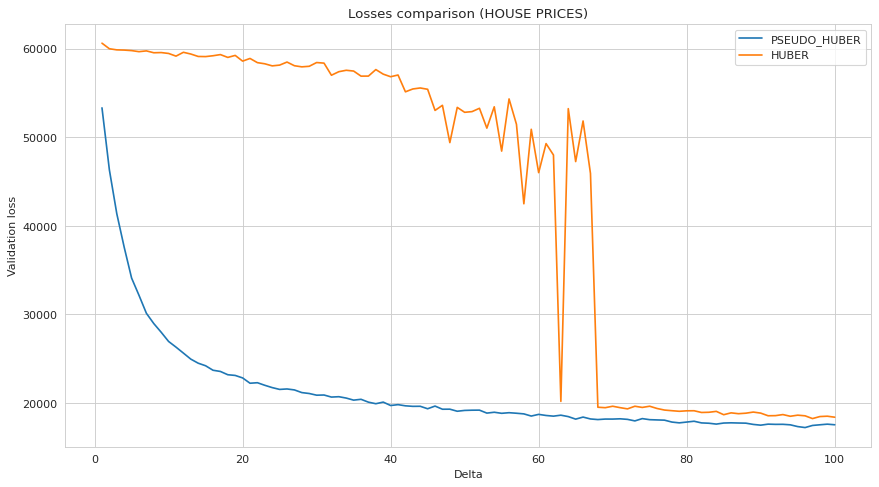

In [23]:
figure(figsize=(13, 7), dpi=80)

plt.xlabel('Delta')
plt.ylabel('Validation loss')
plt.title('Losses comparison' + ' (HOUSE PRICES)')

for key in HUBER_LOSSES:
    plt.plot(deltas, deltas_scores[key], label=key)
    
plt.legend()
plt.savefig("HUBERTS_HOUSE_PRICES.png")